First off install dependencies. This assumes that the notebook is run in the correct virtualenv.

In [1]:
!pip install pandas numpy seaborn gpy sklearn plotly

You are using pip version 19.0.1, however version 19.0.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


## Load training data
All trajectories must be in the same space, so normalisation is done segement-wise. This will not be Euclidian, so ARD need to be used.

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from itertools import repeat
from IPython.display import display, clear_output
from pandas import DataFrame

from model.pre_process import pre_process
from model.segment_normaliser import normaliser_for_seg

%load_ext autoreload
%autoreload 2

plt.style.use('ggplot')
np.random.seed(1)
trajs_pickle_path = '../data/train3.pkl'
data = pd.read_pickle(trajs_pickle_path)
n_trajs = list(data.traj.unique())
n_trajs_to_use = 100 #len(n_trajs)
trajs_to_use = frozenset(np.random.choice(n_trajs, size=n_trajs_to_use, replace=False))
trajs = data[data.traj.transform(lambda j: j in trajs_to_use)]
train_traj_ids = trajs.traj.unique()
train_seg_ids  = trajs.seg.unique()

# Segment normaliser
seg_dict = dict(tuple(data.groupby('seg')))
seg_normalisers = {
    seg_n: normaliser_for_seg(seg_dict[seg_n])
    for seg_n in seg_dict
}

def load_train_seg(traj_n, seg_n):
    return trajs[(trajs.traj == traj_n) & (trajs.seg == seg_n)]

def in_sample_seg_loader(seg_n, traj_n, seg_size=1):
    print('loading segment', seg_n, traj_n, seg_size)
    return pre_process(
        load_train_seg(traj_n, seg_n), 
        stop_compress_delta, 
        seg_normalisers[seg_n],
        seg_size
    )

def from_km(km):
    return km*1000
    
def from_km_h(km_h):
    """To m/s"""
    return km_h/3.6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Learn a model

loading segment 9 58 1
Optimization restart 1/3, f = -538.8487747761833
Optimization restart 2/3, f = -538.8487747751086
Optimization restart 3/3, f = -538.8487747951773
Optimization restart 1/3, f = -647.1336422905189
Optimization restart 2/3, f = -647.1336422900641
Optimization restart 3/3, f = -647.1336422904176
Optimization restart 1/3, f = -1034.785580026325
Optimization restart 2/3, f = -1034.7855799974488
Optimization restart 3/3, f = -1034.7855800188636
Optimization restart 1/3, f = -1034.794914777519
Optimization restart 2/3, f = -1034.7949147923775
Optimization restart 3/3, f = -1034.794914786041
Optimization restart 1/3, f = -1118.7295213183163
Optimization restart 2/3, f = -1118.7295213186133
Optimization restart 3/3, f = -1118.7295213182638
Optimization restart 1/3, f = -1118.7341643459395
Optimization restart 2/3, f = -1118.7341643449195
Optimization restart 3/3, f = -1118.7341642135855


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 43.35619464298722
Optimization restart 2/3, f = 43.35619464291632
Optimization restart 3/3, f = 43.35619464292916


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -227.60321468243345
Optimization restart 2/3, f = -227.6032146823601
Optimization restart 3/3, f = -227.60321468244086


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -126.33709064423775
Optimization restart 2/3, f = -126.33709064428584
Optimization restart 3/3, f = -126.33709064429603


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -124.55858239628147
Optimization restart 2/3, f = -124.55858239633771
Optimization restart 3/3, f = -124.55858239633802


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -395.8167642505179
Optimization restart 2/3, f = -395.8167642504462
Optimization restart 3/3, f = -395.81676425052706


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -395.84909419843376
Optimization restart 2/3, f = -395.8490941984812
Optimization restart 3/3, f = -395.84909419849396
Optimization restart 1/3, f = -2037.632686096399
Optimization restart 2/3, f = -2037.6326908660535
Optimization restart 3/3, f = -2037.6326908261426
Optimization restart 1/3, f = 352.33975055671334
Optimization restart 2/3, f = 352.3397505307827
Optimization restart 3/3, f = 450.5455667850584


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\matplotlib\contour.py:1000: UserWarning:The following kwargs were not used by contour: 'label', 'linewidth'


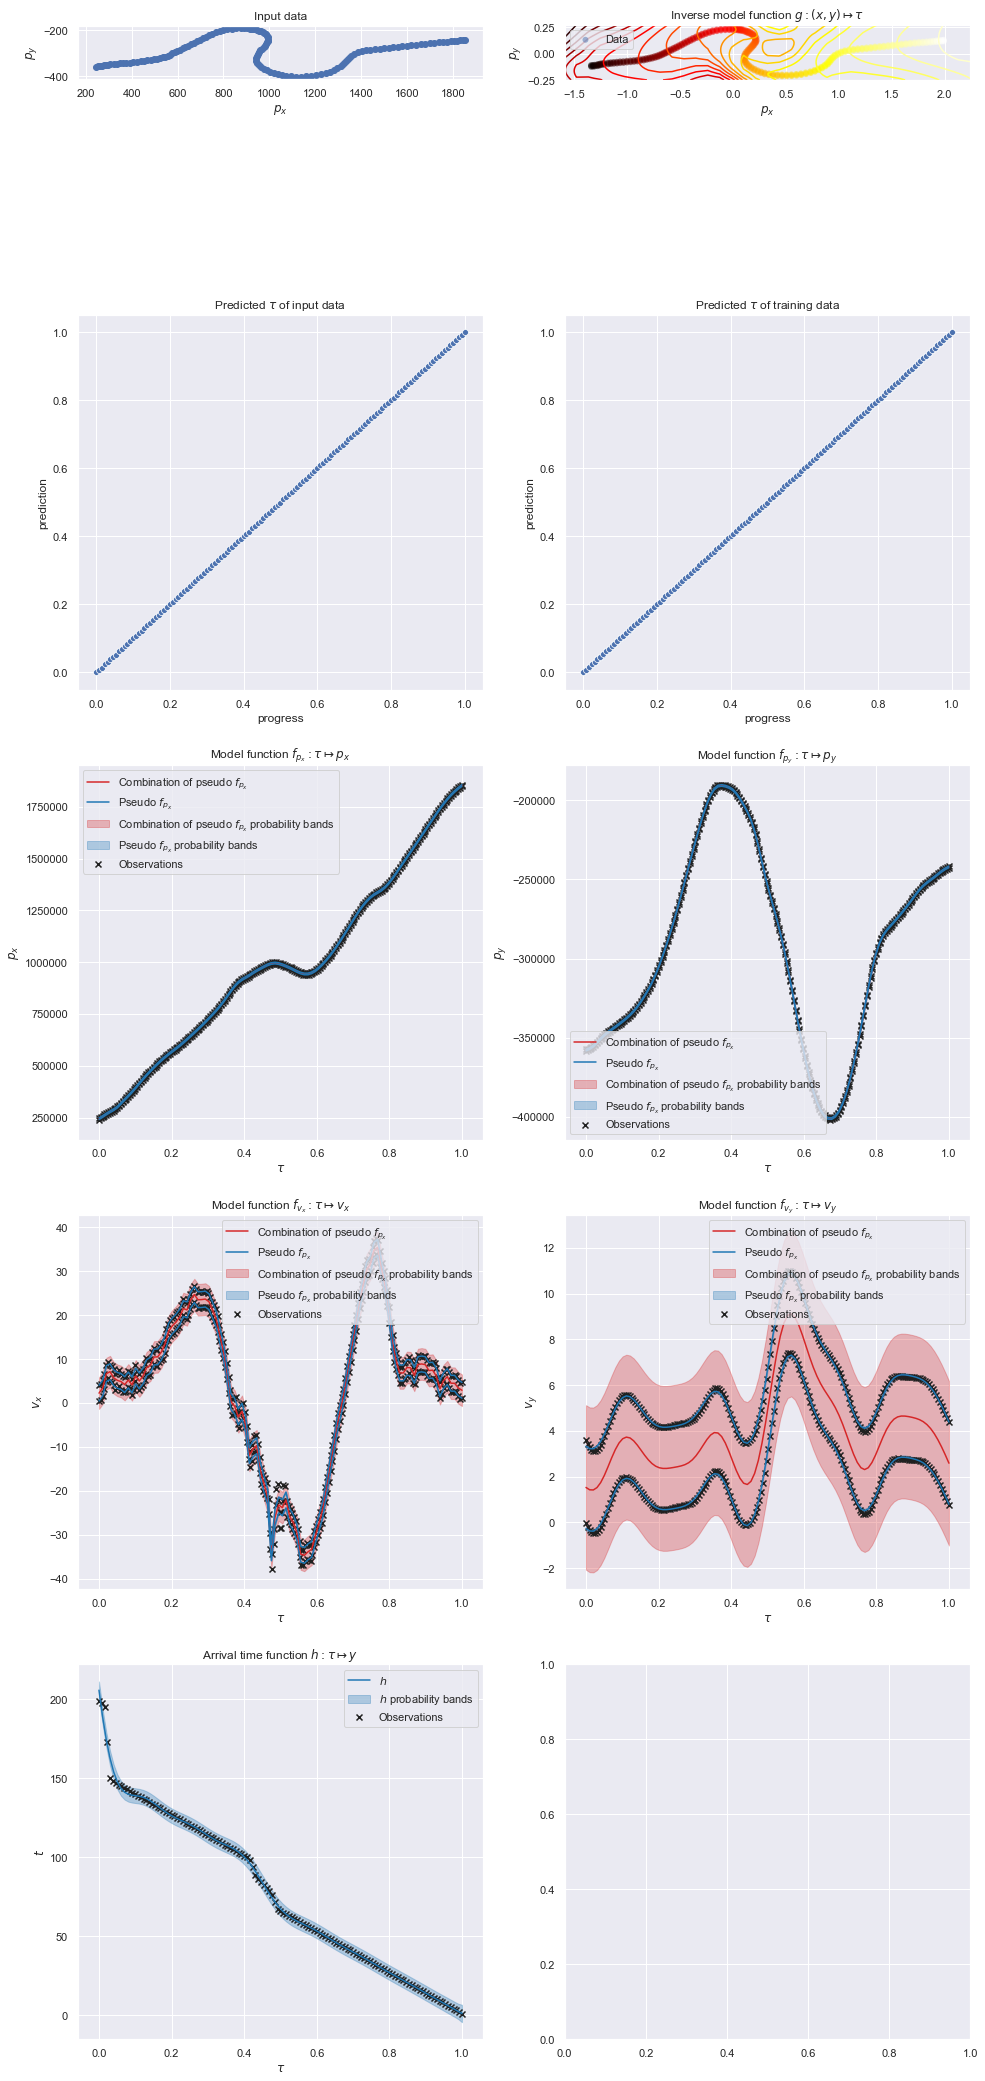

In [91]:
from math import sqrt, cos, sin, radians
import seaborn as sns
import GPy
from GPy.models import GPRegression
from typing import List
from model.trajectory_model import learn_model, plot_model

%matplotlib inline
sns.set(style="darkgrid")

np.random.seed(1)

# What to load
route_n = 3
seg_n = 9 # 1-indexed
train_traj_n = 1 # 0-indexed
stop_compress_delta = 5 # meters
train_traj_id = train_traj_ids[train_traj_n]
seg = in_sample_seg_loader(seg_n, train_traj_id)
normaliser = seg_normalisers[seg_n]
f_p_codomain = ['x', 'y']
f_v_codomain = ['dx', 'dy']
f_p_likelihood_noise = .1 / normaliser.p_scale  # meters
f_v_likelihood_noise = from_km_h(.1) / normaliser.v_scale # m/s
delta_xy = 4 / normaliser.p_scale    # metres, spatial cluster width
delta_p = .5 / normaliser.p_scale # metres, p cluster width
delta_v = .5 / normaliser.v_scale   # metres/second, v cluster width

m = learn_model(
    seg, route_n, seg_n, train_traj_n,
    f_p_codomain, f_v_codomain,
    f_p_likelihood_noise,
    f_v_likelihood_noise,
    normaliser,
    delta_xy, 
    delta_p, delta_v
)


plot_model(
    m, seg, normaliser
)

## Learn many models

In [5]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from functools import reduce
from itertools import islice

from model.trajectory_model import learn_model
from model.storage import save_model, acquire_db_conn

np.random.seed(1)

def learn(traj_n, seg_n):
    seg = in_sample_seg_loader(seg_n, traj_n)
    normaliser = seg_normalisers[seg_n]
    return learn_model(
        seg, route_n, seg_n, traj_n,
        f_p_codomain, f_v_codomain,
        f_p_likelihood_noise, 
        f_v_likelihood_noise,
        normaliser,
        delta_xy, 
        delta_p, delta_v
    )

def chunk(it, size):
    it = iter(it)
    return iter(lambda: tuple(islice(it, size)), ())

# Batch to avoid memory error

seg_ns_to_train = [9] # train_seg_ids
batch_size = 10
already_trained = 0
n_to_train = 10

batches = list(chunk(train_traj_ids[already_trained:already_trained+n_to_train], batch_size))
print(batches)
models = []
with acquire_db_conn() as conn:
    for seg_n in seg_ns_to_train:
        print('doing segment', seg_n)
        for batch in tqdm(batches):
            batch_models = []
            for traj_n in batch:
                model = learn(traj_n, seg_n)
                models.append(model)
                #m_id = save_model(model, conn)

[(32, 58, 68, 87, 147, 168, 245, 251, 299, 303)]
doing segment 9


  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

loading segment 9 32 1
Optimization restart 1/3, f = -526.2596826578277
Optimization restart 2/3, f = -526.259682657108
Optimization restart 3/3, f = -526.259682657208
Optimization restart 1/3, f = -566.4902871915555
Optimization restart 2/3, f = -566.49028719138
Optimization restart 3/3, f = -566.4902871909959
Optimization restart 1/3, f = -909.7184667565302
Optimization restart 2/3, f = -909.7184667534767
Optimization restart 3/3, f = -909.718466733578
Optimization restart 1/3, f = -909.7218678354689
Optimization restart 2/3, f = -909.721867835438
Optimization restart 3/3, f = -909.7218678201873
Optimization restart 1/3, f = -951.4928333592777
Optimization restart 2/3, f = -951.4928333542913
Optimization restart 3/3, f = -951.4928333592426
Optimization restart 1/3, f = -951.4949596665052
Optimization restart 2/3, f = -951.4949596621552
Optimization restart 3/3, f = -951.4949596648515


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 58.323783158919674
Optimization restart 2/3, f = 58.323783159135445
Optimization restart 3/3, f = 58.32378315952944


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -17.080448207143576
Optimization restart 2/3, f = -17.0804482071452
Optimization restart 3/3, f = -17.08044820716273


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -116.7071525984832
Optimization restart 2/3, f = -116.70715259871236
Optimization restart 3/3, f = -116.70715259874225


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -117.56732956179708
Optimization restart 2/3, f = -117.56732956179044
Optimization restart 3/3, f = -117.56732956170343


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -228.174115926872
Optimization restart 2/3, f = -228.1741159387373
Optimization restart 3/3, f = -228.1741159385703


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -228.3864401628392
Optimization restart 2/3, f = -228.3864401663313
Optimization restart 3/3, f = -228.3864401657778
Optimization restart 1/3, f = -1937.400760228798
Optimization restart 2/3, f = -1937.4007606950213
Optimization restart 3/3, f = -1937.4007596216275
Optimization restart 1/3, f = 327.4585144248571
Optimization restart 2/3, f = 327.4585144254809
Optimization restart 3/3, f = 327.45851442533706
loading segment 9 58 1
Optimization restart 1/3, f = -529.3736211174617
Optimization restart 2/3, f = -529.373621118545
Optimization restart 3/3, f = -529.3736211166237
Optimization restart 1/3, f = -583.7136231291204
Optimization restart 2/3, f = -583.713623128998
Optimization restart 3/3, f = -583.7136231291477
Optimization restart 1/3, f = -902.7541081006904
Optimization restart 2/3, f = -902.7541081057925
Optimization restart 3/3, f = -902.7541080968639
Optimization restart 1/3, f = -902.7589156610186
Optimization restart 2/3, f = -902.7589156639738

reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 284.06247947663826
Optimization restart 2/3, f = 116.30367818203548
Optimization restart 3/3, f = 116.30367818207378


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 32.7361077552674
Optimization restart 2/3, f = 32.736107755277715
Optimization restart 3/3, f = 32.73610775526675


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 2.8780990199167045
Optimization restart 2/3, f = 2.878099019916403
Optimization restart 3/3, f = 2.8780990199170686


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 1.0051493241691034
Optimization restart 2/3, f = 1.005149324171514
Optimization restart 3/3, f = 1.0051493241689773


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -130.34430607016077
Optimization restart 2/3, f = -130.3443060701542
Optimization restart 3/3, f = -130.34430607015946


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -130.81973079200623
Optimization restart 2/3, f = -130.81973079201347
Optimization restart 3/3, f = -130.81973079200662
Optimization restart 1/3, f = -2037.632686096399
Optimization restart 2/3, f = -2037.6326908565857
Optimization restart 3/3, f = -2037.6326907865537
Optimization restart 1/3, f = 352.3397505307594
Optimization restart 2/3, f = 450.54645708515267
Optimization restart 3/3, f = 352.3609164010617
loading segment 9 68 1
Optimization restart 1/3, f = -446.7107835293136
Optimization restart 2/3, f = -446.7107835495259
Optimization restart 3/3, f = -446.7107835462114
Optimization restart 1/3, f = -489.9137624630382
Optimization restart 2/3, f = -489.9137624629509
Optimization restart 3/3, f = -489.9137624630026
Optimization restart 1/3, f = -913.6619475347761
Optimization restart 2/3, f = -913.6619475346307
Optimization restart 3/3, f = -913.6619475355875
Optimization restart 1/3, f = -913.6661034632773
Optimization restart 2/3, f = -913.66610346

reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 81.2088529322429
Optimization restart 2/3, f = 81.2088529322638
Optimization restart 3/3, f = 81.20885293280382


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 1.3862381287640098
Optimization restart 2/3, f = 1.3862381287581194
Optimization restart 3/3, f = 1.386238128760315


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -103.44162852337453
Optimization restart 2/3, f = -103.44162852339862
Optimization restart 3/3, f = -103.4416285234059


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -104.65941165724503
Optimization restart 2/3, f = -104.65941165731826
Optimization restart 3/3, f = -104.65941165732154


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -245.31710709728256
Optimization restart 2/3, f = -245.31710709830307
Optimization restart 3/3, f = -245.3171070983577


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -245.45616705932704
Optimization restart 2/3, f = -245.45616706906478
Optimization restart 3/3, f = -245.4561670690704
Optimization restart 1/3, f = -1793.0861999350868
Optimization restart 2/3, f = -1793.0862010487958
Optimization restart 3/3, f = -1793.086202397396
Optimization restart 1/3, f = 154.34102596950206
Optimization restart 2/3, f = 154.34606854328496
Optimization restart 3/3, f = 154.34102595047324
loading segment 9 87 1
Optimization restart 1/3, f = -492.0195019048763
Optimization restart 2/3, f = -492.0195019041133
Optimization restart 3/3, f = -492.01950190089946
Optimization restart 1/3, f = -538.804915805765
Optimization restart 2/3, f = -538.8049158057373
Optimization restart 3/3, f = -538.8049158056855
Optimization restart 1/3, f = -910.094060632169
Optimization restart 2/3, f = -910.0940606495772
Optimization restart 3/3, f = -910.0940606448628
Optimization restart 1/3, f = -910.0994471009412
Optimization restart 2/3, f = -910.09944710

reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 140.04755299398505
Optimization restart 2/3, f = 140.0475529938944
Optimization restart 3/3, f = 140.04755299391746


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 64.7053962000225
Optimization restart 2/3, f = 64.70539620005205
Optimization restart 3/3, f = 64.70539620002224


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 35.05994354278676
Optimization restart 2/3, f = 35.05994354283759
Optimization restart 3/3, f = 35.05994354278321


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 33.140373067269735
Optimization restart 2/3, f = 33.14037306727075
Optimization restart 3/3, f = 33.14037306727894


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -85.57084403313041
Optimization restart 2/3, f = -85.57084403313402
Optimization restart 3/3, f = -85.57084403264906


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -86.14513851324556
Optimization restart 2/3, f = -86.14513851326511
Optimization restart 3/3, f = -86.14513851326387
Optimization restart 1/3, f = -1788.2212570844586
Optimization restart 2/3, f = -1788.2212572156113
Optimization restart 3/3, f = -1823.3982087809318
Optimization restart 1/3, f = 331.2747363597405
Optimization restart 2/3, f = 331.28572526654995
Optimization restart 3/3, f = 331.3022473953309
loading segment 9 147 1
Optimization restart 1/3, f = -589.8846340827506
Optimization restart 2/3, f = -589.8846340849645
Optimization restart 3/3, f = -589.8846340825799
Optimization restart 1/3, f = -633.8227777196173
Optimization restart 2/3, f = -633.8227777207848
Optimization restart 3/3, f = -633.8227777208004
Optimization restart 1/3, f = -915.3500692494885
Optimization restart 2/3, f = -915.3500692511386
Optimization restart 3/3, f = -915.3500692437099
Optimization restart 1/3, f = -915.3524428237581
Optimization restart 2/3, f = -915.352442825

reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 18.469732451386065
Optimization restart 2/3, f = 18.46973245139236
Optimization restart 3/3, f = 18.469732451387912


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -80.392381596407
Optimization restart 2/3, f = -80.39238159673437
Optimization restart 3/3, f = -80.39238159675526


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -145.8124960044369
Optimization restart 2/3, f = -145.8124960052845
Optimization restart 3/3, f = -145.812496005252


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -146.8448496612721
Optimization restart 2/3, f = -146.84484966482168
Optimization restart 3/3, f = -146.8448496648122


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -344.1441716784917
Optimization restart 2/3, f = -344.1441716782686
Optimization restart 3/3, f = -344.14417167849393


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -344.1069681676342
Optimization restart 2/3, f = -344.1069681676412
Optimization restart 3/3, f = -344.1069681676328
Optimization restart 1/3, f = -2262.1807816471965
Optimization restart 2/3, f = -2262.180782472037
Optimization restart 3/3, f = -2262.180782595321
Optimization restart 1/3, f = 279.5836529326073
Optimization restart 2/3, f = 293.8379779050231
Optimization restart 3/3, f = 279.5836529398448
loading segment 9 168 1
Optimization restart 1/3, f = -540.0889010827011
Optimization restart 2/3, f = -540.0889010836911
Optimization restart 3/3, f = -540.0889010729403
Optimization restart 1/3, f = -579.8641155683789
Optimization restart 2/3, f = -579.8641155683667
Optimization restart 3/3, f = -579.8641155683608
Optimization restart 1/3, f = -908.7186044322203
Optimization restart 2/3, f = -908.718604431872
Optimization restart 3/3, f = -908.7186044276167
Optimization restart 1/3, f = -908.7232122151378
Optimization restart 2/3, f = -908.7232121913481

reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 25.43446012638195
Optimization restart 2/3, f = 25.43446012638631
Optimization restart 3/3, f = 25.43446012642248


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -39.708280002212696
Optimization restart 2/3, f = -39.70828000215755
Optimization restart 3/3, f = -39.70828000221604


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -136.62348714496684
Optimization restart 2/3, f = -136.6234871449408
Optimization restart 3/3, f = -136.62348714495516


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -137.6644003898264
Optimization restart 2/3, f = -137.664400389861
Optimization restart 3/3, f = -137.66440038962483


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -264.8899599838777
Optimization restart 2/3, f = -264.8899599807815
Optimization restart 3/3, f = -264.8899599838784


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -265.01680649036507
Optimization restart 2/3, f = -265.0168064903769
Optimization restart 3/3, f = -265.0168064903415
Optimization restart 1/3, f = -1996.123222904283
Optimization restart 2/3, f = -1996.1232231457388
Optimization restart 3/3, f = -1996.1232231366876
Optimization restart 1/3, f = 270.6654625235022
Optimization restart 2/3, f = 270.66762813418893
Optimization restart 3/3, f = 279.55583693478275
loading segment 9 245 1
Optimization restart 1/3, f = -483.81287015885147
Optimization restart 2/3, f = -483.812870157936
Optimization restart 3/3, f = -483.8128701072178
Optimization restart 1/3, f = -525.7417109997067
Optimization restart 2/3, f = -525.7417110005143
Optimization restart 3/3, f = -525.7417109873518
Optimization restart 1/3, f = -909.2647698747087
Optimization restart 2/3, f = -909.2647698706263
Optimization restart 3/3, f = -909.264769873603
Optimization restart 1/3, f = -909.2684105408988
Optimization restart 2/3, f = -909.268410537

reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 45.047006819081155
Optimization restart 2/3, f = 45.047006819079456
Optimization restart 3/3, f = 45.04700681909139


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 22.37544896857768
Optimization restart 2/3, f = 22.37544896858324
Optimization restart 3/3, f = 22.375448968591265


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -156.97916990610975
Optimization restart 2/3, f = -156.97916990605833
Optimization restart 3/3, f = -156.97916990630654


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -157.91418979106973
Optimization restart 2/3, f = -157.91418979130574
Optimization restart 3/3, f = -157.914189791307


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -208.9984567259339
Optimization restart 2/3, f = -208.99845672633802
Optimization restart 3/3, f = -208.9984567264522


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -209.26535264731308
Optimization restart 2/3, f = -209.2653526472929
Optimization restart 3/3, f = -209.2653526473074
Optimization restart 1/3, f = -1798.0899356304049
Optimization restart 2/3, f = -1798.0899356112222
Optimization restart 3/3, f = -1798.0899356114037
Optimization restart 1/3, f = 192.1645867287721
Optimization restart 2/3, f = 192.1645867223152
Optimization restart 3/3, f = 192.16843328355827
loading segment 9 251 1
Optimization restart 1/3, f = -503.8785186196748
Optimization restart 2/3, f = -503.87851861133106
Optimization restart 3/3, f = -503.8785186189272
Optimization restart 1/3, f = -542.7392715481421
Optimization restart 2/3, f = -542.7392715481889
Optimization restart 3/3, f = -542.7392715481794
Optimization restart 1/3, f = -914.0961414237615
Optimization restart 2/3, f = -914.0961414245257
Optimization restart 3/3, f = -914.0961414255838
Optimization restart 1/3, f = -914.0983590523184
Optimization restart 2/3, f = -914.0983588

reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 276.64028235285423
Optimization restart 2/3, f = 99.293605779434
Optimization restart 3/3, f = 99.2936057786791


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 20.985109454489297
Optimization restart 2/3, f = 20.98510945446445
Optimization restart 3/3, f = 20.985109454467498


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -41.32428855855939
Optimization restart 2/3, f = -41.32428855790774
Optimization restart 3/3, f = -41.324288558443435


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -42.94558956610503
Optimization restart 2/3, f = -42.945589566390765
Optimization restart 3/3, f = -42.94558956644128


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -160.04154866294442
Optimization restart 2/3, f = -160.04154866356748
Optimization restart 3/3, f = -160.04154866357672


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -160.4049226468701
Optimization restart 2/3, f = -160.40492264665272
Optimization restart 3/3, f = -160.4049226466349
Optimization restart 1/3, f = -1849.53331253233
Optimization restart 2/3, f = -1849.533312426213
Optimization restart 3/3, f = -1849.5333125313546
Optimization restart 1/3, f = 351.83887082059834
Optimization restart 2/3, f = 351.8388706535832
Optimization restart 3/3, f = 351.8052886960508
loading segment 9 299 1
Optimization restart 1/3, f = -456.3328233224503
Optimization restart 2/3, f = -456.3328233218057
Optimization restart 3/3, f = -456.33282328544317
Optimization restart 1/3, f = -492.5920595221547
Optimization restart 2/3, f = -492.59205952076894
Optimization restart 3/3, f = -492.59205952218144
Optimization restart 1/3, f = -917.0042476992353
Optimization restart 2/3, f = -917.0042476608688
Optimization restart 3/3, f = -917.0042476986182
Optimization restart 1/3, f = -917.0053602794793
Optimization restart 2/3, f = -917.00536027

reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 96.29721565926276
Optimization restart 2/3, f = 96.29721565947955
Optimization restart 3/3, f = 96.29721565925931


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 31.536838820712237
Optimization restart 2/3, f = 31.536838820631196
Optimization restart 3/3, f = 31.536838820629143


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -62.174286471829255
Optimization restart 2/3, f = -62.17428647181955
Optimization restart 3/3, f = -62.174286471751685


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -63.470642093545386
Optimization restart 2/3, f = -63.47064209354697
Optimization restart 3/3, f = -63.470642093543304


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -167.2539196815142
Optimization restart 2/3, f = -167.25391968311487
Optimization restart 3/3, f = -167.2539196832619


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -167.63029981826222
Optimization restart 2/3, f = -167.63029981832085
Optimization restart 3/3, f = -167.63029981829553
Optimization restart 1/3, f = -1649.3200785941024
Optimization restart 2/3, f = -1649.3200786449295
Optimization restart 3/3, f = -1649.3200786899476
Optimization restart 1/3, f = 252.9668975971492


 C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\GPy\kern\src\rbf.py:51: RuntimeWarning:overflow encountered in square


Optimization restart 2/3, f = 252.96689759487504
Optimization restart 3/3, f = 252.96689451503474
loading segment 9 303 1
Optimization restart 1/3, f = -471.49908371896146
Optimization restart 2/3, f = -471.4990837179173
Optimization restart 3/3, f = -471.49908372029773
Optimization restart 1/3, f = -518.5034714441605
Optimization restart 2/3, f = -518.5034714440917
Optimization restart 3/3, f = -518.503471444137
Optimization restart 1/3, f = -907.2841583969607
Optimization restart 2/3, f = -907.2841584216933
Optimization restart 3/3, f = -907.2841584225972
Optimization restart 1/3, f = -907.2873936416568
Optimization restart 2/3, f = -907.2873936410791
Optimization restart 3/3, f = -907.287393641597
Optimization restart 1/3, f = -948.3036842276265
Optimization restart 2/3, f = -948.3036842289597
Optimization restart 3/3, f = -948.3036842041325
Optimization restart 1/3, f = -948.3076828230796
Optimization restart 2/3, f = -948.3076828269814
Optimization restart 3/3, f = -948.3076828270

reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 109.75556335945585
Optimization restart 2/3, f = 109.75556335928971
Optimization restart 3/3, f = 109.7555633592886


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = 45.89217505066856
Optimization restart 2/3, f = 45.892175050664925
Optimization restart 3/3, f = 45.892175050659205


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -32.43094485556539
Optimization restart 2/3, f = -32.430944854914245
Optimization restart 3/3, f = -32.430944855567816


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -33.92913292943446
Optimization restart 2/3, f = -33.9291329293938
Optimization restart 3/3, f = -33.92913292957299


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -136.71901925220268
Optimization restart 2/3, f = -136.71901925239132
Optimization restart 3/3, f = -136.71901925239268


reconstraining parameters GP_regression.Mat52.variance


Optimization restart 1/3, f = -137.09696687652718
Optimization restart 2/3, f = -137.09696687657396
Optimization restart 3/3, f = -137.09696687658243
Optimization restart 1/3, f = -1804.699343657072
Optimization restart 2/3, f = -1804.6993436884704
Optimization restart 3/3, f = -1804.6993436753223
Optimization restart 1/3, f = 288.77198425688067
Optimization restart 2/3, f = 324.7411351194205
Optimization restart 3/3, f = 324.74113331387116


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:07<00:00, 67.29s/it]


## Load many models

# Model predictions

In [190]:
from functools import reduce
from scipy.stats import norm
from numpy.linalg import inv, det
from numpy import ndarray
import math

from model.trajectory_model import TrajectoryModel, plot_model, predict, model_data_loglik
from model.pre_process import pre_process


In [67]:
from model.trajectory_model import loglik, combine
from model.function_model import predict


using 10 models
loading segment 9 68 0.8
10 (89, 4) (4, 10, 89)


No handles with labels found to put in legend.


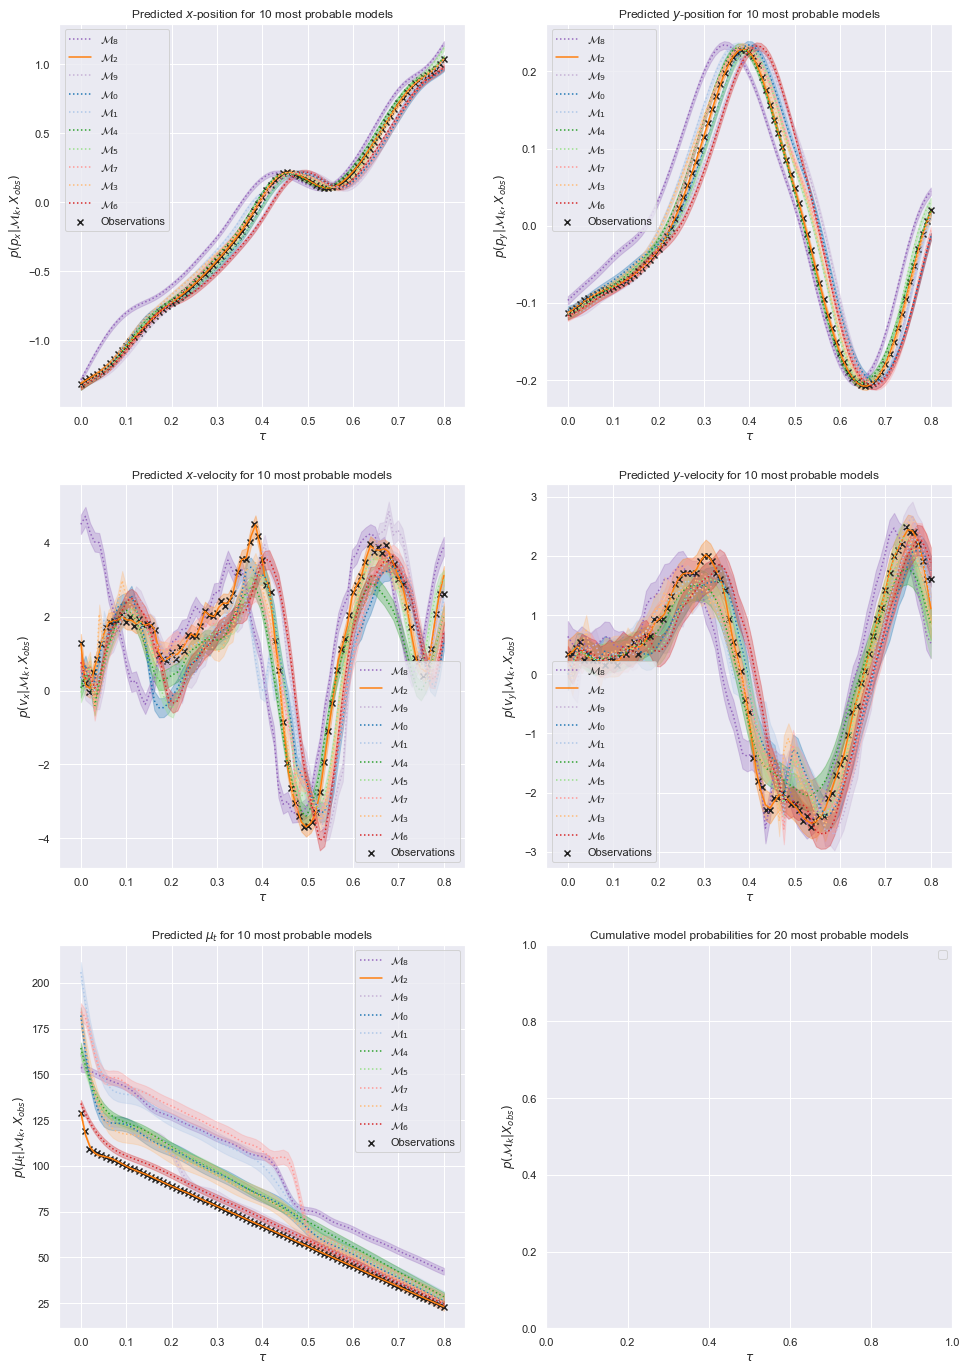

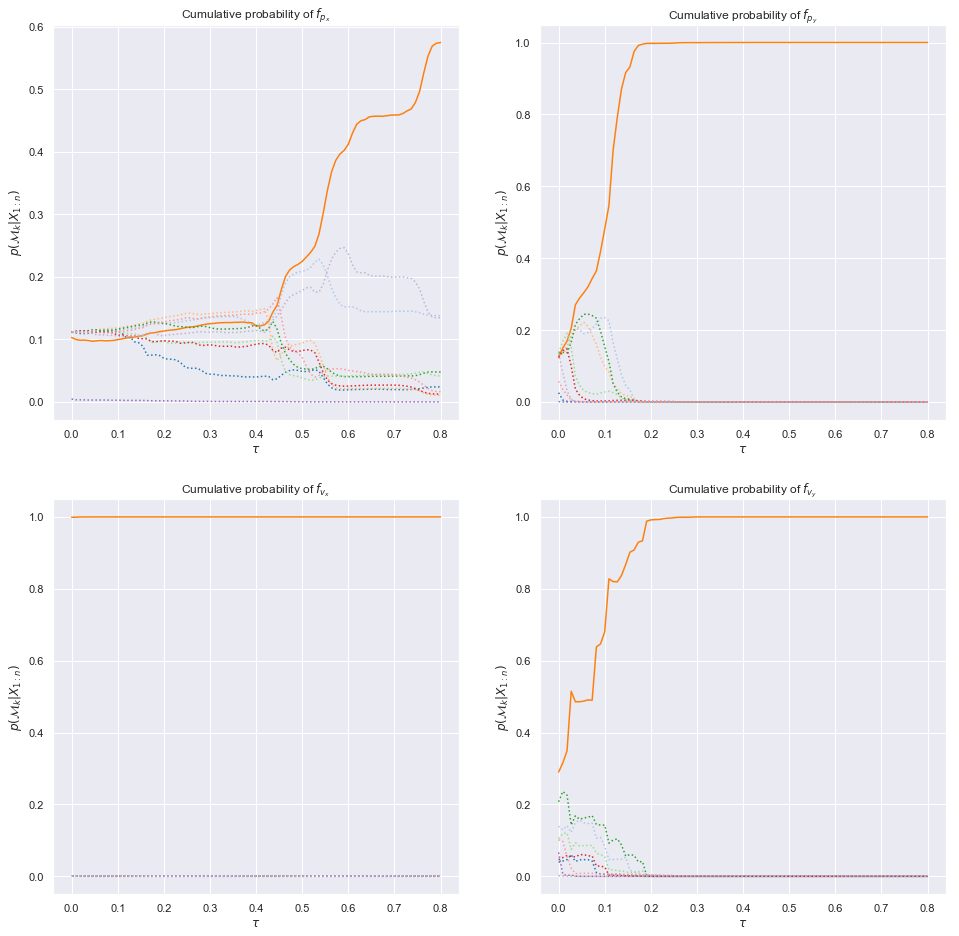

In [29]:
from model.trajectory_model import model_t_mu_predictions, plot_most_probable_models, model_cum_probs, model_weights
from model.trajectory_model import model_cum_gp_likelihoods, plot_gp_likelihoods, make_grid
from model.storage import acquire_db_conn

def load_models(route_n, seg_n, limit):
    import model.storage
    with acquire_db_conn() as conn:
        models = model.storage.load_models(
            int(route_n), 
            int(seg_n), 
            limit, conn
        )
    
    print('loaded {} models: {}'.format(len(models), [m.traj for m in models]))
    return models

route_n = 3
seg_n = 9
model_limit = 10
models_to_use = models # load_models(route_n, seg_n, model_limit)
model_ixs = range(len(models_to_use))

print('using', len(models_to_use), 'models')
# Load in-sample segment
test_traj_n = 2
fraction_observed = .8
test_traj_id = train_traj_ids[test_traj_n]
seg = in_sample_seg_loader(
    seg_n, test_traj_id,
    fraction_observed
)

#seg = out_of_sample_seg_loader(
#    seg_n, test_traj_ids[0],
#    fraction_observed
#)

time_left = seg.iloc[-1].time_left
f_codomain = ['x', 'y', 'dx', 'dy']
X_obs = seg[f_codomain].values
t_mu_mus, t_mu_sigmas = model_t_mu_predictions(models_to_use, X_obs)
gp_likelihoods = model_cum_gp_likelihoods(models_to_use, X_obs)
print(len(models_to_use), X_obs.shape, gp_likelihoods.shape)
weights = gp_likelihoods[0, :, -1]
#print(weights)
#print(model_weights(models_to_use, X_obs))

linestyle = lambda i: '-' if i == test_traj_n else ':'
plot_most_probable_models(
        models_to_use,
        weights,
        gp_likelihoods,
        seg, 
        linestyle=linestyle,
        n_models=10
)

def to_probabilities(likelihoods):
    likelihoods = np.apply_along_axis(np.cumsum, 2, likelihoods)
    
    def to_prob(x):
        x = np.exp(x - x.max())
        return x / x.sum()
        
    likelihoods = np.apply_along_axis(to_prob, 1, likelihoods)
    return likelihoods

tau_grid = seg.tau.values
gp_probabilities = to_probabilities(gp_likelihoods)
plot_gp_likelihoods(tau_grid, gp_probabilities, linestyle)

(10, 89)


Text(0, 0.5, '$p(\\mathcal{M}_k \\vert X_{1:n})$')

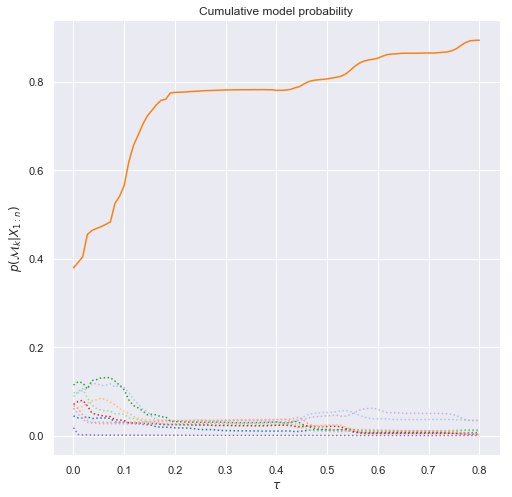

In [27]:
from model.plotting import plot_grid, default_color

_, ax = plot_grid(1, 1)
print(gp_probabilities.sum(axis=0).shape)
unnorm_model_probs = gp_probabilities.sum(axis=0)
model_probs = np.apply_along_axis(lambda x: x / x.sum(), 0, unnorm_model_probs)

for i, p in enumerate(model_probs):
    ax.plot(tau_grid, p, color=default_color(i), linestyle=linestyle(i))
    
ax.set_title('Cumulative model probability')
ax.set_xlabel(r'$\tau$')
ax.set_ylabel(r'$p(\mathcal{M}_k \vert X_{1:n})$')

# Plot Results

## Probability Band Plots
Plot most probable models (descending order) and their probability bands 

## Model Mean Plots

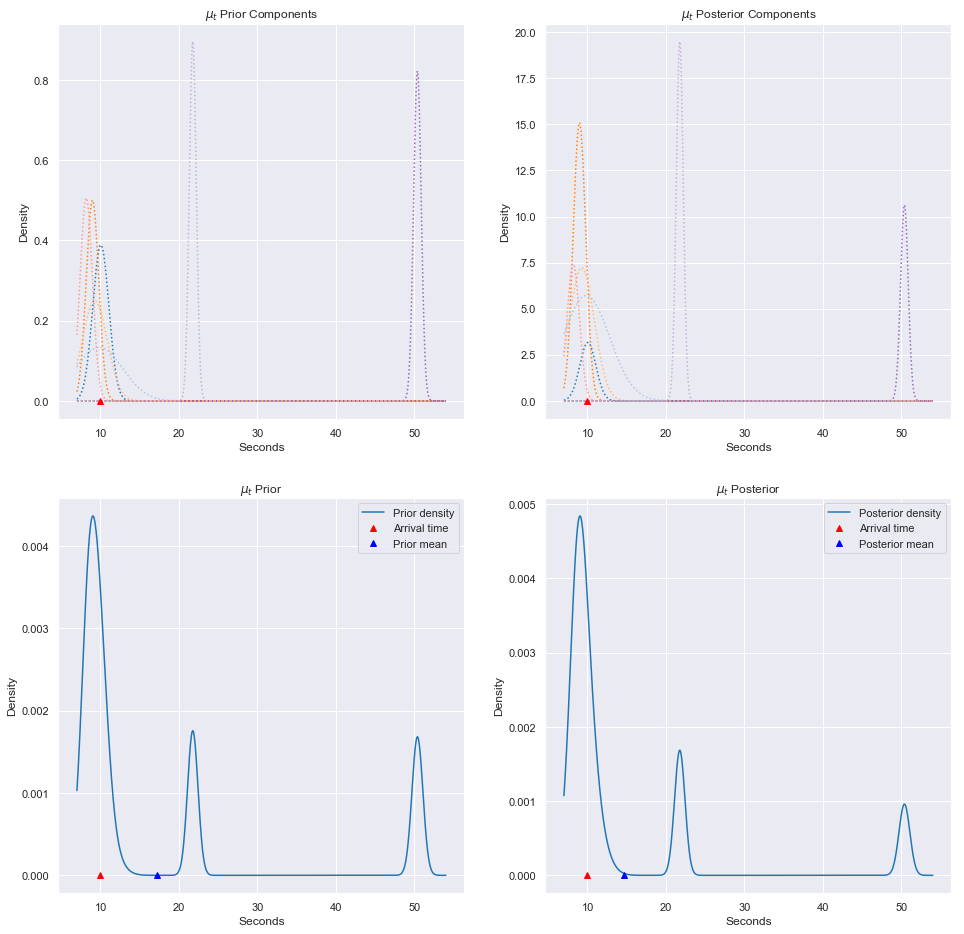

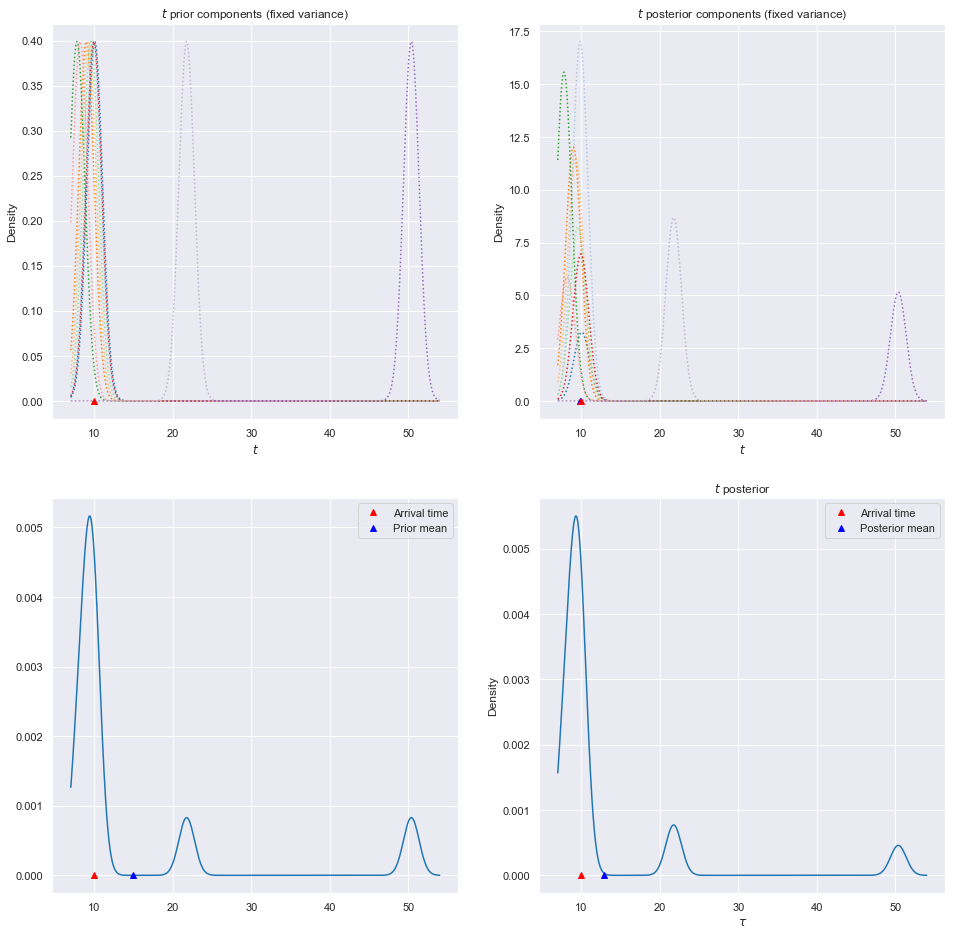

In [72]:
from model.plotting import grid_for
from model.trajectory_model import plot_mu_t, plot_model_probabilities, plot_state_model_means, plot_t, t_prediction

t_mu_mu = np.apply_along_axis(lambda row: row[-1], 0, t_mu_mus)
t_mu_sigma = np.apply_along_axis(lambda row: row[-1], 0, t_mu_sigmas)

t_grid = grid_for(t_mu_mu, t_mu_sigma, grid_pad=6)
t_mu, t_sigma = t_prediction(t_mu_mu, t_mu_sigma)

plot_mu_t(
    t_grid, 
    model_ixs,
    t_mu_mu,
    t_mu_sigma,
    weights,
    time_left, 
    linestyle
)
plot_t(
    t_grid,
    model_ixs,
    t_mu,
    t_sigma,
    weights,
    time_left,
    linestyle
)

progression = np.linspace(
    0, seg.iloc[-1].tau, seg.shape[0]
).reshape(-1, 1)
cum_probs = model_cum_probs(models_to_use, X_obs)

#plot_state_model_means(
#    models_to_use,
#    model_ixs,
#    seg,
#    progression,
#    linestyle
#)

## Model Prediction

In [19]:
from IPython.display import display, clear_output
import math
from collections import defaultdict
from tqdm import tqdm
import numpy as np


# Performance

## In Sample 




  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 5.576084613800049 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 1 32 0.2
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<01:32,  1.90s/it]

loading segment 1 58 0.2
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:03<01:25,  1.77s/it]

loading segment 1 68 0.2
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:04<01:19,  1.69s/it]

loading segment 1 87 0.2
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:06<01:16,  1.65s/it]

loading segment 1 147 0.2
most probable is 1
thes guys 58 147






 10%|████████▎                                                                          | 5/50 [00:07<01:11,  1.60s/it]

loading segment 1 168 0.2
most probable is 8
thes guys 299 168






 12%|█████████▉                                                                         | 6/50 [00:09<01:09,  1.58s/it]

loading segment 1 245 0.2
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:10<01:05,  1.53s/it]

loading segment 1 251 0.2
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:12<01:03,  1.52s/it]

loading segment 1 299 0.2
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:13<01:02,  1.53s/it]

loading segment 1 303 0.2
most probable is 31
thes guys 1354 303






 20%|████████████████▍                                                                 | 10/50 [00:15<00:59,  1.49s/it]

loading segment 1 373 0.2
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:16<01:00,  1.55s/it]

loading segment 1 392 0.2
most probable is 7
thes guys 251 392






 24%|███████████████████▋                                                              | 12/50 [00:18<01:01,  1.61s/it]

loading segment 1 395 0.2
most probable is 30
thes guys 1283 395






 26%|█████████████████████▎                                                            | 13/50 [00:20<00:56,  1.53s/it]

loading segment 1 398 0.2
most probable is 31
thes guys 1354 398






 28%|██████████████████████▉                                                           | 14/50 [00:21<00:52,  1.47s/it]

loading segment 1 520 0.2
most probable is 35
thes guys 1453 520






 30%|████████████████████████▌                                                         | 15/50 [00:22<00:52,  1.49s/it]

loading segment 1 572 0.2
most probable is 0
thes guys 32 572






 32%|██████████████████████████▏                                                       | 16/50 [00:24<00:47,  1.41s/it]

loading segment 1 639 0.2
most probable is 35
thes guys 1453 639






 34%|███████████████████████████▉                                                      | 17/50 [00:25<00:45,  1.39s/it]

loading segment 1 706 0.2
most probable is 8
thes guys 299 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:27<00:46,  1.44s/it]

loading segment 1 709 0.2
most probable is 7
thes guys 251 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:28<00:43,  1.41s/it]

loading segment 1 776 0.2
most probable is 27
thes guys 1220 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:29<00:43,  1.45s/it]

loading segment 1 833 0.2
most probable is 10
thes guys 373 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:31<00:42,  1.47s/it]

loading segment 1 870 0.2
most probable is 33
thes guys 1378 870






 44%|████████████████████████████████████                                              | 22/50 [00:32<00:40,  1.44s/it]

loading segment 1 875 0.2
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:34<00:37,  1.40s/it]

loading segment 1 942 0.2
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:35<00:35,  1.36s/it]

loading segment 1 983 0.2
most probable is 33
thes guys 1378 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:36<00:34,  1.38s/it]

loading segment 1 994 0.2
most probable is 27
thes guys 1220 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:38<00:35,  1.47s/it]

loading segment 1 1023 0.2
most probable is 29
thes guys 1278 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:39<00:32,  1.40s/it]

loading segment 1 1220 0.2
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:41<00:31,  1.41s/it]

loading segment 1 1265 0.2
most probable is 24
thes guys 983 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:42<00:31,  1.50s/it]

loading segment 1 1278 0.2
most probable is 27
thes guys 1220 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:44<00:29,  1.47s/it]

loading segment 1 1283 0.2
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:45<00:28,  1.47s/it]

loading segment 1 1354 0.2
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:47<00:26,  1.46s/it]

loading segment 1 1363 0.2
most probable is 0
thes guys 32 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:48<00:24,  1.45s/it]

loading segment 1 1378 0.2
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:50<00:24,  1.51s/it]

loading segment 1 1388 0.2
most probable is 27
thes guys 1220 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:51<00:21,  1.42s/it]

loading segment 1 1453 0.2
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:53<00:20,  1.45s/it]

loading segment 1 1476 0.2
most probable is 15
thes guys 572 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:54<00:18,  1.46s/it]

loading segment 1 1488 0.2
most probable is 35
thes guys 1453 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:56<00:17,  1.50s/it]

loading segment 1 1503 0.2
most probable is 1
thes guys 58 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:57<00:17,  1.59s/it]

loading segment 1 1509 0.2
most probable is 41
thes guys 1553 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:59<00:15,  1.51s/it]

loading segment 1 1546 0.2
most probable is 35
thes guys 1453 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:00<00:13,  1.53s/it]

loading segment 1 1553 0.2
most probable is 33
thes guys 1378 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:02<00:11,  1.49s/it]

loading segment 1 1604 0.2
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:03<00:10,  1.46s/it]

loading segment 1 1654 0.2
most probable is 15
thes guys 572 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:04<00:08,  1.40s/it]

loading segment 1 1727 0.2
most probable is 46
thes guys 1769 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:06<00:06,  1.39s/it]

loading segment 1 1734 0.2
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:07<00:05,  1.44s/it]

loading segment 1 1769 0.2
most probable is 22
thes guys 875 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:09<00:04,  1.42s/it]

loading segment 1 1773 0.2
most probable is 10
thes guys 373 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:10<00:02,  1.42s/it]

loading segment 1 1849 0.2
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:11<00:01,  1.37s/it]

loading segment 1 1859 0.2
most probable is 30
thes guys 1283 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.39s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 1 32 0.4
most probable is 7
thes guys 251 32






  2%|█▋                                                                                 | 1/50 [00:02<02:08,  2.62s/it]

loading segment 1 58 0.4
most probable is 7
thes guys 251 58






  4%|███▎                                                                               | 2/50 [00:04<02:00,  2.51s/it]

loading segment 1 68 0.4
most probable is 45
thes guys 1734 68






  6%|████▉                                                                              | 3/50 [00:07<01:54,  2.43s/it]

loading segment 1 87 0.4
most probable is 7
thes guys 251 87






  8%|██████▋                                                                            | 4/50 [00:09<01:50,  2.41s/it]

loading segment 1 147 0.4
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:11<01:49,  2.43s/it]

loading segment 1 168 0.4
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:14<01:48,  2.47s/it]

loading segment 1 245 0.4
most probable is 0
thes guys 32 245






 14%|███████████▌                                                                       | 7/50 [00:16<01:44,  2.42s/it]

loading segment 1 251 0.4
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:19<01:44,  2.48s/it]

loading segment 1 299 0.4
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:21<01:42,  2.50s/it]

loading segment 1 303 0.4
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:24<01:37,  2.44s/it]

loading segment 1 373 0.4
most probable is 35
thes guys 1453 373






 22%|██████████████████                                                                | 11/50 [00:26<01:38,  2.53s/it]

loading segment 1 392 0.4
most probable is 35
thes guys 1453 392






 24%|███████████████████▋                                                              | 12/50 [00:29<01:38,  2.58s/it]

loading segment 1 395 0.4
most probable is 45
thes guys 1734 395






 26%|█████████████████████▎                                                            | 13/50 [00:31<01:31,  2.47s/it]

loading segment 1 398 0.4
most probable is 35
thes guys 1453 398






 28%|██████████████████████▉                                                           | 14/50 [00:34<01:25,  2.39s/it]

loading segment 1 520 0.4
most probable is 35
thes guys 1453 520






 30%|████████████████████████▌                                                         | 15/50 [00:36<01:22,  2.36s/it]

loading segment 1 572 0.4
most probable is 7
thes guys 251 572






 32%|██████████████████████████▏                                                       | 16/50 [00:38<01:17,  2.27s/it]

loading segment 1 639 0.4
most probable is 43
thes guys 1654 639






 34%|███████████████████████████▉                                                      | 17/50 [00:40<01:15,  2.29s/it]

loading segment 1 706 0.4
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:43<01:17,  2.42s/it]

loading segment 1 709 0.4
most probable is 22
thes guys 875 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:45<01:14,  2.40s/it]

loading segment 1 776 0.4
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:48<01:15,  2.52s/it]

loading segment 1 833 0.4
most probable is 10
thes guys 373 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:51<01:14,  2.58s/it]

loading segment 1 870 0.4
most probable is 35
thes guys 1453 870






 44%|████████████████████████████████████                                              | 22/50 [00:53<01:10,  2.53s/it]

loading segment 1 875 0.4
most probable is 41
thes guys 1553 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:56<01:07,  2.49s/it]

loading segment 1 942 0.4
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:58<01:02,  2.39s/it]

loading segment 1 983 0.4
most probable is 10
thes guys 373 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:00<01:00,  2.40s/it]

loading segment 1 994 0.4
most probable is 41
thes guys 1553 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:03<00:58,  2.42s/it]

loading segment 1 1023 0.4
most probable is 45
thes guys 1734 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:05<00:53,  2.32s/it]

loading segment 1 1220 0.4
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:07<00:52,  2.40s/it]

loading segment 1 1265 0.4
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:10<00:53,  2.53s/it]

loading segment 1 1278 0.4
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:12<00:48,  2.43s/it]

loading segment 1 1283 0.4
most probable is 43
thes guys 1654 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:15<00:46,  2.45s/it]

loading segment 1 1354 0.4
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:18<00:44,  2.48s/it]

loading segment 1 1363 0.4
most probable is 35
thes guys 1453 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:20<00:41,  2.44s/it]

loading segment 1 1378 0.4
most probable is 8
thes guys 299 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:23<00:41,  2.58s/it]

loading segment 1 1388 0.4
most probable is 7
thes guys 251 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:25<00:36,  2.46s/it]

loading segment 1 1453 0.4
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:28<00:34,  2.49s/it]

loading segment 1 1476 0.4
most probable is 35
thes guys 1453 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:30<00:32,  2.51s/it]

loading segment 1 1488 0.4
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:33<00:30,  2.58s/it]

loading segment 1 1503 0.4
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:36<00:29,  2.69s/it]

loading segment 1 1509 0.4
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:38<00:25,  2.55s/it]

loading segment 1 1546 0.4
most probable is 45
thes guys 1734 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:41<00:23,  2.58s/it]

loading segment 1 1553 0.4
most probable is 35
thes guys 1453 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:43<00:20,  2.52s/it]

loading segment 1 1604 0.4
most probable is 45
thes guys 1734 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:45<00:17,  2.48s/it]

loading segment 1 1654 0.4
most probable is 45
thes guys 1734 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:48<00:14,  2.44s/it]

loading segment 1 1727 0.4
most probable is 46
thes guys 1769 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:50<00:12,  2.47s/it]

loading segment 1 1734 0.4
most probable is 2
thes guys 68 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:53<00:09,  2.48s/it]

loading segment 1 1769 0.4
most probable is 45
thes guys 1734 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:55<00:07,  2.46s/it]

loading segment 1 1773 0.4
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:57<00:04,  2.40s/it]

loading segment 1 1849 0.4
most probable is 35
thes guys 1453 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:00<00:02,  2.36s/it]

loading segment 1 1859 0.4
most probable is 45
thes guys 1734 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:02<00:00,  2.38s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 1 32 0.6
most probable is 48
thes guys 1849 32






  2%|█▋                                                                                 | 1/50 [00:03<02:52,  3.53s/it]

loading segment 1 58 0.6
most probable is 43
thes guys 1654 58






  4%|███▎                                                                               | 2/50 [00:06<02:46,  3.47s/it]

loading segment 1 68 0.6
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:10<02:38,  3.38s/it]

loading segment 1 87 0.6
most probable is 48
thes guys 1849 87






  8%|██████▋                                                                            | 4/50 [00:13<02:30,  3.28s/it]

loading segment 1 147 0.6
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:16<02:30,  3.34s/it]

loading segment 1 168 0.6
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:20<02:29,  3.39s/it]

loading segment 1 245 0.6
most probable is 0
thes guys 32 245






 14%|███████████▌                                                                       | 7/50 [00:23<02:23,  3.35s/it]

loading segment 1 251 0.6
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:26<02:22,  3.40s/it]

loading segment 1 299 0.6
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:30<02:20,  3.44s/it]

loading segment 1 303 0.6
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:33<02:14,  3.36s/it]

loading segment 1 373 0.6
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:37<02:17,  3.53s/it]

loading segment 1 392 0.6
most probable is 42
thes guys 1604 392






 24%|███████████████████▋                                                              | 12/50 [00:40<02:13,  3.52s/it]

loading segment 1 395 0.6
most probable is 42
thes guys 1604 395






 26%|█████████████████████▎                                                            | 13/50 [00:44<02:06,  3.42s/it]

loading segment 1 398 0.6
most probable is 42
thes guys 1604 398






 28%|██████████████████████▉                                                           | 14/50 [00:47<02:00,  3.35s/it]

loading segment 1 520 0.6
most probable is 42
thes guys 1604 520






 30%|████████████████████████▌                                                         | 15/50 [00:50<01:59,  3.41s/it]

loading segment 1 572 0.6
most probable is 14
thes guys 520 572






 32%|██████████████████████████▏                                                       | 16/50 [00:53<01:51,  3.29s/it]

loading segment 1 639 0.6
most probable is 43
thes guys 1654 639






 34%|███████████████████████████▉                                                      | 17/50 [00:57<01:48,  3.27s/it]

loading segment 1 706 0.6
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [01:00<01:50,  3.44s/it]

loading segment 1 709 0.6
most probable is 15
thes guys 572 709






 38%|███████████████████████████████▏                                                  | 19/50 [01:04<01:44,  3.36s/it]

loading segment 1 776 0.6
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [01:08<01:49,  3.66s/it]

loading segment 1 833 0.6
most probable is 10
thes guys 373 833






 42%|██████████████████████████████████▍                                               | 21/50 [01:12<01:45,  3.65s/it]

loading segment 1 870 0.6
most probable is 35
thes guys 1453 870






 44%|████████████████████████████████████                                              | 22/50 [01:15<01:39,  3.56s/it]

loading segment 1 875 0.6
most probable is 48
thes guys 1849 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:18<01:34,  3.49s/it]

loading segment 1 942 0.6
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:21<01:26,  3.33s/it]

loading segment 1 983 0.6
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:25<01:23,  3.33s/it]

loading segment 1 994 0.6
most probable is 48
thes guys 1849 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:28<01:19,  3.32s/it]

loading segment 1 1023 0.6
most probable is 45
thes guys 1734 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:31<01:13,  3.19s/it]

loading segment 1 1220 0.6
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:34<01:13,  3.34s/it]

loading segment 1 1265 0.6
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:39<01:15,  3.60s/it]

loading segment 1 1278 0.6
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:42<01:09,  3.47s/it]

loading segment 1 1283 0.6
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:45<01:06,  3.50s/it]

loading segment 1 1354 0.6
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:49<01:02,  3.49s/it]

loading segment 1 1363 0.6
most probable is 35
thes guys 1453 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:52<00:57,  3.37s/it]

loading segment 1 1378 0.6
most probable is 10
thes guys 373 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:56<00:58,  3.67s/it]

loading segment 1 1388 0.6
most probable is 42
thes guys 1604 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:59<00:52,  3.51s/it]

loading segment 1 1453 0.6
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:03<00:49,  3.57s/it]

loading segment 1 1476 0.6
most probable is 35
thes guys 1453 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:07<00:46,  3.54s/it]

loading segment 1 1488 0.6
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:10<00:43,  3.60s/it]

loading segment 1 1503 0.6
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:15<00:41,  3.76s/it]

loading segment 1 1509 0.6
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:18<00:35,  3.59s/it]

loading segment 1 1546 0.6
most probable is 37
thes guys 1488 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:22<00:32,  3.66s/it]

loading segment 1 1553 0.6
most probable is 35
thes guys 1453 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:25<00:28,  3.59s/it]

loading segment 1 1604 0.6
most probable is 45
thes guys 1734 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:28<00:24,  3.51s/it]

loading segment 1 1654 0.6
most probable is 45
thes guys 1734 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:31<00:20,  3.35s/it]

loading segment 1 1727 0.6
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:35<00:16,  3.35s/it]

loading segment 1 1734 0.6
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:38<00:13,  3.39s/it]

loading segment 1 1769 0.6
most probable is 45
thes guys 1734 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:41<00:10,  3.35s/it]

loading segment 1 1773 0.6
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:45<00:06,  3.34s/it]

loading segment 1 1849 0.6
most probable is 42
thes guys 1604 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:48<00:03,  3.25s/it]

loading segment 1 1859 0.6
most probable is 45
thes guys 1734 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:51<00:00,  3.29s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 1 32 0.8
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:04<03:32,  4.33s/it]

loading segment 1 58 0.8
most probable is 43
thes guys 1654 58






  4%|███▎                                                                               | 2/50 [00:08<03:25,  4.29s/it]

loading segment 1 68 0.8
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:12<03:18,  4.23s/it]

loading segment 1 87 0.8
most probable is 48
thes guys 1849 87






  8%|██████▋                                                                            | 4/50 [00:16<03:11,  4.16s/it]

loading segment 1 147 0.8
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:21<03:15,  4.35s/it]

loading segment 1 168 0.8
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:25<03:14,  4.41s/it]

loading segment 1 245 0.8
most probable is 0
thes guys 32 245






 14%|███████████▌                                                                       | 7/50 [00:30<03:05,  4.32s/it]

loading segment 1 251 0.8
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:34<03:05,  4.42s/it]

loading segment 1 299 0.8
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:39<03:06,  4.55s/it]

loading segment 1 303 0.8
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:43<02:58,  4.47s/it]

loading segment 1 373 0.8
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:48<03:00,  4.63s/it]

loading segment 1 392 0.8
most probable is 39
thes guys 1509 392






 24%|███████████████████▋                                                              | 12/50 [00:53<02:52,  4.55s/it]

loading segment 1 395 0.8
most probable is 42
thes guys 1604 395






 26%|█████████████████████▎                                                            | 13/50 [00:57<02:44,  4.44s/it]

loading segment 1 398 0.8
most probable is 29
thes guys 1278 398






 28%|██████████████████████▉                                                           | 14/50 [01:01<02:34,  4.29s/it]

loading segment 1 520 0.8
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [01:05<02:27,  4.22s/it]

loading segment 1 572 0.8
most probable is 48
thes guys 1849 572






 32%|██████████████████████████▏                                                       | 16/50 [01:09<02:21,  4.16s/it]

loading segment 1 639 0.8
most probable is 13
thes guys 398 639






 34%|███████████████████████████▉                                                      | 17/50 [01:13<02:18,  4.19s/it]

loading segment 1 706 0.8
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [01:18<02:20,  4.39s/it]

loading segment 1 709 0.8
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [01:22<02:13,  4.32s/it]

loading segment 1 776 0.8
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [01:28<02:21,  4.73s/it]

loading segment 1 833 0.8
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [01:32<02:15,  4.68s/it]

loading segment 1 870 0.8
most probable is 35
thes guys 1453 870






 44%|████████████████████████████████████                                              | 22/50 [01:37<02:09,  4.61s/it]

loading segment 1 875 0.8
most probable is 48
thes guys 1849 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:41<02:01,  4.50s/it]

loading segment 1 942 0.8
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:45<01:51,  4.30s/it]

loading segment 1 983 0.8
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:49<01:47,  4.31s/it]

loading segment 1 994 0.8
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:54<01:42,  4.27s/it]

loading segment 1 1023 0.8
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:57<01:35,  4.16s/it]

loading segment 1 1220 0.8
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [02:02<01:35,  4.36s/it]

loading segment 1 1265 0.8
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [02:08<01:38,  4.70s/it]

loading segment 1 1278 0.8
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [02:12<01:30,  4.53s/it]

loading segment 1 1283 0.8
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [02:17<01:26,  4.57s/it]

loading segment 1 1354 0.8
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [02:21<01:21,  4.55s/it]

loading segment 1 1363 0.8
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [02:25<01:14,  4.39s/it]

loading segment 1 1378 0.8
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [02:31<01:15,  4.73s/it]

loading segment 1 1388 0.8
most probable is 42
thes guys 1604 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [02:35<01:08,  4.57s/it]

loading segment 1 1453 0.8
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:39<01:03,  4.57s/it]

loading segment 1 1476 0.8
most probable is 35
thes guys 1453 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:44<00:59,  4.60s/it]

loading segment 1 1488 0.8
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:49<00:57,  4.80s/it]

loading segment 1 1503 0.8
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:55<00:55,  5.07s/it]

loading segment 1 1509 0.8
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:59<00:47,  4.78s/it]

loading segment 1 1546 0.8
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [03:04<00:44,  4.89s/it]

loading segment 1 1553 0.8
most probable is 35
thes guys 1453 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [03:09<00:38,  4.77s/it]

loading segment 1 1604 0.8
most probable is 45
thes guys 1734 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [03:13<00:32,  4.65s/it]

loading segment 1 1654 0.8
most probable is 47
thes guys 1773 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [03:17<00:26,  4.44s/it]

loading segment 1 1727 0.8
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [03:21<00:22,  4.42s/it]

loading segment 1 1734 0.8
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [03:26<00:17,  4.44s/it]

loading segment 1 1769 0.8
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [03:30<00:13,  4.41s/it]

loading segment 1 1773 0.8
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [03:34<00:08,  4.36s/it]

loading segment 1 1849 0.8
most probable is 42
thes guys 1604 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [03:38<00:04,  4.22s/it]

loading segment 1 1859 0.8
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:43<00:00,  4.23s/it]






  9%|███████▎                                                                        | 1/11 [09:56<1:39:22, 596.21s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 5.449422359466553 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 2 32 0.2
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<01:00,  1.23s/it]

loading segment 2 58 0.2
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:02<00:56,  1.18s/it]

loading segment 2 68 0.2
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:03<00:50,  1.07s/it]

loading segment 2 87 0.2
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:03<00:45,  1.01it/s]

loading segment 2 147 0.2
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:04<00:44,  1.02it/s]

loading segment 2 168 0.2
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:05<00:43,  1.02it/s]

loading segment 2 245 0.2
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:06<00:42,  1.01it/s]

loading segment 2 251 0.2
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:07<00:41,  1.00it/s]

loading segment 2 299 0.2
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:08<00:42,  1.03s/it]

loading segment 2 303 0.2
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:10<00:41,  1.05s/it]

loading segment 2 373 0.2
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:11<00:40,  1.04s/it]

loading segment 2 392 0.2
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:11<00:36,  1.03it/s]

loading segment 2 395 0.2
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:12<00:36,  1.03it/s]

loading segment 2 398 0.2
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:13<00:35,  1.02it/s]

loading segment 2 520 0.2
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:14<00:34,  1.01it/s]

loading segment 2 572 0.2
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:15<00:31,  1.07it/s]

loading segment 2 639 0.2
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:16<00:29,  1.10it/s]

loading segment 2 706 0.2
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:17<00:27,  1.15it/s]

loading segment 2 709 0.2
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:18<00:28,  1.10it/s]

loading segment 2 776 0.2
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:19<00:28,  1.05it/s]

loading segment 2 833 0.2
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:20<00:26,  1.11it/s]

loading segment 2 870 0.2
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:21<00:25,  1.08it/s]

loading segment 2 875 0.2
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:22<00:25,  1.06it/s]

loading segment 2 942 0.2
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:23<00:24,  1.05it/s]

loading segment 2 983 0.2
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:24<00:25,  1.02s/it]

loading segment 2 994 0.2
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:25<00:23,  1.02it/s]

loading segment 2 1023 0.2
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:25<00:21,  1.08it/s]

loading segment 2 1220 0.2
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:26<00:19,  1.11it/s]

loading segment 2 1265 0.2
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:28<00:21,  1.03s/it]

loading segment 2 1278 0.2
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:28<00:19,  1.03it/s]

loading segment 2 1283 0.2
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:29<00:17,  1.10it/s]

loading segment 2 1354 0.2
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:30<00:17,  1.04it/s]

loading segment 2 1363 0.2
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:31<00:15,  1.08it/s]

loading segment 2 1378 0.2
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:32<00:15,  1.02it/s]

loading segment 2 1388 0.2
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:33<00:14,  1.01it/s]

loading segment 2 1453 0.2
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:34<00:14,  1.01s/it]

loading segment 2 1476 0.2
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:35<00:13,  1.04s/it]

loading segment 2 1488 0.2
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:36<00:12,  1.04s/it]

loading segment 2 1503 0.2
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:38<00:11,  1.06s/it]

loading segment 2 1509 0.2
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:39<00:10,  1.06s/it]

loading segment 2 1546 0.2
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:40<00:09,  1.05s/it]

loading segment 2 1553 0.2
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:40<00:07,  1.03it/s]

loading segment 2 1604 0.2
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:41<00:06,  1.09it/s]

loading segment 2 1654 0.2
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:42<00:05,  1.12it/s]

loading segment 2 1727 0.2
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:43<00:04,  1.09it/s]

loading segment 2 1734 0.2
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:44<00:03,  1.07it/s]

loading segment 2 1769 0.2
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:45<00:02,  1.02it/s]

loading segment 2 1773 0.2
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:46<00:01,  1.00it/s]

loading segment 2 1849 0.2
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:47<00:00,  1.09it/s]

loading segment 2 1859 0.2
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:48<00:00,  1.18it/s]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 2 32 0.4
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<01:21,  1.67s/it]

loading segment 2 58 0.4
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:03<01:23,  1.75s/it]

loading segment 2 68 0.4
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:05<01:19,  1.69s/it]

loading segment 2 87 0.4
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:06<01:16,  1.67s/it]

loading segment 2 147 0.4
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:08<01:15,  1.69s/it]

loading segment 2 168 0.4
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:10<01:14,  1.70s/it]

loading segment 2 245 0.4
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:11<01:12,  1.70s/it]

loading segment 2 251 0.4
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:13<01:12,  1.73s/it]

loading segment 2 299 0.4
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:15<01:10,  1.72s/it]

loading segment 2 303 0.4
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:17<01:08,  1.72s/it]

loading segment 2 373 0.4
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:19<01:09,  1.77s/it]

loading segment 2 392 0.4
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:20<01:04,  1.70s/it]

loading segment 2 395 0.4
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:22<01:03,  1.72s/it]

loading segment 2 398 0.4
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:24<01:01,  1.71s/it]

loading segment 2 520 0.4
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:25<01:00,  1.72s/it]

loading segment 2 572 0.4
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:27<00:58,  1.71s/it]

loading segment 2 639 0.4
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:29<00:55,  1.68s/it]

loading segment 2 706 0.4
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:30<00:52,  1.64s/it]

loading segment 2 709 0.4
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:32<00:53,  1.72s/it]

loading segment 2 776 0.4
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:34<00:51,  1.72s/it]

loading segment 2 833 0.4
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:35<00:48,  1.66s/it]

loading segment 2 870 0.4
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:37<00:48,  1.73s/it]

loading segment 2 875 0.4
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:39<00:46,  1.73s/it]

loading segment 2 942 0.4
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:41<00:45,  1.75s/it]

loading segment 2 983 0.4
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:43<00:45,  1.82s/it]

loading segment 2 994 0.4
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:44<00:42,  1.77s/it]

loading segment 2 1023 0.4
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:46<00:38,  1.69s/it]

loading segment 2 1220 0.4
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:48<00:37,  1.69s/it]

loading segment 2 1265 0.4
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:50<00:41,  1.96s/it]

loading segment 2 1278 0.4
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:52<00:36,  1.84s/it]

loading segment 2 1283 0.4
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:53<00:33,  1.78s/it]

loading segment 2 1354 0.4
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:55<00:32,  1.82s/it]

loading segment 2 1363 0.4
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:57<00:29,  1.75s/it]

loading segment 2 1378 0.4
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:59<00:29,  1.85s/it]

loading segment 2 1388 0.4
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:01<00:27,  1.81s/it]

loading segment 2 1453 0.4
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:02<00:24,  1.77s/it]

loading segment 2 1476 0.4
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:04<00:23,  1.82s/it]

loading segment 2 1488 0.4
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:06<00:21,  1.82s/it]

loading segment 2 1503 0.4
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:08<00:19,  1.81s/it]

loading segment 2 1509 0.4
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:10<00:17,  1.78s/it]

loading segment 2 1546 0.4
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:11<00:15,  1.75s/it]

loading segment 2 1553 0.4
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:13<00:13,  1.68s/it]

loading segment 2 1604 0.4
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:14<00:11,  1.64s/it]

loading segment 2 1654 0.4
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:16<00:09,  1.62s/it]

loading segment 2 1727 0.4
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:18<00:08,  1.68s/it]

loading segment 2 1734 0.4
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:19<00:06,  1.69s/it]

loading segment 2 1769 0.4
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:21<00:05,  1.74s/it]

loading segment 2 1773 0.4
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:23<00:03,  1.81s/it]

loading segment 2 1849 0.4
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:25<00:01,  1.66s/it]

loading segment 2 1859 0.4
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:26<00:00,  1.57s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 2 32 0.6
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:02<02:00,  2.45s/it]

loading segment 2 58 0.6
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:05<02:02,  2.55s/it]

loading segment 2 68 0.6
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:07<01:54,  2.44s/it]

loading segment 2 87 0.6
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:09<01:50,  2.40s/it]

loading segment 2 147 0.6
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:12<01:48,  2.40s/it]

loading segment 2 168 0.6
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:14<01:47,  2.45s/it]

loading segment 2 245 0.6
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:17<01:48,  2.52s/it]

loading segment 2 251 0.6
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:20<01:50,  2.64s/it]

loading segment 2 299 0.6
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:22<01:46,  2.60s/it]

loading segment 2 303 0.6
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:25<01:42,  2.55s/it]

loading segment 2 373 0.6
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:27<01:41,  2.60s/it]

loading segment 2 392 0.6
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:30<01:34,  2.50s/it]

loading segment 2 395 0.6
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:32<01:32,  2.50s/it]

loading segment 2 398 0.6
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:35<01:30,  2.51s/it]

loading segment 2 520 0.6
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:37<01:28,  2.52s/it]

loading segment 2 572 0.6
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:40<01:22,  2.43s/it]

loading segment 2 639 0.6
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:42<01:19,  2.42s/it]

loading segment 2 706 0.6
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:44<01:17,  2.43s/it]

loading segment 2 709 0.6
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:47<01:17,  2.51s/it]

loading segment 2 776 0.6
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:50<01:15,  2.50s/it]

loading segment 2 833 0.6
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:52<01:09,  2.40s/it]

loading segment 2 870 0.6
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:54<01:09,  2.47s/it]

loading segment 2 875 0.6
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:57<01:06,  2.46s/it]

loading segment 2 942 0.6
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:59<01:03,  2.46s/it]

loading segment 2 983 0.6
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:02<01:03,  2.53s/it]

loading segment 2 994 0.6
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:04<00:59,  2.50s/it]

loading segment 2 1023 0.6
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:07<00:55,  2.43s/it]

loading segment 2 1220 0.6
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:09<00:52,  2.40s/it]

loading segment 2 1265 0.6
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:13<00:57,  2.76s/it]

loading segment 2 1278 0.6
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:15<00:51,  2.60s/it]

loading segment 2 1283 0.6
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:17<00:48,  2.54s/it]

loading segment 2 1354 0.6
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:20<00:46,  2.61s/it]

loading segment 2 1363 0.6
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:22<00:42,  2.51s/it]

loading segment 2 1378 0.6
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:25<00:41,  2.58s/it]

loading segment 2 1388 0.6
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:27<00:37,  2.52s/it]

loading segment 2 1453 0.6
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:30<00:35,  2.55s/it]

loading segment 2 1476 0.6
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:33<00:33,  2.61s/it]

loading segment 2 1488 0.6
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:35<00:31,  2.61s/it]

loading segment 2 1503 0.6
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:38<00:28,  2.62s/it]

loading segment 2 1509 0.6
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:40<00:25,  2.54s/it]

loading segment 2 1546 0.6
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:43<00:22,  2.52s/it]

loading segment 2 1553 0.6
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:45<00:19,  2.41s/it]

loading segment 2 1604 0.6
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:47<00:16,  2.38s/it]

loading segment 2 1654 0.6
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:50<00:14,  2.39s/it]

loading segment 2 1727 0.6
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:52<00:12,  2.45s/it]

loading segment 2 1734 0.6
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:55<00:09,  2.46s/it]

loading segment 2 1769 0.6
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:58<00:07,  2.54s/it]

loading segment 2 1773 0.6
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:00<00:05,  2.54s/it]

loading segment 2 1849 0.6
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:02<00:02,  2.36s/it]

loading segment 2 1859 0.6
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:04<00:00,  2.22s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 2 32 0.8
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:03<02:33,  3.13s/it]

loading segment 2 58 0.8
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:06<02:34,  3.22s/it]

loading segment 2 68 0.8
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:09<02:23,  3.04s/it]

loading segment 2 87 0.8
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:12<02:19,  3.03s/it]

loading segment 2 147 0.8
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:15<02:18,  3.07s/it]

loading segment 2 168 0.8
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:18<02:17,  3.11s/it]

loading segment 2 245 0.8
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:21<02:16,  3.18s/it]

loading segment 2 251 0.8
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:25<02:17,  3.28s/it]

loading segment 2 299 0.8
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:28<02:13,  3.25s/it]

loading segment 2 303 0.8
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:31<02:10,  3.26s/it]

loading segment 2 373 0.8
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:35<02:09,  3.31s/it]

loading segment 2 392 0.8
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:38<02:00,  3.17s/it]

loading segment 2 395 0.8
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:41<01:57,  3.18s/it]

loading segment 2 398 0.8
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:44<01:55,  3.21s/it]

loading segment 2 520 0.8
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:48<01:54,  3.27s/it]

loading segment 2 572 0.8
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:51<01:49,  3.23s/it]

loading segment 2 639 0.8
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:54<01:44,  3.18s/it]

loading segment 2 706 0.8
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:57<01:40,  3.13s/it]

loading segment 2 709 0.8
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [01:00<01:41,  3.28s/it]

loading segment 2 776 0.8
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [01:04<01:38,  3.28s/it]

loading segment 2 833 0.8
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [01:06<01:29,  3.09s/it]

loading segment 2 870 0.8
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [01:10<01:30,  3.23s/it]

loading segment 2 875 0.8
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:13<01:26,  3.22s/it]

loading segment 2 942 0.8
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:16<01:24,  3.24s/it]

loading segment 2 983 0.8
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:20<01:24,  3.37s/it]

loading segment 2 994 0.8
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:23<01:18,  3.26s/it]

loading segment 2 1023 0.8
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:26<01:12,  3.14s/it]

loading segment 2 1220 0.8
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:29<01:08,  3.12s/it]

loading segment 2 1265 0.8
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:34<01:14,  3.57s/it]

loading segment 2 1278 0.8
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:36<01:07,  3.37s/it]

loading segment 2 1283 0.8
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:40<01:02,  3.27s/it]

loading segment 2 1354 0.8
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:43<01:00,  3.34s/it]

loading segment 2 1363 0.8
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:46<00:54,  3.21s/it]

loading segment 2 1378 0.8
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:50<00:54,  3.39s/it]

loading segment 2 1388 0.8
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:53<00:50,  3.39s/it]

loading segment 2 1453 0.8
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:56<00:47,  3.36s/it]

loading segment 2 1476 0.8
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:00<00:44,  3.43s/it]

loading segment 2 1488 0.8
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:03<00:41,  3.43s/it]

loading segment 2 1503 0.8
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:07<00:38,  3.46s/it]

loading segment 2 1509 0.8
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:10<00:33,  3.38s/it]

loading segment 2 1546 0.8
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:13<00:30,  3.35s/it]

loading segment 2 1553 0.8
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:16<00:25,  3.18s/it]

loading segment 2 1604 0.8
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:19<00:22,  3.14s/it]

loading segment 2 1654 0.8
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:22<00:18,  3.10s/it]

loading segment 2 1727 0.8
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:26<00:16,  3.24s/it]

loading segment 2 1734 0.8
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:29<00:12,  3.22s/it]

loading segment 2 1769 0.8
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:32<00:09,  3.22s/it]

loading segment 2 1773 0.8
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:35<00:06,  3.19s/it]

loading segment 2 1849 0.8
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:38<00:02,  2.95s/it]

loading segment 2 1859 0.8
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:40<00:00,  2.82s/it]






 18%|██████████████▌                                                                 | 2/11 [17:01<1:21:44, 544.89s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 5.400554180145264 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 3 32 0.2
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<01:02,  1.27s/it]

loading segment 3 58 0.2
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:02<01:02,  1.30s/it]

loading segment 3 68 0.2
most probable is 32
thes guys 1363 68






  6%|████▉                                                                              | 3/50 [00:03<00:56,  1.20s/it]

loading segment 3 87 0.2
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:04<00:52,  1.15s/it]

loading segment 3 147 0.2
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:05<00:52,  1.17s/it]

loading segment 3 168 0.2
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:07<00:52,  1.20s/it]

loading segment 3 245 0.2
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:08<00:51,  1.21s/it]

loading segment 3 251 0.2
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:09<00:51,  1.24s/it]

loading segment 3 299 0.2
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:10<00:49,  1.20s/it]

loading segment 3 303 0.2
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:11<00:46,  1.17s/it]

loading segment 3 373 0.2
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:13<00:46,  1.19s/it]

loading segment 3 392 0.2
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:14<00:43,  1.14s/it]

loading segment 3 395 0.2
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:15<00:43,  1.17s/it]

loading segment 3 398 0.2
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:16<00:41,  1.16s/it]

loading segment 3 520 0.2
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:17<00:39,  1.12s/it]

loading segment 3 572 0.2
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:18<00:38,  1.14s/it]

loading segment 3 639 0.2
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:19<00:37,  1.13s/it]

loading segment 3 706 0.2
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:21<00:36,  1.15s/it]

loading segment 3 709 0.2
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:22<00:36,  1.16s/it]

loading segment 3 776 0.2
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:23<00:36,  1.22s/it]

loading segment 3 833 0.2
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:24<00:36,  1.26s/it]

loading segment 3 870 0.2
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:26<00:35,  1.25s/it]

loading segment 3 875 0.2
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:27<00:33,  1.25s/it]

loading segment 3 942 0.2
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:28<00:31,  1.23s/it]

loading segment 3 983 0.2
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:29<00:31,  1.24s/it]

loading segment 3 994 0.2
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:31<00:29,  1.24s/it]

loading segment 3 1023 0.2
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:31<00:25,  1.12s/it]

loading segment 3 1220 0.2
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:33<00:25,  1.17s/it]

loading segment 3 1265 0.2
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:34<00:23,  1.13s/it]

loading segment 3 1278 0.2
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:35<00:22,  1.14s/it]

loading segment 3 1283 0.2
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:36<00:21,  1.15s/it]

loading segment 3 1354 0.2
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:37<00:21,  1.19s/it]

loading segment 3 1363 0.2
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:38<00:19,  1.17s/it]

loading segment 3 1378 0.2
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:40<00:19,  1.21s/it]

loading segment 3 1388 0.2
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:41<00:18,  1.21s/it]

loading segment 3 1453 0.2
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:42<00:17,  1.27s/it]

loading segment 3 1476 0.2
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:44<00:16,  1.27s/it]

loading segment 3 1488 0.2
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:45<00:15,  1.30s/it]

loading segment 3 1503 0.2
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:46<00:14,  1.31s/it]

loading segment 3 1509 0.2
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:48<00:12,  1.29s/it]

loading segment 3 1546 0.2
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:49<00:11,  1.28s/it]

loading segment 3 1553 0.2
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:50<00:09,  1.24s/it]

loading segment 3 1604 0.2
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:51<00:08,  1.18s/it]

loading segment 3 1654 0.2
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:52<00:07,  1.18s/it]

loading segment 3 1727 0.2
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:53<00:05,  1.18s/it]

loading segment 3 1734 0.2
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:55<00:04,  1.21s/it]

loading segment 3 1769 0.2
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:56<00:03,  1.15s/it]

loading segment 3 1773 0.2
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:57<00:02,  1.13s/it]

loading segment 3 1849 0.2
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:58<00:01,  1.11s/it]

loading segment 3 1859 0.2
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:59<00:00,  1.19s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 3 32 0.4
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<01:37,  1.99s/it]

loading segment 3 58 0.4
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:04<01:41,  2.12s/it]

loading segment 3 68 0.4
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:06<01:36,  2.04s/it]

loading segment 3 87 0.4
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:08<01:32,  2.01s/it]

loading segment 3 147 0.4
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:10<01:31,  2.04s/it]

loading segment 3 168 0.4
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:12<01:31,  2.08s/it]

loading segment 3 245 0.4
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:14<01:32,  2.15s/it]

loading segment 3 251 0.4
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:17<01:30,  2.17s/it]

loading segment 3 299 0.4
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:18<01:25,  2.09s/it]

loading segment 3 303 0.4
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:20<01:20,  2.02s/it]

loading segment 3 373 0.4
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:23<01:21,  2.10s/it]

loading segment 3 392 0.4
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:24<01:15,  1.98s/it]

loading segment 3 395 0.4
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:26<01:13,  1.98s/it]

loading segment 3 398 0.4
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:28<01:12,  2.01s/it]

loading segment 3 520 0.4
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:30<01:09,  1.99s/it]

loading segment 3 572 0.4
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:32<01:07,  1.97s/it]

loading segment 3 639 0.4
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:34<01:06,  2.01s/it]

loading segment 3 706 0.4
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:36<01:05,  2.04s/it]

loading segment 3 709 0.4
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:38<01:03,  2.04s/it]

loading segment 3 776 0.4
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:41<01:03,  2.12s/it]

loading segment 3 833 0.4
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:43<01:05,  2.26s/it]

loading segment 3 870 0.4
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:46<01:02,  2.23s/it]

loading segment 3 875 0.4
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:48<01:00,  2.25s/it]

loading segment 3 942 0.4
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:50<00:57,  2.23s/it]

loading segment 3 983 0.4
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:52<00:54,  2.16s/it]

loading segment 3 994 0.4
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:54<00:49,  2.08s/it]

loading segment 3 1023 0.4
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:55<00:42,  1.86s/it]

loading segment 3 1220 0.4
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:57<00:43,  1.99s/it]

loading segment 3 1265 0.4
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:59<00:40,  1.95s/it]

loading segment 3 1278 0.4
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:02<00:40,  2.04s/it]

loading segment 3 1283 0.4
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:04<00:39,  2.06s/it]

loading segment 3 1354 0.4
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:06<00:37,  2.09s/it]

loading segment 3 1363 0.4
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:08<00:34,  2.03s/it]

loading segment 3 1378 0.4
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:10<00:33,  2.10s/it]

loading segment 3 1388 0.4
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:12<00:30,  2.02s/it]

loading segment 3 1453 0.4
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:14<00:29,  2.08s/it]

loading segment 3 1476 0.4
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:16<00:27,  2.10s/it]

loading segment 3 1488 0.4
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:19<00:26,  2.19s/it]

loading segment 3 1503 0.4
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:21<00:24,  2.27s/it]

loading segment 3 1509 0.4
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:23<00:22,  2.23s/it]

loading segment 3 1546 0.4
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:25<00:19,  2.19s/it]

loading segment 3 1553 0.4
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:27<00:16,  2.08s/it]

loading segment 3 1604 0.4
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:29<00:13,  1.99s/it]

loading segment 3 1654 0.4
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:31<00:12,  2.03s/it]

loading segment 3 1727 0.4
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:33<00:10,  2.12s/it]

loading segment 3 1734 0.4
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:36<00:08,  2.22s/it]

loading segment 3 1769 0.4
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:37<00:06,  2.06s/it]

loading segment 3 1773 0.4
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:39<00:03,  1.97s/it]

loading segment 3 1849 0.4
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:41<00:01,  1.90s/it]

loading segment 3 1859 0.4
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:43<00:00,  2.02s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 3 32 0.6
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:02<02:19,  2.85s/it]

loading segment 3 58 0.6
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:06<02:26,  3.06s/it]

loading segment 3 68 0.6
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:08<02:15,  2.89s/it]

loading segment 3 87 0.6
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:11<02:07,  2.78s/it]

loading segment 3 147 0.6
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:14<02:06,  2.81s/it]

loading segment 3 168 0.6
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:17<02:07,  2.90s/it]

loading segment 3 245 0.6
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:20<02:08,  2.98s/it]

loading segment 3 251 0.6
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:23<02:09,  3.08s/it]

loading segment 3 299 0.6
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:26<02:01,  2.96s/it]

loading segment 3 303 0.6
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:28<01:51,  2.78s/it]

loading segment 3 373 0.6
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:31<01:50,  2.84s/it]

loading segment 3 392 0.6
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:34<01:40,  2.65s/it]

loading segment 3 395 0.6
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:36<01:40,  2.71s/it]

loading segment 3 398 0.6
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:39<01:37,  2.70s/it]

loading segment 3 520 0.6
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:42<01:34,  2.69s/it]

loading segment 3 572 0.6
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:45<01:34,  2.78s/it]

loading segment 3 639 0.6
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:48<01:33,  2.85s/it]

loading segment 3 706 0.6
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:51<01:31,  2.85s/it]

loading segment 3 709 0.6
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:54<01:29,  2.88s/it]

loading segment 3 776 0.6
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:57<01:28,  2.94s/it]

loading segment 3 833 0.6
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [01:00<01:29,  3.08s/it]

loading segment 3 870 0.6
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [01:03<01:24,  3.01s/it]

loading segment 3 875 0.6
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:06<01:20,  2.98s/it]

loading segment 3 942 0.6
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:09<01:15,  2.92s/it]

loading segment 3 983 0.6
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:12<01:14,  2.98s/it]

loading segment 3 994 0.6
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:15<01:12,  3.01s/it]

loading segment 3 1023 0.6
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:17<01:03,  2.74s/it]

loading segment 3 1220 0.6
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:20<01:02,  2.86s/it]

loading segment 3 1265 0.6
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:23<00:57,  2.76s/it]

loading segment 3 1278 0.6
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:25<00:54,  2.74s/it]

loading segment 3 1283 0.6
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:28<00:51,  2.73s/it]

loading segment 3 1354 0.6
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:31<00:51,  2.87s/it]

loading segment 3 1363 0.6
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:34<00:48,  2.87s/it]

loading segment 3 1378 0.6
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:38<00:48,  3.06s/it]

loading segment 3 1388 0.6
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:40<00:45,  3.00s/it]

loading segment 3 1453 0.6
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:44<00:44,  3.16s/it]

loading segment 3 1476 0.6
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:47<00:40,  3.12s/it]

loading segment 3 1488 0.6
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:50<00:38,  3.22s/it]

loading segment 3 1503 0.6
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:54<00:35,  3.22s/it]

loading segment 3 1509 0.6
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:57<00:32,  3.25s/it]

loading segment 3 1546 0.6
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:00<00:29,  3.26s/it]

loading segment 3 1553 0.6
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:03<00:24,  3.06s/it]

loading segment 3 1604 0.6
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:05<00:20,  2.88s/it]

loading segment 3 1654 0.6
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:08<00:17,  2.86s/it]

loading segment 3 1727 0.6
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:11<00:14,  2.90s/it]

loading segment 3 1734 0.6
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:15<00:12,  3.07s/it]

loading segment 3 1769 0.6
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:17<00:08,  2.87s/it]

loading segment 3 1773 0.6
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:19<00:05,  2.69s/it]

loading segment 3 1849 0.6
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:22<00:02,  2.65s/it]

loading segment 3 1859 0.6
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:25<00:00,  2.92s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 3 32 0.8
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:03<02:53,  3.54s/it]

loading segment 3 58 0.8
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:08<03:03,  3.83s/it]

loading segment 3 68 0.8
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:11<02:50,  3.63s/it]

loading segment 3 87 0.8
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:14<02:44,  3.57s/it]

loading segment 3 147 0.8
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:18<02:44,  3.66s/it]

loading segment 3 168 0.8
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:22<02:43,  3.72s/it]

loading segment 3 245 0.8
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:26<02:48,  3.92s/it]

loading segment 3 251 0.8
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:30<02:42,  3.87s/it]

loading segment 3 299 0.8
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:33<02:32,  3.72s/it]

loading segment 3 303 0.8
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:37<02:25,  3.63s/it]

loading segment 3 373 0.8
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:41<02:24,  3.71s/it]

loading segment 3 392 0.8
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:44<02:11,  3.46s/it]

loading segment 3 395 0.8
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:47<02:05,  3.38s/it]

loading segment 3 398 0.8
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:50<02:02,  3.40s/it]

loading segment 3 520 0.8
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:53<01:57,  3.35s/it]

loading segment 3 572 0.8
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:57<01:54,  3.35s/it]

loading segment 3 639 0.8
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [01:00<01:51,  3.37s/it]

loading segment 3 706 0.8
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [01:04<01:52,  3.50s/it]

loading segment 3 709 0.8
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [01:08<01:51,  3.59s/it]

loading segment 3 776 0.8
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [01:12<01:53,  3.78s/it]

loading segment 3 833 0.8
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [01:17<01:56,  4.02s/it]

loading segment 3 870 0.8
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [01:20<01:49,  3.92s/it]

loading segment 3 875 0.8
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:24<01:45,  3.91s/it]

loading segment 3 942 0.8
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:28<01:39,  3.84s/it]

loading segment 3 983 0.8
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:32<01:37,  3.89s/it]

loading segment 3 994 0.8
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:36<01:33,  3.88s/it]

loading segment 3 1023 0.8
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:39<01:21,  3.56s/it]

loading segment 3 1220 0.8
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:43<01:22,  3.76s/it]

loading segment 3 1265 0.8
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:46<01:15,  3.61s/it]

loading segment 3 1278 0.8
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:50<01:13,  3.65s/it]

loading segment 3 1283 0.8
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:54<01:10,  3.69s/it]

loading segment 3 1354 0.8
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:58<01:12,  4.00s/it]

loading segment 3 1363 0.8
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [02:02<01:06,  3.93s/it]

loading segment 3 1378 0.8
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [02:07<01:05,  4.10s/it]

loading segment 3 1388 0.8
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [02:10<00:59,  3.97s/it]

loading segment 3 1453 0.8
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:15<00:59,  4.22s/it]

loading segment 3 1476 0.8
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:19<00:53,  4.15s/it]

loading segment 3 1488 0.8
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:23<00:50,  4.20s/it]

loading segment 3 1503 0.8
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:27<00:45,  4.18s/it]

loading segment 3 1509 0.8
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:31<00:40,  4.01s/it]

loading segment 3 1546 0.8
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:35<00:36,  4.09s/it]

loading segment 3 1553 0.8
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:39<00:31,  3.90s/it]

loading segment 3 1604 0.8
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:42<00:26,  3.73s/it]

loading segment 3 1654 0.8
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:46<00:22,  3.68s/it]

loading segment 3 1727 0.8
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:49<00:18,  3.64s/it]

loading segment 3 1734 0.8
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:53<00:14,  3.74s/it]

loading segment 3 1769 0.8
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:56<00:10,  3.51s/it]

loading segment 3 1773 0.8
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:59<00:06,  3.40s/it]

loading segment 3 1849 0.8
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [03:02<00:03,  3.29s/it]

loading segment 3 1859 0.8
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:07<00:00,  3.64s/it]






 27%|█████████████████████▊                                                          | 3/11 [25:23<1:10:56, 532.08s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 5.447429180145264 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 4 32 0.2
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<00:50,  1.03s/it]

loading segment 4 58 0.2
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:01<00:46,  1.02it/s]

loading segment 4 68 0.2
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:02<00:42,  1.10it/s]

loading segment 4 87 0.2
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:03<00:37,  1.24it/s]

loading segment 4 147 0.2
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:03<00:35,  1.27it/s]

loading segment 4 168 0.2
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:04<00:32,  1.37it/s]

loading segment 4 245 0.2
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:05<00:31,  1.39it/s]

loading segment 4 251 0.2
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:05<00:30,  1.39it/s]

loading segment 4 299 0.2
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:06<00:26,  1.52it/s]

loading segment 4 303 0.2
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:07<00:25,  1.56it/s]

loading segment 4 373 0.2
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:07<00:26,  1.47it/s]

loading segment 4 392 0.2
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:08<00:26,  1.43it/s]

loading segment 4 395 0.2
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:09<00:24,  1.49it/s]

loading segment 4 398 0.2
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:09<00:22,  1.57it/s]

loading segment 4 520 0.2
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:10<00:22,  1.56it/s]

loading segment 4 572 0.2
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:11<00:24,  1.41it/s]

loading segment 4 639 0.2
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:12<00:25,  1.31it/s]

loading segment 4 706 0.2
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:12<00:22,  1.40it/s]

loading segment 4 709 0.2
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:13<00:22,  1.36it/s]

loading segment 4 776 0.2
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:14<00:22,  1.32it/s]

loading segment 4 833 0.2
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:15<00:22,  1.28it/s]

loading segment 4 870 0.2
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:15<00:21,  1.32it/s]

loading segment 4 875 0.2
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:16<00:19,  1.41it/s]

loading segment 4 942 0.2
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:17<00:18,  1.41it/s]

loading segment 4 983 0.2
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:17<00:18,  1.35it/s]

loading segment 4 994 0.2
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:18<00:17,  1.37it/s]

loading segment 4 1023 0.2
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:19<00:16,  1.41it/s]

loading segment 4 1220 0.2
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:20<00:15,  1.45it/s]

loading segment 4 1265 0.2
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:20<00:14,  1.49it/s]

loading segment 4 1278 0.2
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:21<00:13,  1.48it/s]

loading segment 4 1283 0.2
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:22<00:14,  1.34it/s]

loading segment 4 1354 0.2
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:23<00:14,  1.26it/s]

loading segment 4 1363 0.2
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:23<00:12,  1.34it/s]

loading segment 4 1378 0.2
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:24<00:12,  1.32it/s]

loading segment 4 1388 0.2
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:25<00:11,  1.34it/s]

loading segment 4 1453 0.2
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:26<00:10,  1.32it/s]

loading segment 4 1476 0.2
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:26<00:09,  1.41it/s]

loading segment 4 1488 0.2
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:27<00:09,  1.32it/s]

loading segment 4 1503 0.2
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:28<00:08,  1.26it/s]

loading segment 4 1509 0.2
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:29<00:07,  1.27it/s]

loading segment 4 1546 0.2
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:30<00:07,  1.21it/s]

loading segment 4 1553 0.2
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:30<00:06,  1.22it/s]

loading segment 4 1604 0.2
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:31<00:05,  1.26it/s]

loading segment 4 1654 0.2
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:32<00:04,  1.25it/s]

loading segment 4 1727 0.2
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:33<00:03,  1.35it/s]

loading segment 4 1734 0.2
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:33<00:02,  1.36it/s]

loading segment 4 1769 0.2
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:34<00:02,  1.44it/s]

loading segment 4 1773 0.2
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:34<00:01,  1.50it/s]

loading segment 4 1849 0.2
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:35<00:00,  1.55it/s]

loading segment 4 1859 0.2
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:36<00:00,  1.57it/s]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 4 32 0.4
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<01:07,  1.37s/it]

loading segment 4 58 0.4
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:02<01:05,  1.37s/it]

loading segment 4 68 0.4
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:04<01:04,  1.37s/it]

loading segment 4 87 0.4
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:05<00:59,  1.28s/it]

loading segment 4 147 0.4
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:06<01:01,  1.37s/it]

loading segment 4 168 0.4
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:08<01:01,  1.41s/it]

loading segment 4 245 0.4
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:09<01:02,  1.46s/it]

loading segment 4 251 0.4
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:11<01:03,  1.50s/it]

loading segment 4 299 0.4
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:12<00:57,  1.39s/it]

loading segment 4 303 0.4
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:13<00:52,  1.32s/it]

loading segment 4 373 0.4
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:15<00:55,  1.42s/it]

loading segment 4 392 0.4
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:16<00:55,  1.46s/it]

loading segment 4 395 0.4
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:18<00:54,  1.48s/it]

loading segment 4 398 0.4
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:19<00:51,  1.42s/it]

loading segment 4 520 0.4
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:21<00:50,  1.44s/it]

loading segment 4 572 0.4
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:23<00:52,  1.54s/it]

loading segment 4 639 0.4
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:24<00:52,  1.59s/it]

loading segment 4 706 0.4
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:25<00:46,  1.46s/it]

loading segment 4 709 0.4
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:27<00:45,  1.47s/it]

loading segment 4 776 0.4
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:28<00:45,  1.51s/it]

loading segment 4 833 0.4
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:30<00:43,  1.51s/it]

loading segment 4 870 0.4
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:31<00:40,  1.45s/it]

loading segment 4 875 0.4
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:32<00:36,  1.36s/it]

loading segment 4 942 0.4
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:34<00:34,  1.34s/it]

loading segment 4 983 0.4
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:35<00:35,  1.40s/it]

loading segment 4 994 0.4
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:37<00:32,  1.37s/it]

loading segment 4 1023 0.4
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:38<00:29,  1.28s/it]

loading segment 4 1220 0.4
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:39<00:27,  1.27s/it]

loading segment 4 1265 0.4
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:40<00:25,  1.21s/it]

loading segment 4 1278 0.4
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:41<00:24,  1.22s/it]

loading segment 4 1283 0.4
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:43<00:24,  1.30s/it]

loading segment 4 1354 0.4
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:44<00:25,  1.39s/it]

loading segment 4 1363 0.4
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:45<00:22,  1.33s/it]

loading segment 4 1378 0.4
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:47<00:22,  1.41s/it]

loading segment 4 1388 0.4
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:48<00:20,  1.40s/it]

loading segment 4 1453 0.4
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:50<00:19,  1.41s/it]

loading segment 4 1476 0.4
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:51<00:16,  1.30s/it]

loading segment 4 1488 0.4
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:52<00:16,  1.38s/it]

loading segment 4 1503 0.4
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:54<00:15,  1.41s/it]

loading segment 4 1509 0.4
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:55<00:13,  1.38s/it]

loading segment 4 1546 0.4
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:57<00:12,  1.39s/it]

loading segment 4 1553 0.4
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:58<00:10,  1.34s/it]

loading segment 4 1604 0.4
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:59<00:09,  1.35s/it]

loading segment 4 1654 0.4
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:01<00:08,  1.40s/it]

loading segment 4 1727 0.4
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:02<00:06,  1.34s/it]

loading segment 4 1734 0.4
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:03<00:05,  1.35s/it]

loading segment 4 1769 0.4
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:04<00:03,  1.28s/it]

loading segment 4 1773 0.4
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:06<00:02,  1.23s/it]

loading segment 4 1849 0.4
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:07<00:01,  1.23s/it]

loading segment 4 1859 0.4
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:08<00:00,  1.23s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 4 32 0.6
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<01:23,  1.70s/it]

loading segment 4 58 0.6
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:03<01:21,  1.71s/it]

loading segment 4 68 0.6
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:05<01:21,  1.73s/it]

loading segment 4 87 0.6
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:06<01:12,  1.58s/it]

loading segment 4 147 0.6
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:08<01:16,  1.70s/it]

loading segment 4 168 0.6
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:10<01:17,  1.76s/it]

loading segment 4 245 0.6
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:12<01:17,  1.81s/it]

loading segment 4 251 0.6
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:14<01:18,  1.87s/it]

loading segment 4 299 0.6
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:15<01:10,  1.72s/it]

loading segment 4 303 0.6
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:17<01:05,  1.64s/it]

loading segment 4 373 0.6
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:19<01:08,  1.76s/it]

loading segment 4 392 0.6
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:21<01:09,  1.84s/it]

loading segment 4 395 0.6
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:22<01:01,  1.67s/it]

loading segment 4 398 0.6
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:23<00:54,  1.52s/it]

loading segment 4 520 0.6
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:25<00:56,  1.62s/it]

loading segment 4 572 0.6
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:27<00:57,  1.70s/it]

loading segment 4 639 0.6
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:29<00:57,  1.76s/it]

loading segment 4 706 0.6
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:30<00:51,  1.61s/it]

loading segment 4 709 0.6
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:32<00:52,  1.71s/it]

loading segment 4 776 0.6
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:34<00:55,  1.84s/it]

loading segment 4 833 0.6
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:36<00:57,  1.99s/it]

loading segment 4 870 0.6
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:38<00:54,  1.93s/it]

loading segment 4 875 0.6
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:40<00:47,  1.77s/it]

loading segment 4 942 0.6
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:41<00:45,  1.73s/it]

loading segment 4 983 0.6
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:43<00:45,  1.84s/it]

loading segment 4 994 0.6
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:45<00:43,  1.80s/it]

loading segment 4 1023 0.6
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:46<00:38,  1.69s/it]

loading segment 4 1220 0.6
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:48<00:37,  1.69s/it]

loading segment 4 1265 0.6
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:50<00:34,  1.67s/it]

loading segment 4 1278 0.6
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:51<00:33,  1.66s/it]

loading segment 4 1283 0.6
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:53<00:33,  1.77s/it]

loading segment 4 1354 0.6
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:55<00:33,  1.84s/it]

loading segment 4 1363 0.6
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:57<00:29,  1.75s/it]

loading segment 4 1378 0.6
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:59<00:30,  1.91s/it]

loading segment 4 1388 0.6
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:01<00:29,  1.96s/it]

loading segment 4 1453 0.6
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:03<00:27,  1.93s/it]

loading segment 4 1476 0.6
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:05<00:23,  1.78s/it]

loading segment 4 1488 0.6
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:07<00:22,  1.86s/it]

loading segment 4 1503 0.6
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:09<00:20,  1.86s/it]

loading segment 4 1509 0.6
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:10<00:18,  1.84s/it]

loading segment 4 1546 0.6
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:13<00:17,  1.97s/it]

loading segment 4 1553 0.6
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:15<00:16,  2.10s/it]

loading segment 4 1604 0.6
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:17<00:14,  2.05s/it]

loading segment 4 1654 0.6
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:19<00:12,  2.01s/it]

loading segment 4 1727 0.6
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:20<00:09,  1.85s/it]

loading segment 4 1734 0.6
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:22<00:07,  1.82s/it]

loading segment 4 1769 0.6
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:24<00:05,  1.72s/it]

loading segment 4 1773 0.6
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:25<00:03,  1.58s/it]

loading segment 4 1849 0.6
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:27<00:01,  1.65s/it]

loading segment 4 1859 0.6
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:29<00:00,  1.81s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 4 32 0.8
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:02<01:56,  2.38s/it]

loading segment 4 58 0.8
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:04<01:49,  2.28s/it]

loading segment 4 68 0.8
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:06<01:47,  2.29s/it]

loading segment 4 87 0.8
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:08<01:37,  2.11s/it]

loading segment 4 147 0.8
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:10<01:37,  2.18s/it]

loading segment 4 168 0.8
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:12<01:36,  2.19s/it]

loading segment 4 245 0.8
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:15<01:39,  2.31s/it]

loading segment 4 251 0.8
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:18<01:46,  2.53s/it]

loading segment 4 299 0.8
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:20<01:32,  2.26s/it]

loading segment 4 303 0.8
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:22<01:24,  2.12s/it]

loading segment 4 373 0.8
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:24<01:29,  2.28s/it]

loading segment 4 392 0.8
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:27<01:27,  2.30s/it]

loading segment 4 395 0.8
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:28<01:17,  2.11s/it]

loading segment 4 398 0.8
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:30<01:09,  1.93s/it]

loading segment 4 520 0.8
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:32<01:07,  1.93s/it]

loading segment 4 572 0.8
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:34<01:09,  2.06s/it]

loading segment 4 639 0.8
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:36<01:09,  2.11s/it]

loading segment 4 706 0.8
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:38<01:02,  1.97s/it]

loading segment 4 709 0.8
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:40<01:03,  2.04s/it]

loading segment 4 776 0.8
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:42<01:03,  2.13s/it]

loading segment 4 833 0.8
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:45<01:05,  2.25s/it]

loading segment 4 870 0.8
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:47<01:01,  2.21s/it]

loading segment 4 875 0.8
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:49<00:56,  2.08s/it]

loading segment 4 942 0.8
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:51<00:54,  2.11s/it]

loading segment 4 983 0.8
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:54<00:56,  2.24s/it]

loading segment 4 994 0.8
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:56<00:56,  2.34s/it]

loading segment 4 1023 0.8
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:58<00:49,  2.14s/it]

loading segment 4 1220 0.8
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:00<00:49,  2.26s/it]

loading segment 4 1265 0.8
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:02<00:45,  2.16s/it]

loading segment 4 1278 0.8
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:05<00:43,  2.19s/it]

loading segment 4 1283 0.8
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:07<00:43,  2.31s/it]

loading segment 4 1354 0.8
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:10<00:43,  2.41s/it]

loading segment 4 1363 0.8
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:12<00:39,  2.34s/it]

loading segment 4 1378 0.8
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:15<00:42,  2.64s/it]

loading segment 4 1388 0.8
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:18<00:41,  2.75s/it]

loading segment 4 1453 0.8
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:21<00:39,  2.79s/it]

loading segment 4 1476 0.8
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:23<00:32,  2.50s/it]

loading segment 4 1488 0.8
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:26<00:30,  2.51s/it]

loading segment 4 1503 0.8
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:28<00:28,  2.56s/it]

loading segment 4 1509 0.8
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:31<00:25,  2.59s/it]

loading segment 4 1546 0.8
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:34<00:23,  2.65s/it]

loading segment 4 1553 0.8
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:37<00:21,  2.71s/it]

loading segment 4 1604 0.8
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:39<00:19,  2.72s/it]

loading segment 4 1654 0.8
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:42<00:15,  2.64s/it]

loading segment 4 1727 0.8
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:44<00:12,  2.47s/it]

loading segment 4 1734 0.8
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:46<00:09,  2.41s/it]

loading segment 4 1769 0.8
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:48<00:06,  2.30s/it]

loading segment 4 1773 0.8
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:50<00:04,  2.17s/it]

loading segment 4 1849 0.8
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:52<00:02,  2.13s/it]

loading segment 4 1859 0.8
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:54<00:00,  2.18s/it]






 36%|█████████████████████████████▊                                                    | 4/11 [30:37<54:27, 466.75s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 5.643903493881226 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 5 32 0.2
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<01:13,  1.51s/it]

loading segment 5 58 0.2
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:02<01:10,  1.46s/it]

loading segment 5 68 0.2
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:04<01:04,  1.37s/it]

loading segment 5 87 0.2
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:05<00:58,  1.28s/it]

loading segment 5 147 0.2
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:06<00:57,  1.28s/it]

loading segment 5 168 0.2
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:07<00:55,  1.27s/it]

loading segment 5 245 0.2
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:08<00:54,  1.26s/it]

loading segment 5 251 0.2
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:10<00:52,  1.24s/it]

loading segment 5 299 0.2
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:11<00:49,  1.20s/it]

loading segment 5 303 0.2
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:12<00:47,  1.18s/it]

loading segment 5 373 0.2
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:13<00:47,  1.22s/it]

loading segment 5 392 0.2
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:14<00:45,  1.19s/it]

loading segment 5 395 0.2
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:15<00:41,  1.13s/it]

loading segment 5 398 0.2
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:16<00:39,  1.11s/it]

loading segment 5 520 0.2
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:17<00:39,  1.11s/it]

loading segment 5 572 0.2
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:18<00:36,  1.08s/it]

loading segment 5 639 0.2
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:19<00:35,  1.09s/it]

loading segment 5 706 0.2
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:21<00:34,  1.08s/it]

loading segment 5 709 0.2
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:22<00:33,  1.09s/it]

loading segment 5 776 0.2
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:23<00:33,  1.13s/it]

loading segment 5 833 0.2
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:24<00:35,  1.23s/it]

loading segment 5 870 0.2
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:26<00:34,  1.23s/it]

loading segment 5 875 0.2
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:27<00:34,  1.28s/it]

loading segment 5 942 0.2
most probable is 5
thes guys 168 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:28<00:33,  1.28s/it]

loading segment 5 983 0.2
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:30<00:33,  1.36s/it]

loading segment 5 994 0.2
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:31<00:31,  1.32s/it]

loading segment 5 1023 0.2
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:32<00:29,  1.28s/it]

loading segment 5 1220 0.2
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:34<00:28,  1.29s/it]

loading segment 5 1265 0.2
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:35<00:27,  1.29s/it]

loading segment 5 1278 0.2
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:36<00:24,  1.24s/it]

loading segment 5 1283 0.2
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:37<00:23,  1.24s/it]

loading segment 5 1354 0.2
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:38<00:22,  1.24s/it]

loading segment 5 1363 0.2
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:39<00:19,  1.17s/it]

loading segment 5 1378 0.2
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:41<00:20,  1.28s/it]

loading segment 5 1388 0.2
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:42<00:19,  1.29s/it]

loading segment 5 1453 0.2
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:44<00:18,  1.35s/it]

loading segment 5 1476 0.2
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:45<00:17,  1.32s/it]

loading segment 5 1488 0.2
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:46<00:15,  1.28s/it]

loading segment 5 1503 0.2
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:47<00:13,  1.24s/it]

loading segment 5 1509 0.2
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:49<00:12,  1.24s/it]

loading segment 5 1546 0.2
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:50<00:10,  1.20s/it]

loading segment 5 1553 0.2
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:51<00:09,  1.22s/it]

loading segment 5 1604 0.2
most probable is 8
thes guys 299 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:52<00:08,  1.20s/it]

loading segment 5 1654 0.2
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:53<00:07,  1.17s/it]

loading segment 5 1727 0.2
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:54<00:05,  1.18s/it]

loading segment 5 1734 0.2
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:56<00:04,  1.16s/it]

loading segment 5 1769 0.2
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:57<00:03,  1.23s/it]

loading segment 5 1773 0.2
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:58<00:02,  1.19s/it]

loading segment 5 1849 0.2
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:59<00:01,  1.14s/it]

loading segment 5 1859 0.2
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.13s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 5 32 0.4
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:02<01:55,  2.35s/it]

loading segment 5 58 0.4
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:04<01:50,  2.30s/it]

loading segment 5 68 0.4
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:06<01:40,  2.14s/it]

loading segment 5 87 0.4
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:07<01:31,  2.00s/it]

loading segment 5 147 0.4
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:10<01:31,  2.04s/it]

loading segment 5 168 0.4
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:12<01:30,  2.06s/it]

loading segment 5 245 0.4
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:14<01:28,  2.06s/it]

loading segment 5 251 0.4
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:16<01:28,  2.11s/it]

loading segment 5 299 0.4
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:18<01:26,  2.10s/it]

loading segment 5 303 0.4
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:20<01:27,  2.19s/it]

loading segment 5 373 0.4
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:23<01:28,  2.26s/it]

loading segment 5 392 0.4
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:25<01:26,  2.27s/it]

loading segment 5 395 0.4
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:27<01:21,  2.20s/it]

loading segment 5 398 0.4
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:30<01:21,  2.26s/it]

loading segment 5 520 0.4
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:32<01:19,  2.26s/it]

loading segment 5 572 0.4
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:34<01:15,  2.23s/it]

loading segment 5 639 0.4
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:36<01:11,  2.15s/it]

loading segment 5 706 0.4
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:38<01:07,  2.11s/it]

loading segment 5 709 0.4
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:40<01:05,  2.13s/it]

loading segment 5 776 0.4
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:42<01:03,  2.11s/it]

loading segment 5 833 0.4
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:45<01:08,  2.35s/it]

loading segment 5 870 0.4
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:47<01:02,  2.25s/it]

loading segment 5 875 0.4
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:50<01:01,  2.27s/it]

loading segment 5 942 0.4
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:52<00:57,  2.21s/it]

loading segment 5 983 0.4
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:54<00:57,  2.31s/it]

loading segment 5 994 0.4
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:56<00:54,  2.26s/it]

loading segment 5 1023 0.4
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:58<00:50,  2.19s/it]

loading segment 5 1220 0.4
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:01<00:49,  2.24s/it]

loading segment 5 1265 0.4
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:03<00:47,  2.26s/it]

loading segment 5 1278 0.4
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:05<00:44,  2.24s/it]

loading segment 5 1283 0.4
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:08<00:44,  2.33s/it]

loading segment 5 1354 0.4
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:10<00:42,  2.36s/it]

loading segment 5 1363 0.4
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:12<00:38,  2.27s/it]

loading segment 5 1378 0.4
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:15<00:38,  2.38s/it]

loading segment 5 1388 0.4
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:17<00:36,  2.43s/it]

loading segment 5 1453 0.4
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:20<00:34,  2.47s/it]

loading segment 5 1476 0.4
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:22<00:30,  2.37s/it]

loading segment 5 1488 0.4
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:24<00:28,  2.34s/it]

loading segment 5 1503 0.4
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:26<00:25,  2.29s/it]

loading segment 5 1509 0.4
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:29<00:22,  2.29s/it]

loading segment 5 1546 0.4
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:31<00:20,  2.32s/it]

loading segment 5 1553 0.4
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:34<00:18,  2.33s/it]

loading segment 5 1604 0.4
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:35<00:15,  2.15s/it]

loading segment 5 1654 0.4
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:37<00:12,  2.13s/it]

loading segment 5 1727 0.4
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:39<00:10,  2.10s/it]

loading segment 5 1734 0.4
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:41<00:08,  2.07s/it]

loading segment 5 1769 0.4
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:44<00:06,  2.15s/it]

loading segment 5 1773 0.4
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:46<00:04,  2.14s/it]

loading segment 5 1849 0.4
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:48<00:02,  2.10s/it]

loading segment 5 1859 0.4
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:50<00:00,  2.15s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 5 32 0.6
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:03<02:54,  3.57s/it]

loading segment 5 58 0.6
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:06<02:43,  3.41s/it]

loading segment 5 68 0.6
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:09<02:29,  3.17s/it]

loading segment 5 87 0.6
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:12<02:22,  3.10s/it]

loading segment 5 147 0.6
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:15<02:23,  3.19s/it]

loading segment 5 168 0.6
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:18<02:19,  3.18s/it]

loading segment 5 245 0.6
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:21<02:15,  3.14s/it]

loading segment 5 251 0.6
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:25<02:14,  3.19s/it]

loading segment 5 299 0.6
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:27<02:05,  3.05s/it]

loading segment 5 303 0.6
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:30<02:03,  3.09s/it]

loading segment 5 373 0.6
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:34<02:06,  3.23s/it]

loading segment 5 392 0.6
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:37<02:01,  3.20s/it]

loading segment 5 395 0.6
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:40<01:53,  3.08s/it]

loading segment 5 398 0.6
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:43<01:50,  3.08s/it]

loading segment 5 520 0.6
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:46<01:49,  3.12s/it]

loading segment 5 572 0.6
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:49<01:43,  3.05s/it]

loading segment 5 639 0.6
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:52<01:40,  3.05s/it]

loading segment 5 706 0.6
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:55<01:36,  3.03s/it]

loading segment 5 709 0.6
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:58<01:35,  3.09s/it]

loading segment 5 776 0.6
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [01:02<01:38,  3.29s/it]

loading segment 5 833 0.6
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [01:07<01:51,  3.84s/it]

loading segment 5 870 0.6
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [01:11<01:43,  3.68s/it]

loading segment 5 875 0.6
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:14<01:40,  3.70s/it]

loading segment 5 942 0.6
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:18<01:33,  3.58s/it]

loading segment 5 983 0.6
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:21<01:30,  3.62s/it]

loading segment 5 994 0.6
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:25<01:23,  3.49s/it]

loading segment 5 1023 0.6
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:27<01:14,  3.26s/it]

loading segment 5 1220 0.6
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:31<01:11,  3.26s/it]

loading segment 5 1265 0.6
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:34<01:10,  3.37s/it]

loading segment 5 1278 0.6
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:38<01:07,  3.38s/it]

loading segment 5 1283 0.6
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:41<01:06,  3.52s/it]

loading segment 5 1354 0.6
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:45<01:03,  3.54s/it]

loading segment 5 1363 0.6
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:48<00:57,  3.38s/it]

loading segment 5 1378 0.6
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:52<00:57,  3.62s/it]

loading segment 5 1388 0.6
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:56<00:54,  3.62s/it]

loading segment 5 1453 0.6
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:59<00:50,  3.62s/it]

loading segment 5 1476 0.6
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:03<00:45,  3.48s/it]

loading segment 5 1488 0.6
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:06<00:41,  3.44s/it]

loading segment 5 1503 0.6
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:09<00:36,  3.31s/it]

loading segment 5 1509 0.6
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:12<00:32,  3.27s/it]

loading segment 5 1546 0.6
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:15<00:28,  3.21s/it]

loading segment 5 1553 0.6
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:18<00:25,  3.21s/it]

loading segment 5 1604 0.6
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:21<00:21,  3.04s/it]

loading segment 5 1654 0.6
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:24<00:18,  3.04s/it]

loading segment 5 1727 0.6
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:27<00:15,  3.00s/it]

loading segment 5 1734 0.6
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:30<00:11,  2.93s/it]

loading segment 5 1769 0.6
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:33<00:08,  2.95s/it]

loading segment 5 1773 0.6
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:35<00:05,  2.89s/it]

loading segment 5 1849 0.6
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:38<00:02,  2.82s/it]

loading segment 5 1859 0.6
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:41<00:00,  2.94s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 5 32 0.8
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:04<03:38,  4.46s/it]

loading segment 5 58 0.8
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:08<03:26,  4.30s/it]

loading segment 5 68 0.8
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:11<03:08,  4.02s/it]

loading segment 5 87 0.8
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:15<02:55,  3.81s/it]

loading segment 5 147 0.8
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:19<02:54,  3.87s/it]

loading segment 5 168 0.8
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:23<02:52,  3.91s/it]

loading segment 5 245 0.8
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:27<02:48,  3.93s/it]

loading segment 5 251 0.8
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:30<02:42,  3.87s/it]

loading segment 5 299 0.8
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:33<02:30,  3.66s/it]

loading segment 5 303 0.8
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:37<02:26,  3.65s/it]

loading segment 5 373 0.8
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:41<02:30,  3.86s/it]

loading segment 5 392 0.8
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:45<02:26,  3.86s/it]

loading segment 5 395 0.8
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:49<02:16,  3.70s/it]

loading segment 5 398 0.8
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:52<02:10,  3.62s/it]

loading segment 5 520 0.8
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:56<02:09,  3.70s/it]

loading segment 5 572 0.8
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [01:00<02:06,  3.73s/it]

loading segment 5 639 0.8
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [01:04<02:05,  3.81s/it]

loading segment 5 706 0.8
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [01:08<02:02,  3.82s/it]

loading segment 5 709 0.8
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [01:12<02:02,  3.95s/it]

loading segment 5 776 0.8
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [01:16<02:00,  4.02s/it]

loading segment 5 833 0.8
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [01:21<02:05,  4.34s/it]

loading segment 5 870 0.8
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [01:25<01:57,  4.18s/it]

loading segment 5 875 0.8
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:29<01:53,  4.19s/it]

loading segment 5 942 0.8
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:33<01:45,  4.07s/it]

loading segment 5 983 0.8
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:37<01:43,  4.14s/it]

loading segment 5 994 0.8
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:41<01:36,  4.02s/it]

loading segment 5 1023 0.8
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:44<01:27,  3.82s/it]

loading segment 5 1220 0.8
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:48<01:24,  3.83s/it]

loading segment 5 1265 0.8
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:52<01:22,  3.95s/it]

loading segment 5 1278 0.8
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:56<01:18,  3.91s/it]

loading segment 5 1283 0.8
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [02:01<01:18,  4.16s/it]

loading segment 5 1354 0.8
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [02:06<01:17,  4.32s/it]

loading segment 5 1363 0.8
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [02:09<01:08,  4.02s/it]

loading segment 5 1378 0.8
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [02:13<01:05,  4.11s/it]

loading segment 5 1388 0.8
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [02:17<01:01,  4.10s/it]

loading segment 5 1453 0.8
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:22<00:57,  4.13s/it]

loading segment 5 1476 0.8
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:25<00:51,  3.95s/it]

loading segment 5 1488 0.8
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:29<00:46,  3.89s/it]

loading segment 5 1503 0.8
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:32<00:41,  3.74s/it]

loading segment 5 1509 0.8
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:36<00:38,  3.80s/it]

loading segment 5 1546 0.8
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:40<00:34,  3.79s/it]

loading segment 5 1553 0.8
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:44<00:30,  3.79s/it]

loading segment 5 1604 0.8
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:47<00:25,  3.68s/it]

loading segment 5 1654 0.8
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:51<00:22,  3.72s/it]

loading segment 5 1727 0.8
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:55<00:18,  3.80s/it]

loading segment 5 1734 0.8
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:59<00:15,  3.76s/it]

loading segment 5 1769 0.8
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [03:02<00:11,  3.69s/it]

loading segment 5 1773 0.8
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [03:05<00:07,  3.52s/it]

loading segment 5 1849 0.8
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [03:08<00:03,  3.41s/it]

loading segment 5 1859 0.8
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:12<00:00,  3.41s/it]






 45%|█████████████████████████████████████▎                                            | 5/11 [39:28<48:36, 486.05s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 5.425488710403442 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 6 32 0.2
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<01:00,  1.24s/it]

loading segment 6 58 0.2
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:02<00:57,  1.20s/it]

loading segment 6 68 0.2
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:03<00:53,  1.15s/it]

loading segment 6 87 0.2
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:04<00:51,  1.12s/it]

loading segment 6 147 0.2
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:05<00:49,  1.10s/it]

loading segment 6 168 0.2
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:06<00:50,  1.15s/it]

loading segment 6 245 0.2
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:07<00:46,  1.08s/it]

loading segment 6 251 0.2
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:08<00:45,  1.09s/it]

loading segment 6 299 0.2
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:09<00:42,  1.05s/it]

loading segment 6 303 0.2
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:10<00:39,  1.00it/s]

loading segment 6 373 0.2
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:11<00:40,  1.03s/it]

loading segment 6 392 0.2
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:12<00:40,  1.06s/it]

loading segment 6 395 0.2
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:13<00:38,  1.04s/it]

loading segment 6 398 0.2
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:14<00:38,  1.07s/it]

loading segment 6 520 0.2
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:16<00:38,  1.10s/it]

loading segment 6 572 0.2
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:17<00:36,  1.08s/it]

loading segment 6 639 0.2
most probable is 32
thes guys 1363 639






 34%|███████████████████████████▉                                                      | 17/50 [00:18<00:34,  1.03s/it]

loading segment 6 706 0.2
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:19<00:33,  1.04s/it]

loading segment 6 709 0.2
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:20<00:32,  1.05s/it]

loading segment 6 776 0.2
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:21<00:32,  1.09s/it]

loading segment 6 833 0.2
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:22<00:33,  1.16s/it]

loading segment 6 870 0.2
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:23<00:32,  1.16s/it]

loading segment 6 875 0.2
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:25<00:31,  1.15s/it]

loading segment 6 942 0.2
most probable is 47
thes guys 1773 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:25<00:27,  1.05s/it]

loading segment 6 983 0.2
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:26<00:25,  1.04s/it]

loading segment 6 994 0.2
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:27<00:24,  1.03s/it]

loading segment 6 1023 0.2
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:28<00:23,  1.01s/it]

loading segment 6 1220 0.2
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:29<00:22,  1.01s/it]

loading segment 6 1265 0.2
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:31<00:22,  1.08s/it]

loading segment 6 1278 0.2
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:32<00:21,  1.06s/it]

loading segment 6 1283 0.2
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:33<00:20,  1.06s/it]

loading segment 6 1354 0.2
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:34<00:19,  1.08s/it]

loading segment 6 1363 0.2
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:35<00:17,  1.03s/it]

loading segment 6 1378 0.2
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:36<00:17,  1.07s/it]

loading segment 6 1388 0.2
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:37<00:16,  1.13s/it]

loading segment 6 1453 0.2
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:38<00:16,  1.18s/it]

loading segment 6 1476 0.2
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:40<00:15,  1.16s/it]

loading segment 6 1488 0.2
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:41<00:13,  1.15s/it]

loading segment 6 1503 0.2
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:42<00:12,  1.14s/it]

loading segment 6 1509 0.2
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:43<00:11,  1.19s/it]

loading segment 6 1546 0.2
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:44<00:10,  1.16s/it]

loading segment 6 1553 0.2
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:45<00:09,  1.14s/it]

loading segment 6 1604 0.2
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:46<00:07,  1.11s/it]

loading segment 6 1654 0.2
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:47<00:06,  1.08s/it]

loading segment 6 1727 0.2
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:48<00:05,  1.06s/it]

loading segment 6 1734 0.2
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:49<00:04,  1.05s/it]

loading segment 6 1769 0.2
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:50<00:03,  1.07s/it]

loading segment 6 1773 0.2
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:51<00:02,  1.03s/it]

loading segment 6 1849 0.2
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:52<00:01,  1.01s/it]

loading segment 6 1859 0.2
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:54<00:00,  1.06s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 6 32 0.4
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<01:34,  1.92s/it]

loading segment 6 58 0.4
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:03<01:31,  1.90s/it]

loading segment 6 68 0.4
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:05<01:28,  1.88s/it]

loading segment 6 87 0.4
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:07<01:24,  1.84s/it]

loading segment 6 147 0.4
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:09<01:21,  1.82s/it]

loading segment 6 168 0.4
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:11<01:24,  1.91s/it]

loading segment 6 245 0.4
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:12<01:16,  1.79s/it]

loading segment 6 251 0.4
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:15<01:21,  1.94s/it]

loading segment 6 299 0.4
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:16<01:15,  1.85s/it]

loading segment 6 303 0.4
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:18<01:09,  1.74s/it]

loading segment 6 373 0.4
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:20<01:09,  1.79s/it]

loading segment 6 392 0.4
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:21<01:08,  1.79s/it]

loading segment 6 395 0.4
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:23<01:04,  1.75s/it]

loading segment 6 398 0.4
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:25<01:04,  1.81s/it]

loading segment 6 520 0.4
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:27<01:05,  1.86s/it]

loading segment 6 572 0.4
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:29<01:01,  1.82s/it]

loading segment 6 639 0.4
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:30<00:58,  1.78s/it]

loading segment 6 706 0.4
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:32<00:58,  1.82s/it]

loading segment 6 709 0.4
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:34<00:56,  1.82s/it]

loading segment 6 776 0.4
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:36<00:56,  1.88s/it]

loading segment 6 833 0.4
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:38<00:57,  1.98s/it]

loading segment 6 870 0.4
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:40<00:55,  1.98s/it]

loading segment 6 875 0.4
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:42<00:52,  1.96s/it]

loading segment 6 942 0.4
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:44<00:47,  1.81s/it]

loading segment 6 983 0.4
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:46<00:45,  1.83s/it]

loading segment 6 994 0.4
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:47<00:44,  1.84s/it]

loading segment 6 1023 0.4
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:49<00:40,  1.78s/it]

loading segment 6 1220 0.4
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:51<00:38,  1.75s/it]

loading segment 6 1265 0.4
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:53<00:39,  1.87s/it]

loading segment 6 1278 0.4
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:55<00:36,  1.84s/it]

loading segment 6 1283 0.4
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:56<00:34,  1.84s/it]

loading segment 6 1354 0.4
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:58<00:33,  1.86s/it]

loading segment 6 1363 0.4
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:00<00:30,  1.77s/it]

loading segment 6 1378 0.4
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:02<00:29,  1.87s/it]

loading segment 6 1388 0.4
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:04<00:28,  1.89s/it]

loading segment 6 1453 0.4
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:06<00:28,  2.01s/it]

loading segment 6 1476 0.4
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:08<00:25,  1.98s/it]

loading segment 6 1488 0.4
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:10<00:23,  1.99s/it]

loading segment 6 1503 0.4
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:12<00:21,  1.93s/it]

loading segment 6 1509 0.4
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:14<00:19,  1.94s/it]

loading segment 6 1546 0.4
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:16<00:16,  1.87s/it]

loading segment 6 1553 0.4
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:18<00:15,  1.90s/it]

loading segment 6 1604 0.4
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:20<00:13,  1.90s/it]

loading segment 6 1654 0.4
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:21<00:11,  1.89s/it]

loading segment 6 1727 0.4
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:23<00:09,  1.86s/it]

loading segment 6 1734 0.4
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:25<00:07,  1.83s/it]

loading segment 6 1769 0.4
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:27<00:05,  1.84s/it]

loading segment 6 1773 0.4
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:28<00:03,  1.77s/it]

loading segment 6 1849 0.4
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:30<00:01,  1.75s/it]

loading segment 6 1859 0.4
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:32<00:00,  1.78s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 6 32 0.6
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:02<02:11,  2.68s/it]

loading segment 6 58 0.6
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:05<02:10,  2.72s/it]

loading segment 6 68 0.6
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:08<02:07,  2.71s/it]

loading segment 6 87 0.6
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:10<02:00,  2.63s/it]

loading segment 6 147 0.6
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:13<01:57,  2.60s/it]

loading segment 6 168 0.6
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:16<02:01,  2.77s/it]

loading segment 6 245 0.6
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:18<01:54,  2.66s/it]

loading segment 6 251 0.6
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:21<01:53,  2.71s/it]

loading segment 6 299 0.6
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:23<01:45,  2.58s/it]

loading segment 6 303 0.6
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:25<01:37,  2.45s/it]

loading segment 6 373 0.6
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:28<01:38,  2.53s/it]

loading segment 6 392 0.6
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:31<01:37,  2.57s/it]

loading segment 6 395 0.6
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:33<01:32,  2.50s/it]

loading segment 6 398 0.6
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:36<01:32,  2.57s/it]

loading segment 6 520 0.6
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:39<01:31,  2.62s/it]

loading segment 6 572 0.6
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:41<01:27,  2.59s/it]

loading segment 6 639 0.6
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:43<01:21,  2.47s/it]

loading segment 6 706 0.6
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:46<01:19,  2.47s/it]

loading segment 6 709 0.6
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:48<01:17,  2.50s/it]

loading segment 6 776 0.6
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:51<01:18,  2.63s/it]

loading segment 6 833 0.6
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:54<01:20,  2.76s/it]

loading segment 6 870 0.6
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:57<01:17,  2.78s/it]

loading segment 6 875 0.6
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:00<01:15,  2.79s/it]

loading segment 6 942 0.6
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:02<01:06,  2.55s/it]

loading segment 6 983 0.6
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:05<01:03,  2.55s/it]

loading segment 6 994 0.6
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:07<01:01,  2.55s/it]

loading segment 6 1023 0.6
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:09<00:57,  2.49s/it]

loading segment 6 1220 0.6
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:12<00:53,  2.43s/it]

loading segment 6 1265 0.6
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:15<00:55,  2.64s/it]

loading segment 6 1278 0.6
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:17<00:52,  2.62s/it]

loading segment 6 1283 0.6
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:20<00:49,  2.61s/it]

loading segment 6 1354 0.6
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:23<00:49,  2.76s/it]

loading segment 6 1363 0.6
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:25<00:44,  2.62s/it]

loading segment 6 1378 0.6
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:29<00:44,  2.76s/it]

loading segment 6 1388 0.6
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:31<00:41,  2.74s/it]

loading segment 6 1453 0.6
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:35<00:40,  2.90s/it]

loading segment 6 1476 0.6
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:37<00:37,  2.85s/it]

loading segment 6 1488 0.6
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:40<00:34,  2.85s/it]

loading segment 6 1503 0.6
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:43<00:30,  2.74s/it]

loading segment 6 1509 0.6
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:45<00:27,  2.76s/it]

loading segment 6 1546 0.6
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:48<00:23,  2.62s/it]

loading segment 6 1553 0.6
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:51<00:21,  2.71s/it]

loading segment 6 1604 0.6
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:53<00:18,  2.63s/it]

loading segment 6 1654 0.6
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:56<00:15,  2.63s/it]

loading segment 6 1727 0.6
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:58<00:12,  2.59s/it]

loading segment 6 1734 0.6
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:01<00:10,  2.57s/it]

loading segment 6 1769 0.6
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:04<00:07,  2.65s/it]

loading segment 6 1773 0.6
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:06<00:05,  2.54s/it]

loading segment 6 1849 0.6
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:08<00:02,  2.48s/it]

loading segment 6 1859 0.6
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:11<00:00,  2.55s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 6 32 0.8
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:03<02:46,  3.41s/it]

loading segment 6 58 0.8
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:07<02:49,  3.54s/it]

loading segment 6 68 0.8
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:10<02:46,  3.54s/it]

loading segment 6 87 0.8
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:13<02:38,  3.44s/it]

loading segment 6 147 0.8
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:17<02:33,  3.42s/it]

loading segment 6 168 0.8
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:21<02:35,  3.53s/it]

loading segment 6 245 0.8
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:23<02:21,  3.29s/it]

loading segment 6 251 0.8
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:27<02:22,  3.40s/it]

loading segment 6 299 0.8
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:30<02:13,  3.25s/it]

loading segment 6 303 0.8
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:33<02:04,  3.12s/it]

loading segment 6 373 0.8
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:36<02:06,  3.25s/it]

loading segment 6 392 0.8
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:40<02:04,  3.27s/it]

loading segment 6 395 0.8
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:43<01:58,  3.19s/it]

loading segment 6 398 0.8
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:46<01:58,  3.29s/it]

loading segment 6 520 0.8
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:50<01:57,  3.37s/it]

loading segment 6 572 0.8
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:53<01:52,  3.30s/it]

loading segment 6 639 0.8
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:56<01:45,  3.21s/it]

loading segment 6 706 0.8
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:59<01:43,  3.23s/it]

loading segment 6 709 0.8
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [01:02<01:41,  3.27s/it]

loading segment 6 776 0.8
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [01:06<01:42,  3.41s/it]

loading segment 6 833 0.8
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [01:10<01:44,  3.59s/it]

loading segment 6 870 0.8
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [01:14<01:41,  3.61s/it]

loading segment 6 875 0.8
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:17<01:36,  3.58s/it]

loading segment 6 942 0.8
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:20<01:25,  3.29s/it]

loading segment 6 983 0.8
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:23<01:22,  3.31s/it]

loading segment 6 994 0.8
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:27<01:19,  3.29s/it]

loading segment 6 1023 0.8
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:30<01:14,  3.22s/it]

loading segment 6 1220 0.8
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:33<01:09,  3.18s/it]

loading segment 6 1265 0.8
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:37<01:12,  3.47s/it]

loading segment 6 1278 0.8
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:40<01:08,  3.43s/it]

loading segment 6 1283 0.8
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:44<01:05,  3.42s/it]

loading segment 6 1354 0.8
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:47<01:02,  3.44s/it]

loading segment 6 1363 0.8
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:50<00:54,  3.23s/it]

loading segment 6 1378 0.8
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:54<00:55,  3.49s/it]

loading segment 6 1388 0.8
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:57<00:52,  3.48s/it]

loading segment 6 1453 0.8
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:01<00:50,  3.62s/it]

loading segment 6 1476 0.8
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:05<00:47,  3.66s/it]

loading segment 6 1488 0.8
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:09<00:45,  3.78s/it]

loading segment 6 1503 0.8
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:12<00:39,  3.63s/it]

loading segment 6 1509 0.8
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:16<00:36,  3.63s/it]

loading segment 6 1546 0.8
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:19<00:31,  3.46s/it]

loading segment 6 1553 0.8
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:23<00:28,  3.58s/it]

loading segment 6 1604 0.8
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:26<00:24,  3.51s/it]

loading segment 6 1654 0.8
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:30<00:20,  3.49s/it]

loading segment 6 1727 0.8
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:33<00:17,  3.43s/it]

loading segment 6 1734 0.8
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:36<00:13,  3.38s/it]

loading segment 6 1769 0.8
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:40<00:10,  3.46s/it]

loading segment 6 1773 0.8
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:43<00:06,  3.37s/it]

loading segment 6 1849 0.8
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:47<00:03,  3.38s/it]

loading segment 6 1859 0.8
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:50<00:00,  3.42s/it]






 55%|████████████████████████████████████████████▋                                     | 6/11 [47:02<39:42, 476.43s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 5.7027459144592285 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 7 32 0.2
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<01:15,  1.55s/it]

loading segment 7 58 0.2
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:02<01:11,  1.49s/it]

loading segment 7 68 0.2
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:04<01:06,  1.41s/it]

loading segment 7 87 0.2
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:05<01:02,  1.35s/it]

loading segment 7 147 0.2
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:06<01:03,  1.42s/it]

loading segment 7 168 0.2
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:08<01:03,  1.44s/it]

loading segment 7 245 0.2
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:09<01:01,  1.43s/it]

loading segment 7 251 0.2
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:11<00:58,  1.39s/it]

loading segment 7 299 0.2
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:12<00:54,  1.33s/it]

loading segment 7 303 0.2
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:13<00:52,  1.32s/it]

loading segment 7 373 0.2
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:14<00:50,  1.31s/it]

loading segment 7 392 0.2
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:16<00:50,  1.33s/it]

loading segment 7 395 0.2
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:17<00:50,  1.37s/it]

loading segment 7 398 0.2
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:19<00:49,  1.39s/it]

loading segment 7 520 0.2
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:20<00:48,  1.38s/it]

loading segment 7 572 0.2
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:22<00:49,  1.44s/it]

loading segment 7 639 0.2
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:23<00:46,  1.42s/it]

loading segment 7 706 0.2
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:24<00:45,  1.42s/it]

loading segment 7 709 0.2
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:26<00:44,  1.43s/it]

loading segment 7 776 0.2
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:28<00:45,  1.51s/it]

loading segment 7 833 0.2
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:29<00:47,  1.62s/it]

loading segment 7 870 0.2
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:31<00:43,  1.55s/it]

loading segment 7 875 0.2
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:32<00:42,  1.58s/it]

loading segment 7 942 0.2
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:34<00:42,  1.62s/it]

loading segment 7 983 0.2
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:36<00:41,  1.68s/it]

loading segment 7 994 0.2
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:37<00:38,  1.62s/it]

loading segment 7 1023 0.2
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:39<00:36,  1.57s/it]

loading segment 7 1220 0.2
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:40<00:32,  1.48s/it]

loading segment 7 1265 0.2
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:41<00:30,  1.43s/it]

loading segment 7 1278 0.2
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:43<00:29,  1.46s/it]

loading segment 7 1283 0.2
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:44<00:27,  1.44s/it]

loading segment 7 1354 0.2
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:46<00:25,  1.41s/it]

loading segment 7 1363 0.2
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:47<00:22,  1.34s/it]

loading segment 7 1378 0.2
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:48<00:22,  1.38s/it]

loading segment 7 1388 0.2
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:50<00:20,  1.39s/it]

loading segment 7 1453 0.2
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:51<00:19,  1.39s/it]

loading segment 7 1476 0.2
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:53<00:18,  1.44s/it]

loading segment 7 1488 0.2
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:55<00:18,  1.54s/it]

loading segment 7 1503 0.2
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:56<00:16,  1.53s/it]

loading segment 7 1509 0.2
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:58<00:15,  1.51s/it]

loading segment 7 1546 0.2
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:59<00:13,  1.55s/it]

loading segment 7 1553 0.2
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:01<00:13,  1.65s/it]

loading segment 7 1604 0.2
most probable is 30
thes guys 1283 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:03<00:11,  1.67s/it]

loading segment 7 1654 0.2
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:04<00:09,  1.62s/it]

loading segment 7 1727 0.2
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:06<00:08,  1.63s/it]

loading segment 7 1734 0.2
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:08<00:06,  1.63s/it]

loading segment 7 1769 0.2
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:09<00:04,  1.56s/it]

loading segment 7 1773 0.2
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:10<00:03,  1.51s/it]

loading segment 7 1849 0.2
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:12<00:01,  1.53s/it]

loading segment 7 1859 0.2
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.51s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 7 32 0.4
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:02<02:13,  2.73s/it]

loading segment 7 58 0.4
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:05<02:07,  2.66s/it]

loading segment 7 68 0.4
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:07<02:04,  2.66s/it]

loading segment 7 87 0.4
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:10<01:58,  2.57s/it]

loading segment 7 147 0.4
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:13<01:59,  2.64s/it]

loading segment 7 168 0.4
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:15<01:58,  2.69s/it]

loading segment 7 245 0.4
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:18<01:55,  2.69s/it]

loading segment 7 251 0.4
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:21<01:51,  2.65s/it]

loading segment 7 299 0.4
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:23<01:48,  2.64s/it]

loading segment 7 303 0.4
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:26<01:44,  2.61s/it]

loading segment 7 373 0.4
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:28<01:41,  2.60s/it]

loading segment 7 392 0.4
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:31<01:37,  2.57s/it]

loading segment 7 395 0.4
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:33<01:32,  2.51s/it]

loading segment 7 398 0.4
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:36<01:31,  2.55s/it]

loading segment 7 520 0.4
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:38<01:29,  2.55s/it]

loading segment 7 572 0.4
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:41<01:24,  2.49s/it]

loading segment 7 639 0.4
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:43<01:22,  2.51s/it]

loading segment 7 706 0.4
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:46<01:19,  2.48s/it]

loading segment 7 709 0.4
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:48<01:16,  2.48s/it]

loading segment 7 776 0.4
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:51<01:17,  2.58s/it]

loading segment 7 833 0.4
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:54<01:19,  2.75s/it]

loading segment 7 870 0.4
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:57<01:15,  2.68s/it]

loading segment 7 875 0.4
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:00<01:15,  2.78s/it]

loading segment 7 942 0.4
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:02<01:09,  2.67s/it]

loading segment 7 983 0.4
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:05<01:06,  2.67s/it]

loading segment 7 994 0.4
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:07<01:01,  2.57s/it]

loading segment 7 1023 0.4
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:10<00:59,  2.57s/it]

loading segment 7 1220 0.4
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:12<00:56,  2.58s/it]

loading segment 7 1265 0.4
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:15<00:57,  2.73s/it]

loading segment 7 1278 0.4
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:18<00:56,  2.84s/it]

loading segment 7 1283 0.4
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:21<00:54,  2.89s/it]

loading segment 7 1354 0.4
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:24<00:50,  2.78s/it]

loading segment 7 1363 0.4
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:26<00:44,  2.63s/it]

loading segment 7 1378 0.4
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:29<00:42,  2.64s/it]

loading segment 7 1388 0.4
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:31<00:38,  2.59s/it]

loading segment 7 1453 0.4
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:34<00:36,  2.58s/it]

loading segment 7 1476 0.4
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:37<00:34,  2.67s/it]

loading segment 7 1488 0.4
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:40<00:33,  2.82s/it]

loading segment 7 1503 0.4
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:43<00:31,  2.85s/it]

loading segment 7 1509 0.4
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:46<00:27,  2.79s/it]

loading segment 7 1546 0.4
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:48<00:25,  2.80s/it]

loading segment 7 1553 0.4
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:51<00:22,  2.85s/it]

loading segment 7 1604 0.4
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:54<00:19,  2.82s/it]

loading segment 7 1654 0.4
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:57<00:16,  2.80s/it]

loading segment 7 1727 0.4
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:00<00:14,  2.83s/it]

loading segment 7 1734 0.4
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:02<00:10,  2.74s/it]

loading segment 7 1769 0.4
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:06<00:08,  2.91s/it]

loading segment 7 1773 0.4
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:08<00:05,  2.87s/it]

loading segment 7 1849 0.4
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:11<00:02,  2.86s/it]

loading segment 7 1859 0.4
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:14<00:00,  2.85s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 7 32 0.6
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:05<04:27,  5.46s/it]

loading segment 7 58 0.6
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:10<04:21,  5.44s/it]

loading segment 7 68 0.6
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:14<03:53,  4.96s/it]

loading segment 7 87 0.6
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:18<03:28,  4.54s/it]

loading segment 7 147 0.6
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:22<03:15,  4.34s/it]

loading segment 7 168 0.6
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:26<03:09,  4.31s/it]

loading segment 7 245 0.6
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:29<02:55,  4.07s/it]

loading segment 7 251 0.6
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:33<02:45,  3.94s/it]

loading segment 7 299 0.6
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:37<02:40,  3.91s/it]

loading segment 7 303 0.6
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:40<02:32,  3.82s/it]

loading segment 7 373 0.6
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:44<02:28,  3.80s/it]

loading segment 7 392 0.6
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:48<02:24,  3.80s/it]

loading segment 7 395 0.6
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:52<02:22,  3.84s/it]

loading segment 7 398 0.6
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:56<02:18,  3.83s/it]

loading segment 7 520 0.6
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [01:00<02:13,  3.83s/it]

loading segment 7 572 0.6
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [01:03<02:08,  3.78s/it]

loading segment 7 639 0.6
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [01:07<02:02,  3.73s/it]

loading segment 7 706 0.6
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [01:10<01:53,  3.55s/it]

loading segment 7 709 0.6
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [01:14<01:50,  3.57s/it]

loading segment 7 776 0.6
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [01:18<01:52,  3.76s/it]

loading segment 7 833 0.6
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [01:22<01:56,  4.01s/it]

loading segment 7 870 0.6
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [01:26<01:51,  3.98s/it]

loading segment 7 875 0.6
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:31<01:49,  4.05s/it]

loading segment 7 942 0.6
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:34<01:42,  3.93s/it]

loading segment 7 983 0.6
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:38<01:38,  3.94s/it]

loading segment 7 994 0.6
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:42<01:32,  3.86s/it]

loading segment 7 1023 0.6
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:46<01:30,  3.96s/it]

loading segment 7 1220 0.6
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:50<01:26,  3.94s/it]

loading segment 7 1265 0.6
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:54<01:21,  3.89s/it]

loading segment 7 1278 0.6
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:58<01:17,  3.87s/it]

loading segment 7 1283 0.6
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [02:02<01:16,  4.02s/it]

loading segment 7 1354 0.6
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [02:05<01:09,  3.85s/it]

loading segment 7 1363 0.6
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [02:09<01:03,  3.74s/it]

loading segment 7 1378 0.6
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [02:13<01:02,  3.88s/it]

loading segment 7 1388 0.6
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [02:17<00:59,  3.94s/it]

loading segment 7 1453 0.6
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:21<00:56,  4.01s/it]

loading segment 7 1476 0.6
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:25<00:50,  3.90s/it]

loading segment 7 1488 0.6
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:29<00:47,  3.99s/it]

loading segment 7 1503 0.6
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:33<00:44,  4.02s/it]

loading segment 7 1509 0.6
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:37<00:39,  3.95s/it]

loading segment 7 1546 0.6
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:41<00:35,  3.92s/it]

loading segment 7 1553 0.6
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:45<00:32,  4.01s/it]

loading segment 7 1604 0.6
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:49<00:27,  3.87s/it]

loading segment 7 1654 0.6
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:52<00:22,  3.69s/it]

loading segment 7 1727 0.6
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:55<00:18,  3.64s/it]

loading segment 7 1734 0.6
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:59<00:14,  3.64s/it]

loading segment 7 1769 0.6
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [03:02<00:10,  3.56s/it]

loading segment 7 1773 0.6
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [03:06<00:06,  3.48s/it]

loading segment 7 1849 0.6
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [03:09<00:03,  3.47s/it]

loading segment 7 1859 0.6
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:13<00:00,  3.48s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 7 32 0.8
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:04<03:49,  4.68s/it]

loading segment 7 58 0.8
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:09<03:41,  4.62s/it]

loading segment 7 68 0.8
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:13<03:37,  4.62s/it]

loading segment 7 87 0.8
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:18<03:29,  4.54s/it]

loading segment 7 147 0.8
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:23<03:34,  4.77s/it]

loading segment 7 168 0.8
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:28<03:37,  4.95s/it]

loading segment 7 245 0.8
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:33<03:33,  4.97s/it]

loading segment 7 251 0.8
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:38<03:25,  4.90s/it]

loading segment 7 299 0.8
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:43<03:18,  4.83s/it]

loading segment 7 303 0.8
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:48<03:14,  4.85s/it]

loading segment 7 373 0.8
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:52<03:07,  4.80s/it]

loading segment 7 392 0.8
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:57<03:00,  4.74s/it]

loading segment 7 395 0.8
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [01:02<02:57,  4.80s/it]

loading segment 7 398 0.8
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [01:07<02:54,  4.85s/it]

loading segment 7 520 0.8
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [01:12<02:51,  4.89s/it]

loading segment 7 572 0.8
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [01:16<02:39,  4.68s/it]

loading segment 7 639 0.8
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [01:20<02:31,  4.59s/it]

loading segment 7 706 0.8
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [01:24<02:21,  4.42s/it]

loading segment 7 709 0.8
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [01:29<02:17,  4.43s/it]

loading segment 7 776 0.8
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [01:34<02:22,  4.74s/it]

loading segment 7 833 0.8
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [01:40<02:27,  5.08s/it]

loading segment 7 870 0.8
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [01:45<02:19,  4.98s/it]

loading segment 7 875 0.8
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:51<02:19,  5.17s/it]

loading segment 7 942 0.8
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:55<02:11,  5.05s/it]

loading segment 7 983 0.8
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [02:00<02:06,  5.07s/it]

loading segment 7 994 0.8
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [02:05<01:55,  4.81s/it]

loading segment 7 1023 0.8
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [02:10<01:51,  4.87s/it]

loading segment 7 1220 0.8
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [02:14<01:46,  4.86s/it]

loading segment 7 1265 0.8
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [02:19<01:41,  4.85s/it]

loading segment 7 1278 0.8
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [02:24<01:39,  4.95s/it]

loading segment 7 1283 0.8
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [02:30<01:37,  5.15s/it]

loading segment 7 1354 0.8
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [02:35<01:32,  5.14s/it]

loading segment 7 1363 0.8
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [02:40<01:23,  4.94s/it]

loading segment 7 1378 0.8
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [02:45<01:21,  5.09s/it]

loading segment 7 1388 0.8
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [02:50<01:16,  5.13s/it]

loading segment 7 1453 0.8
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:56<01:12,  5.17s/it]

loading segment 7 1476 0.8
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [03:00<01:04,  4.96s/it]

loading segment 7 1488 0.8
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [03:06<01:01,  5.16s/it]

loading segment 7 1503 0.8
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [03:11<00:56,  5.13s/it]

loading segment 7 1509 0.8
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [03:16<00:51,  5.10s/it]

loading segment 7 1546 0.8
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [03:21<00:45,  5.11s/it]

loading segment 7 1553 0.8
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [03:26<00:41,  5.14s/it]

loading segment 7 1604 0.8
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [03:31<00:34,  4.97s/it]

loading segment 7 1654 0.8
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [03:35<00:28,  4.76s/it]

loading segment 7 1727 0.8
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [03:40<00:23,  4.78s/it]

loading segment 7 1734 0.8
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [03:45<00:19,  4.87s/it]

loading segment 7 1769 0.8
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [03:50<00:14,  4.86s/it]

loading segment 7 1773 0.8
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [03:54<00:09,  4.79s/it]

loading segment 7 1849 0.8
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [03:59<00:04,  4.83s/it]

loading segment 7 1859 0.8
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:04<00:00,  4.77s/it]






 64%|████████████████████████████████████████████████████▏                             | 7/11 [57:54<35:16, 529.02s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 5.599024057388306 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 8 32 0.2
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<00:51,  1.05s/it]

loading segment 8 58 0.2
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:01<00:46,  1.02it/s]

loading segment 8 68 0.2
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:02<00:43,  1.07it/s]

loading segment 8 87 0.2
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:03<00:41,  1.10it/s]

loading segment 8 147 0.2
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:04<00:39,  1.15it/s]

loading segment 8 168 0.2
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:05<00:38,  1.14it/s]

loading segment 8 245 0.2
most probable is 24
thes guys 983 245






 14%|███████████▌                                                                       | 7/50 [00:05<00:36,  1.19it/s]

loading segment 8 251 0.2
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:06<00:32,  1.29it/s]

loading segment 8 299 0.2
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:07<00:31,  1.32it/s]

loading segment 8 303 0.2
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:08<00:30,  1.33it/s]

loading segment 8 373 0.2
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:08<00:31,  1.25it/s]

loading segment 8 392 0.2
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:09<00:32,  1.18it/s]

loading segment 8 395 0.2
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:10<00:31,  1.18it/s]

loading segment 8 398 0.2
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:11<00:29,  1.23it/s]

loading segment 8 520 0.2
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:12<00:29,  1.21it/s]

loading segment 8 572 0.2
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:13<00:28,  1.19it/s]

loading segment 8 639 0.2
most probable is 38
thes guys 1503 639






 34%|███████████████████████████▉                                                      | 17/50 [00:14<00:27,  1.18it/s]

loading segment 8 706 0.2
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:14<00:26,  1.19it/s]

loading segment 8 709 0.2
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:15<00:26,  1.19it/s]

loading segment 8 776 0.2
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:16<00:25,  1.18it/s]

loading segment 8 833 0.2
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:17<00:27,  1.07it/s]

loading segment 8 870 0.2
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:18<00:25,  1.09it/s]

loading segment 8 875 0.2
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:19<00:27,  1.02s/it]

loading segment 8 942 0.2
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:20<00:26,  1.01s/it]

loading segment 8 983 0.2
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:21<00:24,  1.04it/s]

loading segment 8 994 0.2
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:22<00:21,  1.12it/s]

loading segment 8 1023 0.2
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:23<00:19,  1.18it/s]

loading segment 8 1220 0.2
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:24<00:18,  1.18it/s]

loading segment 8 1265 0.2
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:24<00:16,  1.26it/s]

loading segment 8 1278 0.2
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:25<00:15,  1.26it/s]

loading segment 8 1283 0.2
most probable is 31
thes guys 1354 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:26<00:14,  1.27it/s]

loading segment 8 1354 0.2
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:27<00:15,  1.18it/s]

loading segment 8 1363 0.2
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:27<00:13,  1.27it/s]

loading segment 8 1378 0.2
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:28<00:13,  1.20it/s]

loading segment 8 1388 0.2
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:29<00:12,  1.25it/s]

loading segment 8 1453 0.2
most probable is 20
thes guys 833 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:30<00:11,  1.19it/s]

loading segment 8 1476 0.2
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:31<00:10,  1.25it/s]

loading segment 8 1488 0.2
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:32<00:09,  1.22it/s]

loading segment 8 1503 0.2
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:33<00:09,  1.12it/s]

loading segment 8 1509 0.2
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:33<00:08,  1.20it/s]

loading segment 8 1546 0.2
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:34<00:07,  1.20it/s]

loading segment 8 1553 0.2
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:35<00:06,  1.19it/s]

loading segment 8 1604 0.2
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:36<00:05,  1.28it/s]

loading segment 8 1654 0.2
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:36<00:04,  1.37it/s]

loading segment 8 1727 0.2
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:37<00:03,  1.40it/s]

loading segment 8 1734 0.2
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:38<00:02,  1.40it/s]

loading segment 8 1769 0.2
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:38<00:02,  1.38it/s]

loading segment 8 1773 0.2
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:39<00:01,  1.44it/s]

loading segment 8 1849 0.2
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:40<00:00,  1.41it/s]

loading segment 8 1859 0.2
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:40<00:00,  1.47it/s]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 8 32 0.4
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<01:11,  1.45s/it]

loading segment 8 58 0.4
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:02<01:06,  1.38s/it]

loading segment 8 68 0.4
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:04<01:05,  1.39s/it]

loading segment 8 87 0.4
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:05<01:05,  1.42s/it]

loading segment 8 147 0.4
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:06<01:03,  1.41s/it]

loading segment 8 168 0.4
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:08<01:04,  1.47s/it]

loading segment 8 245 0.4
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:09<01:02,  1.45s/it]

loading segment 8 251 0.4
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:11<00:58,  1.38s/it]

loading segment 8 299 0.4
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:12<00:56,  1.37s/it]

loading segment 8 303 0.4
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:13<00:55,  1.40s/it]

loading segment 8 373 0.4
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:15<00:58,  1.51s/it]

loading segment 8 392 0.4
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:17<01:00,  1.59s/it]

loading segment 8 395 0.4
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:19<00:58,  1.58s/it]

loading segment 8 398 0.4
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:20<00:55,  1.53s/it]

loading segment 8 520 0.4
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:22<00:54,  1.55s/it]

loading segment 8 572 0.4
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:23<00:53,  1.56s/it]

loading segment 8 639 0.4
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:25<00:51,  1.57s/it]

loading segment 8 706 0.4
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:26<00:49,  1.54s/it]

loading segment 8 709 0.4
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:28<00:47,  1.54s/it]

loading segment 8 776 0.4
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:29<00:45,  1.53s/it]

loading segment 8 833 0.4
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:31<00:47,  1.65s/it]

loading segment 8 870 0.4
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:33<00:44,  1.58s/it]

loading segment 8 875 0.4
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:34<00:43,  1.60s/it]

loading segment 8 942 0.4
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:36<00:40,  1.57s/it]

loading segment 8 983 0.4
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:37<00:39,  1.57s/it]

loading segment 8 994 0.4
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:39<00:35,  1.47s/it]

loading segment 8 1023 0.4
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:40<00:31,  1.37s/it]

loading segment 8 1220 0.4
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:41<00:31,  1.42s/it]

loading segment 8 1265 0.4
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:43<00:31,  1.48s/it]

loading segment 8 1278 0.4
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:45<00:30,  1.54s/it]

loading segment 8 1283 0.4
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:46<00:29,  1.57s/it]

loading segment 8 1354 0.4
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:48<00:29,  1.61s/it]

loading segment 8 1363 0.4
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:49<00:25,  1.48s/it]

loading segment 8 1378 0.4
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:51<00:24,  1.55s/it]

loading segment 8 1388 0.4
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:52<00:22,  1.52s/it]

loading segment 8 1453 0.4
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:54<00:22,  1.62s/it]

loading segment 8 1476 0.4
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:55<00:19,  1.51s/it]

loading segment 8 1488 0.4
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:57<00:18,  1.55s/it]

loading segment 8 1503 0.4
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:59<00:18,  1.65s/it]

loading segment 8 1509 0.4
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:00<00:15,  1.55s/it]

loading segment 8 1546 0.4
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:02<00:13,  1.52s/it]

loading segment 8 1553 0.4
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:03<00:12,  1.50s/it]

loading segment 8 1604 0.4
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:05<00:10,  1.47s/it]

loading segment 8 1654 0.4
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:06<00:08,  1.36s/it]

loading segment 8 1727 0.4
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:07<00:06,  1.33s/it]

loading segment 8 1734 0.4
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:08<00:05,  1.29s/it]

loading segment 8 1769 0.4
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:09<00:03,  1.26s/it]

loading segment 8 1773 0.4
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:10<00:02,  1.20s/it]

loading segment 8 1849 0.4
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:12<00:01,  1.24s/it]

loading segment 8 1859 0.4
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:13<00:00,  1.19s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 8 32 0.6
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:02<01:40,  2.05s/it]

loading segment 8 58 0.6
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:03<01:32,  1.93s/it]

loading segment 8 68 0.6
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:05<01:30,  1.92s/it]

loading segment 8 87 0.6
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:07<01:28,  1.92s/it]

loading segment 8 147 0.6
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:09<01:23,  1.86s/it]

loading segment 8 168 0.6
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:11<01:24,  1.91s/it]

loading segment 8 245 0.6
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:13<01:19,  1.86s/it]

loading segment 8 251 0.6
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:14<01:14,  1.76s/it]

loading segment 8 299 0.6
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:16<01:12,  1.76s/it]

loading segment 8 303 0.6
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:18<01:12,  1.81s/it]

loading segment 8 373 0.6
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:20<01:13,  1.90s/it]

loading segment 8 392 0.6
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:22<01:15,  1.97s/it]

loading segment 8 395 0.6
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:24<01:11,  1.94s/it]

loading segment 8 398 0.6
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:26<01:11,  1.98s/it]

loading segment 8 520 0.6
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:28<01:14,  2.12s/it]

loading segment 8 572 0.6
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:31<01:14,  2.19s/it]

loading segment 8 639 0.6
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:33<01:10,  2.14s/it]

loading segment 8 706 0.6
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:35<01:06,  2.09s/it]

loading segment 8 709 0.6
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:37<01:03,  2.03s/it]

loading segment 8 776 0.6
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:39<01:00,  2.01s/it]

loading segment 8 833 0.6
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:41<01:05,  2.24s/it]

loading segment 8 870 0.6
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:44<01:04,  2.29s/it]

loading segment 8 875 0.6
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:46<01:04,  2.39s/it]

loading segment 8 942 0.6
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:48<00:59,  2.27s/it]

loading segment 8 983 0.6
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:51<00:56,  2.27s/it]

loading segment 8 994 0.6
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:52<00:50,  2.09s/it]

loading segment 8 1023 0.6
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:54<00:44,  1.93s/it]

loading segment 8 1220 0.6
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:56<00:43,  1.97s/it]

loading segment 8 1265 0.6
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:58<00:40,  1.91s/it]

loading segment 8 1278 0.6
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:00<00:38,  1.93s/it]

loading segment 8 1283 0.6
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:02<00:37,  1.99s/it]

loading segment 8 1354 0.6
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:04<00:37,  2.10s/it]

loading segment 8 1363 0.6
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:06<00:33,  1.96s/it]

loading segment 8 1378 0.6
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:08<00:32,  2.04s/it]

loading segment 8 1388 0.6
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:10<00:29,  1.96s/it]

loading segment 8 1453 0.6
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:12<00:29,  2.09s/it]

loading segment 8 1476 0.6
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:14<00:25,  1.96s/it]

loading segment 8 1488 0.6
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:16<00:24,  2.05s/it]

loading segment 8 1503 0.6
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:19<00:23,  2.18s/it]

loading segment 8 1509 0.6
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:20<00:20,  2.01s/it]

loading segment 8 1546 0.6
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:22<00:18,  2.07s/it]

loading segment 8 1553 0.6
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:25<00:16,  2.08s/it]

loading segment 8 1604 0.6
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:26<00:13,  1.94s/it]

loading segment 8 1654 0.6
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:28<00:11,  1.83s/it]

loading segment 8 1727 0.6
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:29<00:08,  1.79s/it]

loading segment 8 1734 0.6
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:31<00:07,  1.77s/it]

loading segment 8 1769 0.6
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:33<00:05,  1.73s/it]

loading segment 8 1773 0.6
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:34<00:03,  1.67s/it]

loading segment 8 1849 0.6
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:36<00:01,  1.68s/it]

loading segment 8 1859 0.6
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:38<00:00,  1.77s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 8 32 0.8
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:02<02:23,  2.93s/it]

loading segment 8 58 0.8
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:05<02:20,  2.92s/it]

loading segment 8 68 0.8
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:08<02:15,  2.88s/it]

loading segment 8 87 0.8
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:11<02:08,  2.79s/it]

loading segment 8 147 0.8
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:13<01:58,  2.63s/it]

loading segment 8 168 0.8
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:16<01:57,  2.67s/it]

loading segment 8 245 0.8
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:18<01:53,  2.63s/it]

loading segment 8 251 0.8
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:20<01:42,  2.44s/it]

loading segment 8 299 0.8
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:22<01:37,  2.37s/it]

loading segment 8 303 0.8
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:25<01:34,  2.37s/it]

loading segment 8 373 0.8
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:28<01:36,  2.49s/it]

loading segment 8 392 0.8
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:30<01:38,  2.60s/it]

loading segment 8 395 0.8
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:33<01:34,  2.56s/it]

loading segment 8 398 0.8
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:35<01:31,  2.54s/it]

loading segment 8 520 0.8
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:38<01:30,  2.58s/it]

loading segment 8 572 0.8
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:41<01:25,  2.53s/it]

loading segment 8 639 0.8
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:43<01:21,  2.48s/it]

loading segment 8 706 0.8
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:45<01:18,  2.44s/it]

loading segment 8 709 0.8
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:48<01:17,  2.48s/it]

loading segment 8 776 0.8
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:51<01:20,  2.67s/it]

loading segment 8 833 0.8
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:54<01:23,  2.87s/it]

loading segment 8 870 0.8
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:57<01:17,  2.77s/it]

loading segment 8 875 0.8
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:00<01:14,  2.77s/it]

loading segment 8 942 0.8
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:02<01:10,  2.69s/it]

loading segment 8 983 0.8
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:05<01:07,  2.71s/it]

loading segment 8 994 0.8
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:07<01:00,  2.52s/it]

loading segment 8 1023 0.8
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:09<00:54,  2.35s/it]

loading segment 8 1220 0.8
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:11<00:52,  2.39s/it]

loading segment 8 1265 0.8
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:14<00:49,  2.36s/it]

loading segment 8 1278 0.8
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:16<00:49,  2.46s/it]

loading segment 8 1283 0.8
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:19<00:48,  2.54s/it]

loading segment 8 1354 0.8
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:22<00:47,  2.64s/it]

loading segment 8 1363 0.8
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:24<00:41,  2.43s/it]

loading segment 8 1378 0.8
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:27<00:40,  2.54s/it]

loading segment 8 1388 0.8
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:29<00:36,  2.45s/it]

loading segment 8 1453 0.8
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:32<00:36,  2.58s/it]

loading segment 8 1476 0.8
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:34<00:31,  2.42s/it]

loading segment 8 1488 0.8
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:37<00:30,  2.53s/it]

loading segment 8 1503 0.8
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:40<00:29,  2.67s/it]

loading segment 8 1509 0.8
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:42<00:24,  2.47s/it]

loading segment 8 1546 0.8
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:44<00:22,  2.46s/it]

loading segment 8 1553 0.8
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:46<00:19,  2.45s/it]

loading segment 8 1604 0.8
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:49<00:16,  2.34s/it]

loading segment 8 1654 0.8
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:51<00:13,  2.23s/it]

loading segment 8 1727 0.8
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:53<00:11,  2.22s/it]

loading segment 8 1734 0.8
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:55<00:08,  2.17s/it]

loading segment 8 1769 0.8
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:57<00:06,  2.14s/it]

loading segment 8 1773 0.8
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:59<00:04,  2.09s/it]

loading segment 8 1849 0.8
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:01<00:02,  2.11s/it]

loading segment 8 1859 0.8
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:03<00:00,  2.06s/it]






 73%|██████████████████████████████████████████████████████████▏                     | 8/11 [1:03:36<23:38, 472.81s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 7.1119771003723145 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 9 32 0.2
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:02<02:18,  2.83s/it]

loading segment 9 58 0.2
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:05<02:14,  2.81s/it]

loading segment 9 68 0.2
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:07<02:04,  2.66s/it]

loading segment 9 87 0.2
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:10<02:00,  2.62s/it]

loading segment 9 147 0.2
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:13<02:02,  2.71s/it]

loading segment 9 168 0.2
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:15<01:57,  2.67s/it]

loading segment 9 245 0.2
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:18<01:52,  2.61s/it]

loading segment 9 251 0.2
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:20<01:49,  2.60s/it]

loading segment 9 299 0.2
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:23<01:43,  2.51s/it]

loading segment 9 303 0.2
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:25<01:39,  2.48s/it]

loading segment 9 373 0.2
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:28<01:38,  2.54s/it]

loading segment 9 392 0.2
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:30<01:37,  2.56s/it]

loading segment 9 395 0.2
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:33<01:35,  2.58s/it]

loading segment 9 398 0.2
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:36<01:33,  2.59s/it]

loading segment 9 520 0.2
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:38<01:30,  2.58s/it]

loading segment 9 572 0.2
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:41<01:26,  2.56s/it]

loading segment 9 639 0.2
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:43<01:23,  2.53s/it]

loading segment 9 706 0.2
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:46<01:24,  2.65s/it]

loading segment 9 709 0.2
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:49<01:22,  2.65s/it]

loading segment 9 776 0.2
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:52<01:19,  2.66s/it]

loading segment 9 833 0.2
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:55<01:20,  2.76s/it]

loading segment 9 870 0.2
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:57<01:16,  2.73s/it]

loading segment 9 875 0.2
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:00<01:13,  2.73s/it]

loading segment 9 942 0.2
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:02<01:07,  2.58s/it]

loading segment 9 983 0.2
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:05<01:04,  2.60s/it]

loading segment 9 994 0.2
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:07<01:02,  2.60s/it]

loading segment 9 1023 0.2
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:10<01:01,  2.69s/it]

loading segment 9 1220 0.2
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:13<00:59,  2.69s/it]

loading segment 9 1265 0.2
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:16<00:57,  2.73s/it]

loading segment 9 1278 0.2
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:18<00:53,  2.69s/it]

loading segment 9 1283 0.2
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:21<00:51,  2.69s/it]

loading segment 9 1354 0.2
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:24<00:47,  2.65s/it]

loading segment 9 1363 0.2
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:26<00:43,  2.56s/it]

loading segment 9 1378 0.2
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:29<00:42,  2.68s/it]

loading segment 9 1388 0.2
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:31<00:39,  2.63s/it]

loading segment 9 1453 0.2
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:34<00:37,  2.70s/it]

loading segment 9 1476 0.2
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:37<00:35,  2.71s/it]

loading segment 9 1488 0.2
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:40<00:32,  2.70s/it]

loading segment 9 1503 0.2
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:42<00:29,  2.69s/it]

loading segment 9 1509 0.2
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:45<00:25,  2.60s/it]

loading segment 9 1546 0.2
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:47<00:23,  2.58s/it]

loading segment 9 1553 0.2
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:50<00:21,  2.63s/it]

loading segment 9 1604 0.2
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:53<00:18,  2.60s/it]

loading segment 9 1654 0.2
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:55<00:15,  2.55s/it]

loading segment 9 1727 0.2
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:58<00:12,  2.59s/it]

loading segment 9 1734 0.2
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:00<00:10,  2.59s/it]

loading segment 9 1769 0.2
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:03<00:07,  2.57s/it]

loading segment 9 1773 0.2
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:05<00:05,  2.50s/it]

loading segment 9 1849 0.2
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:08<00:02,  2.58s/it]

loading segment 9 1859 0.2
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:10<00:00,  2.55s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 9 32 0.4
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:04<03:57,  4.85s/it]

loading segment 9 58 0.4
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:09<03:56,  4.94s/it]

loading segment 9 68 0.4
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:14<03:42,  4.73s/it]

loading segment 9 87 0.4
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:19<03:38,  4.75s/it]

loading segment 9 147 0.4
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:24<03:38,  4.85s/it]

loading segment 9 168 0.4
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:29<03:41,  5.04s/it]

loading segment 9 245 0.4
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:34<03:29,  4.87s/it]

loading segment 9 251 0.4
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:38<03:21,  4.79s/it]

loading segment 9 299 0.4
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:43<03:11,  4.66s/it]

loading segment 9 303 0.4
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:47<03:04,  4.62s/it]

loading segment 9 373 0.4
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:52<03:02,  4.69s/it]

loading segment 9 392 0.4
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:57<02:59,  4.72s/it]

loading segment 9 395 0.4
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [01:02<02:57,  4.79s/it]

loading segment 9 398 0.4
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [01:06<02:51,  4.77s/it]

loading segment 9 520 0.4
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [01:11<02:43,  4.68s/it]

loading segment 9 572 0.4
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [01:15<02:35,  4.57s/it]

loading segment 9 639 0.4
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [01:20<02:30,  4.57s/it]

loading segment 9 706 0.4
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [01:24<02:27,  4.62s/it]

loading segment 9 709 0.4
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [01:29<02:26,  4.74s/it]

loading segment 9 776 0.4
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [01:34<02:22,  4.76s/it]

loading segment 9 833 0.4
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [01:40<02:23,  4.95s/it]

loading segment 9 870 0.4
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [01:45<02:18,  4.94s/it]

loading segment 9 875 0.4
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:50<02:14,  4.98s/it]

loading segment 9 942 0.4
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:54<02:01,  4.67s/it]

loading segment 9 983 0.4
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:58<01:58,  4.73s/it]

loading segment 9 994 0.4
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [02:03<01:54,  4.75s/it]

loading segment 9 1023 0.4
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [02:09<01:52,  4.90s/it]

loading segment 9 1220 0.4
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [02:14<01:48,  4.94s/it]

loading segment 9 1265 0.4
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [02:19<01:45,  5.03s/it]

loading segment 9 1278 0.4
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [02:23<01:36,  4.85s/it]

loading segment 9 1283 0.4
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [02:29<01:35,  5.04s/it]

loading segment 9 1354 0.4
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [02:34<01:29,  4.98s/it]

loading segment 9 1363 0.4
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [02:38<01:21,  4.80s/it]

loading segment 9 1378 0.4
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [02:43<01:19,  4.96s/it]

loading segment 9 1388 0.4
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [02:48<01:13,  4.88s/it]

loading segment 9 1453 0.4
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:53<01:10,  5.01s/it]

loading segment 9 1476 0.4
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:58<01:05,  5.06s/it]

loading segment 9 1488 0.4
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [03:04<01:00,  5.07s/it]

loading segment 9 1503 0.4
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [03:09<00:55,  5.05s/it]

loading segment 9 1509 0.4
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [03:13<00:48,  4.89s/it]

loading segment 9 1546 0.4
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [03:18<00:43,  4.84s/it]

loading segment 9 1553 0.4
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [03:23<00:39,  4.91s/it]

loading segment 9 1604 0.4
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [03:28<00:33,  4.83s/it]

loading segment 9 1654 0.4
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [03:32<00:28,  4.72s/it]

loading segment 9 1727 0.4
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [03:37<00:23,  4.72s/it]

loading segment 9 1734 0.4
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [03:42<00:19,  4.82s/it]

loading segment 9 1769 0.4
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [03:46<00:14,  4.79s/it]

loading segment 9 1773 0.4
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [03:51<00:09,  4.63s/it]

loading segment 9 1849 0.4
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [03:56<00:04,  4.77s/it]

loading segment 9 1859 0.4
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:00<00:00,  4.74s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 9 32 0.6
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:06<05:41,  6.97s/it]

loading segment 9 58 0.6
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:14<05:38,  7.05s/it]

loading segment 9 68 0.6
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:20<05:18,  6.77s/it]

loading segment 9 87 0.6
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:27<05:16,  6.88s/it]

loading segment 9 147 0.6
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:35<05:21,  7.13s/it]

loading segment 9 168 0.6
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:42<05:16,  7.20s/it]

loading segment 9 245 0.6
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:49<05:00,  6.98s/it]

loading segment 9 251 0.6
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:55<04:50,  6.92s/it]

loading segment 9 299 0.6
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [01:02<04:37,  6.76s/it]

loading segment 9 303 0.6
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [01:08<04:27,  6.68s/it]

loading segment 9 373 0.6
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [01:15<04:25,  6.80s/it]

loading segment 9 392 0.6
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [01:22<04:18,  6.81s/it]

loading segment 9 395 0.6
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [01:29<04:14,  6.88s/it]

loading segment 9 398 0.6
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [01:36<04:05,  6.83s/it]

loading segment 9 520 0.6
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [01:42<03:54,  6.70s/it]

loading segment 9 572 0.6
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [01:49<03:43,  6.57s/it]

loading segment 9 639 0.6
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [01:55<03:34,  6.51s/it]

loading segment 9 706 0.6
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [02:02<03:30,  6.58s/it]

loading segment 9 709 0.6
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [02:09<03:27,  6.69s/it]

loading segment 9 776 0.6
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [02:15<03:22,  6.75s/it]

loading segment 9 833 0.6
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [02:23<03:26,  7.11s/it]

loading segment 9 870 0.6
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [02:31<03:23,  7.27s/it]

loading segment 9 875 0.6
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [02:38<03:15,  7.24s/it]

loading segment 9 942 0.6
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [02:44<02:56,  6.79s/it]

loading segment 9 983 0.6
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [02:51<02:51,  6.86s/it]

loading segment 9 994 0.6
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [02:58<02:43,  6.82s/it]

loading segment 9 1023 0.6
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [03:05<02:43,  7.09s/it]

loading segment 9 1220 0.6
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [03:13<02:36,  7.10s/it]

loading segment 9 1265 0.6
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [03:20<02:31,  7.21s/it]

loading segment 9 1278 0.6
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [03:27<02:22,  7.11s/it]

loading segment 9 1283 0.6
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [03:36<02:23,  7.56s/it]

loading segment 9 1354 0.6
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [03:45<02:23,  7.98s/it]

loading segment 9 1363 0.6
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [03:53<02:19,  8.21s/it]

loading segment 9 1378 0.6
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [04:04<02:24,  9.01s/it]

loading segment 9 1388 0.6
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [04:14<02:18,  9.26s/it]

loading segment 9 1453 0.6
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [04:23<02:10,  9.31s/it]

loading segment 9 1476 0.6
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [04:34<02:04,  9.56s/it]

loading segment 9 1488 0.6
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [04:42<01:52,  9.35s/it]

loading segment 9 1503 0.6
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [04:51<01:38,  8.98s/it]

loading segment 9 1509 0.6
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [04:58<01:26,  8.65s/it]

loading segment 9 1546 0.6
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [05:06<01:16,  8.47s/it]

loading segment 9 1553 0.6
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [05:15<01:07,  8.43s/it]

loading segment 9 1604 0.6
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [05:23<00:58,  8.31s/it]

loading segment 9 1654 0.6
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [05:31<00:48,  8.17s/it]

loading segment 9 1727 0.6
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [05:39<00:40,  8.17s/it]

loading segment 9 1734 0.6
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [05:47<00:32,  8.22s/it]

loading segment 9 1769 0.6
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [05:55<00:24,  8.03s/it]

loading segment 9 1773 0.6
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [06:03<00:16,  8.08s/it]

loading segment 9 1849 0.6
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [06:12<00:08,  8.28s/it]

loading segment 9 1859 0.6
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [06:20<00:00,  8.28s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 9 32 0.8
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:11<09:25, 11.53s/it]

loading segment 9 58 0.8
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:22<09:06, 11.38s/it]

loading segment 9 68 0.8
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:32<08:31, 10.89s/it]

loading segment 9 87 0.8
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:42<08:12, 10.71s/it]

loading segment 9 147 0.8
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:54<08:24, 11.22s/it]

loading segment 9 168 0.8
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [01:07<08:25, 11.49s/it]

loading segment 9 245 0.8
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [01:18<08:06, 11.31s/it]

loading segment 9 251 0.8
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [01:28<07:49, 11.18s/it]

loading segment 9 299 0.8
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [01:38<07:23, 10.81s/it]

loading segment 9 303 0.8
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [01:48<07:01, 10.54s/it]

loading segment 9 373 0.8
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [02:00<07:00, 10.78s/it]

loading segment 9 392 0.8
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [02:11<06:54, 10.92s/it]

loading segment 9 395 0.8
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [02:22<06:46, 10.99s/it]

loading segment 9 398 0.8
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [02:33<06:31, 10.87s/it]

loading segment 9 520 0.8
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [02:42<06:09, 10.56s/it]

loading segment 9 572 0.8
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [02:51<05:34,  9.83s/it]

loading segment 9 639 0.8
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [02:59<05:10,  9.42s/it]

loading segment 9 706 0.8
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [03:08<04:57,  9.29s/it]

loading segment 9 709 0.8
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [03:17<04:45,  9.22s/it]

loading segment 9 776 0.8
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [03:26<04:35,  9.19s/it]

loading segment 9 833 0.8
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [03:37<04:36,  9.54s/it]

loading segment 9 870 0.8
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [03:46<04:24,  9.45s/it]

loading segment 9 875 0.8
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [03:55<04:15,  9.47s/it]

loading segment 9 942 0.8
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [04:03<03:51,  8.90s/it]

loading segment 9 983 0.8
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [04:13<03:49,  9.20s/it]

loading segment 9 994 0.8
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [04:22<03:38,  9.10s/it]

loading segment 9 1023 0.8
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [04:32<03:35,  9.38s/it]

loading segment 9 1220 0.8
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [04:41<03:26,  9.38s/it]

loading segment 9 1265 0.8
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [04:51<03:20,  9.57s/it]

loading segment 9 1278 0.8
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [05:00<03:05,  9.27s/it]

loading segment 9 1283 0.8
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [05:09<02:57,  9.36s/it]

loading segment 9 1354 0.8
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [05:18<02:47,  9.29s/it]

loading segment 9 1363 0.8
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [05:26<02:32,  8.96s/it]

loading segment 9 1378 0.8
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [05:37<02:29,  9.32s/it]

loading segment 9 1388 0.8
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [05:45<02:17,  9.18s/it]

loading segment 9 1453 0.8
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [05:56<02:12,  9.43s/it]

loading segment 9 1476 0.8
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [06:05<02:02,  9.45s/it]

loading segment 9 1488 0.8
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [06:15<01:54,  9.53s/it]

loading segment 9 1503 0.8
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [06:24<01:44,  9.46s/it]

loading segment 9 1509 0.8
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [06:33<01:31,  9.20s/it]

loading segment 9 1546 0.8
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [06:42<01:22,  9.22s/it]

loading segment 9 1553 0.8
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [06:51<01:14,  9.30s/it]

loading segment 9 1604 0.8
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [07:00<01:04,  9.20s/it]

loading segment 9 1654 0.8
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [07:09<00:54,  9.06s/it]

loading segment 9 1727 0.8
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [07:18<00:45,  9.03s/it]

loading segment 9 1734 0.8
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [07:28<00:36,  9.17s/it]

loading segment 9 1769 0.8
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [07:36<00:27,  9.03s/it]

loading segment 9 1773 0.8
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [07:44<00:17,  8.77s/it]

loading segment 9 1849 0.8
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [07:55<00:09,  9.44s/it]

loading segment 9 1859 0.8
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [08:06<00:00,  9.76s/it]






 82%|█████████████████████████████████████████████████████████████████▍              | 9/11 [1:24:22<23:29, 704.74s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 6.344032526016235 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 10 32 0.2
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<01:05,  1.34s/it]

loading segment 10 58 0.2
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:02<01:05,  1.36s/it]

loading segment 10 68 0.2
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:03<01:00,  1.29s/it]

loading segment 10 87 0.2
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:05<01:00,  1.31s/it]

loading segment 10 147 0.2
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:06<00:58,  1.30s/it]

loading segment 10 168 0.2
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:07<00:53,  1.22s/it]

loading segment 10 245 0.2
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:08<00:51,  1.19s/it]

loading segment 10 251 0.2
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:09<00:51,  1.22s/it]

loading segment 10 299 0.2
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:11<00:49,  1.22s/it]

loading segment 10 303 0.2
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:12<00:49,  1.24s/it]

loading segment 10 373 0.2
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:13<00:46,  1.20s/it]

loading segment 10 392 0.2
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:14<00:47,  1.24s/it]

loading segment 10 395 0.2
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:16<00:45,  1.24s/it]

loading segment 10 398 0.2
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:17<00:45,  1.28s/it]

loading segment 10 520 0.2
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:18<00:44,  1.27s/it]

loading segment 10 572 0.2
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:19<00:41,  1.23s/it]

loading segment 10 639 0.2
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:21<00:39,  1.21s/it]

loading segment 10 706 0.2
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:22<00:38,  1.21s/it]

loading segment 10 709 0.2
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:23<00:37,  1.21s/it]

loading segment 10 776 0.2
most probable is 41
thes guys 1553 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:24<00:38,  1.28s/it]

loading segment 10 833 0.2
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:26<00:38,  1.34s/it]

loading segment 10 870 0.2
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:27<00:37,  1.34s/it]

loading segment 10 875 0.2
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:28<00:34,  1.30s/it]

loading segment 10 942 0.2
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:29<00:29,  1.15s/it]

loading segment 10 983 0.2
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:31<00:30,  1.22s/it]

loading segment 10 994 0.2
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:32<00:27,  1.16s/it]

loading segment 10 1023 0.2
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:33<00:27,  1.18s/it]

loading segment 10 1220 0.2
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:34<00:26,  1.22s/it]

loading segment 10 1265 0.2
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:35<00:26,  1.25s/it]

loading segment 10 1278 0.2
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:37<00:24,  1.24s/it]

loading segment 10 1283 0.2
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:38<00:22,  1.21s/it]

loading segment 10 1354 0.2
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:39<00:21,  1.18s/it]

loading segment 10 1363 0.2
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:40<00:18,  1.11s/it]

loading segment 10 1378 0.2
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:41<00:19,  1.19s/it]

loading segment 10 1388 0.2
most probable is 38
thes guys 1503 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:43<00:18,  1.22s/it]

loading segment 10 1453 0.2
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:44<00:16,  1.20s/it]

loading segment 10 1476 0.2
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:45<00:14,  1.12s/it]

loading segment 10 1488 0.2
most probable is 3
thes guys 87 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:46<00:13,  1.16s/it]

loading segment 10 1503 0.2
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:47<00:13,  1.21s/it]

loading segment 10 1509 0.2
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:48<00:12,  1.22s/it]

loading segment 10 1546 0.2
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:50<00:10,  1.20s/it]

loading segment 10 1553 0.2
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:51<00:09,  1.18s/it]

loading segment 10 1604 0.2
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:52<00:07,  1.13s/it]

loading segment 10 1654 0.2
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:53<00:06,  1.14s/it]

loading segment 10 1727 0.2
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:54<00:05,  1.14s/it]

loading segment 10 1734 0.2
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:55<00:04,  1.13s/it]

loading segment 10 1769 0.2
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:56<00:03,  1.15s/it]

loading segment 10 1773 0.2
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:58<00:02,  1.14s/it]

loading segment 10 1849 0.2
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:59<00:01,  1.14s/it]

loading segment 10 1859 0.2
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:00<00:00,  1.13s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 10 32 0.4
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<01:30,  1.84s/it]

loading segment 10 58 0.4
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:04<01:34,  1.96s/it]

loading segment 10 68 0.4
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:05<01:29,  1.91s/it]

loading segment 10 87 0.4
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:08<01:31,  1.98s/it]

loading segment 10 147 0.4
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:10<01:29,  1.98s/it]

loading segment 10 168 0.4
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:11<01:24,  1.92s/it]

loading segment 10 245 0.4
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:13<01:20,  1.88s/it]

loading segment 10 251 0.4
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:15<01:20,  1.92s/it]

loading segment 10 299 0.4
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:17<01:19,  1.95s/it]

loading segment 10 303 0.4
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:19<01:19,  1.99s/it]

loading segment 10 373 0.4
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:21<01:14,  1.92s/it]

loading segment 10 392 0.4
most probable is 48
thes guys 1849 392






 24%|███████████████████▋                                                              | 12/50 [00:23<01:16,  2.02s/it]

loading segment 10 395 0.4
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:25<01:13,  1.99s/it]

loading segment 10 398 0.4
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:27<01:13,  2.03s/it]

loading segment 10 520 0.4
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:29<01:09,  1.99s/it]

loading segment 10 572 0.4
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:31<01:05,  1.92s/it]

loading segment 10 639 0.4
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:33<01:03,  1.92s/it]

loading segment 10 706 0.4
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:35<01:01,  1.94s/it]

loading segment 10 709 0.4
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:37<00:59,  1.93s/it]

loading segment 10 776 0.4
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:39<00:59,  1.98s/it]

loading segment 10 833 0.4
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:41<01:00,  2.07s/it]

loading segment 10 870 0.4
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:43<00:57,  2.06s/it]

loading segment 10 875 0.4
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:45<00:55,  2.05s/it]

loading segment 10 942 0.4
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:47<00:48,  1.85s/it]

loading segment 10 983 0.4
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:49<00:49,  1.99s/it]

loading segment 10 994 0.4
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:51<00:45,  1.91s/it]

loading segment 10 1023 0.4
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:53<00:46,  2.02s/it]

loading segment 10 1220 0.4
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:55<00:47,  2.18s/it]

loading segment 10 1265 0.4
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:58<00:48,  2.32s/it]

loading segment 10 1278 0.4
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:00<00:44,  2.25s/it]

loading segment 10 1283 0.4
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:02<00:41,  2.18s/it]

loading segment 10 1354 0.4
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:04<00:37,  2.09s/it]

loading segment 10 1363 0.4
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:06<00:32,  1.94s/it]

loading segment 10 1378 0.4
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:08<00:33,  2.11s/it]

loading segment 10 1388 0.4
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:10<00:32,  2.14s/it]

loading segment 10 1453 0.4
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:12<00:29,  2.09s/it]

loading segment 10 1476 0.4
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:14<00:25,  1.94s/it]

loading segment 10 1488 0.4
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:16<00:24,  2.00s/it]

loading segment 10 1503 0.4
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:18<00:22,  2.06s/it]

loading segment 10 1509 0.4
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:20<00:20,  2.07s/it]

loading segment 10 1546 0.4
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:22<00:18,  2.06s/it]

loading segment 10 1553 0.4
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:24<00:16,  2.03s/it]

loading segment 10 1604 0.4
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:26<00:13,  1.98s/it]

loading segment 10 1654 0.4
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:28<00:11,  1.96s/it]

loading segment 10 1727 0.4
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:30<00:09,  1.98s/it]

loading segment 10 1734 0.4
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:32<00:07,  1.96s/it]

loading segment 10 1769 0.4
most probable is 38
thes guys 1503 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:34<00:06,  2.03s/it]

loading segment 10 1773 0.4
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:36<00:03,  2.00s/it]

loading segment 10 1849 0.4
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:38<00:01,  1.98s/it]

loading segment 10 1859 0.4
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:40<00:00,  2.00s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 10 32 0.6
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:02<02:11,  2.69s/it]

loading segment 10 58 0.6
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:05<02:14,  2.80s/it]

loading segment 10 68 0.6
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:08<02:07,  2.72s/it]

loading segment 10 87 0.6
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:11<02:09,  2.81s/it]

loading segment 10 147 0.6
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:13<02:04,  2.78s/it]

loading segment 10 168 0.6
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:16<02:00,  2.73s/it]

loading segment 10 245 0.6
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:19<01:53,  2.64s/it]

loading segment 10 251 0.6
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:21<01:54,  2.74s/it]

loading segment 10 299 0.6
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:25<01:57,  2.88s/it]

loading segment 10 303 0.6
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:28<01:55,  2.88s/it]

loading segment 10 373 0.6
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:30<01:48,  2.78s/it]

loading segment 10 392 0.6
most probable is 34
thes guys 1388 392






 24%|███████████████████▋                                                              | 12/50 [00:33<01:50,  2.91s/it]

loading segment 10 395 0.6
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:36<01:45,  2.85s/it]

loading segment 10 398 0.6
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:39<01:44,  2.89s/it]

loading segment 10 520 0.6
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:42<01:38,  2.82s/it]

loading segment 10 572 0.6
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:44<01:31,  2.68s/it]

loading segment 10 639 0.6
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:47<01:29,  2.72s/it]

loading segment 10 706 0.6
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:50<01:26,  2.71s/it]

loading segment 10 709 0.6
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:52<01:24,  2.72s/it]

loading segment 10 776 0.6
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:55<01:24,  2.80s/it]

loading segment 10 833 0.6
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:59<01:26,  2.98s/it]

loading segment 10 870 0.6
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [01:01<01:21,  2.93s/it]

loading segment 10 875 0.6
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:04<01:19,  2.94s/it]

loading segment 10 942 0.6
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:06<01:08,  2.63s/it]

loading segment 10 983 0.6
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:10<01:10,  2.83s/it]

loading segment 10 994 0.6
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:12<01:06,  2.75s/it]

loading segment 10 1023 0.6
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:16<01:07,  2.94s/it]

loading segment 10 1220 0.6
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:19<01:06,  3.03s/it]

loading segment 10 1265 0.6
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:22<01:05,  3.13s/it]

loading segment 10 1278 0.6
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:25<01:00,  3.04s/it]

loading segment 10 1283 0.6
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:28<00:57,  3.00s/it]

loading segment 10 1354 0.6
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:31<00:52,  2.94s/it]

loading segment 10 1363 0.6
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:33<00:46,  2.73s/it]

loading segment 10 1378 0.6
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:37<00:48,  3.01s/it]

loading segment 10 1388 0.6
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:40<00:45,  3.03s/it]

loading segment 10 1453 0.6
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:43<00:41,  2.96s/it]

loading segment 10 1476 0.6
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:45<00:35,  2.73s/it]

loading segment 10 1488 0.6
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:48<00:34,  2.88s/it]

loading segment 10 1503 0.6
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:51<00:32,  2.98s/it]

loading segment 10 1509 0.6
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:54<00:30,  3.02s/it]

loading segment 10 1546 0.6
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:57<00:26,  2.99s/it]

loading segment 10 1553 0.6
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:00<00:23,  2.97s/it]

loading segment 10 1604 0.6
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:03<00:20,  2.86s/it]

loading segment 10 1654 0.6
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:06<00:17,  2.90s/it]

loading segment 10 1727 0.6
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:09<00:14,  2.89s/it]

loading segment 10 1734 0.6
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:11<00:11,  2.85s/it]

loading segment 10 1769 0.6
most probable is 38
thes guys 1503 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:14<00:08,  2.91s/it]

loading segment 10 1773 0.6
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:17<00:05,  2.86s/it]

loading segment 10 1849 0.6
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:20<00:02,  2.83s/it]

loading segment 10 1859 0.6
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:23<00:00,  2.81s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 10 32 0.8
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:03<02:50,  3.49s/it]

loading segment 10 58 0.8
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:07<02:54,  3.63s/it]

loading segment 10 68 0.8
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:10<02:47,  3.55s/it]

loading segment 10 87 0.8
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:14<02:47,  3.65s/it]

loading segment 10 147 0.8
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:18<02:43,  3.63s/it]

loading segment 10 168 0.8
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:21<02:34,  3.51s/it]

loading segment 10 245 0.8
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:24<02:28,  3.45s/it]

loading segment 10 251 0.8
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:28<02:30,  3.58s/it]

loading segment 10 299 0.8
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:32<02:31,  3.70s/it]

loading segment 10 303 0.8
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:36<02:28,  3.71s/it]

loading segment 10 373 0.8
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:39<02:18,  3.55s/it]

loading segment 10 392 0.8
most probable is 34
thes guys 1388 392






 24%|███████████████████▋                                                              | 12/50 [00:43<02:22,  3.74s/it]

loading segment 10 395 0.8
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:47<02:15,  3.66s/it]

loading segment 10 398 0.8
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:51<02:19,  3.88s/it]

loading segment 10 520 0.8
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:55<02:13,  3.82s/it]

loading segment 10 572 0.8
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:58<02:03,  3.63s/it]

loading segment 10 639 0.8
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [01:02<01:58,  3.60s/it]

loading segment 10 706 0.8
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [01:05<01:55,  3.61s/it]

loading segment 10 709 0.8
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [01:09<01:52,  3.61s/it]

loading segment 10 776 0.8
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [01:13<01:51,  3.70s/it]

loading segment 10 833 0.8
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [01:17<01:52,  3.87s/it]

loading segment 10 870 0.8
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [01:21<01:47,  3.84s/it]

loading segment 10 875 0.8
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:25<01:43,  3.85s/it]

loading segment 10 942 0.8
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:27<01:28,  3.42s/it]

loading segment 10 983 0.8
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:31<01:32,  3.70s/it]

loading segment 10 994 0.8
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:35<01:24,  3.53s/it]

loading segment 10 1023 0.8
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:39<01:25,  3.71s/it]

loading segment 10 1220 0.8
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:43<01:24,  3.83s/it]

loading segment 10 1265 0.8
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:48<01:26,  4.11s/it]

loading segment 10 1278 0.8
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:52<01:22,  4.14s/it]

loading segment 10 1283 0.8
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:56<01:16,  4.04s/it]

loading segment 10 1354 0.8
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:59<01:10,  3.89s/it]

loading segment 10 1363 0.8
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [02:02<01:00,  3.58s/it]

loading segment 10 1378 0.8
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [02:07<01:02,  3.91s/it]

loading segment 10 1388 0.8
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [02:11<00:58,  3.93s/it]

loading segment 10 1453 0.8
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:14<00:53,  3.82s/it]

loading segment 10 1476 0.8
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:17<00:45,  3.53s/it]

loading segment 10 1488 0.8
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:21<00:44,  3.71s/it]

loading segment 10 1503 0.8
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:25<00:42,  3.84s/it]

loading segment 10 1509 0.8
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:29<00:38,  3.86s/it]

loading segment 10 1546 0.8
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:33<00:34,  3.83s/it]

loading segment 10 1553 0.8
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:37<00:30,  3.77s/it]

loading segment 10 1604 0.8
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:40<00:25,  3.67s/it]

loading segment 10 1654 0.8
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:44<00:21,  3.66s/it]

loading segment 10 1727 0.8
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:47<00:18,  3.67s/it]

loading segment 10 1734 0.8
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:51<00:15,  3.78s/it]

loading segment 10 1769 0.8
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:56<00:11,  3.96s/it]

loading segment 10 1773 0.8
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:59<00:07,  3.82s/it]

loading segment 10 1849 0.8
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [03:03<00:03,  3.80s/it]

loading segment 10 1859 0.8
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:07<00:00,  3.74s/it]






 91%|███████████████████████████████████████████████████████████████████████▊       | 10/11 [1:32:39<10:42, 642.58s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 5.755605220794678 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 11 32 0.2
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<00:58,  1.19s/it]

loading segment 11 58 0.2
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:02<00:55,  1.16s/it]

loading segment 11 68 0.2
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:03<00:52,  1.12s/it]

loading segment 11 87 0.2
most probable is 15
thes guys 572 87






  8%|██████▋                                                                            | 4/50 [00:04<00:50,  1.09s/it]

loading segment 11 147 0.2
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:05<00:47,  1.06s/it]

loading segment 11 168 0.2
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:06<00:46,  1.05s/it]

loading segment 11 245 0.2
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:07<00:43,  1.02s/it]

loading segment 11 251 0.2
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:08<00:43,  1.05s/it]

loading segment 11 299 0.2
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:09<00:44,  1.09s/it]

loading segment 11 303 0.2
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:10<00:44,  1.10s/it]

loading segment 11 373 0.2
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:11<00:39,  1.01s/it]

loading segment 11 392 0.2
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:12<00:37,  1.00it/s]

loading segment 11 395 0.2
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:13<00:36,  1.01it/s]

loading segment 11 398 0.2
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:14<00:36,  1.01s/it]

loading segment 11 520 0.2
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:15<00:36,  1.03s/it]

loading segment 11 572 0.2
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:16<00:35,  1.04s/it]

loading segment 11 639 0.2
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:17<00:34,  1.05s/it]

loading segment 11 706 0.2
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:18<00:33,  1.06s/it]

loading segment 11 709 0.2
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:19<00:33,  1.09s/it]

loading segment 11 776 0.2
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:21<00:35,  1.18s/it]

loading segment 11 833 0.2
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:22<00:36,  1.24s/it]

loading segment 11 870 0.2
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:23<00:32,  1.18s/it]

loading segment 11 875 0.2
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:24<00:31,  1.17s/it]

loading segment 11 942 0.2
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:25<00:28,  1.10s/it]

loading segment 11 983 0.2
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:26<00:27,  1.08s/it]

loading segment 11 994 0.2
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:27<00:24,  1.04s/it]

loading segment 11 1023 0.2
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:28<00:24,  1.05s/it]

loading segment 11 1220 0.2
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:30<00:23,  1.09s/it]

loading segment 11 1265 0.2
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:31<00:24,  1.16s/it]

loading segment 11 1278 0.2
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:32<00:23,  1.17s/it]

loading segment 11 1283 0.2
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:33<00:21,  1.16s/it]

loading segment 11 1354 0.2
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:35<00:21,  1.19s/it]

loading segment 11 1363 0.2
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:35<00:18,  1.11s/it]

loading segment 11 1378 0.2
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:37<00:18,  1.16s/it]

loading segment 11 1388 0.2
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:38<00:17,  1.16s/it]

loading segment 11 1453 0.2
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:39<00:16,  1.19s/it]

loading segment 11 1476 0.2
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:40<00:15,  1.18s/it]

loading segment 11 1488 0.2
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:41<00:14,  1.18s/it]

loading segment 11 1503 0.2
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:43<00:12,  1.14s/it]

loading segment 11 1509 0.2
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:44<00:11,  1.11s/it]

loading segment 11 1546 0.2
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:45<00:10,  1.13s/it]

loading segment 11 1553 0.2
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:46<00:08,  1.10s/it]

loading segment 11 1604 0.2
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:47<00:08,  1.16s/it]

loading segment 11 1654 0.2
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:48<00:07,  1.18s/it]

loading segment 11 1727 0.2
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:49<00:05,  1.12s/it]

loading segment 11 1734 0.2
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:50<00:04,  1.13s/it]

loading segment 11 1769 0.2
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:52<00:03,  1.17s/it]

loading segment 11 1773 0.2
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:53<00:02,  1.17s/it]

loading segment 11 1849 0.2
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:54<00:01,  1.12s/it]

loading segment 11 1859 0.2
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:55<00:00,  1.11s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 11 32 0.4
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:01<01:31,  1.87s/it]

loading segment 11 58 0.4
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:03<01:28,  1.84s/it]

loading segment 11 68 0.4
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:05<01:24,  1.81s/it]

loading segment 11 87 0.4
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:07<01:23,  1.81s/it]

loading segment 11 147 0.4
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:08<01:18,  1.75s/it]

loading segment 11 168 0.4
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:10<01:14,  1.70s/it]

loading segment 11 245 0.4
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:12<01:12,  1.68s/it]

loading segment 11 251 0.4
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:13<01:14,  1.76s/it]

loading segment 11 299 0.4
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:16<01:16,  1.86s/it]

loading segment 11 303 0.4
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:18<01:16,  1.92s/it]

loading segment 11 373 0.4
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:19<01:10,  1.81s/it]

loading segment 11 392 0.4
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:21<01:07,  1.79s/it]

loading segment 11 395 0.4
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:23<01:05,  1.78s/it]

loading segment 11 398 0.4
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:25<01:04,  1.80s/it]

loading segment 11 520 0.4
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:26<01:02,  1.79s/it]

loading segment 11 572 0.4
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:28<01:01,  1.79s/it]

loading segment 11 639 0.4
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:30<00:59,  1.79s/it]

loading segment 11 706 0.4
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:32<00:57,  1.81s/it]

loading segment 11 709 0.4
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:34<00:58,  1.87s/it]

loading segment 11 776 0.4
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:36<00:59,  1.99s/it]

loading segment 11 833 0.4
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:38<01:00,  2.07s/it]

loading segment 11 870 0.4
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:40<00:57,  2.04s/it]

loading segment 11 875 0.4
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [00:42<00:55,  2.06s/it]

loading segment 11 942 0.4
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [00:44<00:51,  1.98s/it]

loading segment 11 983 0.4
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [00:46<00:48,  1.92s/it]

loading segment 11 994 0.4
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:48<00:43,  1.82s/it]

loading segment 11 1023 0.4
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:49<00:41,  1.80s/it]

loading segment 11 1220 0.4
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:51<00:40,  1.86s/it]

loading segment 11 1265 0.4
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:54<00:43,  2.07s/it]

loading segment 11 1278 0.4
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:56<00:40,  2.04s/it]

loading segment 11 1283 0.4
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:58<00:37,  2.00s/it]

loading segment 11 1354 0.4
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:00<00:36,  2.04s/it]

loading segment 11 1363 0.4
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:01<00:32,  1.92s/it]

loading segment 11 1378 0.4
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:04<00:32,  2.00s/it]

loading segment 11 1388 0.4
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:06<00:30,  2.00s/it]

loading segment 11 1453 0.4
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:08<00:28,  2.05s/it]

loading segment 11 1476 0.4
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:10<00:26,  2.01s/it]

loading segment 11 1488 0.4
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:12<00:24,  2.00s/it]

loading segment 11 1503 0.4
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:14<00:21,  1.96s/it]

loading segment 11 1509 0.4
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:15<00:18,  1.89s/it]

loading segment 11 1546 0.4
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:17<00:17,  1.90s/it]

loading segment 11 1553 0.4
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:19<00:14,  1.84s/it]

loading segment 11 1604 0.4
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:21<00:13,  1.94s/it]

loading segment 11 1654 0.4
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:23<00:11,  1.99s/it]

loading segment 11 1727 0.4
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:25<00:09,  1.85s/it]

loading segment 11 1734 0.4
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:27<00:07,  1.92s/it]

loading segment 11 1769 0.4
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:29<00:06,  2.06s/it]

loading segment 11 1773 0.4
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:31<00:04,  2.04s/it]

loading segment 11 1849 0.4
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:33<00:01,  1.92s/it]

loading segment 11 1859 0.4
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:35<00:00,  1.87s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 11 32 0.6
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:02<02:06,  2.57s/it]

loading segment 11 58 0.6
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:05<02:04,  2.59s/it]

loading segment 11 68 0.6
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:07<02:00,  2.56s/it]

loading segment 11 87 0.6
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:10<01:59,  2.60s/it]

loading segment 11 147 0.6
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:12<01:51,  2.49s/it]

loading segment 11 168 0.6
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:14<01:46,  2.42s/it]

loading segment 11 245 0.6
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:17<01:42,  2.38s/it]

loading segment 11 251 0.6
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:19<01:43,  2.46s/it]

loading segment 11 299 0.6
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:22<01:47,  2.61s/it]

loading segment 11 303 0.6
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:25<01:48,  2.70s/it]

loading segment 11 373 0.6
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:27<01:38,  2.53s/it]

loading segment 11 392 0.6
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:30<01:34,  2.48s/it]

loading segment 11 395 0.6
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:32<01:29,  2.42s/it]

loading segment 11 398 0.6
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:35<01:28,  2.46s/it]

loading segment 11 520 0.6
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:37<01:27,  2.49s/it]

loading segment 11 572 0.6
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:40<01:26,  2.55s/it]

loading segment 11 639 0.6
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:42<01:23,  2.54s/it]

loading segment 11 706 0.6
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:45<01:22,  2.57s/it]

loading segment 11 709 0.6
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [00:48<01:22,  2.65s/it]

loading segment 11 776 0.6
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [00:51<01:25,  2.86s/it]

loading segment 11 833 0.6
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [00:54<01:27,  3.01s/it]

loading segment 11 870 0.6
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [00:57<01:21,  2.90s/it]

loading segment 11 875 0.6
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:00<01:16,  2.84s/it]

loading segment 11 942 0.6
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:02<01:09,  2.66s/it]

loading segment 11 983 0.6
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:04<01:04,  2.57s/it]

loading segment 11 994 0.6
most probable is 5
thes guys 168 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:07<01:01,  2.55s/it]

loading segment 11 1023 0.6
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:10<01:00,  2.63s/it]

loading segment 11 1220 0.6
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:13<01:00,  2.76s/it]

loading segment 11 1265 0.6
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:16<01:00,  2.87s/it]

loading segment 11 1278 0.6
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:19<00:57,  2.87s/it]

loading segment 11 1283 0.6
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:22<00:53,  2.83s/it]

loading segment 11 1354 0.6
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:25<00:52,  2.91s/it]

loading segment 11 1363 0.6
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:27<00:46,  2.75s/it]

loading segment 11 1378 0.6
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:30<00:45,  2.87s/it]

loading segment 11 1388 0.6
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:33<00:42,  2.85s/it]

loading segment 11 1453 0.6
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:36<00:40,  2.92s/it]

loading segment 11 1476 0.6
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:39<00:37,  2.88s/it]

loading segment 11 1488 0.6
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:42<00:34,  2.84s/it]

loading segment 11 1503 0.6
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:44<00:30,  2.77s/it]

loading segment 11 1509 0.6
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:47<00:27,  2.71s/it]

loading segment 11 1546 0.6
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:49<00:24,  2.71s/it]

loading segment 11 1553 0.6
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:52<00:21,  2.67s/it]

loading segment 11 1604 0.6
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:55<00:19,  2.77s/it]

loading segment 11 1654 0.6
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:58<00:17,  2.87s/it]

loading segment 11 1727 0.6
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:00<00:13,  2.71s/it]

loading segment 11 1734 0.6
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:03<00:10,  2.74s/it]

loading segment 11 1769 0.6
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:06<00:08,  2.82s/it]

loading segment 11 1773 0.6
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:09<00:05,  2.78s/it]

loading segment 11 1849 0.6
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:11<00:02,  2.67s/it]

loading segment 11 1859 0.6
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:14<00:00,  2.63s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

loading segment 11 32 0.8
most probable is 0
thes guys 32 32






  2%|█▋                                                                                 | 1/50 [00:03<02:48,  3.43s/it]

loading segment 11 58 0.8
most probable is 1
thes guys 58 58






  4%|███▎                                                                               | 2/50 [00:07<02:47,  3.50s/it]

loading segment 11 68 0.8
most probable is 2
thes guys 68 68






  6%|████▉                                                                              | 3/50 [00:10<02:40,  3.42s/it]

loading segment 11 87 0.8
most probable is 3
thes guys 87 87






  8%|██████▋                                                                            | 4/50 [00:13<02:34,  3.37s/it]

loading segment 11 147 0.8
most probable is 4
thes guys 147 147






 10%|████████▎                                                                          | 5/50 [00:16<02:24,  3.21s/it]

loading segment 11 168 0.8
most probable is 5
thes guys 168 168






 12%|█████████▉                                                                         | 6/50 [00:19<02:17,  3.12s/it]

loading segment 11 245 0.8
most probable is 6
thes guys 245 245






 14%|███████████▌                                                                       | 7/50 [00:22<02:10,  3.04s/it]

loading segment 11 251 0.8
most probable is 7
thes guys 251 251






 16%|█████████████▎                                                                     | 8/50 [00:25<02:11,  3.14s/it]

loading segment 11 299 0.8
most probable is 8
thes guys 299 299






 18%|██████████████▉                                                                    | 9/50 [00:29<02:17,  3.36s/it]

loading segment 11 303 0.8
most probable is 9
thes guys 303 303






 20%|████████████████▍                                                                 | 10/50 [00:33<02:18,  3.47s/it]

loading segment 11 373 0.8
most probable is 10
thes guys 373 373






 22%|██████████████████                                                                | 11/50 [00:36<02:08,  3.29s/it]

loading segment 11 392 0.8
most probable is 11
thes guys 392 392






 24%|███████████████████▋                                                              | 12/50 [00:39<02:04,  3.28s/it]

loading segment 11 395 0.8
most probable is 12
thes guys 395 395






 26%|█████████████████████▎                                                            | 13/50 [00:42<01:58,  3.21s/it]

loading segment 11 398 0.8
most probable is 13
thes guys 398 398






 28%|██████████████████████▉                                                           | 14/50 [00:45<01:57,  3.26s/it]

loading segment 11 520 0.8
most probable is 14
thes guys 520 520






 30%|████████████████████████▌                                                         | 15/50 [00:48<01:53,  3.25s/it]

loading segment 11 572 0.8
most probable is 15
thes guys 572 572






 32%|██████████████████████████▏                                                       | 16/50 [00:52<01:55,  3.39s/it]

loading segment 11 639 0.8
most probable is 16
thes guys 639 639






 34%|███████████████████████████▉                                                      | 17/50 [00:56<01:54,  3.47s/it]

loading segment 11 706 0.8
most probable is 17
thes guys 706 706






 36%|█████████████████████████████▌                                                    | 18/50 [00:59<01:50,  3.46s/it]

loading segment 11 709 0.8
most probable is 18
thes guys 709 709






 38%|███████████████████████████████▏                                                  | 19/50 [01:03<01:50,  3.55s/it]

loading segment 11 776 0.8
most probable is 19
thes guys 776 776






 40%|████████████████████████████████▊                                                 | 20/50 [01:07<01:53,  3.79s/it]

loading segment 11 833 0.8
most probable is 20
thes guys 833 833






 42%|██████████████████████████████████▍                                               | 21/50 [01:12<01:54,  3.96s/it]

loading segment 11 870 0.8
most probable is 21
thes guys 870 870






 44%|████████████████████████████████████                                              | 22/50 [01:15<01:46,  3.79s/it]

loading segment 11 875 0.8
most probable is 22
thes guys 875 875






 46%|█████████████████████████████████████▋                                            | 23/50 [01:19<01:39,  3.70s/it]

loading segment 11 942 0.8
most probable is 23
thes guys 942 942






 48%|███████████████████████████████████████▎                                          | 24/50 [01:22<01:30,  3.47s/it]

loading segment 11 983 0.8
most probable is 24
thes guys 983 983






 50%|█████████████████████████████████████████                                         | 25/50 [01:25<01:24,  3.36s/it]

loading segment 11 994 0.8
most probable is 25
thes guys 994 994






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:27<01:16,  3.19s/it]

loading segment 11 1023 0.8
most probable is 26
thes guys 1023 1023






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:31<01:13,  3.19s/it]

loading segment 11 1220 0.8
most probable is 27
thes guys 1220 1220






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:34<01:14,  3.38s/it]

loading segment 11 1265 0.8
most probable is 28
thes guys 1265 1265






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:39<01:16,  3.63s/it]

loading segment 11 1278 0.8
most probable is 29
thes guys 1278 1278






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:42<01:12,  3.61s/it]

loading segment 11 1283 0.8
most probable is 30
thes guys 1283 1283






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:46<01:08,  3.60s/it]

loading segment 11 1354 0.8
most probable is 31
thes guys 1354 1354






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:50<01:06,  3.69s/it]

loading segment 11 1363 0.8
most probable is 32
thes guys 1363 1363






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:53<00:59,  3.51s/it]

loading segment 11 1378 0.8
most probable is 33
thes guys 1378 1378






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:57<00:59,  3.69s/it]

loading segment 11 1388 0.8
most probable is 34
thes guys 1388 1388






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [02:01<00:55,  3.70s/it]

loading segment 11 1453 0.8
most probable is 35
thes guys 1453 1453






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:05<00:53,  3.82s/it]

loading segment 11 1476 0.8
most probable is 36
thes guys 1476 1476






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:08<00:48,  3.74s/it]

loading segment 11 1488 0.8
most probable is 37
thes guys 1488 1488






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:12<00:44,  3.73s/it]

loading segment 11 1503 0.8
most probable is 38
thes guys 1503 1503






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:15<00:40,  3.67s/it]

loading segment 11 1509 0.8
most probable is 39
thes guys 1509 1509






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:19<00:35,  3.54s/it]

loading segment 11 1546 0.8
most probable is 40
thes guys 1546 1546






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:22<00:32,  3.57s/it]

loading segment 11 1553 0.8
most probable is 41
thes guys 1553 1553






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:26<00:28,  3.50s/it]

loading segment 11 1604 0.8
most probable is 42
thes guys 1604 1604






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:30<00:25,  3.63s/it]

loading segment 11 1654 0.8
most probable is 43
thes guys 1654 1654






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:34<00:22,  3.73s/it]

loading segment 11 1727 0.8
most probable is 44
thes guys 1727 1727






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:37<00:17,  3.49s/it]

loading segment 11 1734 0.8
most probable is 45
thes guys 1734 1734






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:40<00:14,  3.57s/it]

loading segment 11 1769 0.8
most probable is 46
thes guys 1769 1769






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:44<00:11,  3.71s/it]

loading segment 11 1773 0.8
most probable is 47
thes guys 1773 1773






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:48<00:07,  3.66s/it]

loading segment 11 1849 0.8
most probable is 48
thes guys 1849 1849






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:51<00:03,  3.53s/it]

loading segment 11 1859 0.8
most probable is 49
thes guys 1859 1859






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:55<00:00,  3.52s/it]






100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [1:40:25<00:00, 589.56s/it]




(4, 50)


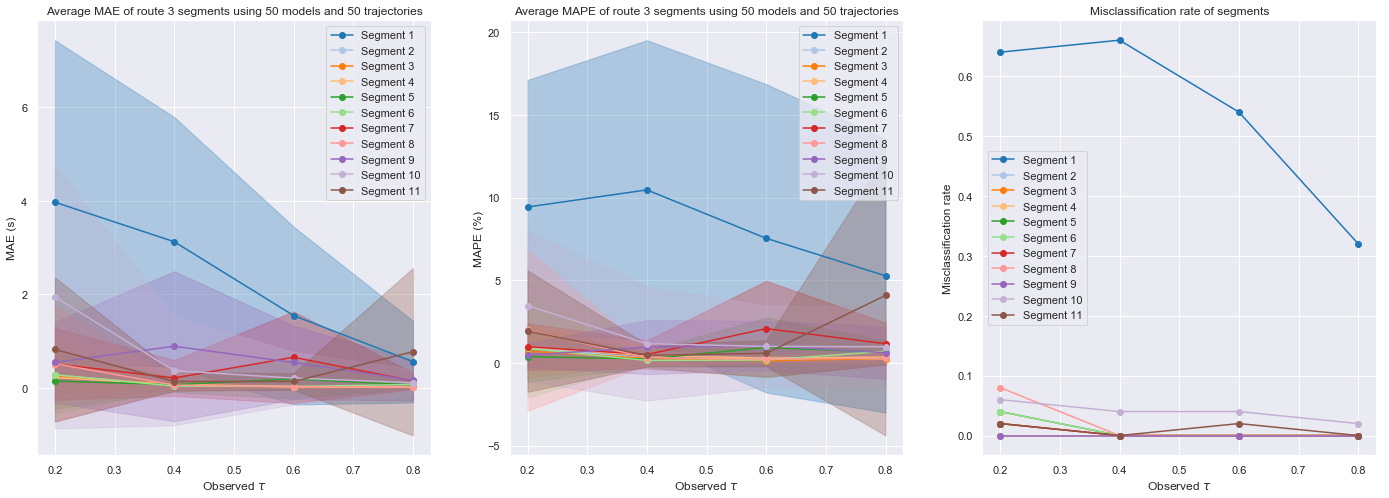

In [50]:
from model.evaluate import evaluate, compute_errors, plot_route_performance
from model.plotting import plot_grid
from model.trajectory_model import most_probable_model_predictor

np.random.seed(1)
f_codomain = ['x', 'y', 'dx', 'dy']
tau_grid = [.2, .4, .6, .8]
model_limit = 50
traj_limit = 50
route_ns = [3]
seg_ns_to_test = train_seg_ids
traj_ns_to_test = [train_traj_ids[traj_n] for traj_n in range(traj_limit)]
#in_sample_traj_ids = frozenset(traj_ids[[-1, 1]])
#in_sample_test_trajs = trajs[(trajs.traj.transform(lambda t: t in in_sample_traj_ids))] # & (trajs.seg == 3)]
#print(in_sample_traj_ids, len(in_sample_test_trajs.traj.unique()))

def in_memory_loader(a, b, c):
    return models

#for route_n in route_ns:
route_n = 3
maes, mapes, misclass = evaluate(
    route_n, tau_grid,
    most_probable_model_predictor,
    load_models, model_limit, 
    in_sample_seg_loader, 
    seg_ns_to_test, traj_ns_to_test 
)
plot_route_performance(
    route_n, model_limit, seg_ns_to_test,
    tau_grid, maes, mapes, misclass
)

(4, 2)


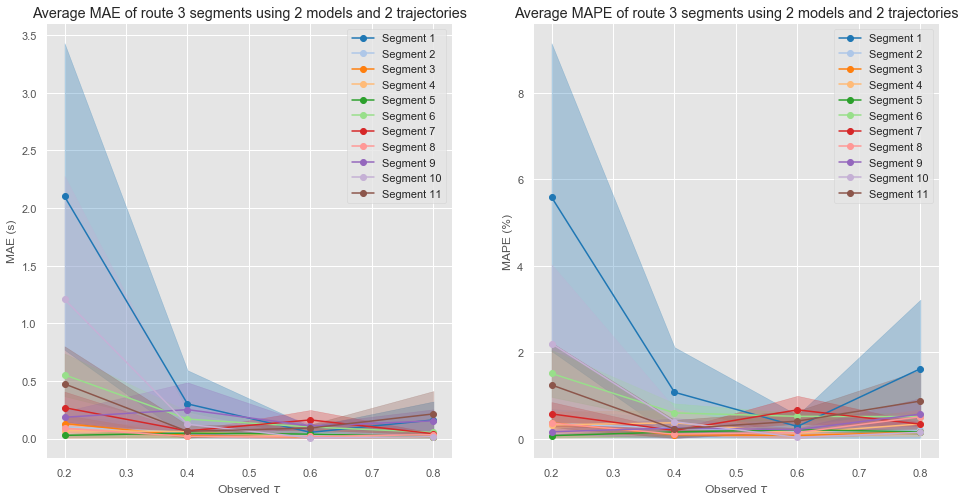

## Out of sample




  0%|                                                                                           | 0/11 [00:00<?, ?it/s] C:\Users\sebas\Anaconda3\envs\gpflow\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 5.907200813293457 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 33
thes guys 1378 51






  2%|█▋                                                                                 | 1/50 [00:01<01:24,  1.73s/it]

most probable is 39
thes guys 1509 113






  4%|███▎                                                                               | 2/50 [00:03<01:16,  1.59s/it]

most probable is 35
thes guys 1453 248






  6%|████▉                                                                              | 3/50 [00:04<01:12,  1.55s/it]

most probable is 48
thes guys 1849 260






  8%|██████▋                                                                            | 4/50 [00:05<01:10,  1.53s/it]

most probable is 41
thes guys 1553 263






 10%|████████▎                                                                          | 5/50 [00:07<01:09,  1.54s/it]

most probable is 0
thes guys 32 266






 12%|█████████▉                                                                         | 6/50 [00:08<01:07,  1.53s/it]

most probable is 19
thes guys 776 296






 14%|███████████▌                                                                       | 7/50 [00:10<01:07,  1.57s/it]

most probable is 30
thes guys 1283 332






 16%|█████████████▎                                                                     | 8/50 [00:12<01:04,  1.55s/it]

most probable is 11
thes guys 392 461






 18%|██████████████▉                                                                    | 9/50 [00:13<01:00,  1.47s/it]

most probable is 35
thes guys 1453 737






 20%|████████████████▍                                                                 | 10/50 [00:15<01:02,  1.57s/it]

most probable is 30
thes guys 1283 778






 22%|██████████████████                                                                | 11/50 [00:16<01:01,  1.57s/it]

most probable is 35
thes guys 1453 894






 24%|███████████████████▋                                                              | 12/50 [00:18<00:55,  1.46s/it]

most probable is 31
thes guys 1354 1068






 26%|█████████████████████▎                                                            | 13/50 [00:19<00:53,  1.45s/it]

most probable is 27
thes guys 1220 1115






 28%|██████████████████████▉                                                           | 14/50 [00:20<00:52,  1.47s/it]

most probable is 3
thes guys 87 1239






 30%|████████████████████████▌                                                         | 15/50 [00:22<00:47,  1.36s/it]

most probable is 31
thes guys 1354 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:23<00:43,  1.28s/it]

most probable is 31
thes guys 1354 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:24<00:41,  1.27s/it]

most probable is 35
thes guys 1453 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:25<00:41,  1.30s/it]

most probable is 15
thes guys 572 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:27<00:40,  1.32s/it]

most probable is 35
thes guys 1453 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:28<00:41,  1.38s/it]

most probable is 35
thes guys 1453 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:30<00:39,  1.37s/it]

most probable is 31
thes guys 1354 2086






 44%|████████████████████████████████████                                              | 22/50 [00:31<00:38,  1.36s/it]

most probable is 14
thes guys 520 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:33<00:40,  1.49s/it]

most probable is 35
thes guys 1453 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:34<00:38,  1.49s/it]

most probable is 31
thes guys 1354 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:36<00:36,  1.46s/it]

most probable is 31
thes guys 1354 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:37<00:34,  1.45s/it]

most probable is 36
thes guys 1476 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:38<00:32,  1.42s/it]

most probable is 35
thes guys 1453 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:40<00:30,  1.39s/it]

most probable is 26
thes guys 1023 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:41<00:28,  1.36s/it]

most probable is 45
thes guys 1734 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:42<00:27,  1.36s/it]

most probable is 15
thes guys 572 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:44<00:25,  1.35s/it]

most probable is 35
thes guys 1453 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:45<00:23,  1.31s/it]

most probable is 24
thes guys 983 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:46<00:22,  1.30s/it]

most probable is 31
thes guys 1354 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:47<00:21,  1.33s/it]

most probable is 35
thes guys 1453 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:49<00:19,  1.31s/it]

most probable is 44
thes guys 1727 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:50<00:17,  1.27s/it]

most probable is 15
thes guys 572 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:51<00:15,  1.22s/it]

most probable is 6
thes guys 245 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:52<00:15,  1.28s/it]

most probable is 27
thes guys 1220 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:54<00:14,  1.28s/it]

most probable is 42
thes guys 1604 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:56<00:14,  1.43s/it]

most probable is 47
thes guys 1773 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:57<00:12,  1.44s/it]

most probable is 15
thes guys 572 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:58<00:11,  1.41s/it]

most probable is 35
thes guys 1453 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:00<00:09,  1.38s/it]

most probable is 47
thes guys 1773 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:01<00:08,  1.43s/it]

most probable is 36
thes guys 1476 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:03<00:07,  1.49s/it]

most probable is 35
thes guys 1453 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:04<00:05,  1.45s/it]

most probable is 42
thes guys 1604 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:06<00:04,  1.50s/it]

most probable is 18
thes guys 709 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:08<00:03,  1.59s/it]

most probable is 22
thes guys 875 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:09<00:01,  1.53s/it]

most probable is 0
thes guys 32 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:10<00:00,  1.50s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 10
thes guys 373 51






  2%|█▋                                                                                 | 1/50 [00:03<02:27,  3.02s/it]

most probable is 49
thes guys 1859 113






  4%|███▎                                                                               | 2/50 [00:05<02:18,  2.89s/it]

most probable is 47
thes guys 1773 248






  6%|████▉                                                                              | 3/50 [00:08<02:17,  2.93s/it]

most probable is 47
thes guys 1773 260






  8%|██████▋                                                                            | 4/50 [00:10<02:06,  2.74s/it]

most probable is 35
thes guys 1453 263






 10%|████████▎                                                                          | 5/50 [00:13<01:56,  2.59s/it]

most probable is 0
thes guys 32 266






 12%|█████████▉                                                                         | 6/50 [00:15<01:48,  2.47s/it]

most probable is 19
thes guys 776 296






 14%|███████████▌                                                                       | 7/50 [00:17<01:45,  2.46s/it]

most probable is 47
thes guys 1773 332






 16%|█████████████▎                                                                     | 8/50 [00:20<01:42,  2.45s/it]

most probable is 44
thes guys 1727 461






 18%|██████████████▉                                                                    | 9/50 [00:22<01:42,  2.50s/it]

most probable is 28
thes guys 1265 737






 20%|████████████████▍                                                                 | 10/50 [00:25<01:40,  2.51s/it]

most probable is 37
thes guys 1488 778






 22%|██████████████████                                                                | 11/50 [00:27<01:36,  2.48s/it]

most probable is 45
thes guys 1734 894






 24%|███████████████████▋                                                              | 12/50 [00:29<01:28,  2.32s/it]

most probable is 36
thes guys 1476 1068






 26%|█████████████████████▎                                                            | 13/50 [00:31<01:25,  2.30s/it]

most probable is 29
thes guys 1278 1115






 28%|██████████████████████▉                                                           | 14/50 [00:34<01:22,  2.29s/it]

most probable is 43
thes guys 1654 1239






 30%|████████████████████████▌                                                         | 15/50 [00:36<01:15,  2.16s/it]

most probable is 45
thes guys 1734 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:37<01:09,  2.05s/it]

most probable is 7
thes guys 251 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:39<01:07,  2.06s/it]

most probable is 29
thes guys 1278 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:42<01:07,  2.11s/it]

most probable is 45
thes guys 1734 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:44<01:04,  2.07s/it]

most probable is 35
thes guys 1453 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:46<01:04,  2.17s/it]

most probable is 37
thes guys 1488 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:48<01:03,  2.18s/it]

most probable is 35
thes guys 1453 2086






 44%|████████████████████████████████████                                              | 22/50 [00:50<00:59,  2.13s/it]

most probable is 37
thes guys 1488 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:53<01:02,  2.31s/it]

most probable is 45
thes guys 1734 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:55<00:59,  2.29s/it]

most probable is 42
thes guys 1604 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:58<00:58,  2.32s/it]

most probable is 35
thes guys 1453 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:00<00:56,  2.36s/it]

most probable is 45
thes guys 1734 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:02<00:52,  2.27s/it]

most probable is 35
thes guys 1453 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:04<00:47,  2.17s/it]

most probable is 45
thes guys 1734 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:06<00:44,  2.12s/it]

most probable is 44
thes guys 1727 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:08<00:43,  2.18s/it]

most probable is 46
thes guys 1769 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:11<00:41,  2.20s/it]

most probable is 35
thes guys 1453 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:13<00:38,  2.15s/it]

most probable is 35
thes guys 1453 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:15<00:35,  2.10s/it]

most probable is 45
thes guys 1734 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:17<00:33,  2.12s/it]

most probable is 45
thes guys 1734 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:19<00:31,  2.09s/it]

most probable is 44
thes guys 1727 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:21<00:29,  2.08s/it]

most probable is 45
thes guys 1734 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:23<00:26,  2.03s/it]

most probable is 19
thes guys 776 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:25<00:26,  2.20s/it]

most probable is 45
thes guys 1734 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:28<00:23,  2.18s/it]

most probable is 45
thes guys 1734 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:30<00:22,  2.24s/it]

most probable is 47
thes guys 1773 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:32<00:20,  2.25s/it]

most probable is 29
thes guys 1278 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:34<00:17,  2.24s/it]

most probable is 35
thes guys 1453 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:36<00:15,  2.19s/it]

most probable is 47
thes guys 1773 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:39<00:13,  2.19s/it]

most probable is 37
thes guys 1488 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:41<00:11,  2.30s/it]

most probable is 45
thes guys 1734 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:44<00:09,  2.29s/it]

most probable is 45
thes guys 1734 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:46<00:07,  2.35s/it]

most probable is 19
thes guys 776 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:49<00:04,  2.46s/it]

most probable is 42
thes guys 1604 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:51<00:02,  2.37s/it]

most probable is 31
thes guys 1354 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:53<00:00,  2.24s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 10
thes guys 373 51






  2%|█▋                                                                                 | 1/50 [00:03<02:42,  3.32s/it]

most probable is 49
thes guys 1859 113






  4%|███▎                                                                               | 2/50 [00:05<02:29,  3.12s/it]

most probable is 29
thes guys 1278 248






  6%|████▉                                                                              | 3/50 [00:09<02:31,  3.23s/it]

most probable is 42
thes guys 1604 260






  8%|██████▋                                                                            | 4/50 [00:12<02:29,  3.25s/it]

most probable is 35
thes guys 1453 263






 10%|████████▎                                                                          | 5/50 [00:15<02:24,  3.21s/it]

most probable is 33
thes guys 1378 266






 12%|█████████▉                                                                         | 6/50 [00:19<02:22,  3.24s/it]

most probable is 19
thes guys 776 296






 14%|███████████▌                                                                       | 7/50 [00:22<02:21,  3.28s/it]

most probable is 29
thes guys 1278 332






 16%|█████████████▎                                                                     | 8/50 [00:25<02:15,  3.23s/it]

most probable is 49
thes guys 1859 461






 18%|██████████████▉                                                                    | 9/50 [00:28<02:08,  3.14s/it]

most probable is 37
thes guys 1488 737






 20%|████████████████▍                                                                 | 10/50 [00:32<02:08,  3.22s/it]

most probable is 37
thes guys 1488 778






 22%|██████████████████                                                                | 11/50 [00:35<02:07,  3.28s/it]

most probable is 45
thes guys 1734 894






 24%|███████████████████▋                                                              | 12/50 [00:38<01:58,  3.12s/it]

most probable is 36
thes guys 1476 1068






 26%|█████████████████████▎                                                            | 13/50 [00:41<01:56,  3.14s/it]

most probable is 29
thes guys 1278 1115






 28%|██████████████████████▉                                                           | 14/50 [00:44<01:52,  3.12s/it]

most probable is 14
thes guys 520 1239






 30%|████████████████████████▌                                                         | 15/50 [00:46<01:42,  2.93s/it]

most probable is 25
thes guys 994 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:49<01:34,  2.78s/it]

most probable is 42
thes guys 1604 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:52<01:32,  2.79s/it]

most probable is 41
thes guys 1553 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:55<01:34,  2.95s/it]

most probable is 45
thes guys 1734 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:58<01:28,  2.84s/it]

most probable is 35
thes guys 1453 1993






 40%|████████████████████████████████▊                                                 | 20/50 [01:01<01:29,  2.99s/it]

most probable is 37
thes guys 1488 2055






 42%|██████████████████████████████████▍                                               | 21/50 [01:04<01:28,  3.04s/it]

most probable is 42
thes guys 1604 2086






 44%|████████████████████████████████████                                              | 22/50 [01:07<01:24,  3.03s/it]

most probable is 37
thes guys 1488 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [01:11<01:28,  3.29s/it]

most probable is 45
thes guys 1734 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:14<01:23,  3.19s/it]

most probable is 35
thes guys 1453 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:17<01:18,  3.16s/it]

most probable is 35
thes guys 1453 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:20<01:16,  3.18s/it]

most probable is 45
thes guys 1734 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:23<01:11,  3.12s/it]

most probable is 35
thes guys 1453 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:26<01:07,  3.05s/it]

most probable is 45
thes guys 1734 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:29<01:02,  3.00s/it]

most probable is 44
thes guys 1727 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:32<01:01,  3.09s/it]

most probable is 35
thes guys 1453 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:36<00:59,  3.12s/it]

most probable is 42
thes guys 1604 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:39<00:55,  3.10s/it]

most probable is 42
thes guys 1604 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:41<00:50,  2.99s/it]

most probable is 35
thes guys 1453 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:45<00:49,  3.08s/it]

most probable is 45
thes guys 1734 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:48<00:45,  3.04s/it]

most probable is 46
thes guys 1769 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:50<00:41,  2.99s/it]

most probable is 45
thes guys 1734 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:53<00:37,  2.88s/it]

most probable is 19
thes guys 776 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:57<00:36,  3.08s/it]

most probable is 45
thes guys 1734 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:00<00:33,  3.04s/it]

most probable is 45
thes guys 1734 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:03<00:31,  3.10s/it]

most probable is 47
thes guys 1773 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:06<00:27,  3.02s/it]

most probable is 48
thes guys 1849 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:08<00:23,  2.93s/it]

most probable is 35
thes guys 1453 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:12<00:21,  3.11s/it]

most probable is 40
thes guys 1546 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:15<00:18,  3.14s/it]

most probable is 19
thes guys 776 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:19<00:16,  3.37s/it]

most probable is 15
thes guys 572 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:22<00:12,  3.24s/it]

most probable is 45
thes guys 1734 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:26<00:10,  3.43s/it]

most probable is 19
thes guys 776 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:30<00:07,  3.54s/it]

most probable is 42
thes guys 1604 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:33<00:03,  3.47s/it]

most probable is 31
thes guys 1354 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:36<00:00,  3.32s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 10
thes guys 373 51






  2%|█▋                                                                                 | 1/50 [00:04<03:31,  4.31s/it]

most probable is 49
thes guys 1859 113






  4%|███▎                                                                               | 2/50 [00:07<03:14,  4.04s/it]

most probable is 35
thes guys 1453 248






  6%|████▉                                                                              | 3/50 [00:12<03:15,  4.16s/it]

most probable is 42
thes guys 1604 260






  8%|██████▋                                                                            | 4/50 [00:15<03:03,  3.99s/it]

most probable is 35
thes guys 1453 263






 10%|████████▎                                                                          | 5/50 [00:19<03:00,  4.00s/it]

most probable is 29
thes guys 1278 266






 12%|█████████▉                                                                         | 6/50 [00:23<02:53,  3.93s/it]

most probable is 19
thes guys 776 296






 14%|███████████▌                                                                       | 7/50 [00:28<02:56,  4.10s/it]

most probable is 29
thes guys 1278 332






 16%|█████████████▎                                                                     | 8/50 [00:32<02:51,  4.08s/it]

most probable is 49
thes guys 1859 461






 18%|██████████████▉                                                                    | 9/50 [00:35<02:42,  3.96s/it]

most probable is 4
thes guys 147 737






 20%|████████████████▍                                                                 | 10/50 [00:40<02:43,  4.08s/it]

most probable is 37
thes guys 1488 778






 22%|██████████████████                                                                | 11/50 [00:44<02:43,  4.20s/it]

most probable is 42
thes guys 1604 894






 24%|███████████████████▋                                                              | 12/50 [00:48<02:32,  4.02s/it]

most probable is 36
thes guys 1476 1068






 26%|█████████████████████▎                                                            | 13/50 [00:52<02:28,  4.01s/it]

most probable is 48
thes guys 1849 1115






 28%|██████████████████████▉                                                           | 14/50 [00:56<02:22,  3.96s/it]

most probable is 14
thes guys 520 1239






 30%|████████████████████████▌                                                         | 15/50 [00:59<02:12,  3.78s/it]

most probable is 14
thes guys 520 1321






 32%|██████████████████████████▏                                                       | 16/50 [01:02<02:01,  3.58s/it]

most probable is 42
thes guys 1604 1386






 34%|███████████████████████████▉                                                      | 17/50 [01:06<01:58,  3.60s/it]

most probable is 41
thes guys 1553 1468






 36%|█████████████████████████████▌                                                    | 18/50 [01:10<02:00,  3.77s/it]

most probable is 9
thes guys 303 1690






 38%|███████████████████████████████▏                                                  | 19/50 [01:13<01:51,  3.61s/it]

most probable is 19
thes guys 776 1993






 40%|████████████████████████████████▊                                                 | 20/50 [01:18<01:56,  3.88s/it]

most probable is 8
thes guys 299 2055






 42%|██████████████████████████████████▍                                               | 21/50 [01:22<01:55,  3.99s/it]

most probable is 42
thes guys 1604 2086






 44%|████████████████████████████████████                                              | 22/50 [01:26<01:49,  3.92s/it]

most probable is 37
thes guys 1488 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [01:30<01:51,  4.12s/it]

most probable is 45
thes guys 1734 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:34<01:48,  4.19s/it]

most probable is 35
thes guys 1453 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:39<01:46,  4.26s/it]

most probable is 35
thes guys 1453 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:43<01:41,  4.24s/it]

most probable is 45
thes guys 1734 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:47<01:35,  4.16s/it]

most probable is 42
thes guys 1604 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:51<01:29,  4.06s/it]

most probable is 42
thes guys 1604 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:55<01:22,  3.95s/it]

most probable is 44
thes guys 1727 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:59<01:21,  4.07s/it]

most probable is 35
thes guys 1453 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [02:03<01:19,  4.20s/it]

most probable is 42
thes guys 1604 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [02:07<01:12,  4.01s/it]

most probable is 42
thes guys 1604 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [02:10<01:05,  3.84s/it]

most probable is 35
thes guys 1453 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [02:14<01:02,  3.88s/it]

most probable is 2
thes guys 68 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [02:18<00:58,  3.89s/it]

most probable is 46
thes guys 1769 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:22<00:53,  3.85s/it]

most probable is 45
thes guys 1734 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:26<00:48,  3.75s/it]

most probable is 19
thes guys 776 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:31<00:49,  4.10s/it]

most probable is 47
thes guys 1773 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:34<00:43,  3.95s/it]

most probable is 45
thes guys 1734 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:39<00:40,  4.08s/it]

most probable is 46
thes guys 1769 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:42<00:35,  3.98s/it]

most probable is 48
thes guys 1849 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:46<00:31,  3.91s/it]

most probable is 42
thes guys 1604 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:50<00:27,  3.91s/it]

most probable is 35
thes guys 1453 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:54<00:23,  3.91s/it]

most probable is 38
thes guys 1503 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:59<00:21,  4.20s/it]

most probable is 15
thes guys 572 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [03:02<00:16,  4.07s/it]

most probable is 45
thes guys 1734 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [03:07<00:12,  4.17s/it]

most probable is 19
thes guys 776 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [03:12<00:08,  4.33s/it]

most probable is 42
thes guys 1604 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [03:15<00:04,  4.20s/it]

most probable is 31
thes guys 1354 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:19<00:00,  4.01s/it]






  9%|███████▎                                                                        | 1/11 [09:06<1:31:00, 546.06s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 5.564117670059204 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 12
thes guys 395 51






  2%|█▋                                                                                 | 1/50 [00:01<00:50,  1.03s/it]

most probable is 48
thes guys 1849 113






  4%|███▎                                                                               | 2/50 [00:01<00:44,  1.07it/s]

most probable is 42
thes guys 1604 248






  6%|████▉                                                                              | 3/50 [00:02<00:43,  1.09it/s]

most probable is 35
thes guys 1453 260






  8%|██████▋                                                                            | 4/50 [00:03<00:40,  1.14it/s]

most probable is 12
thes guys 395 263






 10%|████████▎                                                                          | 5/50 [00:04<00:41,  1.09it/s]

most probable is 21
thes guys 870 266






 12%|█████████▉                                                                         | 6/50 [00:05<00:39,  1.13it/s]

most probable is 21
thes guys 870 296






 14%|███████████▌                                                                       | 7/50 [00:06<00:40,  1.05it/s]

most probable is 15
thes guys 572 332






 16%|█████████████▎                                                                     | 8/50 [00:07<00:39,  1.07it/s]

most probable is 38
thes guys 1503 461






 18%|██████████████▉                                                                    | 9/50 [00:08<00:37,  1.08it/s]

most probable is 30
thes guys 1283 737






 20%|████████████████▍                                                                 | 10/50 [00:09<00:39,  1.02it/s]

most probable is 0
thes guys 32 778






 22%|██████████████████                                                                | 11/50 [00:10<00:40,  1.05s/it]

most probable is 41
thes guys 1553 894






 24%|███████████████████▋                                                              | 12/50 [00:11<00:36,  1.03it/s]

most probable is 32
thes guys 1363 1068






 26%|█████████████████████▎                                                            | 13/50 [00:12<00:35,  1.03it/s]

most probable is 19
thes guys 776 1115






 28%|██████████████████████▉                                                           | 14/50 [00:13<00:35,  1.02it/s]

most probable is 8
thes guys 299 1239






 30%|████████████████████████▌                                                         | 15/50 [00:14<00:32,  1.08it/s]

most probable is 29
thes guys 1278 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:14<00:30,  1.12it/s]

most probable is 38
thes guys 1503 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:15<00:30,  1.09it/s]

most probable is 35
thes guys 1453 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:16<00:29,  1.08it/s]

most probable is 48
thes guys 1849 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:17<00:25,  1.21it/s]

most probable is 37
thes guys 1488 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:18<00:24,  1.24it/s]

most probable is 42
thes guys 1604 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:19<00:24,  1.20it/s]

most probable is 41
thes guys 1553 2086






 44%|████████████████████████████████████                                              | 22/50 [00:19<00:22,  1.26it/s]

most probable is 44
thes guys 1727 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:20<00:22,  1.22it/s]

most probable is 44
thes guys 1727 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:21<00:21,  1.19it/s]

most probable is 2
thes guys 68 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:22<00:21,  1.17it/s]

most probable is 2
thes guys 68 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:23<00:20,  1.16it/s]

most probable is 4
thes guys 147 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:24<00:19,  1.19it/s]

most probable is 13
thes guys 398 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:24<00:18,  1.16it/s]

most probable is 43
thes guys 1654 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:25<00:18,  1.15it/s]

most probable is 2
thes guys 68 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:26<00:17,  1.13it/s]

most probable is 35
thes guys 1453 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:27<00:16,  1.13it/s]

most probable is 48
thes guys 1849 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:28<00:15,  1.20it/s]

most probable is 48
thes guys 1849 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:29<00:13,  1.26it/s]

most probable is 30
thes guys 1283 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:29<00:13,  1.19it/s]

most probable is 44
thes guys 1727 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:30<00:12,  1.15it/s]

most probable is 43
thes guys 1654 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:31<00:11,  1.17it/s]

most probable is 48
thes guys 1849 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:32<00:10,  1.25it/s]

most probable is 6
thes guys 245 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:33<00:10,  1.11it/s]

most probable is 44
thes guys 1727 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:34<00:10,  1.09it/s]

most probable is 33
thes guys 1378 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:35<00:09,  1.11it/s]

most probable is 18
thes guys 709 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:36<00:08,  1.11it/s]

most probable is 14
thes guys 520 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:37<00:07,  1.12it/s]

most probable is 32
thes guys 1363 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:38<00:06,  1.03it/s]

most probable is 44
thes guys 1727 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:39<00:05,  1.06it/s]

most probable is 30
thes guys 1283 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:40<00:04,  1.04it/s]

most probable is 27
thes guys 1220 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:40<00:03,  1.14it/s]

most probable is 30
thes guys 1283 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:41<00:02,  1.12it/s]

most probable is 37
thes guys 1488 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:42<00:01,  1.15it/s]

most probable is 43
thes guys 1654 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:43<00:00,  1.11it/s]

most probable is 4
thes guys 147 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:44<00:00,  1.16it/s]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 46
thes guys 1769 51






  2%|█▋                                                                                 | 1/50 [00:01<01:36,  1.97s/it]

most probable is 48
thes guys 1849 113






  4%|███▎                                                                               | 2/50 [00:03<01:22,  1.72s/it]

most probable is 15
thes guys 572 248






  6%|████▉                                                                              | 3/50 [00:04<01:17,  1.65s/it]

most probable is 35
thes guys 1453 260






  8%|██████▋                                                                            | 4/50 [00:06<01:15,  1.63s/it]

most probable is 12
thes guys 395 263






 10%|████████▎                                                                          | 5/50 [00:07<01:13,  1.64s/it]

most probable is 21
thes guys 870 266






 12%|█████████▉                                                                         | 6/50 [00:09<01:09,  1.57s/it]

most probable is 36
thes guys 1476 296






 14%|███████████▌                                                                       | 7/50 [00:11<01:11,  1.65s/it]

most probable is 15
thes guys 572 332






 16%|█████████████▎                                                                     | 8/50 [00:12<01:07,  1.60s/it]

most probable is 40
thes guys 1546 461






 18%|██████████████▉                                                                    | 9/50 [00:14<01:06,  1.62s/it]

most probable is 14
thes guys 520 737






 20%|████████████████▍                                                                 | 10/50 [00:16<01:07,  1.69s/it]

most probable is 0
thes guys 32 778






 22%|██████████████████                                                                | 11/50 [00:17<01:07,  1.73s/it]

most probable is 41
thes guys 1553 894






 24%|███████████████████▋                                                              | 12/50 [00:19<01:01,  1.61s/it]

most probable is 32
thes guys 1363 1068






 26%|█████████████████████▎                                                            | 13/50 [00:20<01:00,  1.65s/it]

most probable is 30
thes guys 1283 1115






 28%|██████████████████████▉                                                           | 14/50 [00:22<00:59,  1.65s/it]

most probable is 34
thes guys 1388 1239






 30%|████████████████████████▌                                                         | 15/50 [00:24<00:55,  1.59s/it]

most probable is 29
thes guys 1278 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:25<00:51,  1.52s/it]

most probable is 46
thes guys 1769 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:27<00:52,  1.60s/it]

most probable is 35
thes guys 1453 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:29<00:55,  1.74s/it]

most probable is 48
thes guys 1849 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:30<00:47,  1.54s/it]

most probable is 37
thes guys 1488 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:31<00:44,  1.47s/it]

most probable is 46
thes guys 1769 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:33<00:44,  1.53s/it]

most probable is 20
thes guys 833 2086






 44%|████████████████████████████████████                                              | 22/50 [00:34<00:40,  1.44s/it]

most probable is 14
thes guys 520 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:36<00:40,  1.51s/it]

most probable is 44
thes guys 1727 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:37<00:39,  1.51s/it]

most probable is 14
thes guys 520 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:39<00:38,  1.53s/it]

most probable is 11
thes guys 392 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:40<00:36,  1.54s/it]

most probable is 20
thes guys 833 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:42<00:33,  1.46s/it]

most probable is 13
thes guys 398 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:43<00:33,  1.54s/it]

most probable is 30
thes guys 1283 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:45<00:32,  1.53s/it]

most probable is 11
thes guys 392 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:47<00:32,  1.62s/it]

most probable is 35
thes guys 1453 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:48<00:30,  1.62s/it]

most probable is 48
thes guys 1849 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:50<00:26,  1.50s/it]

most probable is 48
thes guys 1849 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:51<00:23,  1.39s/it]

most probable is 30
thes guys 1283 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:52<00:23,  1.45s/it]

most probable is 40
thes guys 1546 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:54<00:22,  1.50s/it]

most probable is 13
thes guys 398 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:55<00:20,  1.47s/it]

most probable is 48
thes guys 1849 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:57<00:18,  1.39s/it]

most probable is 6
thes guys 245 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:58<00:18,  1.55s/it]

most probable is 36
thes guys 1476 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:00<00:16,  1.53s/it]

most probable is 35
thes guys 1453 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:01<00:15,  1.55s/it]

most probable is 38
thes guys 1503 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:03<00:13,  1.55s/it]

most probable is 14
thes guys 520 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:05<00:12,  1.61s/it]

most probable is 40
thes guys 1546 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:06<00:11,  1.63s/it]

most probable is 0
thes guys 32 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:08<00:09,  1.60s/it]

most probable is 30
thes guys 1283 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:10<00:08,  1.62s/it]

most probable is 2
thes guys 68 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:11<00:05,  1.48s/it]

most probable is 30
thes guys 1283 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:12<00:04,  1.52s/it]

most probable is 37
thes guys 1488 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:14<00:02,  1.46s/it]

most probable is 30
thes guys 1283 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:16<00:01,  1.56s/it]

most probable is 4
thes guys 147 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:17<00:00,  1.48s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 46
thes guys 1769 51






  2%|█▋                                                                                 | 1/50 [00:02<01:50,  2.26s/it]

most probable is 49
thes guys 1859 113






  4%|███▎                                                                               | 2/50 [00:04<01:42,  2.13s/it]

most probable is 27
thes guys 1220 248






  6%|████▉                                                                              | 3/50 [00:06<01:40,  2.14s/it]

most probable is 23
thes guys 942 260






  8%|██████▋                                                                            | 4/50 [00:08<01:39,  2.16s/it]

most probable is 35
thes guys 1453 263






 10%|████████▎                                                                          | 5/50 [00:11<01:43,  2.30s/it]

most probable is 32
thes guys 1363 266






 12%|█████████▉                                                                         | 6/50 [00:13<01:39,  2.25s/it]

most probable is 36
thes guys 1476 296






 14%|███████████▌                                                                       | 7/50 [00:15<01:42,  2.38s/it]

most probable is 15
thes guys 572 332






 16%|█████████████▎                                                                     | 8/50 [00:18<01:36,  2.30s/it]

most probable is 40
thes guys 1546 461






 18%|██████████████▉                                                                    | 9/50 [00:20<01:34,  2.30s/it]

most probable is 46
thes guys 1769 737






 20%|████████████████▍                                                                 | 10/50 [00:22<01:36,  2.41s/it]

most probable is 40
thes guys 1546 778






 22%|██████████████████                                                                | 11/50 [00:25<01:38,  2.52s/it]

most probable is 41
thes guys 1553 894






 24%|███████████████████▋                                                              | 12/50 [00:27<01:30,  2.39s/it]

most probable is 32
thes guys 1363 1068






 26%|█████████████████████▎                                                            | 13/50 [00:30<01:27,  2.38s/it]

most probable is 7
thes guys 251 1115






 28%|██████████████████████▉                                                           | 14/50 [00:32<01:22,  2.30s/it]

most probable is 47
thes guys 1773 1239






 30%|████████████████████████▌                                                         | 15/50 [00:34<01:19,  2.26s/it]

most probable is 29
thes guys 1278 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:36<01:13,  2.16s/it]

most probable is 40
thes guys 1546 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:38<01:12,  2.19s/it]

most probable is 35
thes guys 1453 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:40<01:11,  2.22s/it]

most probable is 48
thes guys 1849 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:42<01:01,  1.98s/it]

most probable is 41
thes guys 1553 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:44<00:58,  1.94s/it]

most probable is 40
thes guys 1546 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:46<00:59,  2.04s/it]

most probable is 20
thes guys 833 2086






 44%|████████████████████████████████████                                              | 22/50 [00:48<00:54,  1.96s/it]

most probable is 14
thes guys 520 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:50<00:55,  2.05s/it]

most probable is 44
thes guys 1727 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:53<00:59,  2.29s/it]

most probable is 10
thes guys 373 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:55<00:57,  2.29s/it]

most probable is 30
thes guys 1283 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:58<00:57,  2.41s/it]

most probable is 20
thes guys 833 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:00<00:54,  2.37s/it]

most probable is 30
thes guys 1283 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:03<00:55,  2.51s/it]

most probable is 30
thes guys 1283 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:05<00:52,  2.51s/it]

most probable is 46
thes guys 1769 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:08<00:51,  2.56s/it]

most probable is 35
thes guys 1453 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:11<00:48,  2.53s/it]

most probable is 48
thes guys 1849 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:13<00:43,  2.42s/it]

most probable is 48
thes guys 1849 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:15<00:37,  2.23s/it]

most probable is 30
thes guys 1283 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:17<00:35,  2.23s/it]

most probable is 40
thes guys 1546 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:19<00:35,  2.35s/it]

most probable is 13
thes guys 398 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:22<00:31,  2.27s/it]

most probable is 48
thes guys 1849 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:23<00:28,  2.17s/it]

most probable is 24
thes guys 983 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:27<00:29,  2.49s/it]

most probable is 44
thes guys 1727 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:29<00:27,  2.49s/it]

most probable is 35
thes guys 1453 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:31<00:24,  2.44s/it]

most probable is 38
thes guys 1503 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:34<00:21,  2.40s/it]

most probable is 30
thes guys 1283 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:36<00:18,  2.36s/it]

most probable is 33
thes guys 1378 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:38<00:16,  2.37s/it]

most probable is 0
thes guys 32 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:41<00:13,  2.32s/it]

most probable is 35
thes guys 1453 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:43<00:12,  2.41s/it]

most probable is 2
thes guys 68 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:45<00:08,  2.20s/it]

most probable is 30
thes guys 1283 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:47<00:06,  2.27s/it]

most probable is 37
thes guys 1488 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:50<00:04,  2.23s/it]

most probable is 40
thes guys 1546 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:52<00:02,  2.26s/it]

most probable is 41
thes guys 1553 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:54<00:00,  2.16s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 46
thes guys 1769 51






  2%|█▋                                                                                 | 1/50 [00:03<02:32,  3.11s/it]

most probable is 49
thes guys 1859 113






  4%|███▎                                                                               | 2/50 [00:05<02:18,  2.88s/it]

most probable is 42
thes guys 1604 248






  6%|████▉                                                                              | 3/50 [00:08<02:19,  2.97s/it]

most probable is 23
thes guys 942 260






  8%|██████▋                                                                            | 4/50 [00:11<02:14,  2.93s/it]

most probable is 12
thes guys 395 263






 10%|████████▎                                                                          | 5/50 [00:14<02:17,  3.06s/it]

most probable is 32
thes guys 1363 266






 12%|█████████▉                                                                         | 6/50 [00:18<02:17,  3.13s/it]

most probable is 36
thes guys 1476 296






 14%|███████████▌                                                                       | 7/50 [00:22<02:27,  3.43s/it]

most probable is 32
thes guys 1363 332






 16%|█████████████▎                                                                     | 8/50 [00:25<02:22,  3.40s/it]

most probable is 14
thes guys 520 461






 18%|██████████████▉                                                                    | 9/50 [00:28<02:13,  3.25s/it]

most probable is 44
thes guys 1727 737






 20%|████████████████▍                                                                 | 10/50 [00:31<02:11,  3.29s/it]

most probable is 21
thes guys 870 778






 22%|██████████████████                                                                | 11/50 [00:35<02:08,  3.28s/it]

most probable is 41
thes guys 1553 894






 24%|███████████████████▋                                                              | 12/50 [00:37<01:55,  3.04s/it]

most probable is 30
thes guys 1283 1068






 26%|█████████████████████▎                                                            | 13/50 [00:40<01:54,  3.11s/it]

most probable is 30
thes guys 1283 1115






 28%|██████████████████████▉                                                           | 14/50 [00:44<01:52,  3.14s/it]

most probable is 2
thes guys 68 1239






 30%|████████████████████████▌                                                         | 15/50 [00:47<01:49,  3.14s/it]

most probable is 29
thes guys 1278 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:49<01:40,  2.95s/it]

most probable is 5
thes guys 168 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:52<01:39,  3.03s/it]

most probable is 35
thes guys 1453 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:55<01:36,  3.03s/it]

most probable is 49
thes guys 1859 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:57<01:23,  2.68s/it]

most probable is 41
thes guys 1553 1993






 40%|████████████████████████████████▊                                                 | 20/50 [01:00<01:17,  2.57s/it]

most probable is 40
thes guys 1546 2055






 42%|██████████████████████████████████▍                                               | 21/50 [01:03<01:19,  2.74s/it]

most probable is 20
thes guys 833 2086






 44%|████████████████████████████████████                                              | 22/50 [01:05<01:13,  2.62s/it]

most probable is 14
thes guys 520 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [01:08<01:11,  2.65s/it]

most probable is 40
thes guys 1546 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:11<01:10,  2.71s/it]

most probable is 10
thes guys 373 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:14<01:09,  2.77s/it]

most probable is 30
thes guys 1283 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:17<01:10,  2.95s/it]

most probable is 20
thes guys 833 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:20<01:07,  2.92s/it]

most probable is 34
thes guys 1388 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:23<01:05,  2.99s/it]

most probable is 30
thes guys 1283 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:27<01:06,  3.14s/it]

most probable is 46
thes guys 1769 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:30<01:02,  3.13s/it]

most probable is 35
thes guys 1453 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:33<00:58,  3.09s/it]

most probable is 20
thes guys 833 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:35<00:51,  2.87s/it]

most probable is 48
thes guys 1849 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:37<00:45,  2.69s/it]

most probable is 30
thes guys 1283 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:41<00:46,  2.90s/it]

most probable is 40
thes guys 1546 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:44<00:45,  3.03s/it]

most probable is 13
thes guys 398 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:47<00:41,  2.93s/it]

most probable is 20
thes guys 833 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:49<00:35,  2.74s/it]

most probable is 33
thes guys 1378 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:53<00:37,  3.09s/it]

most probable is 40
thes guys 1546 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:56<00:33,  3.02s/it]

most probable is 30
thes guys 1283 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:58<00:29,  2.93s/it]

most probable is 23
thes guys 942 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:01<00:25,  2.86s/it]

most probable is 14
thes guys 520 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:04<00:22,  2.82s/it]

most probable is 33
thes guys 1378 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:07<00:20,  2.87s/it]

most probable is 14
thes guys 520 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:10<00:17,  2.85s/it]

most probable is 35
thes guys 1453 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:13<00:14,  2.95s/it]

most probable is 2
thes guys 68 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:15<00:11,  2.78s/it]

most probable is 7
thes guys 251 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:19<00:09,  3.01s/it]

most probable is 41
thes guys 1553 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:21<00:05,  2.82s/it]

most probable is 40
thes guys 1546 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:24<00:02,  2.89s/it]

most probable is 41
thes guys 1553 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:27<00:00,  2.78s/it]






 18%|██████████████▌                                                                 | 2/11 [15:34<1:14:49, 498.87s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 5.595034599304199 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 36
thes guys 1476 51






  2%|█▋                                                                                 | 1/50 [00:01<00:59,  1.22s/it]

most probable is 16
thes guys 639 113






  4%|███▎                                                                               | 2/50 [00:02<00:55,  1.15s/it]

most probable is 2
thes guys 68 248






  6%|████▉                                                                              | 3/50 [00:03<00:52,  1.13s/it]

most probable is 30
thes guys 1283 260






  8%|██████▋                                                                            | 4/50 [00:04<00:50,  1.09s/it]

most probable is 16
thes guys 639 263






 10%|████████▎                                                                          | 5/50 [00:05<00:49,  1.09s/it]

most probable is 26
thes guys 1023 266






 12%|█████████▉                                                                         | 6/50 [00:06<00:45,  1.03s/it]

most probable is 35
thes guys 1453 296






 14%|███████████▌                                                                       | 7/50 [00:07<00:46,  1.07s/it]

most probable is 32
thes guys 1363 332






 16%|█████████████▎                                                                     | 8/50 [00:08<00:43,  1.05s/it]

most probable is 15
thes guys 572 461






 18%|██████████████▉                                                                    | 9/50 [00:09<00:42,  1.04s/it]

most probable is 39
thes guys 1509 737






 20%|████████████████▍                                                                 | 10/50 [00:10<00:40,  1.02s/it]

most probable is 35
thes guys 1453 778






 22%|██████████████████                                                                | 11/50 [00:11<00:41,  1.07s/it]

most probable is 10
thes guys 373 894






 24%|███████████████████▋                                                              | 12/50 [00:12<00:41,  1.08s/it]

most probable is 13
thes guys 398 1068






 26%|█████████████████████▎                                                            | 13/50 [00:13<00:40,  1.11s/it]

most probable is 34
thes guys 1388 1115






 28%|██████████████████████▉                                                           | 14/50 [00:14<00:38,  1.07s/it]

most probable is 36
thes guys 1476 1239






 30%|████████████████████████▌                                                         | 15/50 [00:15<00:35,  1.02s/it]

most probable is 35
thes guys 1453 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:16<00:34,  1.00s/it]

most probable is 8
thes guys 299 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:17<00:33,  1.01s/it]

most probable is 10
thes guys 373 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:18<00:33,  1.04s/it]

most probable is 2
thes guys 68 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:19<00:30,  1.01it/s]

most probable is 41
thes guys 1553 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:20<00:30,  1.01s/it]

most probable is 22
thes guys 875 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:21<00:30,  1.03s/it]

most probable is 2
thes guys 68 2086






 44%|████████████████████████████████████                                              | 22/50 [00:22<00:28,  1.01s/it]

most probable is 37
thes guys 1488 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:23<00:28,  1.04s/it]

most probable is 35
thes guys 1453 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:25<00:27,  1.06s/it]

most probable is 4
thes guys 147 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:26<00:27,  1.09s/it]

most probable is 39
thes guys 1509 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:27<00:26,  1.12s/it]

most probable is 16
thes guys 639 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:28<00:25,  1.10s/it]

most probable is 12
thes guys 395 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:29<00:23,  1.07s/it]

most probable is 23
thes guys 942 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:30<00:22,  1.05s/it]

most probable is 25
thes guys 994 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:31<00:20,  1.01s/it]

most probable is 39
thes guys 1509 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:32<00:20,  1.05s/it]

most probable is 2
thes guys 68 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:33<00:19,  1.06s/it]

most probable is 2
thes guys 68 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:34<00:17,  1.05s/it]

most probable is 35
thes guys 1453 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:35<00:17,  1.11s/it]

most probable is 6
thes guys 245 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:37<00:17,  1.16s/it]

most probable is 22
thes guys 875 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:38<00:17,  1.25s/it]

most probable is 14
thes guys 520 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:39<00:16,  1.24s/it]

most probable is 10
thes guys 373 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:40<00:14,  1.22s/it]

most probable is 24
thes guys 983 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:42<00:12,  1.18s/it]

most probable is 28
thes guys 1265 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:43<00:11,  1.11s/it]

most probable is 48
thes guys 1849 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:43<00:09,  1.04s/it]

most probable is 32
thes guys 1363 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:44<00:08,  1.02s/it]

most probable is 2
thes guys 68 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:45<00:07,  1.02s/it]

most probable is 23
thes guys 942 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:47<00:06,  1.08s/it]

most probable is 2
thes guys 68 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:48<00:05,  1.15s/it]

most probable is 11
thes guys 392 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:49<00:04,  1.04s/it]

most probable is 23
thes guys 942 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:50<00:03,  1.05s/it]

most probable is 30
thes guys 1283 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:51<00:02,  1.03s/it]

most probable is 37
thes guys 1488 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:52<00:01,  1.15s/it]

most probable is 49
thes guys 1859 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:53<00:00,  1.11s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 36
thes guys 1476 51






  2%|█▋                                                                                 | 1/50 [00:02<01:43,  2.12s/it]

most probable is 23
thes guys 942 113






  4%|███▎                                                                               | 2/50 [00:03<01:37,  2.03s/it]

most probable is 36
thes guys 1476 248






  6%|████▉                                                                              | 3/50 [00:06<01:38,  2.10s/it]

most probable is 41
thes guys 1553 260






  8%|██████▋                                                                            | 4/50 [00:07<01:32,  2.01s/it]

most probable is 16
thes guys 639 263






 10%|████████▎                                                                          | 5/50 [00:09<01:28,  1.97s/it]

most probable is 26
thes guys 1023 266






 12%|█████████▉                                                                         | 6/50 [00:11<01:20,  1.84s/it]

most probable is 35
thes guys 1453 296






 14%|███████████▌                                                                       | 7/50 [00:13<01:21,  1.90s/it]

most probable is 32
thes guys 1363 332






 16%|█████████████▎                                                                     | 8/50 [00:15<01:16,  1.83s/it]

most probable is 23
thes guys 942 461






 18%|██████████████▉                                                                    | 9/50 [00:16<01:14,  1.81s/it]

most probable is 39
thes guys 1509 737






 20%|████████████████▍                                                                 | 10/50 [00:18<01:12,  1.82s/it]

most probable is 36
thes guys 1476 778






 22%|██████████████████                                                                | 11/50 [00:20<01:11,  1.84s/it]

most probable is 34
thes guys 1388 894






 24%|███████████████████▋                                                              | 12/50 [00:22<01:10,  1.86s/it]

most probable is 13
thes guys 398 1068






 26%|█████████████████████▎                                                            | 13/50 [00:24<01:08,  1.85s/it]

most probable is 34
thes guys 1388 1115






 28%|██████████████████████▉                                                           | 14/50 [00:26<01:04,  1.79s/it]

most probable is 2
thes guys 68 1239






 30%|████████████████████████▌                                                         | 15/50 [00:27<00:59,  1.71s/it]

most probable is 16
thes guys 639 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:29<00:58,  1.72s/it]

most probable is 23
thes guys 942 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:31<00:57,  1.74s/it]

most probable is 10
thes guys 373 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:33<00:57,  1.80s/it]

most probable is 2
thes guys 68 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:34<00:53,  1.74s/it]

most probable is 41
thes guys 1553 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:36<00:53,  1.78s/it]

most probable is 5
thes guys 168 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:38<00:52,  1.83s/it]

most probable is 21
thes guys 870 2086






 44%|████████████████████████████████████                                              | 22/50 [00:40<00:49,  1.78s/it]

most probable is 37
thes guys 1488 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:41<00:48,  1.79s/it]

most probable is 15
thes guys 572 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:43<00:46,  1.81s/it]

most probable is 35
thes guys 1453 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:45<00:46,  1.86s/it]

most probable is 6
thes guys 245 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:47<00:45,  1.90s/it]

most probable is 44
thes guys 1727 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:49<00:43,  1.91s/it]

most probable is 36
thes guys 1476 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:51<00:43,  1.99s/it]

most probable is 23
thes guys 942 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:53<00:42,  2.01s/it]

most probable is 25
thes guys 994 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:55<00:37,  1.88s/it]

most probable is 39
thes guys 1509 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:57<00:34,  1.82s/it]

most probable is 15
thes guys 572 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:58<00:32,  1.82s/it]

most probable is 2
thes guys 68 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:00<00:30,  1.77s/it]

most probable is 35
thes guys 1453 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:02<00:28,  1.80s/it]

most probable is 6
thes guys 245 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:04<00:27,  1.81s/it]

most probable is 24
thes guys 983 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:06<00:27,  1.95s/it]

most probable is 34
thes guys 1388 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:08<00:25,  1.96s/it]

most probable is 10
thes guys 373 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:10<00:23,  1.92s/it]

most probable is 44
thes guys 1727 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:12<00:20,  1.90s/it]

most probable is 28
thes guys 1265 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:13<00:18,  1.83s/it]

most probable is 46
thes guys 1769 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:15<00:15,  1.72s/it]

most probable is 5
thes guys 168 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:17<00:13,  1.73s/it]

most probable is 34
thes guys 1388 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:18<00:12,  1.74s/it]

most probable is 38
thes guys 1503 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:20<00:10,  1.78s/it]

most probable is 38
thes guys 1503 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:22<00:09,  1.88s/it]

most probable is 11
thes guys 392 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:24<00:06,  1.71s/it]

most probable is 38
thes guys 1503 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:26<00:05,  1.78s/it]

most probable is 30
thes guys 1283 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:27<00:03,  1.74s/it]

most probable is 37
thes guys 1488 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:30<00:01,  1.94s/it]

most probable is 15
thes guys 572 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:31<00:00,  1.88s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 36
thes guys 1476 51






  2%|█▋                                                                                 | 1/50 [00:02<02:17,  2.80s/it]

most probable is 23
thes guys 942 113






  4%|███▎                                                                               | 2/50 [00:05<02:09,  2.69s/it]

most probable is 36
thes guys 1476 248






  6%|████▉                                                                              | 3/50 [00:07<02:05,  2.68s/it]

most probable is 41
thes guys 1553 260






  8%|██████▋                                                                            | 4/50 [00:10<02:00,  2.61s/it]

most probable is 16
thes guys 639 263






 10%|████████▎                                                                          | 5/50 [00:12<01:57,  2.61s/it]

most probable is 26
thes guys 1023 266






 12%|█████████▉                                                                         | 6/50 [00:15<01:47,  2.45s/it]

most probable is 35
thes guys 1453 296






 14%|███████████▌                                                                       | 7/50 [00:17<01:51,  2.59s/it]

most probable is 32
thes guys 1363 332






 16%|█████████████▎                                                                     | 8/50 [00:20<01:45,  2.52s/it]

most probable is 39
thes guys 1509 461






 18%|██████████████▉                                                                    | 9/50 [00:22<01:42,  2.50s/it]

most probable is 39
thes guys 1509 737






 20%|████████████████▍                                                                 | 10/50 [00:25<01:40,  2.52s/it]

most probable is 4
thes guys 147 778






 22%|██████████████████                                                                | 11/50 [00:28<01:41,  2.60s/it]

most probable is 6
thes guys 245 894






 24%|███████████████████▋                                                              | 12/50 [00:30<01:40,  2.64s/it]

most probable is 4
thes guys 147 1068






 26%|█████████████████████▎                                                            | 13/50 [00:33<01:39,  2.68s/it]

most probable is 23
thes guys 942 1115






 28%|██████████████████████▉                                                           | 14/50 [00:36<01:33,  2.60s/it]

most probable is 2
thes guys 68 1239






 30%|████████████████████████▌                                                         | 15/50 [00:38<01:25,  2.45s/it]

most probable is 16
thes guys 639 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:40<01:24,  2.49s/it]

most probable is 23
thes guys 942 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:43<01:23,  2.52s/it]

most probable is 10
thes guys 373 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:46<01:22,  2.58s/it]

most probable is 2
thes guys 68 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:48<01:16,  2.48s/it]

most probable is 41
thes guys 1553 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:50<01:16,  2.55s/it]

most probable is 38
thes guys 1503 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:53<01:15,  2.62s/it]

most probable is 32
thes guys 1363 2086






 44%|████████████████████████████████████                                              | 22/50 [00:56<01:11,  2.54s/it]

most probable is 5
thes guys 168 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:58<01:09,  2.59s/it]

most probable is 39
thes guys 1509 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:01<01:08,  2.62s/it]

most probable is 35
thes guys 1453 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:04<01:07,  2.70s/it]

most probable is 31
thes guys 1354 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:07<01:06,  2.75s/it]

most probable is 12
thes guys 395 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:09<01:01,  2.66s/it]

most probable is 39
thes guys 1509 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:12<00:57,  2.60s/it]

most probable is 39
thes guys 1509 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:14<00:53,  2.55s/it]

most probable is 16
thes guys 639 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:16<00:48,  2.44s/it]

most probable is 39
thes guys 1509 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:19<00:48,  2.55s/it]

most probable is 39
thes guys 1509 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:22<00:47,  2.62s/it]

most probable is 15
thes guys 572 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:24<00:43,  2.57s/it]

most probable is 44
thes guys 1727 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:27<00:42,  2.63s/it]

most probable is 6
thes guys 245 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:30<00:39,  2.63s/it]

most probable is 24
thes guys 983 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:33<00:39,  2.82s/it]

most probable is 34
thes guys 1388 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:36<00:36,  2.80s/it]

most probable is 4
thes guys 147 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:38<00:32,  2.75s/it]

most probable is 39
thes guys 1509 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:41<00:29,  2.71s/it]

most probable is 41
thes guys 1553 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:43<00:26,  2.64s/it]

most probable is 48
thes guys 1849 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:46<00:22,  2.49s/it]

most probable is 5
thes guys 168 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:48<00:19,  2.49s/it]

most probable is 40
thes guys 1546 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:51<00:17,  2.47s/it]

most probable is 38
thes guys 1503 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:53<00:15,  2.53s/it]

most probable is 10
thes guys 373 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:56<00:13,  2.68s/it]

most probable is 11
thes guys 392 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:58<00:09,  2.44s/it]

most probable is 31
thes guys 1354 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:01<00:07,  2.53s/it]

most probable is 30
thes guys 1283 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:03<00:05,  2.50s/it]

most probable is 37
thes guys 1488 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:07<00:02,  2.81s/it]

most probable is 19
thes guys 776 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:09<00:00,  2.72s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 36
thes guys 1476 51






  2%|█▋                                                                                 | 1/50 [00:03<02:51,  3.50s/it]

most probable is 23
thes guys 942 113






  4%|███▎                                                                               | 2/50 [00:06<02:43,  3.42s/it]

most probable is 36
thes guys 1476 248






  6%|████▉                                                                              | 3/50 [00:10<02:40,  3.42s/it]

most probable is 41
thes guys 1553 260






  8%|██████▋                                                                            | 4/50 [00:13<02:33,  3.33s/it]

most probable is 16
thes guys 639 263






 10%|████████▎                                                                          | 5/50 [00:16<02:32,  3.39s/it]

most probable is 26
thes guys 1023 266






 12%|█████████▉                                                                         | 6/50 [00:19<02:19,  3.18s/it]

most probable is 35
thes guys 1453 296






 14%|███████████▌                                                                       | 7/50 [00:23<02:27,  3.42s/it]

most probable is 32
thes guys 1363 332






 16%|█████████████▎                                                                     | 8/50 [00:26<02:18,  3.31s/it]

most probable is 39
thes guys 1509 461






 18%|██████████████▉                                                                    | 9/50 [00:29<02:14,  3.27s/it]

most probable is 39
thes guys 1509 737






 20%|████████████████▍                                                                 | 10/50 [00:33<02:13,  3.33s/it]

most probable is 4
thes guys 147 778






 22%|██████████████████                                                                | 11/50 [00:36<02:11,  3.38s/it]

most probable is 6
thes guys 245 894






 24%|███████████████████▋                                                              | 12/50 [00:40<02:10,  3.44s/it]

most probable is 4
thes guys 147 1068






 26%|█████████████████████▎                                                            | 13/50 [00:43<02:07,  3.44s/it]

most probable is 23
thes guys 942 1115






 28%|██████████████████████▉                                                           | 14/50 [00:46<02:00,  3.35s/it]

most probable is 47
thes guys 1773 1239






 30%|████████████████████████▌                                                         | 15/50 [00:49<01:50,  3.16s/it]

most probable is 16
thes guys 639 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:53<01:50,  3.26s/it]

most probable is 23
thes guys 942 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:56<01:48,  3.28s/it]

most probable is 10
thes guys 373 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:59<01:47,  3.36s/it]

most probable is 2
thes guys 68 1690






 38%|███████████████████████████████▏                                                  | 19/50 [01:02<01:40,  3.24s/it]

most probable is 41
thes guys 1553 1993






 40%|████████████████████████████████▊                                                 | 20/50 [01:06<01:40,  3.35s/it]

most probable is 38
thes guys 1503 2055






 42%|██████████████████████████████████▍                                               | 21/50 [01:10<01:43,  3.58s/it]

most probable is 32
thes guys 1363 2086






 44%|████████████████████████████████████                                              | 22/50 [01:13<01:36,  3.45s/it]

most probable is 5
thes guys 168 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [01:17<01:33,  3.45s/it]

most probable is 39
thes guys 1509 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:20<01:30,  3.48s/it]

most probable is 35
thes guys 1453 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:24<01:29,  3.58s/it]

most probable is 31
thes guys 1354 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:28<01:27,  3.66s/it]

most probable is 23
thes guys 942 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:31<01:21,  3.52s/it]

most probable is 39
thes guys 1509 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:34<01:14,  3.41s/it]

most probable is 39
thes guys 1509 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:37<01:10,  3.35s/it]

most probable is 2
thes guys 68 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:40<01:04,  3.24s/it]

most probable is 39
thes guys 1509 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:44<01:01,  3.23s/it]

most probable is 39
thes guys 1509 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:47<00:59,  3.28s/it]

most probable is 15
thes guys 572 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:50<00:54,  3.22s/it]

most probable is 44
thes guys 1727 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:54<00:52,  3.30s/it]

most probable is 40
thes guys 1546 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:57<00:50,  3.35s/it]

most probable is 24
thes guys 983 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:01<00:50,  3.60s/it]

most probable is 21
thes guys 870 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:05<00:46,  3.57s/it]

most probable is 4
thes guys 147 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:08<00:42,  3.53s/it]

most probable is 39
thes guys 1509 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:12<00:38,  3.49s/it]

most probable is 41
thes guys 1553 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:15<00:33,  3.38s/it]

most probable is 48
thes guys 1849 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:17<00:28,  3.19s/it]

most probable is 5
thes guys 168 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:21<00:25,  3.24s/it]

most probable is 40
thes guys 1546 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:24<00:22,  3.24s/it]

most probable is 31
thes guys 1354 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:28<00:19,  3.32s/it]

most probable is 35
thes guys 1453 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:32<00:17,  3.51s/it]

most probable is 26
thes guys 1023 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:34<00:12,  3.18s/it]

most probable is 31
thes guys 1354 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:37<00:09,  3.29s/it]

most probable is 30
thes guys 1283 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:41<00:06,  3.23s/it]

most probable is 37
thes guys 1488 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:46<00:03,  3.77s/it]

most probable is 19
thes guys 776 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:50<00:00,  3.85s/it]






 27%|█████████████████████▊                                                          | 3/11 [23:06<1:04:36, 484.58s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 5.545167684555054 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 39
thes guys 1509 51






  2%|█▋                                                                                 | 1/50 [00:00<00:40,  1.20it/s]

most probable is 39
thes guys 1509 113






  4%|███▎                                                                               | 2/50 [00:01<00:38,  1.25it/s]

most probable is 46
thes guys 1769 248






  6%|████▉                                                                              | 3/50 [00:02<00:34,  1.36it/s]

most probable is 40
thes guys 1546 260






  8%|██████▋                                                                            | 4/50 [00:02<00:34,  1.34it/s]

most probable is 39
thes guys 1509 263






 10%|████████▎                                                                          | 5/50 [00:03<00:32,  1.38it/s]

most probable is 39
thes guys 1509 266






 12%|█████████▉                                                                         | 6/50 [00:04<00:31,  1.38it/s]

most probable is 33
thes guys 1378 296






 14%|███████████▌                                                                       | 7/50 [00:05<00:33,  1.28it/s]

most probable is 22
thes guys 875 332






 16%|█████████████▎                                                                     | 8/50 [00:05<00:30,  1.37it/s]

most probable is 46
thes guys 1769 461






 18%|██████████████▉                                                                    | 9/50 [00:06<00:28,  1.45it/s]

most probable is 28
thes guys 1265 737






 20%|████████████████▍                                                                 | 10/50 [00:06<00:25,  1.57it/s]

most probable is 16
thes guys 639 778






 22%|██████████████████                                                                | 11/50 [00:07<00:27,  1.44it/s]

most probable is 41
thes guys 1553 894






 24%|███████████████████▋                                                              | 12/50 [00:08<00:26,  1.43it/s]

most probable is 16
thes guys 639 1068






 26%|█████████████████████▎                                                            | 13/50 [00:09<00:27,  1.33it/s]

most probable is 34
thes guys 1388 1115






 28%|██████████████████████▉                                                           | 14/50 [00:10<00:26,  1.35it/s]

most probable is 3
thes guys 87 1239






 30%|████████████████████████▌                                                         | 15/50 [00:10<00:24,  1.44it/s]

most probable is 34
thes guys 1388 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:11<00:23,  1.43it/s]

most probable is 19
thes guys 776 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:12<00:23,  1.42it/s]

most probable is 21
thes guys 870 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:12<00:23,  1.37it/s]

most probable is 9
thes guys 303 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:13<00:20,  1.52it/s]

most probable is 7
thes guys 251 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:14<00:20,  1.49it/s]

most probable is 4
thes guys 147 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:14<00:19,  1.48it/s]

most probable is 3
thes guys 87 2086






 44%|████████████████████████████████████                                              | 22/50 [00:15<00:18,  1.53it/s]

most probable is 48
thes guys 1849 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:16<00:17,  1.52it/s]

most probable is 24
thes guys 983 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:16<00:18,  1.42it/s]

most probable is 1
thes guys 58 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:17<00:18,  1.38it/s]

most probable is 23
thes guys 942 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:18<00:17,  1.34it/s]

most probable is 40
thes guys 1546 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:19<00:17,  1.29it/s]

most probable is 47
thes guys 1773 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:19<00:15,  1.39it/s]

most probable is 28
thes guys 1265 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:20<00:14,  1.46it/s]

most probable is 9
thes guys 303 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:21<00:13,  1.53it/s]

most probable is 28
thes guys 1265 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:21<00:12,  1.57it/s]

most probable is 16
thes guys 639 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:22<00:13,  1.33it/s]

most probable is 12
thes guys 395 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:23<00:11,  1.48it/s]

most probable is 4
thes guys 147 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:23<00:10,  1.54it/s]

most probable is 28
thes guys 1265 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:24<00:09,  1.57it/s]

most probable is 14
thes guys 520 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:25<00:09,  1.54it/s]

most probable is 0
thes guys 32 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:25<00:08,  1.59it/s]

most probable is 4
thes guys 147 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:26<00:07,  1.62it/s]

most probable is 38
thes guys 1503 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:26<00:07,  1.56it/s]

most probable is 41
thes guys 1553 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:27<00:06,  1.54it/s]

most probable is 46
thes guys 1769 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:28<00:05,  1.59it/s]

most probable is 28
thes guys 1265 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:28<00:04,  1.61it/s]

most probable is 46
thes guys 1769 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:29<00:04,  1.57it/s]

most probable is 40
thes guys 1546 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:30<00:04,  1.46it/s]

most probable is 23
thes guys 942 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:31<00:03,  1.35it/s]

most probable is 3
thes guys 87 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:31<00:02,  1.45it/s]

most probable is 7
thes guys 251 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:32<00:02,  1.43it/s]

most probable is 4
thes guys 147 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:33<00:01,  1.43it/s]

most probable is 31
thes guys 1354 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:33<00:00,  1.43it/s]

most probable is 28
thes guys 1265 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:34<00:00,  1.51it/s]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 39
thes guys 1509 51






  2%|█▋                                                                                 | 1/50 [00:01<01:00,  1.23s/it]

most probable is 1
thes guys 58 113






  4%|███▎                                                                               | 2/50 [00:02<00:57,  1.19s/it]

most probable is 46
thes guys 1769 248






  6%|████▉                                                                              | 3/50 [00:03<00:55,  1.18s/it]

most probable is 40
thes guys 1546 260






  8%|██████▋                                                                            | 4/50 [00:04<00:57,  1.24s/it]

most probable is 39
thes guys 1509 263






 10%|████████▎                                                                          | 5/50 [00:06<00:55,  1.22s/it]

most probable is 39
thes guys 1509 266






 12%|█████████▉                                                                         | 6/50 [00:07<00:52,  1.19s/it]

most probable is 7
thes guys 251 296






 14%|███████████▌                                                                       | 7/50 [00:08<00:52,  1.22s/it]

most probable is 22
thes guys 875 332






 16%|█████████████▎                                                                     | 8/50 [00:09<00:49,  1.17s/it]

most probable is 46
thes guys 1769 461






 18%|██████████████▉                                                                    | 9/50 [00:10<00:44,  1.09s/it]

most probable is 28
thes guys 1265 737






 20%|████████████████▍                                                                 | 10/50 [00:11<00:40,  1.02s/it]

most probable is 16
thes guys 639 778






 22%|██████████████████                                                                | 11/50 [00:12<00:42,  1.10s/it]

most probable is 41
thes guys 1553 894






 24%|███████████████████▋                                                              | 12/50 [00:13<00:42,  1.12s/it]

most probable is 33
thes guys 1378 1068






 26%|█████████████████████▎                                                            | 13/50 [00:15<00:44,  1.20s/it]

most probable is 34
thes guys 1388 1115






 28%|██████████████████████▉                                                           | 14/50 [00:16<00:42,  1.18s/it]

most probable is 9
thes guys 303 1239






 30%|████████████████████████▌                                                         | 15/50 [00:17<00:39,  1.12s/it]

most probable is 16
thes guys 639 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:18<00:39,  1.16s/it]

most probable is 19
thes guys 776 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:19<00:39,  1.20s/it]

most probable is 41
thes guys 1553 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:20<00:37,  1.17s/it]

most probable is 9
thes guys 303 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:21<00:32,  1.04s/it]

most probable is 7
thes guys 251 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:22<00:32,  1.09s/it]

most probable is 41
thes guys 1553 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:24<00:32,  1.13s/it]

most probable is 9
thes guys 303 2086






 44%|████████████████████████████████████                                              | 22/50 [00:24<00:29,  1.07s/it]

most probable is 4
thes guys 147 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:26<00:29,  1.08s/it]

most probable is 40
thes guys 1546 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:27<00:29,  1.14s/it]

most probable is 1
thes guys 58 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:28<00:29,  1.20s/it]

most probable is 23
thes guys 942 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:30<00:29,  1.24s/it]

most probable is 40
thes guys 1546 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:31<00:30,  1.31s/it]

most probable is 47
thes guys 1773 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:32<00:26,  1.20s/it]

most probable is 28
thes guys 1265 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:33<00:24,  1.15s/it]

most probable is 9
thes guys 303 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:34<00:21,  1.08s/it]

most probable is 28
thes guys 1265 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:35<00:20,  1.06s/it]

most probable is 33
thes guys 1378 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:36<00:21,  1.20s/it]

most probable is 12
thes guys 395 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:37<00:18,  1.09s/it]

most probable is 12
thes guys 395 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:38<00:16,  1.05s/it]

most probable is 13
thes guys 398 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:39<00:15,  1.01s/it]

most probable is 14
thes guys 520 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:40<00:14,  1.04s/it]

most probable is 0
thes guys 32 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:41<00:13,  1.05s/it]

most probable is 41
thes guys 1553 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:42<00:12,  1.04s/it]

most probable is 16
thes guys 639 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:43<00:11,  1.06s/it]

most probable is 41
thes guys 1553 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:45<00:11,  1.10s/it]

most probable is 46
thes guys 1769 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:46<00:09,  1.09s/it]

most probable is 28
thes guys 1265 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:47<00:08,  1.09s/it]

most probable is 28
thes guys 1265 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:48<00:07,  1.04s/it]

most probable is 40
thes guys 1546 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:49<00:06,  1.08s/it]

most probable is 20
thes guys 833 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:50<00:05,  1.18s/it]

most probable is 12
thes guys 395 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:51<00:04,  1.12s/it]

most probable is 7
thes guys 251 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:52<00:03,  1.14s/it]

most probable is 4
thes guys 147 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:54<00:02,  1.17s/it]

most probable is 31
thes guys 1354 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:55<00:01,  1.20s/it]

most probable is 28
thes guys 1265 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:56<00:00,  1.17s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 39
thes guys 1509 51






  2%|█▋                                                                                 | 1/50 [00:01<01:31,  1.87s/it]

most probable is 1
thes guys 58 113






  4%|███▎                                                                               | 2/50 [00:03<01:26,  1.79s/it]

most probable is 46
thes guys 1769 248






  6%|████▉                                                                              | 3/50 [00:04<01:18,  1.67s/it]

most probable is 40
thes guys 1546 260






  8%|██████▋                                                                            | 4/50 [00:06<01:19,  1.74s/it]

most probable is 39
thes guys 1509 263






 10%|████████▎                                                                          | 5/50 [00:08<01:17,  1.71s/it]

most probable is 39
thes guys 1509 266






 12%|█████████▉                                                                         | 6/50 [00:10<01:14,  1.70s/it]

most probable is 7
thes guys 251 296






 14%|███████████▌                                                                       | 7/50 [00:12<01:18,  1.82s/it]

most probable is 22
thes guys 875 332






 16%|█████████████▎                                                                     | 8/50 [00:13<01:09,  1.66s/it]

most probable is 28
thes guys 1265 461






 18%|██████████████▉                                                                    | 9/50 [00:14<01:04,  1.56s/it]

most probable is 12
thes guys 395 737






 20%|████████████████▍                                                                 | 10/50 [00:16<00:58,  1.46s/it]

most probable is 16
thes guys 639 778






 22%|██████████████████                                                                | 11/50 [00:17<01:01,  1.57s/it]

most probable is 41
thes guys 1553 894






 24%|███████████████████▋                                                              | 12/50 [00:19<00:59,  1.56s/it]

most probable is 33
thes guys 1378 1068






 26%|█████████████████████▎                                                            | 13/50 [00:21<01:02,  1.70s/it]

most probable is 34
thes guys 1388 1115






 28%|██████████████████████▉                                                           | 14/50 [00:23<01:00,  1.69s/it]

most probable is 9
thes guys 303 1239






 30%|████████████████████████▌                                                         | 15/50 [00:24<00:54,  1.57s/it]

most probable is 41
thes guys 1553 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:26<00:54,  1.61s/it]

most probable is 19
thes guys 776 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:27<00:55,  1.68s/it]

most probable is 41
thes guys 1553 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:29<00:55,  1.73s/it]

most probable is 9
thes guys 303 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:30<00:48,  1.56s/it]

most probable is 7
thes guys 251 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:32<00:50,  1.68s/it]

most probable is 4
thes guys 147 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:34<00:49,  1.72s/it]

most probable is 9
thes guys 303 2086






 44%|████████████████████████████████████                                              | 22/50 [00:35<00:44,  1.59s/it]

most probable is 4
thes guys 147 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:37<00:42,  1.58s/it]

most probable is 40
thes guys 1546 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:39<00:43,  1.66s/it]

most probable is 40
thes guys 1546 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:41<00:43,  1.74s/it]

most probable is 10
thes guys 373 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:43<00:44,  1.87s/it]

most probable is 40
thes guys 1546 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:45<00:44,  1.93s/it]

most probable is 22
thes guys 875 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:47<00:40,  1.85s/it]

most probable is 28
thes guys 1265 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:48<00:37,  1.76s/it]

most probable is 9
thes guys 303 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:50<00:33,  1.68s/it]

most probable is 28
thes guys 1265 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:51<00:30,  1.58s/it]

most probable is 33
thes guys 1378 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:54<00:33,  1.87s/it]

most probable is 12
thes guys 395 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:55<00:29,  1.71s/it]

most probable is 12
thes guys 395 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:57<00:26,  1.66s/it]

most probable is 28
thes guys 1265 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:58<00:24,  1.66s/it]

most probable is 5
thes guys 168 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:00<00:24,  1.75s/it]

most probable is 0
thes guys 32 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:02<00:22,  1.70s/it]

most probable is 41
thes guys 1553 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:03<00:19,  1.61s/it]

most probable is 16
thes guys 639 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:05<00:17,  1.63s/it]

most probable is 41
thes guys 1553 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:06<00:16,  1.63s/it]

most probable is 46
thes guys 1769 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:08<00:14,  1.57s/it]

most probable is 28
thes guys 1265 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:09<00:12,  1.53s/it]

most probable is 28
thes guys 1265 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:11<00:10,  1.50s/it]

most probable is 40
thes guys 1546 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:12<00:09,  1.51s/it]

most probable is 20
thes guys 833 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:15<00:08,  1.77s/it]

most probable is 12
thes guys 395 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:16<00:06,  1.68s/it]

most probable is 7
thes guys 251 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:18<00:05,  1.69s/it]

most probable is 4
thes guys 147 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:20<00:03,  1.73s/it]

most probable is 31
thes guys 1354 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:21<00:01,  1.67s/it]

most probable is 28
thes guys 1265 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:23<00:00,  1.58s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 39
thes guys 1509 51






  2%|█▋                                                                                 | 1/50 [00:02<02:05,  2.57s/it]

most probable is 1
thes guys 58 113






  4%|███▎                                                                               | 2/50 [00:04<02:00,  2.51s/it]

most probable is 46
thes guys 1769 248






  6%|████▉                                                                              | 3/50 [00:07<01:57,  2.51s/it]

most probable is 34
thes guys 1388 260






  8%|██████▋                                                                            | 4/50 [00:09<01:54,  2.48s/it]

most probable is 39
thes guys 1509 263






 10%|████████▎                                                                          | 5/50 [00:12<01:47,  2.39s/it]

most probable is 18
thes guys 709 266






 12%|█████████▉                                                                         | 6/50 [00:14<01:39,  2.27s/it]

most probable is 7
thes guys 251 296






 14%|███████████▌                                                                       | 7/50 [00:16<01:38,  2.29s/it]

most probable is 28
thes guys 1265 332






 16%|█████████████▎                                                                     | 8/50 [00:17<01:27,  2.09s/it]

most probable is 28
thes guys 1265 461






 18%|██████████████▉                                                                    | 9/50 [00:20<01:25,  2.08s/it]

most probable is 12
thes guys 395 737






 20%|████████████████▍                                                                 | 10/50 [00:21<01:20,  2.00s/it]

most probable is 16
thes guys 639 778






 22%|██████████████████                                                                | 11/50 [00:24<01:30,  2.32s/it]

most probable is 41
thes guys 1553 894






 24%|███████████████████▋                                                              | 12/50 [00:27<01:28,  2.34s/it]

most probable is 19
thes guys 776 1068






 26%|█████████████████████▎                                                            | 13/50 [00:30<01:37,  2.64s/it]

most probable is 34
thes guys 1388 1115






 28%|██████████████████████▉                                                           | 14/50 [00:34<01:45,  2.92s/it]

most probable is 9
thes guys 303 1239






 30%|████████████████████████▌                                                         | 15/50 [00:36<01:33,  2.68s/it]

most probable is 23
thes guys 942 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:39<01:31,  2.70s/it]

most probable is 19
thes guys 776 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:41<01:26,  2.63s/it]

most probable is 41
thes guys 1553 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:43<01:20,  2.50s/it]

most probable is 9
thes guys 303 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:45<01:08,  2.22s/it]

most probable is 7
thes guys 251 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:47<01:07,  2.27s/it]

most probable is 4
thes guys 147 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:50<01:06,  2.30s/it]

most probable is 9
thes guys 303 2086






 44%|████████████████████████████████████                                              | 22/50 [00:51<00:58,  2.10s/it]

most probable is 4
thes guys 147 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:53<00:57,  2.12s/it]

most probable is 40
thes guys 1546 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:56<00:58,  2.27s/it]

most probable is 19
thes guys 776 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:58<00:58,  2.33s/it]

most probable is 10
thes guys 373 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:01<00:56,  2.35s/it]

most probable is 40
thes guys 1546 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:04<00:56,  2.44s/it]

most probable is 22
thes guys 875 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:05<00:49,  2.25s/it]

most probable is 28
thes guys 1265 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:07<00:45,  2.15s/it]

most probable is 9
thes guys 303 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:09<00:40,  2.01s/it]

most probable is 28
thes guys 1265 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:11<00:36,  1.90s/it]

most probable is 33
thes guys 1378 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:13<00:39,  2.20s/it]

most probable is 12
thes guys 395 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:15<00:35,  2.11s/it]

most probable is 12
thes guys 395 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:17<00:32,  2.01s/it]

most probable is 28
thes guys 1265 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:19<00:30,  2.00s/it]

most probable is 46
thes guys 1769 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:22<00:30,  2.17s/it]

most probable is 0
thes guys 32 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:24<00:29,  2.26s/it]

most probable is 48
thes guys 1849 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:26<00:26,  2.20s/it]

most probable is 16
thes guys 639 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:28<00:24,  2.21s/it]

most probable is 41
thes guys 1553 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:31<00:21,  2.20s/it]

most probable is 28
thes guys 1265 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:32<00:18,  2.09s/it]

most probable is 28
thes guys 1265 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:34<00:16,  2.02s/it]

most probable is 28
thes guys 1265 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:36<00:13,  1.94s/it]

most probable is 1
thes guys 58 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:38<00:11,  1.96s/it]

most probable is 20
thes guys 833 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:41<00:10,  2.15s/it]

most probable is 12
thes guys 395 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:43<00:08,  2.10s/it]

most probable is 1
thes guys 58 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:46<00:07,  2.34s/it]

most probable is 4
thes guys 147 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:49<00:05,  2.61s/it]

most probable is 34
thes guys 1388 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:51<00:02,  2.52s/it]

most probable is 28
thes guys 1265 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:53<00:00,  2.35s/it]






 36%|█████████████████████████████▊                                                    | 4/11 [27:59<49:49, 427.14s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 5.568106651306152 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 41
thes guys 1553 51






  2%|█▋                                                                                 | 1/50 [00:01<01:06,  1.35s/it]

most probable is 47
thes guys 1773 113






  4%|███▎                                                                               | 2/50 [00:02<01:01,  1.28s/it]

most probable is 41
thes guys 1553 248






  6%|████▉                                                                              | 3/50 [00:03<00:58,  1.24s/it]

most probable is 11
thes guys 392 260






  8%|██████▋                                                                            | 4/50 [00:04<00:57,  1.25s/it]

most probable is 5
thes guys 168 263






 10%|████████▎                                                                          | 5/50 [00:05<00:53,  1.19s/it]

most probable is 8
thes guys 299 266






 12%|█████████▉                                                                         | 6/50 [00:06<00:48,  1.10s/it]

most probable is 41
thes guys 1553 296






 14%|███████████▌                                                                       | 7/50 [00:08<00:48,  1.13s/it]

most probable is 5
thes guys 168 332






 16%|█████████████▎                                                                     | 8/50 [00:09<00:46,  1.11s/it]

most probable is 36
thes guys 1476 461






 18%|██████████████▉                                                                    | 9/50 [00:10<00:43,  1.07s/it]

most probable is 1
thes guys 58 737






 20%|████████████████▍                                                                 | 10/50 [00:11<00:42,  1.07s/it]

most probable is 11
thes guys 392 778






 22%|██████████████████                                                                | 11/50 [00:12<00:44,  1.13s/it]

most probable is 41
thes guys 1553 894






 24%|███████████████████▋                                                              | 12/50 [00:13<00:42,  1.11s/it]

most probable is 39
thes guys 1509 1068






 26%|█████████████████████▎                                                            | 13/50 [00:14<00:41,  1.13s/it]

most probable is 39
thes guys 1509 1115






 28%|██████████████████████▉                                                           | 14/50 [00:15<00:40,  1.14s/it]

most probable is 15
thes guys 572 1239






 30%|████████████████████████▌                                                         | 15/50 [00:17<00:42,  1.23s/it]

most probable is 0
thes guys 32 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:18<00:41,  1.22s/it]

most probable is 29
thes guys 1278 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:19<00:40,  1.22s/it]

most probable is 7
thes guys 251 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:20<00:38,  1.21s/it]

most probable is 47
thes guys 1773 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:22<00:37,  1.20s/it]

most probable is 33
thes guys 1378 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:23<00:36,  1.23s/it]

most probable is 24
thes guys 983 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:24<00:36,  1.24s/it]

most probable is 12
thes guys 395 2086






 44%|████████████████████████████████████                                              | 22/50 [00:25<00:33,  1.19s/it]

most probable is 28
thes guys 1265 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:26<00:31,  1.16s/it]

most probable is 41
thes guys 1553 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:27<00:30,  1.16s/it]

most probable is 9
thes guys 303 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:29<00:29,  1.19s/it]

most probable is 11
thes guys 392 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:30<00:28,  1.19s/it]

most probable is 9
thes guys 303 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:31<00:27,  1.20s/it]

most probable is 11
thes guys 392 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:32<00:26,  1.22s/it]

most probable is 43
thes guys 1654 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:34<00:25,  1.22s/it]

most probable is 39
thes guys 1509 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:35<00:24,  1.22s/it]

most probable is 38
thes guys 1503 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:36<00:22,  1.18s/it]

most probable is 0
thes guys 32 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:37<00:21,  1.17s/it]

most probable is 29
thes guys 1278 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:38<00:19,  1.12s/it]

most probable is 41
thes guys 1553 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:39<00:17,  1.10s/it]

most probable is 5
thes guys 168 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:40<00:16,  1.09s/it]

most probable is 35
thes guys 1453 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:41<00:15,  1.08s/it]

most probable is 1
thes guys 58 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:42<00:13,  1.05s/it]

most probable is 7
thes guys 251 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:43<00:13,  1.09s/it]

most probable is 47
thes guys 1773 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:44<00:11,  1.05s/it]

most probable is 35
thes guys 1453 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:45<00:10,  1.09s/it]

most probable is 44
thes guys 1727 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:47<00:09,  1.08s/it]

most probable is 15
thes guys 572 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:48<00:08,  1.12s/it]

most probable is 7
thes guys 251 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:49<00:07,  1.14s/it]

most probable is 38
thes guys 1503 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:50<00:06,  1.09s/it]

most probable is 35
thes guys 1453 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:51<00:05,  1.12s/it]

most probable is 39
thes guys 1509 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:52<00:04,  1.15s/it]

most probable is 43
thes guys 1654 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:53<00:03,  1.14s/it]

most probable is 7
thes guys 251 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:55<00:02,  1.15s/it]

most probable is 38
thes guys 1503 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:56<00:01,  1.15s/it]

most probable is 46
thes guys 1769 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:57<00:00,  1.14s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 7
thes guys 251 51






  2%|█▋                                                                                 | 1/50 [00:01<01:31,  1.86s/it]

most probable is 32
thes guys 1363 113






  4%|███▎                                                                               | 2/50 [00:03<01:27,  1.81s/it]

most probable is 7
thes guys 251 248






  6%|████▉                                                                              | 3/50 [00:05<01:26,  1.84s/it]

most probable is 30
thes guys 1283 260






  8%|██████▋                                                                            | 4/50 [00:07<01:29,  1.94s/it]

most probable is 5
thes guys 168 263






 10%|████████▎                                                                          | 5/50 [00:09<01:25,  1.90s/it]

most probable is 47
thes guys 1773 266






 12%|█████████▉                                                                         | 6/50 [00:10<01:18,  1.78s/it]

most probable is 35
thes guys 1453 296






 14%|███████████▌                                                                       | 7/50 [00:13<01:20,  1.88s/it]

most probable is 5
thes guys 168 332






 16%|█████████████▎                                                                     | 8/50 [00:14<01:18,  1.88s/it]

most probable is 49
thes guys 1859 461






 18%|██████████████▉                                                                    | 9/50 [00:16<01:15,  1.85s/it]

most probable is 5
thes guys 168 737






 20%|████████████████▍                                                                 | 10/50 [00:18<01:16,  1.91s/it]

most probable is 34
thes guys 1388 778






 22%|██████████████████                                                                | 11/50 [00:20<01:18,  2.00s/it]

most probable is 41
thes guys 1553 894






 24%|███████████████████▋                                                              | 12/50 [00:22<01:15,  2.00s/it]

most probable is 19
thes guys 776 1068






 26%|█████████████████████▎                                                            | 13/50 [00:25<01:16,  2.07s/it]

most probable is 39
thes guys 1509 1115






 28%|██████████████████████▉                                                           | 14/50 [00:27<01:15,  2.09s/it]

most probable is 15
thes guys 572 1239






 30%|████████████████████████▌                                                         | 15/50 [00:29<01:12,  2.08s/it]

most probable is 40
thes guys 1546 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:31<01:09,  2.04s/it]

most probable is 45
thes guys 1734 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:33<01:04,  1.97s/it]

most probable is 38
thes guys 1503 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:35<01:02,  1.96s/it]

most probable is 47
thes guys 1773 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:36<00:58,  1.90s/it]

most probable is 35
thes guys 1453 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:39<00:59,  1.98s/it]

most probable is 24
thes guys 983 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:41<01:00,  2.09s/it]

most probable is 27
thes guys 1220 2086






 44%|████████████████████████████████████                                              | 22/50 [00:43<00:56,  2.02s/it]

most probable is 28
thes guys 1265 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:45<00:53,  1.98s/it]

most probable is 41
thes guys 1553 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:46<00:50,  1.94s/it]

most probable is 24
thes guys 983 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:49<00:51,  2.04s/it]

most probable is 19
thes guys 776 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:51<00:49,  2.06s/it]

most probable is 34
thes guys 1388 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:53<00:47,  2.06s/it]

most probable is 39
thes guys 1509 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:55<00:45,  2.05s/it]

most probable is 39
thes guys 1509 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:57<00:42,  2.05s/it]

most probable is 11
thes guys 392 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:59<00:39,  1.99s/it]

most probable is 5
thes guys 168 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:01<00:36,  1.94s/it]

most probable is 19
thes guys 776 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:03<00:34,  1.93s/it]

most probable is 23
thes guys 942 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:04<00:31,  1.87s/it]

most probable is 41
thes guys 1553 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:06<00:29,  1.86s/it]

most probable is 49
thes guys 1859 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:08<00:27,  1.85s/it]

most probable is 37
thes guys 1488 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:10<00:25,  1.85s/it]

most probable is 1
thes guys 58 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:12<00:24,  1.86s/it]

most probable is 41
thes guys 1553 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:14<00:22,  1.92s/it]

most probable is 12
thes guys 395 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:15<00:20,  1.84s/it]

most probable is 41
thes guys 1553 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:17<00:19,  1.91s/it]

most probable is 46
thes guys 1769 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:19<00:16,  1.89s/it]

most probable is 15
thes guys 572 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:21<00:15,  1.90s/it]

most probable is 7
thes guys 251 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:23<00:13,  1.94s/it]

most probable is 49
thes guys 1859 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:25<00:11,  1.90s/it]

most probable is 35
thes guys 1453 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:27<00:10,  2.02s/it]

most probable is 39
thes guys 1509 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:29<00:08,  2.03s/it]

most probable is 31
thes guys 1354 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:31<00:06,  2.01s/it]

most probable is 41
thes guys 1553 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:33<00:04,  2.03s/it]

most probable is 41
thes guys 1553 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:36<00:02,  2.07s/it]

most probable is 28
thes guys 1265 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:37<00:00,  2.01s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 37
thes guys 1488 51






  2%|█▋                                                                                 | 1/50 [00:02<02:14,  2.74s/it]

most probable is 2
thes guys 68 113






  4%|███▎                                                                               | 2/50 [00:05<02:05,  2.61s/it]

most probable is 7
thes guys 251 248






  6%|████▉                                                                              | 3/50 [00:07<02:04,  2.64s/it]

most probable is 40
thes guys 1546 260






  8%|██████▋                                                                            | 4/50 [00:10<02:06,  2.75s/it]

most probable is 46
thes guys 1769 263






 10%|████████▎                                                                          | 5/50 [00:13<02:02,  2.72s/it]

most probable is 2
thes guys 68 266






 12%|█████████▉                                                                         | 6/50 [00:15<01:52,  2.55s/it]

most probable is 41
thes guys 1553 296






 14%|███████████▌                                                                       | 7/50 [00:18<01:55,  2.68s/it]

most probable is 46
thes guys 1769 332






 16%|█████████████▎                                                                     | 8/50 [00:21<01:52,  2.68s/it]

most probable is 46
thes guys 1769 461






 18%|██████████████▉                                                                    | 9/50 [00:23<01:47,  2.63s/it]

most probable is 28
thes guys 1265 737






 20%|████████████████▍                                                                 | 10/50 [00:26<01:46,  2.67s/it]

most probable is 34
thes guys 1388 778






 22%|██████████████████                                                                | 11/50 [00:29<01:49,  2.82s/it]

most probable is 38
thes guys 1503 894






 24%|███████████████████▋                                                              | 12/50 [00:32<01:44,  2.76s/it]

most probable is 19
thes guys 776 1068






 26%|█████████████████████▎                                                            | 13/50 [00:35<01:44,  2.82s/it]

most probable is 16
thes guys 639 1115






 28%|██████████████████████▉                                                           | 14/50 [00:38<01:41,  2.82s/it]

most probable is 16
thes guys 639 1239






 30%|████████████████████████▌                                                         | 15/50 [00:40<01:37,  2.78s/it]

most probable is 39
thes guys 1509 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:43<01:35,  2.80s/it]

most probable is 49
thes guys 1859 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:46<01:31,  2.77s/it]

most probable is 38
thes guys 1503 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:49<01:33,  2.92s/it]

most probable is 12
thes guys 395 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:52<01:27,  2.81s/it]

most probable is 41
thes guys 1553 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:55<01:27,  2.91s/it]

most probable is 10
thes guys 373 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:58<01:29,  3.07s/it]

most probable is 27
thes guys 1220 2086






 44%|████████████████████████████████████                                              | 22/50 [01:01<01:22,  2.93s/it]

most probable is 7
thes guys 251 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [01:04<01:17,  2.87s/it]

most probable is 38
thes guys 1503 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:06<01:13,  2.82s/it]

most probable is 34
thes guys 1388 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:10<01:14,  2.97s/it]

most probable is 30
thes guys 1283 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:13<01:11,  2.99s/it]

most probable is 19
thes guys 776 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:15<01:07,  2.95s/it]

most probable is 39
thes guys 1509 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:18<01:03,  2.90s/it]

most probable is 39
thes guys 1509 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:21<01:01,  2.93s/it]

most probable is 11
thes guys 392 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:24<00:57,  2.86s/it]

most probable is 46
thes guys 1769 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:27<00:53,  2.81s/it]

most probable is 24
thes guys 983 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:29<00:50,  2.81s/it]

most probable is 23
thes guys 942 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:32<00:46,  2.72s/it]

most probable is 41
thes guys 1553 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:35<00:43,  2.72s/it]

most probable is 23
thes guys 942 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:37<00:40,  2.68s/it]

most probable is 38
thes guys 1503 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:40<00:37,  2.66s/it]

most probable is 5
thes guys 168 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:43<00:34,  2.65s/it]

most probable is 41
thes guys 1553 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:45<00:32,  2.72s/it]

most probable is 12
thes guys 395 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:48<00:29,  2.67s/it]

most probable is 41
thes guys 1553 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:51<00:27,  2.74s/it]

most probable is 46
thes guys 1769 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:54<00:24,  2.72s/it]

most probable is 16
thes guys 639 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:56<00:22,  2.75s/it]

most probable is 41
thes guys 1553 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:59<00:19,  2.81s/it]

most probable is 48
thes guys 1849 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:02<00:16,  2.76s/it]

most probable is 41
thes guys 1553 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:05<00:14,  2.84s/it]

most probable is 39
thes guys 1509 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:08<00:11,  2.88s/it]

most probable is 39
thes guys 1509 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:11<00:08,  2.84s/it]

most probable is 41
thes guys 1553 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:14<00:05,  2.90s/it]

most probable is 37
thes guys 1488 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:17<00:02,  2.91s/it]

most probable is 5
thes guys 168 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:19<00:00,  2.84s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 37
thes guys 1488 51






  2%|█▋                                                                                 | 1/50 [00:03<02:54,  3.56s/it]

most probable is 2
thes guys 68 113






  4%|███▎                                                                               | 2/50 [00:06<02:43,  3.41s/it]

most probable is 7
thes guys 251 248






  6%|████▉                                                                              | 3/50 [00:10<02:44,  3.50s/it]

most probable is 40
thes guys 1546 260






  8%|██████▋                                                                            | 4/50 [00:14<02:46,  3.62s/it]

most probable is 38
thes guys 1503 263






 10%|████████▎                                                                          | 5/50 [00:17<02:39,  3.54s/it]

most probable is 2
thes guys 68 266






 12%|█████████▉                                                                         | 6/50 [00:20<02:25,  3.30s/it]

most probable is 41
thes guys 1553 296






 14%|███████████▌                                                                       | 7/50 [00:24<02:29,  3.48s/it]

most probable is 44
thes guys 1727 332






 16%|█████████████▎                                                                     | 8/50 [00:28<02:30,  3.59s/it]

most probable is 46
thes guys 1769 461






 18%|██████████████▉                                                                    | 9/50 [00:31<02:28,  3.63s/it]

most probable is 28
thes guys 1265 737






 20%|████████████████▍                                                                 | 10/50 [00:35<02:25,  3.63s/it]

most probable is 34
thes guys 1388 778






 22%|██████████████████                                                                | 11/50 [00:39<02:28,  3.80s/it]

most probable is 38
thes guys 1503 894






 24%|███████████████████▋                                                              | 12/50 [00:43<02:21,  3.73s/it]

most probable is 19
thes guys 776 1068






 26%|█████████████████████▎                                                            | 13/50 [00:47<02:20,  3.80s/it]

most probable is 39
thes guys 1509 1115






 28%|██████████████████████▉                                                           | 14/50 [00:50<02:15,  3.76s/it]

most probable is 16
thes guys 639 1239






 30%|████████████████████████▌                                                         | 15/50 [00:54<02:09,  3.70s/it]

most probable is 39
thes guys 1509 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:58<02:06,  3.71s/it]

most probable is 13
thes guys 398 1386






 34%|███████████████████████████▉                                                      | 17/50 [01:01<01:59,  3.62s/it]

most probable is 7
thes guys 251 1468






 36%|█████████████████████████████▌                                                    | 18/50 [01:05<01:56,  3.63s/it]

most probable is 12
thes guys 395 1690






 38%|███████████████████████████████▏                                                  | 19/50 [01:08<01:46,  3.45s/it]

most probable is 31
thes guys 1354 1993






 40%|████████████████████████████████▊                                                 | 20/50 [01:12<01:48,  3.61s/it]

most probable is 10
thes guys 373 2055






 42%|██████████████████████████████████▍                                               | 21/50 [01:16<01:49,  3.79s/it]

most probable is 49
thes guys 1859 2086






 44%|████████████████████████████████████                                              | 22/50 [01:19<01:42,  3.65s/it]

most probable is 7
thes guys 251 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [01:23<01:38,  3.64s/it]

most probable is 38
thes guys 1503 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:26<01:33,  3.58s/it]

most probable is 31
thes guys 1354 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:30<01:34,  3.76s/it]

most probable is 30
thes guys 1283 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:34<01:32,  3.84s/it]

most probable is 19
thes guys 776 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:38<01:28,  3.86s/it]

most probable is 16
thes guys 639 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:42<01:24,  3.84s/it]

most probable is 39
thes guys 1509 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:46<01:21,  3.87s/it]

most probable is 16
thes guys 639 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:50<01:15,  3.76s/it]

most probable is 38
thes guys 1503 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:53<01:10,  3.69s/it]

most probable is 24
thes guys 983 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:57<01:06,  3.69s/it]

most probable is 12
thes guys 395 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [02:00<01:00,  3.57s/it]

most probable is 41
thes guys 1553 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [02:04<00:57,  3.57s/it]

most probable is 23
thes guys 942 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [02:07<00:53,  3.54s/it]

most probable is 38
thes guys 1503 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:11<00:48,  3.50s/it]

most probable is 5
thes guys 168 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:14<00:45,  3.46s/it]

most probable is 41
thes guys 1553 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:18<00:42,  3.56s/it]

most probable is 45
thes guys 1734 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:21<00:37,  3.45s/it]

most probable is 41
thes guys 1553 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:25<00:35,  3.55s/it]

most probable is 13
thes guys 398 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:28<00:32,  3.59s/it]

most probable is 16
thes guys 639 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:32<00:29,  3.66s/it]

most probable is 41
thes guys 1553 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:36<00:25,  3.71s/it]

most probable is 23
thes guys 942 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:39<00:21,  3.58s/it]

most probable is 41
thes guys 1553 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:43<00:18,  3.70s/it]

most probable is 39
thes guys 1509 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:47<00:14,  3.74s/it]

most probable is 31
thes guys 1354 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:51<00:11,  3.71s/it]

most probable is 7
thes guys 251 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:55<00:07,  3.73s/it]

most probable is 28
thes guys 1265 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:58<00:03,  3.79s/it]

most probable is 28
thes guys 1265 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:02<00:00,  3.68s/it]






 45%|█████████████████████████████████████▎                                            | 5/11 [36:02<44:23, 443.97s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 5.670831918716431 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 38
thes guys 1503 51






  2%|█▋                                                                                 | 1/50 [00:01<00:54,  1.12s/it]

most probable is 48
thes guys 1849 113






  4%|███▎                                                                               | 2/50 [00:01<00:50,  1.04s/it]

most probable is 42
thes guys 1604 248






  6%|████▉                                                                              | 3/50 [00:03<00:49,  1.05s/it]

most probable is 46
thes guys 1769 260






  8%|██████▋                                                                            | 4/50 [00:04<00:49,  1.08s/it]

most probable is 46
thes guys 1769 263






 10%|████████▎                                                                          | 5/50 [00:05<00:48,  1.07s/it]

most probable is 9
thes guys 303 266






 12%|█████████▉                                                                         | 6/50 [00:06<00:43,  1.01it/s]

most probable is 20
thes guys 833 296






 14%|███████████▌                                                                       | 7/50 [00:07<00:46,  1.08s/it]

most probable is 5
thes guys 168 332






 16%|█████████████▎                                                                     | 8/50 [00:08<00:45,  1.07s/it]

most probable is 28
thes guys 1265 461






 18%|██████████████▉                                                                    | 9/50 [00:09<00:43,  1.07s/it]

most probable is 4
thes guys 147 737






 20%|████████████████▍                                                                 | 10/50 [00:10<00:41,  1.04s/it]

most probable is 28
thes guys 1265 778






 22%|██████████████████                                                                | 11/50 [00:11<00:40,  1.05s/it]

most probable is 46
thes guys 1769 894






 24%|███████████████████▋                                                              | 12/50 [00:12<00:41,  1.10s/it]

most probable is 19
thes guys 776 1068






 26%|█████████████████████▎                                                            | 13/50 [00:13<00:41,  1.11s/it]

most probable is 5
thes guys 168 1115






 28%|██████████████████████▉                                                           | 14/50 [00:14<00:38,  1.08s/it]

most probable is 28
thes guys 1265 1239






 30%|████████████████████████▌                                                         | 15/50 [00:15<00:37,  1.06s/it]

most probable is 1
thes guys 58 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:16<00:35,  1.04s/it]

most probable is 41
thes guys 1553 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:17<00:33,  1.02s/it]

most probable is 43
thes guys 1654 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:18<00:33,  1.06s/it]

most probable is 6
thes guys 245 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:19<00:31,  1.00s/it]

most probable is 5
thes guys 168 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:21<00:31,  1.05s/it]

most probable is 13
thes guys 398 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:22<00:30,  1.05s/it]

most probable is 28
thes guys 1265 2086






 44%|████████████████████████████████████                                              | 22/50 [00:23<00:30,  1.08s/it]

most probable is 13
thes guys 398 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:24<00:28,  1.05s/it]

most probable is 38
thes guys 1503 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:25<00:26,  1.03s/it]

most probable is 28
thes guys 1265 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:26<00:26,  1.06s/it]

most probable is 39
thes guys 1509 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:27<00:25,  1.07s/it]

most probable is 46
thes guys 1769 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:28<00:24,  1.08s/it]

most probable is 28
thes guys 1265 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:29<00:24,  1.11s/it]

most probable is 41
thes guys 1553 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:30<00:23,  1.11s/it]

most probable is 7
thes guys 251 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:31<00:21,  1.08s/it]

most probable is 39
thes guys 1509 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:32<00:20,  1.07s/it]

most probable is 40
thes guys 1546 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:33<00:18,  1.02s/it]

most probable is 28
thes guys 1265 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:34<00:17,  1.01s/it]

most probable is 38
thes guys 1503 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:35<00:15,  1.00it/s]

most probable is 11
thes guys 392 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:36<00:15,  1.04s/it]

most probable is 39
thes guys 1509 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:37<00:14,  1.02s/it]

most probable is 30
thes guys 1283 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:38<00:13,  1.03s/it]

most probable is 37
thes guys 1488 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:39<00:12,  1.05s/it]

most probable is 20
thes guys 833 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:40<00:11,  1.03s/it]

most probable is 33
thes guys 1378 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:42<00:10,  1.03s/it]

most probable is 26
thes guys 1023 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:42<00:08,  1.01it/s]

most probable is 41
thes guys 1553 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:43<00:08,  1.01s/it]

most probable is 43
thes guys 1654 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:45<00:07,  1.03s/it]

most probable is 42
thes guys 1604 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:45<00:06,  1.01s/it]

most probable is 20
thes guys 833 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:47<00:05,  1.06s/it]

most probable is 18
thes guys 709 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:48<00:04,  1.06s/it]

most probable is 38
thes guys 1503 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:49<00:03,  1.03s/it]

most probable is 39
thes guys 1509 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:50<00:02,  1.05s/it]

most probable is 39
thes guys 1509 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:51<00:01,  1.07s/it]

most probable is 46
thes guys 1769 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:52<00:00,  1.07s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 38
thes guys 1503 51






  2%|█▋                                                                                 | 1/50 [00:01<01:21,  1.66s/it]

most probable is 30
thes guys 1283 113






  4%|███▎                                                                               | 2/50 [00:03<01:17,  1.62s/it]

most probable is 13
thes guys 398 248






  6%|████▉                                                                              | 3/50 [00:05<01:19,  1.70s/it]

most probable is 28
thes guys 1265 260






  8%|██████▋                                                                            | 4/50 [00:07<01:22,  1.79s/it]

most probable is 46
thes guys 1769 263






 10%|████████▎                                                                          | 5/50 [00:09<01:22,  1.84s/it]

most probable is 9
thes guys 303 266






 12%|█████████▉                                                                         | 6/50 [00:10<01:14,  1.70s/it]

most probable is 35
thes guys 1453 296






 14%|███████████▌                                                                       | 7/50 [00:12<01:21,  1.90s/it]

most probable is 39
thes guys 1509 332






 16%|█████████████▎                                                                     | 8/50 [00:14<01:19,  1.89s/it]

most probable is 46
thes guys 1769 461






 18%|██████████████▉                                                                    | 9/50 [00:16<01:16,  1.87s/it]

most probable is 4
thes guys 147 737






 20%|████████████████▍                                                                 | 10/50 [00:18<01:11,  1.80s/it]

most probable is 46
thes guys 1769 778






 22%|██████████████████                                                                | 11/50 [00:19<01:10,  1.82s/it]

most probable is 28
thes guys 1265 894






 24%|███████████████████▋                                                              | 12/50 [00:21<01:10,  1.85s/it]

most probable is 46
thes guys 1769 1068






 26%|█████████████████████▎                                                            | 13/50 [00:23<01:09,  1.87s/it]

most probable is 39
thes guys 1509 1115






 28%|██████████████████████▉                                                           | 14/50 [00:25<01:07,  1.87s/it]

most probable is 18
thes guys 709 1239






 30%|████████████████████████▌                                                         | 15/50 [00:27<01:05,  1.87s/it]

most probable is 15
thes guys 572 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:29<01:05,  1.93s/it]

most probable is 34
thes guys 1388 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:31<01:04,  1.95s/it]

most probable is 36
thes guys 1476 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:33<01:02,  1.97s/it]

most probable is 32
thes guys 1363 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:35<00:56,  1.82s/it]

most probable is 5
thes guys 168 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:37<00:56,  1.89s/it]

most probable is 13
thes guys 398 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:39<00:54,  1.89s/it]

most probable is 39
thes guys 1509 2086






 44%|████████████████████████████████████                                              | 22/50 [00:41<00:54,  1.94s/it]

most probable is 13
thes guys 398 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:42<00:50,  1.89s/it]

most probable is 38
thes guys 1503 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:44<00:47,  1.84s/it]

most probable is 28
thes guys 1265 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:46<00:47,  1.89s/it]

most probable is 39
thes guys 1509 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:48<00:44,  1.87s/it]

most probable is 46
thes guys 1769 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:50<00:43,  1.89s/it]

most probable is 39
thes guys 1509 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:52<00:41,  1.86s/it]

most probable is 46
thes guys 1769 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:54<00:39,  1.89s/it]

most probable is 11
thes guys 392 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:55<00:36,  1.83s/it]

most probable is 39
thes guys 1509 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:57<00:35,  1.86s/it]

most probable is 48
thes guys 1849 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:59<00:32,  1.78s/it]

most probable is 39
thes guys 1509 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:01<00:29,  1.76s/it]

most probable is 42
thes guys 1604 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:02<00:27,  1.75s/it]

most probable is 44
thes guys 1727 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:04<00:27,  1.83s/it]

most probable is 11
thes guys 392 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:06<00:24,  1.78s/it]

most probable is 38
thes guys 1503 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:08<00:23,  1.80s/it]

most probable is 33
thes guys 1378 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:10<00:22,  1.85s/it]

most probable is 18
thes guys 709 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:12<00:20,  1.83s/it]

most probable is 37
thes guys 1488 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:13<00:18,  1.88s/it]

most probable is 26
thes guys 1023 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:15<00:15,  1.78s/it]

most probable is 41
thes guys 1553 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:17<00:14,  1.79s/it]

most probable is 43
thes guys 1654 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:19<00:12,  1.78s/it]

most probable is 38
thes guys 1503 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:20<00:10,  1.74s/it]

most probable is 5
thes guys 168 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:22<00:09,  1.83s/it]

most probable is 5
thes guys 168 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:24<00:07,  1.84s/it]

most probable is 38
thes guys 1503 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:26<00:05,  1.79s/it]

most probable is 11
thes guys 392 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:28<00:03,  1.80s/it]

most probable is 39
thes guys 1509 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:30<00:01,  1.88s/it]

most probable is 39
thes guys 1509 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:32<00:00,  1.89s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 38
thes guys 1503 51






  2%|█▋                                                                                 | 1/50 [00:02<01:54,  2.33s/it]

most probable is 48
thes guys 1849 113






  4%|███▎                                                                               | 2/50 [00:04<01:52,  2.34s/it]

most probable is 13
thes guys 398 248






  6%|████▉                                                                              | 3/50 [00:07<01:55,  2.45s/it]

most probable is 41
thes guys 1553 260






  8%|██████▋                                                                            | 4/50 [00:10<02:01,  2.64s/it]

most probable is 7
thes guys 251 263






 10%|████████▎                                                                          | 5/50 [00:13<02:03,  2.75s/it]

most probable is 8
thes guys 299 266






 12%|█████████▉                                                                         | 6/50 [00:15<01:50,  2.50s/it]

most probable is 35
thes guys 1453 296






 14%|███████████▌                                                                       | 7/50 [00:18<01:57,  2.73s/it]

most probable is 39
thes guys 1509 332






 16%|█████████████▎                                                                     | 8/50 [00:21<01:53,  2.71s/it]

most probable is 39
thes guys 1509 461






 18%|██████████████▉                                                                    | 9/50 [00:23<01:50,  2.68s/it]

most probable is 48
thes guys 1849 737






 20%|████████████████▍                                                                 | 10/50 [00:26<01:43,  2.58s/it]

most probable is 7
thes guys 251 778






 22%|██████████████████                                                                | 11/50 [00:29<01:45,  2.70s/it]

most probable is 7
thes guys 251 894






 24%|███████████████████▋                                                              | 12/50 [00:31<01:42,  2.70s/it]

most probable is 46
thes guys 1769 1068






 26%|█████████████████████▎                                                            | 13/50 [00:34<01:39,  2.70s/it]

most probable is 15
thes guys 572 1115






 28%|██████████████████████▉                                                           | 14/50 [00:37<01:34,  2.63s/it]

most probable is 18
thes guys 709 1239






 30%|████████████████████████▌                                                         | 15/50 [00:39<01:31,  2.60s/it]

most probable is 11
thes guys 392 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:42<01:27,  2.56s/it]

most probable is 24
thes guys 983 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:44<01:25,  2.59s/it]

most probable is 10
thes guys 373 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:47<01:25,  2.67s/it]

most probable is 47
thes guys 1773 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:49<01:17,  2.51s/it]

most probable is 5
thes guys 168 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:52<01:18,  2.62s/it]

most probable is 13
thes guys 398 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:55<01:17,  2.66s/it]

most probable is 39
thes guys 1509 2086






 44%|████████████████████████████████████                                              | 22/50 [00:58<01:19,  2.83s/it]

most probable is 13
thes guys 398 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [01:01<01:16,  2.83s/it]

most probable is 38
thes guys 1503 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:04<01:11,  2.75s/it]

most probable is 5
thes guys 168 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:06<01:10,  2.81s/it]

most probable is 39
thes guys 1509 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:09<01:06,  2.79s/it]

most probable is 7
thes guys 251 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:12<01:03,  2.76s/it]

most probable is 39
thes guys 1509 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:14<00:59,  2.70s/it]

most probable is 7
thes guys 251 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:17<00:57,  2.75s/it]

most probable is 18
thes guys 709 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:20<00:52,  2.64s/it]

most probable is 39
thes guys 1509 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:22<00:50,  2.63s/it]

most probable is 8
thes guys 299 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:25<00:44,  2.49s/it]

most probable is 39
thes guys 1509 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:27<00:42,  2.50s/it]

most probable is 17
thes guys 706 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:30<00:40,  2.51s/it]

most probable is 7
thes guys 251 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:32<00:39,  2.60s/it]

most probable is 11
thes guys 392 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:35<00:35,  2.55s/it]

most probable is 38
thes guys 1503 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:37<00:33,  2.57s/it]

most probable is 37
thes guys 1488 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:40<00:31,  2.64s/it]

most probable is 11
thes guys 392 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:43<00:28,  2.60s/it]

most probable is 37
thes guys 1488 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:45<00:26,  2.61s/it]

most probable is 6
thes guys 245 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:48<00:22,  2.52s/it]

most probable is 24
thes guys 983 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:50<00:20,  2.56s/it]

most probable is 43
thes guys 1654 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:53<00:17,  2.57s/it]

most probable is 17
thes guys 706 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:55<00:15,  2.54s/it]

most probable is 5
thes guys 168 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:58<00:13,  2.66s/it]

most probable is 7
thes guys 251 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:01<00:10,  2.67s/it]

most probable is 17
thes guys 706 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:03<00:07,  2.55s/it]

most probable is 11
thes guys 392 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:06<00:05,  2.58s/it]

most probable is 5
thes guys 168 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:09<00:02,  2.68s/it]

most probable is 39
thes guys 1509 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:12<00:00,  2.68s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 38
thes guys 1503 51






  2%|█▋                                                                                 | 1/50 [00:03<02:27,  3.02s/it]

most probable is 40
thes guys 1546 113






  4%|███▎                                                                               | 2/50 [00:05<02:23,  3.00s/it]

most probable is 13
thes guys 398 248






  6%|████▉                                                                              | 3/50 [00:09<02:29,  3.18s/it]

most probable is 41
thes guys 1553 260






  8%|██████▋                                                                            | 4/50 [00:13<02:34,  3.35s/it]

most probable is 7
thes guys 251 263






 10%|████████▎                                                                          | 5/50 [00:16<02:32,  3.39s/it]

most probable is 6
thes guys 245 266






 12%|█████████▉                                                                         | 6/50 [00:19<02:18,  3.15s/it]

most probable is 35
thes guys 1453 296






 14%|███████████▌                                                                       | 7/50 [00:23<02:29,  3.48s/it]

most probable is 39
thes guys 1509 332






 16%|█████████████▎                                                                     | 8/50 [00:27<02:25,  3.47s/it]

most probable is 36
thes guys 1476 461






 18%|██████████████▉                                                                    | 9/50 [00:30<02:21,  3.46s/it]

most probable is 48
thes guys 1849 737






 20%|████████████████▍                                                                 | 10/50 [00:33<02:12,  3.32s/it]

most probable is 7
thes guys 251 778






 22%|██████████████████                                                                | 11/50 [00:37<02:11,  3.38s/it]

most probable is 46
thes guys 1769 894






 24%|███████████████████▋                                                              | 12/50 [00:40<02:11,  3.46s/it]

most probable is 36
thes guys 1476 1068






 26%|█████████████████████▎                                                            | 13/50 [00:44<02:12,  3.58s/it]

most probable is 18
thes guys 709 1115






 28%|██████████████████████▉                                                           | 14/50 [00:47<02:06,  3.51s/it]

most probable is 18
thes guys 709 1239






 30%|████████████████████████▌                                                         | 15/50 [00:51<02:00,  3.44s/it]

most probable is 11
thes guys 392 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:54<01:55,  3.39s/it]

most probable is 18
thes guys 709 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:57<01:52,  3.40s/it]

most probable is 35
thes guys 1453 1468






 36%|█████████████████████████████▌                                                    | 18/50 [01:01<01:52,  3.50s/it]

most probable is 47
thes guys 1773 1690






 38%|███████████████████████████████▏                                                  | 19/50 [01:04<01:41,  3.28s/it]

most probable is 5
thes guys 168 1993






 40%|████████████████████████████████▊                                                 | 20/50 [01:08<01:42,  3.43s/it]

most probable is 13
thes guys 398 2055






 42%|██████████████████████████████████▍                                               | 21/50 [01:11<01:39,  3.42s/it]

most probable is 39
thes guys 1509 2086






 44%|████████████████████████████████████                                              | 22/50 [01:14<01:36,  3.43s/it]

most probable is 38
thes guys 1503 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [01:18<01:32,  3.41s/it]

most probable is 38
thes guys 1503 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:21<01:28,  3.41s/it]

most probable is 5
thes guys 168 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:25<01:27,  3.51s/it]

most probable is 7
thes guys 251 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:29<01:24,  3.53s/it]

most probable is 7
thes guys 251 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:32<01:21,  3.56s/it]

most probable is 7
thes guys 251 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:36<01:16,  3.49s/it]

most probable is 7
thes guys 251 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:39<01:14,  3.54s/it]

most probable is 18
thes guys 709 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:42<01:07,  3.40s/it]

most probable is 39
thes guys 1509 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:46<01:04,  3.39s/it]

most probable is 8
thes guys 299 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:49<00:58,  3.26s/it]

most probable is 11
thes guys 392 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:52<00:55,  3.27s/it]

most probable is 30
thes guys 1283 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:55<00:53,  3.32s/it]

most probable is 7
thes guys 251 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:59<00:51,  3.40s/it]

most probable is 11
thes guys 392 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:02<00:47,  3.37s/it]

most probable is 30
thes guys 1283 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:06<00:43,  3.38s/it]

most probable is 37
thes guys 1488 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:09<00:41,  3.46s/it]

most probable is 11
thes guys 392 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:13<00:37,  3.41s/it]

most probable is 37
thes guys 1488 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:16<00:34,  3.48s/it]

most probable is 4
thes guys 147 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:19<00:29,  3.32s/it]

most probable is 24
thes guys 983 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:23<00:26,  3.35s/it]

most probable is 43
thes guys 1654 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:26<00:23,  3.33s/it]

most probable is 17
thes guys 706 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:29<00:19,  3.26s/it]

most probable is 5
thes guys 168 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:33<00:17,  3.43s/it]

most probable is 7
thes guys 251 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:36<00:13,  3.44s/it]

most probable is 17
thes guys 706 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:39<00:09,  3.32s/it]

most probable is 39
thes guys 1509 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:43<00:06,  3.35s/it]

most probable is 5
thes guys 168 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:47<00:03,  3.56s/it]

most probable is 39
thes guys 1509 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:50<00:00,  3.55s/it]






 55%|████████████████████████████████████████████▋                                     | 6/11 [43:35<37:13, 446.70s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 5.707733392715454 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 10
thes guys 373 51






  2%|█▋                                                                                 | 1/50 [00:01<01:15,  1.55s/it]

most probable is 47
thes guys 1773 113






  4%|███▎                                                                               | 2/50 [00:02<01:10,  1.47s/it]

most probable is 17
thes guys 706 248






  6%|████▉                                                                              | 3/50 [00:04<01:06,  1.41s/it]

most probable is 23
thes guys 942 260






  8%|██████▋                                                                            | 4/50 [00:05<01:02,  1.37s/it]

most probable is 1
thes guys 58 263






 10%|████████▎                                                                          | 5/50 [00:06<01:01,  1.37s/it]

most probable is 14
thes guys 520 266






 12%|█████████▉                                                                         | 6/50 [00:08<01:00,  1.37s/it]

most probable is 10
thes guys 373 296






 14%|███████████▌                                                                       | 7/50 [00:09<00:58,  1.37s/it]

most probable is 41
thes guys 1553 332






 16%|█████████████▎                                                                     | 8/50 [00:10<00:58,  1.40s/it]

most probable is 17
thes guys 706 461






 18%|██████████████▉                                                                    | 9/50 [00:12<00:56,  1.37s/it]

most probable is 1
thes guys 58 737






 20%|████████████████▍                                                                 | 10/50 [00:13<00:55,  1.38s/it]

most probable is 0
thes guys 32 778






 22%|██████████████████                                                                | 11/50 [00:15<00:53,  1.38s/it]

most probable is 11
thes guys 392 894






 24%|███████████████████▋                                                              | 12/50 [00:16<00:52,  1.38s/it]

most probable is 22
thes guys 875 1068






 26%|█████████████████████▎                                                            | 13/50 [00:17<00:51,  1.39s/it]

most probable is 17
thes guys 706 1115






 28%|██████████████████████▉                                                           | 14/50 [00:19<00:48,  1.36s/it]

most probable is 42
thes guys 1604 1239






 30%|████████████████████████▌                                                         | 15/50 [00:20<00:45,  1.31s/it]

most probable is 15
thes guys 572 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:21<00:45,  1.33s/it]

most probable is 35
thes guys 1453 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:22<00:43,  1.32s/it]

most probable is 41
thes guys 1553 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:24<00:43,  1.36s/it]

most probable is 47
thes guys 1773 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:25<00:40,  1.31s/it]

most probable is 30
thes guys 1283 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:27<00:39,  1.33s/it]

most probable is 37
thes guys 1488 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:28<00:38,  1.34s/it]

most probable is 41
thes guys 1553 2086






 44%|████████████████████████████████████                                              | 22/50 [00:29<00:37,  1.34s/it]

most probable is 37
thes guys 1488 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:31<00:36,  1.34s/it]

most probable is 41
thes guys 1553 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:32<00:34,  1.32s/it]

most probable is 0
thes guys 32 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:33<00:33,  1.32s/it]

most probable is 28
thes guys 1265 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:35<00:32,  1.34s/it]

most probable is 21
thes guys 870 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:36<00:30,  1.34s/it]

most probable is 0
thes guys 32 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:37<00:28,  1.32s/it]

most probable is 49
thes guys 1859 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:38<00:27,  1.31s/it]

most probable is 40
thes guys 1546 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:40<00:26,  1.32s/it]

most probable is 40
thes guys 1546 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:41<00:24,  1.28s/it]

most probable is 34
thes guys 1388 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:42<00:23,  1.28s/it]

most probable is 15
thes guys 572 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:43<00:21,  1.25s/it]

most probable is 19
thes guys 776 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:45<00:20,  1.26s/it]

most probable is 34
thes guys 1388 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:46<00:19,  1.27s/it]

most probable is 34
thes guys 1388 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:47<00:17,  1.24s/it]

most probable is 34
thes guys 1388 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:48<00:15,  1.22s/it]

most probable is 13
thes guys 398 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:50<00:14,  1.24s/it]

most probable is 44
thes guys 1727 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:51<00:13,  1.23s/it]

most probable is 0
thes guys 32 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:52<00:12,  1.25s/it]

most probable is 8
thes guys 299 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:53<00:11,  1.24s/it]

most probable is 27
thes guys 1220 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:55<00:09,  1.23s/it]

most probable is 34
thes guys 1388 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:56<00:08,  1.23s/it]

most probable is 44
thes guys 1727 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:57<00:07,  1.25s/it]

most probable is 26
thes guys 1023 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:58<00:06,  1.29s/it]

most probable is 0
thes guys 32 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:00<00:05,  1.29s/it]

most probable is 3
thes guys 87 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:01<00:03,  1.29s/it]

most probable is 10
thes guys 373 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:02<00:02,  1.33s/it]

most probable is 31
thes guys 1354 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:04<00:01,  1.35s/it]

most probable is 34
thes guys 1388 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:05<00:00,  1.34s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 21
thes guys 870 51






  2%|█▋                                                                                 | 1/50 [00:02<01:51,  2.28s/it]

most probable is 39
thes guys 1509 113






  4%|███▎                                                                               | 2/50 [00:04<01:49,  2.28s/it]

most probable is 5
thes guys 168 248






  6%|████▉                                                                              | 3/50 [00:06<01:47,  2.29s/it]

most probable is 28
thes guys 1265 260






  8%|██████▋                                                                            | 4/50 [00:09<01:43,  2.25s/it]

most probable is 35
thes guys 1453 263






 10%|████████▎                                                                          | 5/50 [00:11<01:44,  2.32s/it]

most probable is 14
thes guys 520 266






 12%|█████████▉                                                                         | 6/50 [00:13<01:38,  2.23s/it]

most probable is 10
thes guys 373 296






 14%|███████████▌                                                                       | 7/50 [00:15<01:38,  2.29s/it]

most probable is 41
thes guys 1553 332






 16%|█████████████▎                                                                     | 8/50 [00:18<01:40,  2.39s/it]

most probable is 0
thes guys 32 461






 18%|██████████████▉                                                                    | 9/50 [00:20<01:35,  2.33s/it]

most probable is 1
thes guys 58 737






 20%|████████████████▍                                                                 | 10/50 [00:23<01:37,  2.43s/it]

most probable is 44
thes guys 1727 778






 22%|██████████████████                                                                | 11/50 [00:25<01:34,  2.43s/it]

most probable is 5
thes guys 168 894






 24%|███████████████████▋                                                              | 12/50 [00:28<01:31,  2.40s/it]

most probable is 44
thes guys 1727 1068






 26%|█████████████████████▎                                                            | 13/50 [00:30<01:28,  2.39s/it]

most probable is 13
thes guys 398 1115






 28%|██████████████████████▉                                                           | 14/50 [00:32<01:24,  2.34s/it]

most probable is 43
thes guys 1654 1239






 30%|████████████████████████▌                                                         | 15/50 [00:34<01:18,  2.26s/it]

most probable is 4
thes guys 147 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:37<01:18,  2.31s/it]

most probable is 35
thes guys 1453 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:39<01:17,  2.34s/it]

most probable is 41
thes guys 1553 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:42<01:18,  2.44s/it]

most probable is 47
thes guys 1773 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:44<01:15,  2.43s/it]

most probable is 34
thes guys 1388 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:47<01:14,  2.48s/it]

most probable is 41
thes guys 1553 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:49<01:13,  2.52s/it]

most probable is 5
thes guys 168 2086






 44%|████████████████████████████████████                                              | 22/50 [00:52<01:09,  2.49s/it]

most probable is 24
thes guys 983 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:54<01:07,  2.50s/it]

most probable is 5
thes guys 168 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:57<01:04,  2.46s/it]

most probable is 5
thes guys 168 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:59<01:01,  2.44s/it]

most probable is 28
thes guys 1265 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:02<00:58,  2.43s/it]

most probable is 34
thes guys 1388 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:04<00:55,  2.43s/it]

most probable is 0
thes guys 32 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:06<00:52,  2.37s/it]

most probable is 49
thes guys 1859 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:09<00:49,  2.35s/it]

most probable is 6
thes guys 245 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:11<00:46,  2.33s/it]

most probable is 43
thes guys 1654 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:13<00:43,  2.27s/it]

most probable is 43
thes guys 1654 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:15<00:40,  2.25s/it]

most probable is 15
thes guys 572 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:17<00:37,  2.20s/it]

most probable is 24
thes guys 983 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:20<00:35,  2.25s/it]

most probable is 34
thes guys 1388 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:22<00:33,  2.26s/it]

most probable is 34
thes guys 1388 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:24<00:31,  2.22s/it]

most probable is 34
thes guys 1388 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:26<00:28,  2.23s/it]

most probable is 28
thes guys 1265 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:29<00:26,  2.25s/it]

most probable is 5
thes guys 168 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:31<00:24,  2.21s/it]

most probable is 0
thes guys 32 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:33<00:22,  2.24s/it]

most probable is 15
thes guys 572 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:35<00:19,  2.22s/it]

most probable is 2
thes guys 68 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:37<00:17,  2.20s/it]

most probable is 43
thes guys 1654 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:39<00:14,  2.12s/it]

most probable is 44
thes guys 1727 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:42<00:12,  2.16s/it]

most probable is 26
thes guys 1023 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:44<00:11,  2.24s/it]

most probable is 0
thes guys 32 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:46<00:09,  2.28s/it]

most probable is 3
thes guys 87 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:49<00:06,  2.25s/it]

most probable is 10
thes guys 373 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:51<00:04,  2.31s/it]

most probable is 34
thes guys 1388 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:54<00:02,  2.38s/it]

most probable is 34
thes guys 1388 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:56<00:00,  2.43s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 39
thes guys 1509 51






  2%|█▋                                                                                 | 1/50 [00:03<02:44,  3.35s/it]

most probable is 13
thes guys 398 113






  4%|███▎                                                                               | 2/50 [00:06<02:38,  3.30s/it]

most probable is 5
thes guys 168 248






  6%|████▉                                                                              | 3/50 [00:09<02:36,  3.32s/it]

most probable is 13
thes guys 398 260






  8%|██████▋                                                                            | 4/50 [00:13<02:30,  3.27s/it]

most probable is 1
thes guys 58 263






 10%|████████▎                                                                          | 5/50 [00:16<02:29,  3.33s/it]

most probable is 16
thes guys 639 266






 12%|█████████▉                                                                         | 6/50 [00:19<02:23,  3.26s/it]

most probable is 10
thes guys 373 296






 14%|███████████▌                                                                       | 7/50 [00:23<02:22,  3.31s/it]

most probable is 41
thes guys 1553 332






 16%|█████████████▎                                                                     | 8/50 [00:26<02:23,  3.42s/it]

most probable is 44
thes guys 1727 461






 18%|██████████████▉                                                                    | 9/50 [00:29<02:18,  3.37s/it]

most probable is 1
thes guys 58 737






 20%|████████████████▍                                                                 | 10/50 [00:33<02:17,  3.44s/it]

most probable is 5
thes guys 168 778






 22%|██████████████████                                                                | 11/50 [00:36<02:13,  3.43s/it]

most probable is 5
thes guys 168 894






 24%|███████████████████▋                                                              | 12/50 [00:40<02:08,  3.37s/it]

most probable is 0
thes guys 32 1068






 26%|█████████████████████▎                                                            | 13/50 [00:43<02:05,  3.40s/it]

most probable is 23
thes guys 942 1115






 28%|██████████████████████▉                                                           | 14/50 [00:47<02:03,  3.44s/it]

most probable is 8
thes guys 299 1239






 30%|████████████████████████▌                                                         | 15/50 [00:50<01:58,  3.38s/it]

most probable is 28
thes guys 1265 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:53<01:56,  3.42s/it]

most probable is 1
thes guys 58 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:57<01:52,  3.41s/it]

most probable is 22
thes guys 875 1468






 36%|█████████████████████████████▌                                                    | 18/50 [01:00<01:50,  3.46s/it]

most probable is 9
thes guys 303 1690






 38%|███████████████████████████████▏                                                  | 19/50 [01:03<01:43,  3.34s/it]

most probable is 28
thes guys 1265 1993






 40%|████████████████████████████████▊                                                 | 20/50 [01:07<01:42,  3.42s/it]

most probable is 5
thes guys 168 2055






 42%|██████████████████████████████████▍                                               | 21/50 [01:11<01:40,  3.48s/it]

most probable is 5
thes guys 168 2086






 44%|████████████████████████████████████                                              | 22/50 [01:14<01:36,  3.46s/it]

most probable is 37
thes guys 1488 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [01:18<01:33,  3.47s/it]

most probable is 5
thes guys 168 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:21<01:29,  3.46s/it]

most probable is 5
thes guys 168 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:25<01:26,  3.46s/it]

most probable is 28
thes guys 1265 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:28<01:23,  3.46s/it]

most probable is 34
thes guys 1388 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:31<01:19,  3.44s/it]

most probable is 0
thes guys 32 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:35<01:13,  3.35s/it]

most probable is 49
thes guys 1859 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:38<01:10,  3.37s/it]

most probable is 6
thes guys 245 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:41<01:06,  3.32s/it]

most probable is 40
thes guys 1546 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:44<01:01,  3.25s/it]

most probable is 15
thes guys 572 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:47<00:58,  3.23s/it]

most probable is 15
thes guys 572 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:50<00:54,  3.18s/it]

most probable is 41
thes guys 1553 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:54<00:51,  3.24s/it]

most probable is 34
thes guys 1388 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:57<00:50,  3.34s/it]

most probable is 34
thes guys 1388 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:01<00:46,  3.32s/it]

most probable is 34
thes guys 1388 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:04<00:44,  3.40s/it]

most probable is 13
thes guys 398 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:08<00:40,  3.36s/it]

most probable is 23
thes guys 942 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:11<00:36,  3.33s/it]

most probable is 5
thes guys 168 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:14<00:33,  3.37s/it]

most probable is 15
thes guys 572 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:18<00:31,  3.49s/it]

most probable is 2
thes guys 68 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:21<00:27,  3.44s/it]

most probable is 43
thes guys 1654 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:24<00:23,  3.30s/it]

most probable is 0
thes guys 32 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:28<00:19,  3.29s/it]

most probable is 28
thes guys 1265 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:31<00:16,  3.38s/it]

most probable is 0
thes guys 32 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:34<00:13,  3.35s/it]

most probable is 39
thes guys 1509 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:38<00:09,  3.31s/it]

most probable is 10
thes guys 373 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:41<00:06,  3.41s/it]

most probable is 34
thes guys 1388 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:45<00:03,  3.59s/it]

most probable is 34
thes guys 1388 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:50<00:00,  3.81s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 10
thes guys 373 51






  2%|█▋                                                                                 | 1/50 [00:04<03:32,  4.33s/it]

most probable is 48
thes guys 1849 113






  4%|███▎                                                                               | 2/50 [00:09<03:44,  4.68s/it]

most probable is 5
thes guys 168 248






  6%|████▉                                                                              | 3/50 [00:14<03:46,  4.83s/it]

most probable is 46
thes guys 1769 260






  8%|██████▋                                                                            | 4/50 [00:19<03:41,  4.82s/it]

most probable is 1
thes guys 58 263






 10%|████████▎                                                                          | 5/50 [00:25<03:42,  4.95s/it]

most probable is 16
thes guys 639 266






 12%|█████████▉                                                                         | 6/50 [00:29<03:31,  4.82s/it]

most probable is 28
thes guys 1265 296






 14%|███████████▌                                                                       | 7/50 [00:34<03:31,  4.91s/it]

most probable is 19
thes guys 776 332






 16%|█████████████▎                                                                     | 8/50 [00:40<03:37,  5.18s/it]

most probable is 9
thes guys 303 461






 18%|██████████████▉                                                                    | 9/50 [00:45<03:33,  5.20s/it]

most probable is 1
thes guys 58 737






 20%|████████████████▍                                                                 | 10/50 [00:51<03:34,  5.37s/it]

most probable is 5
thes guys 168 778






 22%|██████████████████                                                                | 11/50 [00:57<03:31,  5.43s/it]

most probable is 27
thes guys 1220 894






 24%|███████████████████▋                                                              | 12/50 [01:02<03:24,  5.37s/it]

most probable is 5
thes guys 168 1068






 26%|█████████████████████▎                                                            | 13/50 [01:07<03:20,  5.43s/it]

most probable is 16
thes guys 639 1115






 28%|██████████████████████▉                                                           | 14/50 [01:13<03:12,  5.36s/it]

most probable is 8
thes guys 299 1239






 30%|████████████████████████▌                                                         | 15/50 [01:18<03:05,  5.29s/it]

most probable is 28
thes guys 1265 1321






 32%|██████████████████████████▏                                                       | 16/50 [01:23<03:03,  5.40s/it]

most probable is 1
thes guys 58 1386






 34%|███████████████████████████▉                                                      | 17/50 [01:29<02:59,  5.43s/it]

most probable is 41
thes guys 1553 1468






 36%|█████████████████████████████▌                                                    | 18/50 [01:35<02:56,  5.50s/it]

most probable is 47
thes guys 1773 1690






 38%|███████████████████████████████▏                                                  | 19/50 [01:40<02:45,  5.35s/it]

most probable is 30
thes guys 1283 1993






 40%|████████████████████████████████▊                                                 | 20/50 [01:45<02:44,  5.48s/it]

most probable is 5
thes guys 168 2055






 42%|██████████████████████████████████▍                                               | 21/50 [01:51<02:41,  5.56s/it]

most probable is 5
thes guys 168 2086






 44%|████████████████████████████████████                                              | 22/50 [01:57<02:38,  5.64s/it]

most probable is 37
thes guys 1488 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [02:03<02:36,  5.80s/it]

most probable is 5
thes guys 168 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [02:09<02:28,  5.69s/it]

most probable is 5
thes guys 168 2195






 50%|█████████████████████████████████████████                                         | 25/50 [02:14<02:21,  5.65s/it]

most probable is 28
thes guys 1265 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [02:20<02:14,  5.59s/it]

most probable is 34
thes guys 1388 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [02:25<02:07,  5.53s/it]

most probable is 0
thes guys 32 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [02:30<01:58,  5.39s/it]

most probable is 49
thes guys 1859 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [02:35<01:53,  5.39s/it]

most probable is 6
thes guys 245 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [02:41<01:46,  5.32s/it]

most probable is 18
thes guys 709 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [02:45<01:38,  5.19s/it]

most probable is 47
thes guys 1773 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [02:51<01:32,  5.16s/it]

most probable is 27
thes guys 1220 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [02:55<01:25,  5.02s/it]

most probable is 41
thes guys 1553 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [03:01<01:22,  5.13s/it]

most probable is 1
thes guys 58 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [03:06<01:17,  5.13s/it]

most probable is 34
thes guys 1388 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [03:11<01:11,  5.11s/it]

most probable is 34
thes guys 1388 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [03:16<01:05,  5.03s/it]

most probable is 1
thes guys 58 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [03:21<01:01,  5.11s/it]

most probable is 12
thes guys 395 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [03:26<00:55,  5.04s/it]

most probable is 5
thes guys 168 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [03:31<00:50,  5.09s/it]

most probable is 47
thes guys 1773 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [03:36<00:45,  5.06s/it]

most probable is 12
thes guys 395 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [03:41<00:39,  4.97s/it]

most probable is 2
thes guys 68 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [03:45<00:33,  4.83s/it]

most probable is 5
thes guys 168 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [03:50<00:29,  4.92s/it]

most probable is 38
thes guys 1503 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [03:56<00:26,  5.24s/it]

most probable is 27
thes guys 1220 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [04:02<00:21,  5.33s/it]

most probable is 39
thes guys 1509 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [04:07<00:15,  5.29s/it]

most probable is 10
thes guys 373 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [04:13<00:10,  5.37s/it]

most probable is 34
thes guys 1388 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [04:18<00:05,  5.39s/it]

most probable is 34
thes guys 1388 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:24<00:00,  5.43s/it]






 64%|████████████████████████████████████████████████████▏                             | 7/11 [53:57<33:17, 499.36s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 6.071637153625488 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 24
thes guys 983 51






  2%|█▋                                                                                 | 1/50 [00:01<01:05,  1.33s/it]

most probable is 24
thes guys 983 113






  4%|███▎                                                                               | 2/50 [00:02<00:57,  1.20s/it]

most probable is 36
thes guys 1476 248






  6%|████▉                                                                              | 3/50 [00:02<00:50,  1.07s/it]

most probable is 7
thes guys 251 260






  8%|██████▋                                                                            | 4/50 [00:03<00:44,  1.02it/s]

most probable is 6
thes guys 245 263






 10%|████████▎                                                                          | 5/50 [00:04<00:43,  1.04it/s]

most probable is 43
thes guys 1654 266






 12%|█████████▉                                                                         | 6/50 [00:05<00:37,  1.17it/s]

most probable is 40
thes guys 1546 296






 14%|███████████▌                                                                       | 7/50 [00:06<00:38,  1.10it/s]

most probable is 32
thes guys 1363 332






 16%|█████████████▎                                                                     | 8/50 [00:07<00:37,  1.13it/s]

most probable is 47
thes guys 1773 461






 18%|██████████████▉                                                                    | 9/50 [00:07<00:34,  1.18it/s]

most probable is 38
thes guys 1503 737






 20%|████████████████▍                                                                 | 10/50 [00:09<00:37,  1.08it/s]

most probable is 29
thes guys 1278 778






 22%|██████████████████                                                                | 11/50 [00:10<00:38,  1.02it/s]

most probable is 28
thes guys 1265 894






 24%|███████████████████▋                                                              | 12/50 [00:10<00:34,  1.09it/s]

most probable is 24
thes guys 983 1068






 26%|█████████████████████▎                                                            | 13/50 [00:11<00:34,  1.07it/s]

most probable is 24
thes guys 983 1115






 28%|██████████████████████▉                                                           | 14/50 [00:12<00:33,  1.09it/s]

most probable is 24
thes guys 983 1239






 30%|████████████████████████▌                                                         | 15/50 [00:13<00:31,  1.13it/s]

most probable is 6
thes guys 245 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:14<00:30,  1.13it/s]

most probable is 22
thes guys 875 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:15<00:30,  1.07it/s]

most probable is 20
thes guys 833 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:16<00:30,  1.03it/s]

most probable is 49
thes guys 1859 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:17<00:28,  1.11it/s]

most probable is 37
thes guys 1488 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:18<00:26,  1.13it/s]

most probable is 20
thes guys 833 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:19<00:27,  1.05it/s]

most probable is 5
thes guys 168 2086






 44%|████████████████████████████████████                                              | 22/50 [00:20<00:25,  1.08it/s]

most probable is 36
thes guys 1476 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:20<00:23,  1.15it/s]

most probable is 29
thes guys 1278 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:21<00:22,  1.14it/s]

most probable is 15
thes guys 572 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:22<00:23,  1.08it/s]

most probable is 2
thes guys 68 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:23<00:21,  1.10it/s]

most probable is 24
thes guys 983 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:24<00:21,  1.05it/s]

most probable is 24
thes guys 983 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:25<00:20,  1.05it/s]

most probable is 24
thes guys 983 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:26<00:19,  1.08it/s]

most probable is 18
thes guys 709 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:27<00:18,  1.08it/s]

most probable is 26
thes guys 1023 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:28<00:16,  1.13it/s]

most probable is 37
thes guys 1488 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:28<00:15,  1.18it/s]

most probable is 26
thes guys 1023 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:29<00:13,  1.28it/s]

most probable is 49
thes guys 1859 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:30<00:11,  1.37it/s]

most probable is 10
thes guys 373 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:31<00:11,  1.30it/s]

most probable is 26
thes guys 1023 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:31<00:10,  1.38it/s]

most probable is 42
thes guys 1604 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:32<00:09,  1.35it/s]

most probable is 41
thes guys 1553 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:33<00:09,  1.28it/s]

most probable is 15
thes guys 572 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:34<00:08,  1.24it/s]

most probable is 29
thes guys 1278 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:35<00:08,  1.22it/s]

most probable is 15
thes guys 572 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:36<00:07,  1.17it/s]

most probable is 26
thes guys 1023 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:36<00:06,  1.28it/s]

most probable is 26
thes guys 1023 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:37<00:05,  1.37it/s]

most probable is 32
thes guys 1363 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:37<00:04,  1.36it/s]

most probable is 41
thes guys 1553 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:38<00:03,  1.34it/s]

most probable is 26
thes guys 1023 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [00:39<00:02,  1.40it/s]

most probable is 2
thes guys 68 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [00:40<00:02,  1.30it/s]

most probable is 37
thes guys 1488 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [00:41<00:01,  1.23it/s]

most probable is 24
thes guys 983 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [00:42<00:00,  1.13it/s]

most probable is 32
thes guys 1363 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [00:43<00:00,  1.18it/s]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 31
thes guys 1354 51






  2%|█▋                                                                                 | 1/50 [00:01<01:28,  1.80s/it]

most probable is 40
thes guys 1546 113






  4%|███▎                                                                               | 2/50 [00:03<01:26,  1.79s/it]

most probable is 13
thes guys 398 248






  6%|████▉                                                                              | 3/50 [00:04<01:18,  1.68s/it]

most probable is 7
thes guys 251 260






  8%|██████▋                                                                            | 4/50 [00:06<01:14,  1.62s/it]

most probable is 11
thes guys 392 263






 10%|████████▎                                                                          | 5/50 [00:08<01:14,  1.65s/it]

most probable is 49
thes guys 1859 266






 12%|█████████▉                                                                         | 6/50 [00:09<01:07,  1.54s/it]

most probable is 40
thes guys 1546 296






 14%|███████████▌                                                                       | 7/50 [00:11<01:09,  1.63s/it]

most probable is 41
thes guys 1553 332






 16%|█████████████▎                                                                     | 8/50 [00:12<01:08,  1.63s/it]

most probable is 46
thes guys 1769 461






 18%|██████████████▉                                                                    | 9/50 [00:14<01:04,  1.56s/it]

most probable is 31
thes guys 1354 737






 20%|████████████████▍                                                                 | 10/50 [00:16<01:05,  1.64s/it]

most probable is 38
thes guys 1503 778






 22%|██████████████████                                                                | 11/50 [00:17<01:06,  1.70s/it]

most probable is 32
thes guys 1363 894






 24%|███████████████████▋                                                              | 12/50 [00:19<01:01,  1.61s/it]

most probable is 38
thes guys 1503 1068






 26%|█████████████████████▎                                                            | 13/50 [00:21<01:01,  1.66s/it]

most probable is 38
thes guys 1503 1115






 28%|██████████████████████▉                                                           | 14/50 [00:22<00:58,  1.61s/it]

most probable is 15
thes guys 572 1239






 30%|████████████████████████▌                                                         | 15/50 [00:24<00:55,  1.60s/it]

most probable is 40
thes guys 1546 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:25<00:53,  1.57s/it]

most probable is 22
thes guys 875 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:27<00:54,  1.65s/it]

most probable is 38
thes guys 1503 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:29<00:53,  1.68s/it]

most probable is 49
thes guys 1859 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:30<00:49,  1.60s/it]

most probable is 37
thes guys 1488 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:32<00:48,  1.60s/it]

most probable is 20
thes guys 833 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:34<00:49,  1.71s/it]

most probable is 5
thes guys 168 2086






 44%|████████████████████████████████████                                              | 22/50 [00:35<00:47,  1.69s/it]

most probable is 36
thes guys 1476 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:37<00:44,  1.63s/it]

most probable is 29
thes guys 1278 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:39<00:41,  1.61s/it]

most probable is 23
thes guys 942 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:40<00:42,  1.68s/it]

most probable is 29
thes guys 1278 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:42<00:41,  1.73s/it]

most probable is 38
thes guys 1503 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:44<00:41,  1.82s/it]

most probable is 38
thes guys 1503 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:46<00:40,  1.83s/it]

most probable is 10
thes guys 373 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:48<00:38,  1.84s/it]

most probable is 23
thes guys 942 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:50<00:35,  1.78s/it]

most probable is 43
thes guys 1654 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:51<00:31,  1.66s/it]

most probable is 34
thes guys 1388 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:52<00:28,  1.58s/it]

most probable is 49
thes guys 1859 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:54<00:25,  1.50s/it]

most probable is 49
thes guys 1859 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:55<00:22,  1.43s/it]

most probable is 10
thes guys 373 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:57<00:22,  1.49s/it]

most probable is 26
thes guys 1023 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:58<00:19,  1.41s/it]

most probable is 43
thes guys 1654 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:59<00:18,  1.40s/it]

most probable is 41
thes guys 1553 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:01<00:17,  1.44s/it]

most probable is 29
thes guys 1278 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:02<00:16,  1.50s/it]

most probable is 29
thes guys 1278 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:04<00:15,  1.58s/it]

most probable is 40
thes guys 1546 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:06<00:14,  1.60s/it]

most probable is 49
thes guys 1859 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:07<00:11,  1.46s/it]

most probable is 26
thes guys 1023 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:08<00:09,  1.39s/it]

most probable is 32
thes guys 1363 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:10<00:08,  1.40s/it]

most probable is 41
thes guys 1553 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:11<00:07,  1.42s/it]

most probable is 49
thes guys 1859 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:12<00:05,  1.37s/it]

most probable is 40
thes guys 1546 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:14<00:04,  1.48s/it]

most probable is 37
thes guys 1488 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:16<00:03,  1.56s/it]

most probable is 10
thes guys 373 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:18<00:01,  1.67s/it]

most probable is 36
thes guys 1476 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:19<00:00,  1.59s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 31
thes guys 1354 51






  2%|█▋                                                                                 | 1/50 [00:02<02:02,  2.50s/it]

most probable is 11
thes guys 392 113






  4%|███▎                                                                               | 2/50 [00:04<01:58,  2.46s/it]

most probable is 28
thes guys 1265 248






  6%|████▉                                                                              | 3/50 [00:06<01:49,  2.32s/it]

most probable is 7
thes guys 251 260






  8%|██████▋                                                                            | 4/50 [00:09<01:45,  2.28s/it]

most probable is 11
thes guys 392 263






 10%|████████▎                                                                          | 5/50 [00:11<01:43,  2.31s/it]

most probable is 49
thes guys 1859 266






 12%|█████████▉                                                                         | 6/50 [00:13<01:34,  2.16s/it]

most probable is 40
thes guys 1546 296






 14%|███████████▌                                                                       | 7/50 [00:16<01:41,  2.35s/it]

most probable is 41
thes guys 1553 332






 16%|█████████████▎                                                                     | 8/50 [00:18<01:36,  2.30s/it]

most probable is 32
thes guys 1363 461






 18%|██████████████▉                                                                    | 9/50 [00:20<01:28,  2.17s/it]

most probable is 10
thes guys 373 737






 20%|████████████████▍                                                                 | 10/50 [00:22<01:30,  2.27s/it]

most probable is 40
thes guys 1546 778






 22%|██████████████████                                                                | 11/50 [00:25<01:34,  2.42s/it]

most probable is 32
thes guys 1363 894






 24%|███████████████████▋                                                              | 12/50 [00:27<01:25,  2.26s/it]

most probable is 38
thes guys 1503 1068






 26%|█████████████████████▎                                                            | 13/50 [00:29<01:25,  2.32s/it]

most probable is 23
thes guys 942 1115






 28%|██████████████████████▉                                                           | 14/50 [00:32<01:24,  2.34s/it]

most probable is 15
thes guys 572 1239






 30%|████████████████████████▌                                                         | 15/50 [00:34<01:21,  2.34s/it]

most probable is 6
thes guys 245 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:36<01:20,  2.38s/it]

most probable is 22
thes guys 875 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:39<01:20,  2.44s/it]

most probable is 31
thes guys 1354 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:42<01:20,  2.52s/it]

most probable is 43
thes guys 1654 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:44<01:12,  2.33s/it]

most probable is 37
thes guys 1488 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:46<01:08,  2.29s/it]

most probable is 20
thes guys 833 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:49<01:10,  2.43s/it]

most probable is 5
thes guys 168 2086






 44%|████████████████████████████████████                                              | 22/50 [00:51<01:06,  2.38s/it]

most probable is 36
thes guys 1476 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:53<01:01,  2.27s/it]

most probable is 29
thes guys 1278 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:55<00:59,  2.28s/it]

most probable is 31
thes guys 1354 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:58<00:59,  2.37s/it]

most probable is 12
thes guys 395 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:00<00:57,  2.38s/it]

most probable is 10
thes guys 373 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:03<00:56,  2.46s/it]

most probable is 29
thes guys 1278 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:05<00:53,  2.43s/it]

most probable is 10
thes guys 373 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:07<00:50,  2.42s/it]

most probable is 18
thes guys 709 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:10<00:47,  2.37s/it]

most probable is 43
thes guys 1654 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:12<00:42,  2.26s/it]

most probable is 34
thes guys 1388 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:14<00:38,  2.14s/it]

most probable is 49
thes guys 1859 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:15<00:34,  2.03s/it]

most probable is 43
thes guys 1654 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:17<00:31,  1.98s/it]

most probable is 10
thes guys 373 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:20<00:31,  2.13s/it]

most probable is 26
thes guys 1023 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:21<00:27,  1.99s/it]

most probable is 39
thes guys 1509 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:23<00:25,  1.98s/it]

most probable is 41
thes guys 1553 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:26<00:25,  2.12s/it]

most probable is 29
thes guys 1278 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:28<00:24,  2.25s/it]

most probable is 29
thes guys 1278 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:31<00:23,  2.35s/it]

most probable is 16
thes guys 639 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:33<00:20,  2.31s/it]

most probable is 49
thes guys 1859 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:35<00:16,  2.10s/it]

most probable is 49
thes guys 1859 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:36<00:13,  1.97s/it]

most probable is 32
thes guys 1363 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:38<00:11,  1.96s/it]

most probable is 36
thes guys 1476 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:40<00:09,  1.99s/it]

most probable is 49
thes guys 1859 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:42<00:07,  1.90s/it]

most probable is 40
thes guys 1546 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:45<00:06,  2.08s/it]

most probable is 37
thes guys 1488 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:47<00:04,  2.20s/it]

most probable is 38
thes guys 1503 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:50<00:02,  2.31s/it]

most probable is 28
thes guys 1265 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:52<00:00,  2.24s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 31
thes guys 1354 51






  2%|█▋                                                                                 | 1/50 [00:03<02:41,  3.29s/it]

most probable is 11
thes guys 392 113






  4%|███▎                                                                               | 2/50 [00:06<02:35,  3.23s/it]

most probable is 28
thes guys 1265 248






  6%|████▉                                                                              | 3/50 [00:08<02:22,  3.03s/it]

most probable is 4
thes guys 147 260






  8%|██████▋                                                                            | 4/50 [00:11<02:15,  2.95s/it]

most probable is 11
thes guys 392 263






 10%|████████▎                                                                          | 5/50 [00:14<02:15,  3.00s/it]

most probable is 49
thes guys 1859 266






 12%|█████████▉                                                                         | 6/50 [00:17<02:03,  2.81s/it]

most probable is 40
thes guys 1546 296






 14%|███████████▌                                                                       | 7/50 [00:20<02:09,  3.00s/it]

most probable is 41
thes guys 1553 332






 16%|█████████████▎                                                                     | 8/50 [00:23<02:04,  2.97s/it]

most probable is 46
thes guys 1769 461






 18%|██████████████▉                                                                    | 9/50 [00:25<01:55,  2.81s/it]

most probable is 10
thes guys 373 737






 20%|████████████████▍                                                                 | 10/50 [00:29<01:59,  2.99s/it]

most probable is 40
thes guys 1546 778






 22%|██████████████████                                                                | 11/50 [00:32<02:02,  3.15s/it]

most probable is 46
thes guys 1769 894






 24%|███████████████████▋                                                              | 12/50 [00:35<01:51,  2.94s/it]

most probable is 31
thes guys 1354 1068






 26%|█████████████████████▎                                                            | 13/50 [00:38<01:52,  3.04s/it]

most probable is 12
thes guys 395 1115






 28%|██████████████████████▉                                                           | 14/50 [00:41<01:47,  2.98s/it]

most probable is 15
thes guys 572 1239






 30%|████████████████████████▌                                                         | 15/50 [00:44<01:42,  2.92s/it]

most probable is 6
thes guys 245 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:47<01:40,  2.94s/it]

most probable is 24
thes guys 983 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:50<01:40,  3.05s/it]

most probable is 38
thes guys 1503 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:53<01:40,  3.13s/it]

most probable is 43
thes guys 1654 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:56<01:28,  2.87s/it]

most probable is 37
thes guys 1488 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:58<01:25,  2.85s/it]

most probable is 24
thes guys 983 2055






 42%|██████████████████████████████████▍                                               | 21/50 [01:02<01:28,  3.05s/it]

most probable is 5
thes guys 168 2086






 44%|████████████████████████████████████                                              | 22/50 [01:05<01:24,  3.01s/it]

most probable is 28
thes guys 1265 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [01:07<01:17,  2.89s/it]

most probable is 29
thes guys 1278 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:10<01:14,  2.88s/it]

most probable is 31
thes guys 1354 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:14<01:14,  2.99s/it]

most probable is 29
thes guys 1278 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:17<01:12,  3.02s/it]

most probable is 10
thes guys 373 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:20<01:11,  3.10s/it]

most probable is 29
thes guys 1278 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:23<01:06,  3.04s/it]

most probable is 10
thes guys 373 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:26<01:04,  3.08s/it]

most probable is 23
thes guys 942 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:29<01:00,  3.03s/it]

most probable is 43
thes guys 1654 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:31<00:54,  2.85s/it]

most probable is 34
thes guys 1388 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:34<00:50,  2.80s/it]

most probable is 49
thes guys 1859 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:37<00:46,  2.73s/it]

most probable is 43
thes guys 1654 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:39<00:41,  2.61s/it]

most probable is 10
thes guys 373 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:42<00:40,  2.72s/it]

most probable is 26
thes guys 1023 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:44<00:35,  2.56s/it]

most probable is 7
thes guys 251 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:47<00:32,  2.52s/it]

most probable is 41
thes guys 1553 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:49<00:31,  2.61s/it]

most probable is 29
thes guys 1278 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:52<00:30,  2.74s/it]

most probable is 11
thes guys 392 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:56<00:28,  2.86s/it]

most probable is 16
thes guys 639 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:58<00:25,  2.86s/it]

most probable is 49
thes guys 1859 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:00<00:20,  2.59s/it]

most probable is 49
thes guys 1859 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:03<00:17,  2.47s/it]

most probable is 32
thes guys 1363 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:05<00:14,  2.44s/it]

most probable is 36
thes guys 1476 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:08<00:12,  2.51s/it]

most probable is 49
thes guys 1859 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:10<00:09,  2.41s/it]

most probable is 40
thes guys 1546 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:13<00:07,  2.64s/it]

most probable is 37
thes guys 1488 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:16<00:05,  2.80s/it]

most probable is 38
thes guys 1503 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:19<00:02,  2.94s/it]

most probable is 36
thes guys 1476 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:22<00:00,  2.83s/it]






 73%|██████████████████████████████████████████████████████████▏                     | 8/11 [1:00:21<23:13, 464.56s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 7.578721523284912 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 7
thes guys 251 51






  2%|█▋                                                                                 | 1/50 [00:03<02:33,  3.14s/it]

most probable is 26
thes guys 1023 113






  4%|███▎                                                                               | 2/50 [00:06<02:34,  3.21s/it]

most probable is 7
thes guys 251 248






  6%|████▉                                                                              | 3/50 [00:09<02:32,  3.24s/it]

most probable is 4
thes guys 147 260






  8%|██████▋                                                                            | 4/50 [00:12<02:27,  3.20s/it]

most probable is 34
thes guys 1388 263






 10%|████████▎                                                                          | 5/50 [00:16<02:25,  3.23s/it]

most probable is 47
thes guys 1773 266






 12%|█████████▉                                                                         | 6/50 [00:19<02:18,  3.14s/it]

most probable is 49
thes guys 1859 296






 14%|███████████▌                                                                       | 7/50 [00:22<02:18,  3.22s/it]

most probable is 42
thes guys 1604 332






 16%|█████████████▎                                                                     | 8/50 [00:25<02:16,  3.26s/it]

most probable is 34
thes guys 1388 461






 18%|██████████████▉                                                                    | 9/50 [00:28<02:11,  3.20s/it]

most probable is 31
thes guys 1354 737






 20%|████████████████▍                                                                 | 10/50 [00:32<02:08,  3.22s/it]

most probable is 38
thes guys 1503 778






 22%|██████████████████                                                                | 11/50 [00:35<02:08,  3.30s/it]

most probable is 2
thes guys 68 894






 24%|███████████████████▋                                                              | 12/50 [00:38<02:03,  3.25s/it]

most probable is 7
thes guys 251 1068






 26%|█████████████████████▎                                                            | 13/50 [00:42<02:01,  3.28s/it]

most probable is 41
thes guys 1553 1115






 28%|██████████████████████▉                                                           | 14/50 [00:45<01:59,  3.32s/it]

most probable is 4
thes guys 147 1239






 30%|████████████████████████▌                                                         | 15/50 [00:48<01:52,  3.22s/it]

most probable is 40
thes guys 1546 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:51<01:47,  3.16s/it]

most probable is 35
thes guys 1453 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:55<01:47,  3.25s/it]

most probable is 41
thes guys 1553 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:58<01:47,  3.35s/it]

most probable is 47
thes guys 1773 1690






 38%|███████████████████████████████▏                                                  | 19/50 [01:01<01:40,  3.25s/it]

most probable is 47
thes guys 1773 1993






 40%|████████████████████████████████▊                                                 | 20/50 [01:05<01:42,  3.40s/it]

most probable is 28
thes guys 1265 2055






 42%|██████████████████████████████████▍                                               | 21/50 [01:08<01:38,  3.39s/it]

most probable is 36
thes guys 1476 2086






 44%|████████████████████████████████████                                              | 22/50 [01:12<01:35,  3.43s/it]

most probable is 24
thes guys 983 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [01:15<01:30,  3.36s/it]

most probable is 44
thes guys 1727 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:18<01:25,  3.30s/it]

most probable is 7
thes guys 251 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:22<01:23,  3.33s/it]

most probable is 4
thes guys 147 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:25<01:21,  3.38s/it]

most probable is 49
thes guys 1859 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:28<01:15,  3.29s/it]

most probable is 36
thes guys 1476 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:32<01:12,  3.31s/it]

most probable is 18
thes guys 709 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:35<01:08,  3.26s/it]

most probable is 7
thes guys 251 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:38<01:03,  3.16s/it]

most probable is 5
thes guys 168 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:41<01:00,  3.20s/it]

most probable is 23
thes guys 942 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:44<00:58,  3.23s/it]

most probable is 7
thes guys 251 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:47<00:53,  3.16s/it]

most probable is 41
thes guys 1553 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:50<00:50,  3.17s/it]

most probable is 5
thes guys 168 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:54<00:49,  3.27s/it]

most probable is 6
thes guys 245 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:57<00:45,  3.21s/it]

most probable is 7
thes guys 251 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:00<00:41,  3.23s/it]

most probable is 37
thes guys 1488 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:04<00:40,  3.36s/it]

most probable is 28
thes guys 1265 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:07<00:36,  3.30s/it]

most probable is 41
thes guys 1553 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:10<00:33,  3.33s/it]

most probable is 29
thes guys 1278 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:14<00:29,  3.25s/it]

most probable is 23
thes guys 942 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:17<00:25,  3.20s/it]

most probable is 10
thes guys 373 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:20<00:22,  3.19s/it]

most probable is 47
thes guys 1773 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:23<00:18,  3.16s/it]

most probable is 6
thes guys 245 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:26<00:16,  3.27s/it]

most probable is 34
thes guys 1388 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:30<00:12,  3.22s/it]

most probable is 39
thes guys 1509 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:33<00:09,  3.18s/it]

most probable is 38
thes guys 1503 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:36<00:06,  3.37s/it]

most probable is 7
thes guys 251 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:40<00:03,  3.40s/it]

most probable is 7
thes guys 251 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:43<00:00,  3.35s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 40
thes guys 1546 51






  2%|█▋                                                                                 | 1/50 [00:06<04:54,  6.01s/it]

most probable is 49
thes guys 1859 113






  4%|███▎                                                                               | 2/50 [00:12<04:52,  6.08s/it]

most probable is 19
thes guys 776 248






  6%|████▉                                                                              | 3/50 [00:18<04:47,  6.11s/it]

most probable is 4
thes guys 147 260






  8%|██████▋                                                                            | 4/50 [00:25<04:48,  6.27s/it]

most probable is 34
thes guys 1388 263






 10%|████████▎                                                                          | 5/50 [00:31<04:40,  6.23s/it]

most probable is 47
thes guys 1773 266






 12%|█████████▉                                                                         | 6/50 [00:36<04:24,  6.01s/it]

most probable is 49
thes guys 1859 296






 14%|███████████▌                                                                       | 7/50 [00:43<04:22,  6.10s/it]

most probable is 7
thes guys 251 332






 16%|█████████████▎                                                                     | 8/50 [00:49<04:14,  6.07s/it]

most probable is 34
thes guys 1388 461






 18%|██████████████▉                                                                    | 9/50 [00:54<04:04,  5.96s/it]

most probable is 7
thes guys 251 737






 20%|████████████████▍                                                                 | 10/50 [01:00<04:00,  6.02s/it]

most probable is 41
thes guys 1553 778






 22%|██████████████████                                                                | 11/50 [01:07<04:01,  6.20s/it]

most probable is 34
thes guys 1388 894






 24%|███████████████████▋                                                              | 12/50 [01:13<03:52,  6.12s/it]

most probable is 31
thes guys 1354 1068






 26%|█████████████████████▎                                                            | 13/50 [01:19<03:48,  6.18s/it]

most probable is 41
thes guys 1553 1115






 28%|██████████████████████▉                                                           | 14/50 [01:26<03:44,  6.24s/it]

most probable is 27
thes guys 1220 1239






 30%|████████████████████████▌                                                         | 15/50 [01:31<03:32,  6.07s/it]

most probable is 40
thes guys 1546 1321






 32%|██████████████████████████▏                                                       | 16/50 [01:37<03:22,  5.95s/it]

most probable is 41
thes guys 1553 1386






 34%|███████████████████████████▉                                                      | 17/50 [01:43<03:20,  6.09s/it]

most probable is 36
thes guys 1476 1468






 36%|█████████████████████████████▌                                                    | 18/50 [01:50<03:20,  6.26s/it]

most probable is 47
thes guys 1773 1690






 38%|███████████████████████████████▏                                                  | 19/50 [01:55<03:04,  5.96s/it]

most probable is 35
thes guys 1453 1993






 40%|████████████████████████████████▊                                                 | 20/50 [02:02<03:04,  6.14s/it]

most probable is 28
thes guys 1265 2055






 42%|██████████████████████████████████▍                                               | 21/50 [02:08<02:56,  6.09s/it]

most probable is 36
thes guys 1476 2086






 44%|████████████████████████████████████                                              | 22/50 [02:14<02:51,  6.13s/it]

most probable is 41
thes guys 1553 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [02:20<02:44,  6.08s/it]

most probable is 7
thes guys 251 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [02:26<02:38,  6.08s/it]

most probable is 35
thes guys 1453 2195






 50%|█████████████████████████████████████████                                         | 25/50 [02:32<02:32,  6.08s/it]

most probable is 5
thes guys 168 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [02:39<02:27,  6.16s/it]

most probable is 49
thes guys 1859 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [02:44<02:18,  6.01s/it]

most probable is 41
thes guys 1553 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [02:50<02:12,  6.04s/it]

most probable is 5
thes guys 168 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [02:56<02:03,  5.89s/it]

most probable is 47
thes guys 1773 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [03:01<01:55,  5.75s/it]

most probable is 5
thes guys 168 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [03:07<01:50,  5.81s/it]

most probable is 42
thes guys 1604 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [03:13<01:45,  5.83s/it]

most probable is 7
thes guys 251 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [03:19<01:37,  5.73s/it]

most probable is 41
thes guys 1553 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [03:25<01:32,  5.80s/it]

most probable is 4
thes guys 147 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [03:31<01:29,  5.97s/it]

most probable is 6
thes guys 245 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [03:37<01:22,  5.89s/it]

most probable is 32
thes guys 1363 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [03:42<01:16,  5.88s/it]

most probable is 41
thes guys 1553 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [03:49<01:14,  6.20s/it]

most probable is 28
thes guys 1265 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [03:55<01:06,  6.04s/it]

most probable is 35
thes guys 1453 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [04:01<01:01,  6.11s/it]

most probable is 6
thes guys 245 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [04:07<00:54,  6.03s/it]

most probable is 39
thes guys 1509 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [04:13<00:47,  5.90s/it]

most probable is 10
thes guys 373 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [04:19<00:41,  5.98s/it]

most probable is 47
thes guys 1773 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [04:25<00:36,  6.02s/it]

most probable is 4
thes guys 147 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [04:32<00:31,  6.24s/it]

most probable is 34
thes guys 1388 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [04:38<00:24,  6.14s/it]

most probable is 39
thes guys 1509 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [04:44<00:18,  6.04s/it]

most probable is 35
thes guys 1453 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [04:51<00:12,  6.39s/it]

most probable is 7
thes guys 251 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [04:57<00:06,  6.45s/it]

most probable is 34
thes guys 1388 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [05:04<00:00,  6.45s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 40
thes guys 1546 51






  2%|█▋                                                                                 | 1/50 [00:08<07:14,  8.87s/it]

most probable is 49
thes guys 1859 113






  4%|███▎                                                                               | 2/50 [00:18<07:09,  8.95s/it]

most probable is 34
thes guys 1388 248






  6%|████▉                                                                              | 3/50 [00:27<07:05,  9.06s/it]

most probable is 31
thes guys 1354 260






  8%|██████▋                                                                            | 4/50 [00:36<06:53,  8.99s/it]

most probable is 49
thes guys 1859 263






 10%|████████▎                                                                          | 5/50 [00:45<06:46,  9.03s/it]

most probable is 49
thes guys 1859 266






 12%|█████████▉                                                                         | 6/50 [00:53<06:21,  8.67s/it]

most probable is 34
thes guys 1388 296






 14%|███████████▌                                                                       | 7/50 [01:02<06:22,  8.89s/it]

most probable is 7
thes guys 251 332






 16%|█████████████▎                                                                     | 8/50 [01:11<06:13,  8.90s/it]

most probable is 34
thes guys 1388 461






 18%|██████████████▉                                                                    | 9/50 [01:20<06:02,  8.83s/it]

most probable is 7
thes guys 251 737






 20%|████████████████▍                                                                 | 10/50 [01:29<05:55,  8.88s/it]

most probable is 4
thes guys 147 778






 22%|██████████████████                                                                | 11/50 [01:38<05:56,  9.14s/it]

most probable is 49
thes guys 1859 894






 24%|███████████████████▋                                                              | 12/50 [01:47<05:39,  8.93s/it]

most probable is 34
thes guys 1388 1068






 26%|█████████████████████▎                                                            | 13/50 [01:56<05:33,  9.02s/it]

most probable is 41
thes guys 1553 1115






 28%|██████████████████████▉                                                           | 14/50 [02:05<05:26,  9.06s/it]

most probable is 27
thes guys 1220 1239






 30%|████████████████████████▌                                                         | 15/50 [02:14<05:14,  8.97s/it]

most probable is 40
thes guys 1546 1321






 32%|██████████████████████████▏                                                       | 16/50 [02:22<04:59,  8.81s/it]

most probable is 41
thes guys 1553 1386






 34%|███████████████████████████▉                                                      | 17/50 [02:32<04:55,  8.97s/it]

most probable is 4
thes guys 147 1468






 36%|█████████████████████████████▌                                                    | 18/50 [02:41<04:52,  9.14s/it]

most probable is 49
thes guys 1859 1690






 38%|███████████████████████████████▏                                                  | 19/50 [02:50<04:35,  8.88s/it]

most probable is 49
thes guys 1859 1993






 40%|████████████████████████████████▊                                                 | 20/50 [02:59<04:34,  9.16s/it]

most probable is 28
thes guys 1265 2055






 42%|██████████████████████████████████▍                                               | 21/50 [03:09<04:29,  9.31s/it]

most probable is 22
thes guys 875 2086






 44%|████████████████████████████████████                                              | 22/50 [03:20<04:32,  9.75s/it]

most probable is 41
thes guys 1553 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [03:29<04:18,  9.58s/it]

most probable is 17
thes guys 706 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [03:38<04:07,  9.50s/it]

most probable is 28
thes guys 1265 2195






 50%|█████████████████████████████████████████                                         | 25/50 [03:50<04:10, 10.03s/it]

most probable is 4
thes guys 147 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [04:00<04:01, 10.05s/it]

most probable is 49
thes guys 1859 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [04:09<03:44,  9.78s/it]

most probable is 4
thes guys 147 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [04:18<03:33,  9.70s/it]

most probable is 6
thes guys 245 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [04:27<03:18,  9.43s/it]

most probable is 49
thes guys 1859 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [04:36<03:03,  9.17s/it]

most probable is 5
thes guys 168 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [04:45<02:55,  9.24s/it]

most probable is 42
thes guys 1604 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [04:54<02:45,  9.20s/it]

most probable is 49
thes guys 1859 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [05:03<02:32,  8.99s/it]

most probable is 41
thes guys 1553 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [05:12<02:26,  9.18s/it]

most probable is 4
thes guys 147 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [05:22<02:22,  9.49s/it]

most probable is 29
thes guys 1278 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [05:31<02:09,  9.22s/it]

most probable is 47
thes guys 1773 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [05:40<01:58,  9.12s/it]

most probable is 4
thes guys 147 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [05:51<01:54,  9.57s/it]

most probable is 11
thes guys 392 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [05:59<01:42,  9.28s/it]

most probable is 35
thes guys 1453 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [06:09<01:33,  9.38s/it]

most probable is 5
thes guys 168 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [06:18<01:22,  9.19s/it]

most probable is 32
thes guys 1363 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [06:26<01:11,  8.96s/it]

most probable is 4
thes guys 147 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [06:35<01:03,  9.03s/it]

most probable is 32
thes guys 1363 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [06:44<00:53,  8.93s/it]

most probable is 4
thes guys 147 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [06:54<00:46,  9.33s/it]

most probable is 34
thes guys 1388 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [07:03<00:36,  9.21s/it]

most probable is 32
thes guys 1363 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [07:12<00:27,  9.07s/it]

most probable is 4
thes guys 147 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [07:23<00:19,  9.81s/it]

most probable is 28
thes guys 1265 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [07:33<00:09,  9.83s/it]

most probable is 28
thes guys 1265 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [07:43<00:00,  9.74s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 49
thes guys 1859 51






  2%|█▋                                                                                 | 1/50 [00:11<09:31, 11.66s/it]

most probable is 49
thes guys 1859 113






  4%|███▎                                                                               | 2/50 [00:23<09:27, 11.82s/it]

most probable is 17
thes guys 706 248






  6%|████▉                                                                              | 3/50 [00:35<09:17, 11.87s/it]

most probable is 31
thes guys 1354 260






  8%|██████▋                                                                            | 4/50 [00:47<09:06, 11.87s/it]

most probable is 34
thes guys 1388 263






 10%|████████▎                                                                          | 5/50 [00:59<08:54, 11.89s/it]

most probable is 9
thes guys 303 266






 12%|█████████▉                                                                         | 6/50 [01:10<08:29, 11.58s/it]

most probable is 4
thes guys 147 296






 14%|███████████▌                                                                       | 7/50 [01:22<08:28, 11.81s/it]

most probable is 41
thes guys 1553 332






 16%|█████████████▎                                                                     | 8/50 [01:35<08:23, 12.00s/it]

most probable is 7
thes guys 251 461






 18%|██████████████▉                                                                    | 9/50 [01:46<08:05, 11.84s/it]

most probable is 7
thes guys 251 737






 20%|████████████████▍                                                                 | 10/50 [01:58<07:54, 11.86s/it]

most probable is 41
thes guys 1553 778






 22%|██████████████████                                                                | 11/50 [02:11<07:53, 12.13s/it]

most probable is 49
thes guys 1859 894






 24%|███████████████████▋                                                              | 12/50 [02:23<07:34, 11.97s/it]

most probable is 35
thes guys 1453 1068






 26%|█████████████████████▎                                                            | 13/50 [02:35<07:26, 12.06s/it]

most probable is 41
thes guys 1553 1115






 28%|██████████████████████▉                                                           | 14/50 [02:47<07:14, 12.07s/it]

most probable is 5
thes guys 168 1239






 30%|████████████████████████▌                                                         | 15/50 [02:58<06:53, 11.81s/it]

most probable is 40
thes guys 1546 1321






 32%|██████████████████████████▏                                                       | 16/50 [03:09<06:36, 11.66s/it]

most probable is 37
thes guys 1488 1386






 34%|███████████████████████████▉                                                      | 17/50 [03:22<06:31, 11.87s/it]

most probable is 18
thes guys 709 1468






 36%|█████████████████████████████▌                                                    | 18/50 [03:35<06:33, 12.30s/it]

most probable is 49
thes guys 1859 1690






 38%|███████████████████████████████▏                                                  | 19/50 [03:46<06:09, 11.92s/it]

most probable is 35
thes guys 1453 1993






 40%|████████████████████████████████▊                                                 | 20/50 [03:59<06:05, 12.19s/it]

most probable is 7
thes guys 251 2055






 42%|██████████████████████████████████▍                                               | 21/50 [04:11<05:51, 12.11s/it]

most probable is 22
thes guys 875 2086






 44%|████████████████████████████████████                                              | 22/50 [04:23<05:41, 12.18s/it]

most probable is 22
thes guys 875 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [04:35<05:23, 12.00s/it]

most probable is 49
thes guys 1859 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [04:47<05:10, 11.96s/it]

most probable is 28
thes guys 1265 2195






 50%|█████████████████████████████████████████                                         | 25/50 [04:59<05:00, 12.01s/it]

most probable is 41
thes guys 1553 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [05:11<04:52, 12.19s/it]

most probable is 49
thes guys 1859 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [05:23<04:34, 11.93s/it]

most probable is 41
thes guys 1553 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [05:35<04:27, 12.15s/it]

most probable is 6
thes guys 245 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [05:47<04:10, 11.93s/it]

most probable is 47
thes guys 1773 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [05:58<03:52, 11.65s/it]

most probable is 18
thes guys 709 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [06:10<03:42, 11.71s/it]

most probable is 42
thes guys 1604 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [06:21<03:29, 11.64s/it]

most probable is 49
thes guys 1859 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [06:32<03:13, 11.40s/it]

most probable is 41
thes guys 1553 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [06:43<03:02, 11.44s/it]

most probable is 18
thes guys 709 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [06:56<02:54, 11.65s/it]

most probable is 29
thes guys 1278 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [07:07<02:39, 11.43s/it]

most probable is 47
thes guys 1773 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [07:18<02:27, 11.37s/it]

most probable is 4
thes guys 147 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [07:31<02:22, 11.83s/it]

most probable is 47
thes guys 1773 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [07:42<02:09, 11.79s/it]

most probable is 35
thes guys 1453 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [07:55<01:59, 11.96s/it]

most probable is 5
thes guys 168 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [08:06<01:46, 11.78s/it]

most probable is 47
thes guys 1773 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [08:17<01:31, 11.49s/it]

most probable is 10
thes guys 373 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [08:29<01:20, 11.55s/it]

most probable is 49
thes guys 1859 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [08:40<01:09, 11.53s/it]

most probable is 4
thes guys 147 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [08:53<00:59, 11.91s/it]

most probable is 34
thes guys 1388 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [09:04<00:46, 11.70s/it]

most probable is 46
thes guys 1769 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [09:15<00:34, 11.51s/it]

most probable is 4
thes guys 147 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [09:28<00:24, 12.07s/it]

most probable is 28
thes guys 1265 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [09:41<00:12, 12.32s/it]

most probable is 41
thes guys 1553 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:53<00:00, 12.13s/it]






 82%|█████████████████████████████████████████████████████████████████▍              | 9/11 [1:25:53<26:09, 784.88s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 6.542466878890991 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 7
thes guys 251 51






  2%|█▋                                                                                 | 1/50 [00:01<01:24,  1.73s/it]

most probable is 40
thes guys 1546 113






  4%|███▎                                                                               | 2/50 [00:03<01:18,  1.64s/it]

most probable is 16
thes guys 639 248






  6%|████▉                                                                              | 3/50 [00:04<01:13,  1.56s/it]

most probable is 28
thes guys 1265 260






  8%|██████▋                                                                            | 4/50 [00:06<01:12,  1.59s/it]

most probable is 17
thes guys 706 263






 10%|████████▎                                                                          | 5/50 [00:07<01:07,  1.49s/it]

most probable is 26
thes guys 1023 266






 12%|█████████▉                                                                         | 6/50 [00:08<01:04,  1.46s/it]

most probable is 10
thes guys 373 296






 14%|███████████▌                                                                       | 7/50 [00:10<01:01,  1.44s/it]

most probable is 41
thes guys 1553 332






 16%|█████████████▎                                                                     | 8/50 [00:11<01:01,  1.46s/it]

most probable is 3
thes guys 87 461






 18%|██████████████▉                                                                    | 9/50 [00:13<00:59,  1.46s/it]

most probable is 34
thes guys 1388 737






 20%|████████████████▍                                                                 | 10/50 [00:14<00:57,  1.44s/it]

most probable is 24
thes guys 983 778






 22%|██████████████████                                                                | 11/50 [00:16<00:59,  1.52s/it]

most probable is 32
thes guys 1363 894






 24%|███████████████████▋                                                              | 12/50 [00:17<00:53,  1.40s/it]

most probable is 30
thes guys 1283 1068






 26%|█████████████████████▎                                                            | 13/50 [00:18<00:51,  1.40s/it]

most probable is 7
thes guys 251 1115






 28%|██████████████████████▉                                                           | 14/50 [00:20<00:49,  1.38s/it]

most probable is 14
thes guys 520 1239






 30%|████████████████████████▌                                                         | 15/50 [00:21<00:48,  1.38s/it]

most probable is 17
thes guys 706 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:22<00:47,  1.38s/it]

most probable is 48
thes guys 1849 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:24<00:47,  1.44s/it]

most probable is 38
thes guys 1503 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:26<00:48,  1.51s/it]

most probable is 11
thes guys 392 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:27<00:46,  1.48s/it]

most probable is 6
thes guys 245 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:29<00:45,  1.50s/it]

most probable is 1
thes guys 58 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:30<00:43,  1.50s/it]

most probable is 25
thes guys 994 2086






 44%|████████████████████████████████████                                              | 22/50 [00:31<00:40,  1.45s/it]

most probable is 7
thes guys 251 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:33<00:38,  1.44s/it]

most probable is 17
thes guys 706 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:34<00:35,  1.38s/it]

most probable is 41
thes guys 1553 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:36<00:35,  1.43s/it]

most probable is 6
thes guys 245 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:37<00:33,  1.41s/it]

most probable is 17
thes guys 706 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:38<00:30,  1.33s/it]

most probable is 9
thes guys 303 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:39<00:28,  1.32s/it]

most probable is 14
thes guys 520 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:41<00:28,  1.35s/it]

most probable is 32
thes guys 1363 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:42<00:25,  1.28s/it]

most probable is 44
thes guys 1727 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:43<00:24,  1.31s/it]

most probable is 17
thes guys 706 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:45<00:24,  1.36s/it]

most probable is 32
thes guys 1363 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:46<00:21,  1.29s/it]

most probable is 17
thes guys 706 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:47<00:21,  1.34s/it]

most probable is 38
thes guys 1503 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:49<00:21,  1.47s/it]

most probable is 49
thes guys 1859 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:50<00:19,  1.37s/it]

most probable is 40
thes guys 1546 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:52<00:18,  1.42s/it]

most probable is 9
thes guys 303 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:53<00:17,  1.46s/it]

most probable is 40
thes guys 1546 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:55<00:16,  1.47s/it]

most probable is 16
thes guys 639 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:56<00:14,  1.45s/it]

most probable is 14
thes guys 520 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:58<00:12,  1.40s/it]

most probable is 21
thes guys 870 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:59<00:10,  1.36s/it]

most probable is 43
thes guys 1654 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:00<00:09,  1.39s/it]

most probable is 16
thes guys 639 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:02<00:08,  1.41s/it]

most probable is 14
thes guys 520 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:03<00:07,  1.47s/it]

most probable is 13
thes guys 398 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:05<00:05,  1.49s/it]

most probable is 46
thes guys 1769 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:06<00:04,  1.51s/it]

most probable is 38
thes guys 1503 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:08<00:02,  1.47s/it]

most probable is 2
thes guys 68 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:09<00:01,  1.44s/it]

most probable is 9
thes guys 303 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:11<00:00,  1.42s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 38
thes guys 1503 51






  2%|█▋                                                                                 | 1/50 [00:02<02:11,  2.68s/it]

most probable is 28
thes guys 1265 113






  4%|███▎                                                                               | 2/50 [00:05<02:06,  2.64s/it]

most probable is 29
thes guys 1278 248






  6%|████▉                                                                              | 3/50 [00:07<02:01,  2.59s/it]

most probable is 1
thes guys 58 260






  8%|██████▋                                                                            | 4/50 [00:10<02:03,  2.69s/it]

most probable is 17
thes guys 706 263






 10%|████████▎                                                                          | 5/50 [00:12<01:56,  2.58s/it]

most probable is 26
thes guys 1023 266






 12%|█████████▉                                                                         | 6/50 [00:15<01:51,  2.54s/it]

most probable is 45
thes guys 1734 296






 14%|███████████▌                                                                       | 7/50 [00:17<01:49,  2.55s/it]

most probable is 28
thes guys 1265 332






 16%|█████████████▎                                                                     | 8/50 [00:20<01:50,  2.62s/it]

most probable is 4
thes guys 147 461






 18%|██████████████▉                                                                    | 9/50 [00:23<01:49,  2.66s/it]

most probable is 35
thes guys 1453 737






 20%|████████████████▍                                                                 | 10/50 [00:26<01:48,  2.72s/it]

most probable is 24
thes guys 983 778






 22%|██████████████████                                                                | 11/50 [00:29<01:49,  2.80s/it]

most probable is 32
thes guys 1363 894






 24%|███████████████████▋                                                              | 12/50 [00:31<01:36,  2.54s/it]

most probable is 30
thes guys 1283 1068






 26%|█████████████████████▎                                                            | 13/50 [00:33<01:33,  2.52s/it]

most probable is 1
thes guys 58 1115






 28%|██████████████████████▉                                                           | 14/50 [00:36<01:30,  2.50s/it]

most probable is 4
thes guys 147 1239






 30%|████████████████████████▌                                                         | 15/50 [00:38<01:27,  2.50s/it]

most probable is 6
thes guys 245 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:41<01:24,  2.47s/it]

most probable is 1
thes guys 58 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:43<01:23,  2.54s/it]

most probable is 7
thes guys 251 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:46<01:25,  2.67s/it]

most probable is 18
thes guys 709 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:49<01:20,  2.61s/it]

most probable is 6
thes guys 245 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:51<01:18,  2.63s/it]

most probable is 24
thes guys 983 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:54<01:17,  2.68s/it]

most probable is 30
thes guys 1283 2086






 44%|████████████████████████████████████                                              | 22/50 [00:57<01:11,  2.56s/it]

most probable is 7
thes guys 251 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:59<01:08,  2.55s/it]

most probable is 17
thes guys 706 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:01<01:03,  2.43s/it]

most probable is 38
thes guys 1503 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:04<01:03,  2.54s/it]

most probable is 6
thes guys 245 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:06<00:59,  2.50s/it]

most probable is 17
thes guys 706 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:08<00:54,  2.37s/it]

most probable is 17
thes guys 706 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:11<00:52,  2.37s/it]

most probable is 7
thes guys 251 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:13<00:50,  2.39s/it]

most probable is 32
thes guys 1363 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:15<00:45,  2.29s/it]

most probable is 6
thes guys 245 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:18<00:44,  2.33s/it]

most probable is 17
thes guys 706 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:20<00:42,  2.36s/it]

most probable is 32
thes guys 1363 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:22<00:38,  2.24s/it]

most probable is 17
thes guys 706 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:25<00:37,  2.34s/it]

most probable is 24
thes guys 983 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:28<00:39,  2.60s/it]

most probable is 49
thes guys 1859 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:30<00:34,  2.44s/it]

most probable is 40
thes guys 1546 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:33<00:33,  2.55s/it]

most probable is 12
thes guys 395 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:35<00:31,  2.59s/it]

most probable is 38
thes guys 1503 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:38<00:28,  2.62s/it]

most probable is 9
thes guys 303 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:41<00:25,  2.58s/it]

most probable is 17
thes guys 706 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:43<00:22,  2.53s/it]

most probable is 7
thes guys 251 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:45<00:19,  2.42s/it]

most probable is 48
thes guys 1849 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:48<00:17,  2.47s/it]

most probable is 37
thes guys 1488 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:50<00:14,  2.49s/it]

most probable is 13
thes guys 398 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:53<00:12,  2.60s/it]

most probable is 41
thes guys 1553 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:56<00:10,  2.63s/it]

most probable is 38
thes guys 1503 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:59<00:08,  2.72s/it]

most probable is 20
thes guys 833 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:01<00:05,  2.66s/it]

most probable is 2
thes guys 68 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:04<00:02,  2.62s/it]

most probable is 30
thes guys 1283 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:06<00:00,  2.56s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 38
thes guys 1503 51






  2%|█▋                                                                                 | 1/50 [00:03<03:02,  3.73s/it]

most probable is 20
thes guys 833 113






  4%|███▎                                                                               | 2/50 [00:07<02:58,  3.72s/it]

most probable is 29
thes guys 1278 248






  6%|████▉                                                                              | 3/50 [00:10<02:52,  3.66s/it]

most probable is 38
thes guys 1503 260






  8%|██████▋                                                                            | 4/50 [00:15<03:00,  3.93s/it]

most probable is 17
thes guys 706 263






 10%|████████▎                                                                          | 5/50 [00:19<02:52,  3.84s/it]

most probable is 7
thes guys 251 266






 12%|█████████▉                                                                         | 6/50 [00:22<02:47,  3.80s/it]

most probable is 45
thes guys 1734 296






 14%|███████████▌                                                                       | 7/50 [00:26<02:44,  3.82s/it]

most probable is 48
thes guys 1849 332






 16%|█████████████▎                                                                     | 8/50 [00:30<02:42,  3.86s/it]

most probable is 4
thes guys 147 461






 18%|██████████████▉                                                                    | 9/50 [00:34<02:35,  3.79s/it]

most probable is 17
thes guys 706 737






 20%|████████████████▍                                                                 | 10/50 [00:37<02:29,  3.73s/it]

most probable is 37
thes guys 1488 778






 22%|██████████████████                                                                | 11/50 [00:42<02:32,  3.91s/it]

most probable is 32
thes guys 1363 894






 24%|███████████████████▋                                                              | 12/50 [00:44<02:15,  3.56s/it]

most probable is 30
thes guys 1283 1068






 26%|█████████████████████▎                                                            | 13/50 [00:48<02:11,  3.54s/it]

most probable is 1
thes guys 58 1115






 28%|██████████████████████▉                                                           | 14/50 [00:51<02:06,  3.53s/it]

most probable is 4
thes guys 147 1239






 30%|████████████████████████▌                                                         | 15/50 [00:55<02:04,  3.56s/it]

most probable is 6
thes guys 245 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:59<02:00,  3.55s/it]

most probable is 1
thes guys 58 1386






 34%|███████████████████████████▉                                                      | 17/50 [01:03<02:01,  3.68s/it]

most probable is 28
thes guys 1265 1468






 36%|█████████████████████████████▌                                                    | 18/50 [01:07<02:03,  3.86s/it]

most probable is 18
thes guys 709 1690






 38%|███████████████████████████████▏                                                  | 19/50 [01:11<01:59,  3.85s/it]

most probable is 2
thes guys 68 1993






 40%|████████████████████████████████▊                                                 | 20/50 [01:15<01:57,  3.91s/it]

most probable is 37
thes guys 1488 2055






 42%|██████████████████████████████████▍                                               | 21/50 [01:19<01:53,  3.91s/it]

most probable is 30
thes guys 1283 2086






 44%|████████████████████████████████████                                              | 22/50 [01:22<01:44,  3.75s/it]

most probable is 7
thes guys 251 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [01:26<01:41,  3.74s/it]

most probable is 0
thes guys 32 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:29<01:34,  3.63s/it]

most probable is 38
thes guys 1503 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:33<01:33,  3.75s/it]

most probable is 6
thes guys 245 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:37<01:28,  3.67s/it]

most probable is 5
thes guys 168 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:40<01:19,  3.44s/it]

most probable is 17
thes guys 706 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:43<01:15,  3.43s/it]

most probable is 7
thes guys 251 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:47<01:12,  3.47s/it]

most probable is 32
thes guys 1363 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:50<01:06,  3.35s/it]

most probable is 6
thes guys 245 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:53<01:04,  3.39s/it]

most probable is 17
thes guys 706 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:57<01:01,  3.40s/it]

most probable is 32
thes guys 1363 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:59<00:54,  3.23s/it]

most probable is 17
thes guys 706 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [02:03<00:53,  3.33s/it]

most probable is 24
thes guys 983 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [02:07<00:55,  3.69s/it]

most probable is 42
thes guys 1604 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:10<00:47,  3.42s/it]

most probable is 40
thes guys 1546 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:15<00:47,  3.69s/it]

most probable is 26
thes guys 1023 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:19<00:46,  3.88s/it]

most probable is 38
thes guys 1503 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:23<00:42,  3.90s/it]

most probable is 9
thes guys 303 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:26<00:37,  3.78s/it]

most probable is 18
thes guys 709 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:30<00:33,  3.67s/it]

most probable is 7
thes guys 251 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:33<00:28,  3.55s/it]

most probable is 48
thes guys 1849 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:37<00:25,  3.62s/it]

most probable is 29
thes guys 1278 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:40<00:21,  3.61s/it]

most probable is 38
thes guys 1503 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:44<00:18,  3.71s/it]

most probable is 41
thes guys 1553 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:48<00:15,  3.77s/it]

most probable is 46
thes guys 1769 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:52<00:11,  3.86s/it]

most probable is 20
thes guys 833 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:56<00:07,  3.76s/it]

most probable is 2
thes guys 68 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:59<00:03,  3.71s/it]

most probable is 30
thes guys 1283 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [03:03<00:00,  3.64s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 7
thes guys 251 51






  2%|█▋                                                                                 | 1/50 [00:04<04:04,  5.00s/it]

most probable is 20
thes guys 833 113






  4%|███▎                                                                               | 2/50 [00:09<03:56,  4.92s/it]

most probable is 29
thes guys 1278 248






  6%|████▉                                                                              | 3/50 [00:14<03:46,  4.81s/it]

most probable is 38
thes guys 1503 260






  8%|██████▋                                                                            | 4/50 [00:19<03:51,  5.03s/it]

most probable is 17
thes guys 706 263






 10%|████████▎                                                                          | 5/50 [00:24<03:35,  4.79s/it]

most probable is 9
thes guys 303 266






 12%|█████████▉                                                                         | 6/50 [00:28<03:28,  4.74s/it]

most probable is 45
thes guys 1734 296






 14%|███████████▌                                                                       | 7/50 [00:33<03:25,  4.78s/it]

most probable is 38
thes guys 1503 332






 16%|█████████████▎                                                                     | 8/50 [00:38<03:26,  4.92s/it]

most probable is 4
thes guys 147 461






 18%|██████████████▉                                                                    | 9/50 [00:43<03:18,  4.84s/it]

most probable is 35
thes guys 1453 737






 20%|████████████████▍                                                                 | 10/50 [00:48<03:12,  4.82s/it]

most probable is 37
thes guys 1488 778






 22%|██████████████████                                                                | 11/50 [00:53<03:16,  5.04s/it]

most probable is 32
thes guys 1363 894






 24%|███████████████████▋                                                              | 12/50 [00:57<02:54,  4.60s/it]

most probable is 30
thes guys 1283 1068






 26%|█████████████████████▎                                                            | 13/50 [01:01<02:49,  4.57s/it]

most probable is 1
thes guys 58 1115






 28%|██████████████████████▉                                                           | 14/50 [01:06<02:43,  4.53s/it]

most probable is 4
thes guys 147 1239






 30%|████████████████████████▌                                                         | 15/50 [01:11<02:42,  4.63s/it]

most probable is 6
thes guys 245 1321






 32%|██████████████████████████▏                                                       | 16/50 [01:16<02:41,  4.76s/it]

most probable is 1
thes guys 58 1386






 34%|███████████████████████████▉                                                      | 17/50 [01:21<02:42,  4.92s/it]

most probable is 28
thes guys 1265 1468






 36%|█████████████████████████████▌                                                    | 18/50 [01:27<02:43,  5.11s/it]

most probable is 18
thes guys 709 1690






 38%|███████████████████████████████▏                                                  | 19/50 [01:31<02:33,  4.97s/it]

most probable is 45
thes guys 1734 1993






 40%|████████████████████████████████▊                                                 | 20/50 [01:36<02:30,  5.02s/it]

most probable is 7
thes guys 251 2055






 42%|██████████████████████████████████▍                                               | 21/50 [01:41<02:25,  5.03s/it]

most probable is 30
thes guys 1283 2086






 44%|████████████████████████████████████                                              | 22/50 [01:46<02:16,  4.86s/it]

most probable is 7
thes guys 251 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [01:51<02:11,  4.85s/it]

most probable is 17
thes guys 706 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:55<02:01,  4.67s/it]

most probable is 38
thes guys 1503 2195






 50%|█████████████████████████████████████████                                         | 25/50 [02:00<02:01,  4.87s/it]

most probable is 6
thes guys 245 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [02:05<01:54,  4.77s/it]

most probable is 0
thes guys 32 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [02:09<01:43,  4.52s/it]

most probable is 17
thes guys 706 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [02:13<01:39,  4.51s/it]

most probable is 7
thes guys 251 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [02:18<01:36,  4.58s/it]

most probable is 32
thes guys 1363 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [02:22<01:27,  4.39s/it]

most probable is 6
thes guys 245 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [02:27<01:24,  4.47s/it]

most probable is 17
thes guys 706 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [02:31<01:21,  4.50s/it]

most probable is 32
thes guys 1363 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [02:35<01:12,  4.24s/it]

most probable is 35
thes guys 1453 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [02:40<01:11,  4.46s/it]

most probable is 24
thes guys 983 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [02:46<01:14,  4.95s/it]

most probable is 21
thes guys 870 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:50<01:04,  4.62s/it]

most probable is 40
thes guys 1546 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:55<01:03,  4.88s/it]

most probable is 26
thes guys 1023 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [03:00<00:59,  4.96s/it]

most probable is 38
thes guys 1503 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [03:05<00:54,  5.00s/it]

most probable is 9
thes guys 303 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [03:10<00:49,  4.91s/it]

most probable is 18
thes guys 709 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [03:15<00:44,  4.94s/it]

most probable is 7
thes guys 251 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [03:20<00:38,  4.76s/it]

most probable is 16
thes guys 639 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [03:25<00:33,  4.83s/it]

most probable is 7
thes guys 251 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [03:29<00:29,  4.87s/it]

most probable is 38
thes guys 1503 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [03:35<00:25,  5.02s/it]

most probable is 41
thes guys 1553 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [03:40<00:20,  5.08s/it]

most probable is 46
thes guys 1769 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [03:46<00:15,  5.26s/it]

most probable is 18
thes guys 709 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [03:51<00:10,  5.15s/it]

most probable is 2
thes guys 68 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [03:55<00:05,  5.05s/it]

most probable is 30
thes guys 1283 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [04:00<00:00,  4.95s/it]






 91%|███████████████████████████████████████████████████████████████████████▊       | 10/11 [1:36:21<12:17, 737.96s/it]

loaded 50 models: [32, 58, 68, 87, 147, 168, 245, 251, 299, 303, 373, 392, 395, 398, 520, 572, 639, 706, 709, 776, 833, 870, 875, 942, 983, 994, 1023, 1220, 1265, 1278, 1283, 1354, 1363, 1378, 1388, 1453, 1476, 1488, 1503, 1509, 1546, 1553, 1604, 1654, 1727, 1734, 1769, 1773, 1849, 1859]
load models - Time elapsed: 6.54697322845459 load models






  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 21
thes guys 870 51






  2%|█▋                                                                                 | 1/50 [00:01<01:12,  1.48s/it]

most probable is 14
thes guys 520 113






  4%|███▎                                                                               | 2/50 [00:02<01:06,  1.39s/it]

most probable is 17
thes guys 706 248






  6%|████▉                                                                              | 3/50 [00:03<01:03,  1.35s/it]

most probable is 2
thes guys 68 260






  8%|██████▋                                                                            | 4/50 [00:05<00:59,  1.30s/it]

most probable is 48
thes guys 1849 263






 10%|████████▎                                                                          | 5/50 [00:06<00:58,  1.30s/it]

most probable is 1
thes guys 58 266






 12%|█████████▉                                                                         | 6/50 [00:07<00:56,  1.29s/it]

most probable is 18
thes guys 709 296






 14%|███████████▌                                                                       | 7/50 [00:09<00:59,  1.39s/it]

most probable is 30
thes guys 1283 332






 16%|█████████████▎                                                                     | 8/50 [00:10<00:57,  1.37s/it]

most probable is 16
thes guys 639 461






 18%|██████████████▉                                                                    | 9/50 [00:12<00:56,  1.39s/it]

most probable is 2
thes guys 68 737






 20%|████████████████▍                                                                 | 10/50 [00:13<00:55,  1.39s/it]

most probable is 29
thes guys 1278 778






 22%|██████████████████                                                                | 11/50 [00:14<00:54,  1.40s/it]

most probable is 30
thes guys 1283 894






 24%|███████████████████▋                                                              | 12/50 [00:16<00:52,  1.39s/it]

most probable is 18
thes guys 709 1068






 26%|█████████████████████▎                                                            | 13/50 [00:17<00:52,  1.41s/it]

most probable is 48
thes guys 1849 1115






 28%|██████████████████████▉                                                           | 14/50 [00:19<00:50,  1.40s/it]

most probable is 15
thes guys 572 1239






 30%|████████████████████████▌                                                         | 15/50 [00:20<00:47,  1.37s/it]

most probable is 43
thes guys 1654 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:21<00:44,  1.30s/it]

most probable is 34
thes guys 1388 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:22<00:43,  1.33s/it]

most probable is 45
thes guys 1734 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:24<00:44,  1.39s/it]

most probable is 28
thes guys 1265 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:26<00:44,  1.44s/it]

most probable is 36
thes guys 1476 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:27<00:44,  1.49s/it]

most probable is 30
thes guys 1283 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:28<00:41,  1.44s/it]

most probable is 30
thes guys 1283 2086






 44%|████████████████████████████████████                                              | 22/50 [00:30<00:38,  1.39s/it]

most probable is 7
thes guys 251 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:31<00:38,  1.43s/it]

most probable is 4
thes guys 147 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:32<00:33,  1.29s/it]

most probable is 18
thes guys 709 2195






 50%|█████████████████████████████████████████                                         | 25/50 [00:34<00:35,  1.42s/it]

most probable is 38
thes guys 1503 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [00:35<00:33,  1.42s/it]

most probable is 23
thes guys 942 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [00:37<00:31,  1.35s/it]

most probable is 4
thes guys 147 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [00:38<00:27,  1.24s/it]

most probable is 4
thes guys 147 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [00:39<00:25,  1.22s/it]

most probable is 21
thes guys 870 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [00:40<00:24,  1.21s/it]

most probable is 18
thes guys 709 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [00:41<00:24,  1.26s/it]

most probable is 15
thes guys 572 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [00:43<00:22,  1.27s/it]

most probable is 38
thes guys 1503 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [00:44<00:21,  1.25s/it]

most probable is 44
thes guys 1727 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [00:45<00:19,  1.22s/it]

most probable is 15
thes guys 572 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [00:46<00:19,  1.29s/it]

most probable is 23
thes guys 942 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [00:47<00:16,  1.19s/it]

most probable is 15
thes guys 572 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [00:49<00:16,  1.26s/it]

most probable is 6
thes guys 245 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [00:50<00:15,  1.31s/it]

most probable is 14
thes guys 520 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [00:51<00:14,  1.27s/it]

most probable is 24
thes guys 983 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [00:52<00:12,  1.23s/it]

most probable is 0
thes guys 32 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [00:54<00:10,  1.21s/it]

most probable is 34
thes guys 1388 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [00:55<00:09,  1.20s/it]

most probable is 16
thes guys 639 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [00:56<00:09,  1.30s/it]

most probable is 36
thes guys 1476 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [00:58<00:08,  1.35s/it]

most probable is 16
thes guys 639 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [00:59<00:06,  1.33s/it]

most probable is 28
thes guys 1265 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:00<00:05,  1.35s/it]

most probable is 31
thes guys 1354 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:02<00:03,  1.33s/it]

most probable is 33
thes guys 1378 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:03<00:02,  1.28s/it]

most probable is 28
thes guys 1265 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:05<00:01,  1.41s/it]

most probable is 48
thes guys 1849 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:06<00:00,  1.44s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 16
thes guys 639 51






  2%|█▋                                                                                 | 1/50 [00:02<01:58,  2.42s/it]

most probable is 4
thes guys 147 113






  4%|███▎                                                                               | 2/50 [00:04<01:51,  2.32s/it]

most probable is 29
thes guys 1278 248






  6%|████▉                                                                              | 3/50 [00:06<01:49,  2.33s/it]

most probable is 2
thes guys 68 260






  8%|██████▋                                                                            | 4/50 [00:08<01:43,  2.25s/it]

most probable is 48
thes guys 1849 263






 10%|████████▎                                                                          | 5/50 [00:11<01:42,  2.29s/it]

most probable is 1
thes guys 58 266






 12%|█████████▉                                                                         | 6/50 [00:13<01:39,  2.26s/it]

most probable is 15
thes guys 572 296






 14%|███████████▌                                                                       | 7/50 [00:16<01:43,  2.40s/it]

most probable is 30
thes guys 1283 332






 16%|█████████████▎                                                                     | 8/50 [00:18<01:38,  2.36s/it]

most probable is 28
thes guys 1265 461






 18%|██████████████▉                                                                    | 9/50 [00:21<01:39,  2.44s/it]

most probable is 2
thes guys 68 737






 20%|████████████████▍                                                                 | 10/50 [00:23<01:40,  2.51s/it]

most probable is 28
thes guys 1265 778






 22%|██████████████████                                                                | 11/50 [00:26<01:39,  2.54s/it]

most probable is 30
thes guys 1283 894






 24%|███████████████████▋                                                              | 12/50 [00:28<01:33,  2.45s/it]

most probable is 29
thes guys 1278 1068






 26%|█████████████████████▎                                                            | 13/50 [00:31<01:30,  2.46s/it]

most probable is 48
thes guys 1849 1115






 28%|██████████████████████▉                                                           | 14/50 [00:33<01:29,  2.50s/it]

most probable is 30
thes guys 1283 1239






 30%|████████████████████████▌                                                         | 15/50 [00:35<01:25,  2.43s/it]

most probable is 1
thes guys 58 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:38<01:19,  2.35s/it]

most probable is 34
thes guys 1388 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:40<01:19,  2.41s/it]

most probable is 45
thes guys 1734 1468






 36%|█████████████████████████████▌                                                    | 18/50 [00:43<01:20,  2.51s/it]

most probable is 17
thes guys 706 1690






 38%|███████████████████████████████▏                                                  | 19/50 [00:46<01:19,  2.55s/it]

most probable is 36
thes guys 1476 1993






 40%|████████████████████████████████▊                                                 | 20/50 [00:48<01:18,  2.60s/it]

most probable is 30
thes guys 1283 2055






 42%|██████████████████████████████████▍                                               | 21/50 [00:51<01:12,  2.49s/it]

most probable is 30
thes guys 1283 2086






 44%|████████████████████████████████████                                              | 22/50 [00:53<01:08,  2.46s/it]

most probable is 7
thes guys 251 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [00:56<01:09,  2.57s/it]

most probable is 4
thes guys 147 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [00:57<01:00,  2.31s/it]

most probable is 28
thes guys 1265 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:00<01:02,  2.51s/it]

most probable is 30
thes guys 1283 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:03<01:00,  2.50s/it]

most probable is 23
thes guys 942 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:05<00:54,  2.38s/it]

most probable is 4
thes guys 147 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:07<00:48,  2.22s/it]

most probable is 4
thes guys 147 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:09<00:45,  2.18s/it]

most probable is 21
thes guys 870 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:11<00:43,  2.19s/it]

most probable is 48
thes guys 1849 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:13<00:42,  2.23s/it]

most probable is 36
thes guys 1476 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:16<00:40,  2.27s/it]

most probable is 47
thes guys 1773 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:18<00:37,  2.21s/it]

most probable is 44
thes guys 1727 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:20<00:35,  2.19s/it]

most probable is 18
thes guys 709 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:23<00:34,  2.27s/it]

most probable is 23
thes guys 942 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:24<00:29,  2.10s/it]

most probable is 11
thes guys 392 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [01:27<00:29,  2.29s/it]

most probable is 6
thes guys 245 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [01:29<00:28,  2.33s/it]

most probable is 23
thes guys 942 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [01:32<00:25,  2.27s/it]

most probable is 5
thes guys 168 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [01:34<00:22,  2.22s/it]

most probable is 0
thes guys 32 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [01:36<00:19,  2.15s/it]

most probable is 27
thes guys 1220 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [01:38<00:17,  2.14s/it]

most probable is 9
thes guys 303 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [01:40<00:15,  2.25s/it]

most probable is 28
thes guys 1265 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [01:43<00:14,  2.33s/it]

most probable is 38
thes guys 1503 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [01:45<00:11,  2.33s/it]

most probable is 48
thes guys 1849 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [01:48<00:09,  2.38s/it]

most probable is 17
thes guys 706 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [01:50<00:07,  2.35s/it]

most probable is 26
thes guys 1023 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [01:52<00:04,  2.23s/it]

most probable is 15
thes guys 572 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [01:54<00:02,  2.37s/it]

most probable is 48
thes guys 1849 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:57<00:00,  2.45s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 38
thes guys 1503 51






  2%|█▋                                                                                 | 1/50 [00:03<03:00,  3.69s/it]

most probable is 12
thes guys 395 113






  4%|███▎                                                                               | 2/50 [00:06<02:47,  3.50s/it]

most probable is 17
thes guys 706 248






  6%|████▉                                                                              | 3/50 [00:10<02:42,  3.47s/it]

most probable is 2
thes guys 68 260






  8%|██████▋                                                                            | 4/50 [00:13<02:33,  3.33s/it]

most probable is 37
thes guys 1488 263






 10%|████████▎                                                                          | 5/50 [00:16<02:30,  3.34s/it]

most probable is 15
thes guys 572 266






 12%|█████████▉                                                                         | 6/50 [00:19<02:25,  3.31s/it]

most probable is 20
thes guys 833 296






 14%|███████████▌                                                                       | 7/50 [00:23<02:30,  3.50s/it]

most probable is 30
thes guys 1283 332






 16%|█████████████▎                                                                     | 8/50 [00:26<02:22,  3.38s/it]

most probable is 30
thes guys 1283 461






 18%|██████████████▉                                                                    | 9/50 [00:30<02:22,  3.48s/it]

most probable is 2
thes guys 68 737






 20%|████████████████▍                                                                 | 10/50 [00:34<02:21,  3.54s/it]

most probable is 28
thes guys 1265 778






 22%|██████████████████                                                                | 11/50 [00:37<02:19,  3.59s/it]

most probable is 30
thes guys 1283 894






 24%|███████████████████▋                                                              | 12/50 [00:41<02:11,  3.45s/it]

most probable is 43
thes guys 1654 1068






 26%|█████████████████████▎                                                            | 13/50 [00:44<02:09,  3.50s/it]

most probable is 48
thes guys 1849 1115






 28%|██████████████████████▉                                                           | 14/50 [00:48<02:07,  3.53s/it]

most probable is 30
thes guys 1283 1239






 30%|████████████████████████▌                                                         | 15/50 [00:51<02:00,  3.45s/it]

most probable is 17
thes guys 706 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:54<01:52,  3.31s/it]

most probable is 34
thes guys 1388 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:58<01:53,  3.44s/it]

most probable is 33
thes guys 1378 1468






 36%|█████████████████████████████▌                                                    | 18/50 [01:02<01:55,  3.61s/it]

most probable is 17
thes guys 706 1690






 38%|███████████████████████████████▏                                                  | 19/50 [01:06<01:54,  3.71s/it]

most probable is 36
thes guys 1476 1993






 40%|████████████████████████████████▊                                                 | 20/50 [01:10<01:53,  3.77s/it]

most probable is 30
thes guys 1283 2055






 42%|██████████████████████████████████▍                                               | 21/50 [01:13<01:45,  3.63s/it]

most probable is 30
thes guys 1283 2086






 44%|████████████████████████████████████                                              | 22/50 [01:16<01:38,  3.50s/it]

most probable is 7
thes guys 251 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [01:20<01:37,  3.61s/it]

most probable is 12
thes guys 395 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:22<01:24,  3.27s/it]

most probable is 28
thes guys 1265 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:27<01:28,  3.55s/it]

most probable is 30
thes guys 1283 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:30<01:24,  3.53s/it]

most probable is 23
thes guys 942 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:33<01:17,  3.36s/it]

most probable is 12
thes guys 395 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:36<01:09,  3.14s/it]

most probable is 4
thes guys 147 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:39<01:05,  3.10s/it]

most probable is 32
thes guys 1363 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:42<01:01,  3.06s/it]

most probable is 37
thes guys 1488 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:45<00:59,  3.14s/it]

most probable is 36
thes guys 1476 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:48<00:57,  3.19s/it]

most probable is 30
thes guys 1283 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:51<00:53,  3.13s/it]

most probable is 5
thes guys 168 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:54<00:49,  3.07s/it]

most probable is 43
thes guys 1654 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:58<00:48,  3.21s/it]

most probable is 23
thes guys 942 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [02:00<00:42,  3.03s/it]

most probable is 11
thes guys 392 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:04<00:43,  3.35s/it]

most probable is 5
thes guys 168 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:08<00:40,  3.34s/it]

most probable is 23
thes guys 942 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:10<00:34,  3.13s/it]

most probable is 5
thes guys 168 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:13<00:28,  2.86s/it]

most probable is 9
thes guys 303 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:15<00:24,  2.68s/it]

most probable is 27
thes guys 1220 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:17<00:20,  2.54s/it]

most probable is 38
thes guys 1503 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:20<00:18,  2.59s/it]

most probable is 7
thes guys 251 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:23<00:15,  2.62s/it]

most probable is 30
thes guys 1283 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:25<00:13,  2.62s/it]

most probable is 48
thes guys 1849 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:28<00:10,  2.62s/it]

most probable is 29
thes guys 1278 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:30<00:07,  2.55s/it]

most probable is 26
thes guys 1023 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:32<00:04,  2.41s/it]

most probable is 35
thes guys 1453 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:35<00:02,  2.55s/it]

most probable is 43
thes guys 1654 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:38<00:00,  2.62s/it]







  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

most probable is 38
thes guys 1503 51






  2%|█▋                                                                                 | 1/50 [00:03<02:37,  3.22s/it]

most probable is 6
thes guys 245 113






  4%|███▎                                                                               | 2/50 [00:05<02:27,  3.06s/it]

most probable is 17
thes guys 706 248






  6%|████▉                                                                              | 3/50 [00:09<02:27,  3.14s/it]

most probable is 2
thes guys 68 260






  8%|██████▋                                                                            | 4/50 [00:12<02:21,  3.08s/it]

most probable is 48
thes guys 1849 263






 10%|████████▎                                                                          | 5/50 [00:15<02:21,  3.15s/it]

most probable is 1
thes guys 58 266






 12%|█████████▉                                                                         | 6/50 [00:18<02:20,  3.19s/it]

most probable is 20
thes guys 833 296






 14%|███████████▌                                                                       | 7/50 [00:22<02:25,  3.39s/it]

most probable is 2
thes guys 68 332






 16%|█████████████▎                                                                     | 8/50 [00:25<02:17,  3.28s/it]

most probable is 46
thes guys 1769 461






 18%|██████████████▉                                                                    | 9/50 [00:29<02:19,  3.40s/it]

most probable is 27
thes guys 1220 737






 20%|████████████████▍                                                                 | 10/50 [00:32<02:18,  3.46s/it]

most probable is 28
thes guys 1265 778






 22%|██████████████████                                                                | 11/50 [00:36<02:17,  3.52s/it]

most probable is 2
thes guys 68 894






 24%|███████████████████▋                                                              | 12/50 [00:39<02:08,  3.39s/it]

most probable is 7
thes guys 251 1068






 26%|█████████████████████▎                                                            | 13/50 [00:43<02:06,  3.43s/it]

most probable is 42
thes guys 1604 1115






 28%|██████████████████████▉                                                           | 14/50 [00:46<02:04,  3.47s/it]

most probable is 0
thes guys 32 1239






 30%|████████████████████████▌                                                         | 15/50 [00:50<02:00,  3.44s/it]

most probable is 1
thes guys 58 1321






 32%|██████████████████████████▏                                                       | 16/50 [00:53<01:52,  3.31s/it]

most probable is 34
thes guys 1388 1386






 34%|███████████████████████████▉                                                      | 17/50 [00:56<01:53,  3.43s/it]

most probable is 33
thes guys 1378 1468






 36%|█████████████████████████████▌                                                    | 18/50 [01:00<01:53,  3.55s/it]

most probable is 42
thes guys 1604 1690






 38%|███████████████████████████████▏                                                  | 19/50 [01:04<01:52,  3.62s/it]

most probable is 28
thes guys 1265 1993






 40%|████████████████████████████████▊                                                 | 20/50 [01:08<01:50,  3.69s/it]

most probable is 30
thes guys 1283 2055






 42%|██████████████████████████████████▍                                               | 21/50 [01:11<01:41,  3.50s/it]

most probable is 36
thes guys 1476 2086






 44%|████████████████████████████████████                                              | 22/50 [01:14<01:35,  3.41s/it]

most probable is 28
thes guys 1265 2112






 46%|█████████████████████████████████████▋                                            | 23/50 [01:18<01:35,  3.52s/it]

most probable is 10
thes guys 373 2189






 48%|███████████████████████████████████████▎                                          | 24/50 [01:20<01:23,  3.20s/it]

most probable is 28
thes guys 1265 2195






 50%|█████████████████████████████████████████                                         | 25/50 [01:25<01:31,  3.68s/it]

most probable is 39
thes guys 1509 2231






 52%|██████████████████████████████████████████▋                                       | 26/50 [01:29<01:28,  3.67s/it]

most probable is 14
thes guys 520 2258






 54%|████████████████████████████████████████████▎                                     | 27/50 [01:32<01:19,  3.45s/it]

most probable is 6
thes guys 245 2371






 56%|█████████████████████████████████████████████▉                                    | 28/50 [01:34<01:10,  3.19s/it]

most probable is 14
thes guys 520 2436






 58%|███████████████████████████████████████████████▌                                  | 29/50 [01:37<01:05,  3.11s/it]

most probable is 32
thes guys 1363 2439






 60%|█████████████████████████████████████████████████▏                                | 30/50 [01:40<01:02,  3.13s/it]

most probable is 37
thes guys 1488 2455






 62%|██████████████████████████████████████████████████▊                               | 31/50 [01:44<01:02,  3.28s/it]

most probable is 36
thes guys 1476 2479






 64%|████████████████████████████████████████████████████▍                             | 32/50 [01:47<00:59,  3.30s/it]

most probable is 0
thes guys 32 2500






 66%|██████████████████████████████████████████████████████                            | 33/50 [01:50<00:54,  3.20s/it]

most probable is 5
thes guys 168 2534






 68%|███████████████████████████████████████████████████████▊                          | 34/50 [01:53<00:49,  3.12s/it]

most probable is 18
thes guys 709 2557






 70%|█████████████████████████████████████████████████████████▍                        | 35/50 [01:57<00:48,  3.24s/it]

most probable is 23
thes guys 942 2568






 72%|███████████████████████████████████████████████████████████                       | 36/50 [01:59<00:41,  3.00s/it]

most probable is 30
thes guys 1283 2591






 74%|████████████████████████████████████████████████████████████▋                     | 37/50 [02:03<00:41,  3.20s/it]

most probable is 14
thes guys 520 2593






 76%|██████████████████████████████████████████████████████████████▎                   | 38/50 [02:06<00:39,  3.30s/it]

most probable is 14
thes guys 520 2895






 78%|███████████████████████████████████████████████████████████████▉                  | 39/50 [02:10<00:35,  3.24s/it]

most probable is 5
thes guys 168 2912






 80%|█████████████████████████████████████████████████████████████████▌                | 40/50 [02:12<00:31,  3.13s/it]

most probable is 2
thes guys 68 2940






 82%|███████████████████████████████████████████████████████████████████▏              | 41/50 [02:15<00:27,  3.04s/it]

most probable is 2
thes guys 68 3054






 84%|████████████████████████████████████████████████████████████████████▉             | 42/50 [02:18<00:23,  2.98s/it]

most probable is 34
thes guys 1388 3207






 86%|██████████████████████████████████████████████████████████████████████▌           | 43/50 [02:21<00:21,  3.12s/it]

most probable is 7
thes guys 251 3231






 88%|████████████████████████████████████████████████████████████████████████▏         | 44/50 [02:25<00:19,  3.21s/it]

most probable is 38
thes guys 1503 3273






 90%|█████████████████████████████████████████████████████████████████████████▊        | 45/50 [02:28<00:16,  3.24s/it]

most probable is 37
thes guys 1488 3333






 92%|███████████████████████████████████████████████████████████████████████████▍      | 46/50 [02:32<00:13,  3.29s/it]

most probable is 15
thes guys 572 3337






 94%|█████████████████████████████████████████████████████████████████████████████     | 47/50 [02:35<00:09,  3.22s/it]

most probable is 5
thes guys 168 3454






 96%|██████████████████████████████████████████████████████████████████████████████▋   | 48/50 [02:37<00:06,  3.04s/it]

most probable is 35
thes guys 1453 3460






 98%|████████████████████████████████████████████████████████████████████████████████▎ | 49/50 [02:41<00:03,  3.26s/it]

most probable is 42
thes guys 1604 3480






100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [02:45<00:00,  3.40s/it]






100%|███████████████████████████████████████████████████████████████████████████████| 11/11 [1:44:56<00:00, 670.96s/it]




(4, 50)


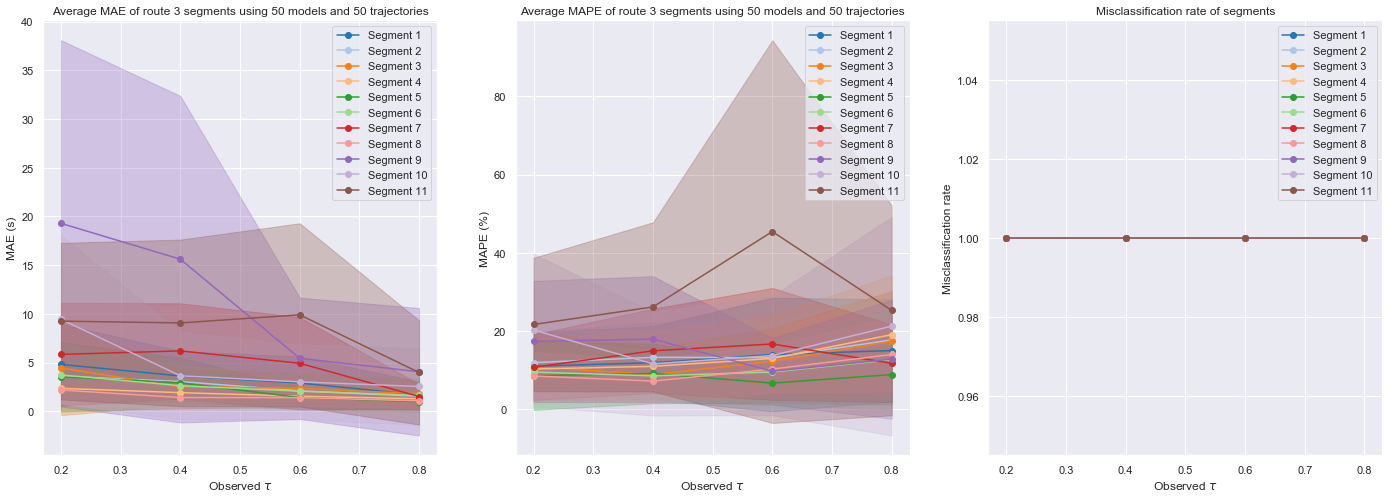

In [54]:
loaded = False
if loaded is False:
    test_trajs_pickle_path = '../data/test3.pkl'
    test_data = pd.read_pickle(test_trajs_pickle_path)
    n_test_trajs = list(test_data.traj.unique())
    n_test_trajs_to_use = 50 #len(n_trajs)
    test_trajs_to_use = frozenset(np.random.choice(n_test_trajs, size=n_test_trajs_to_use, replace=False))
    test_trajs = test_data[test_data.traj.transform(lambda j: j in test_trajs_to_use)]
    test_traj_ids = test_trajs.traj.unique()
    loaded=True
    
def load_test_seg(traj_n, seg_n):
    return test_trajs[
        (test_trajs.traj == traj_n) & 
        (test_trajs.seg == seg_n)
    ]


def out_of_sample_seg_loader(seg_n, traj_n, seg_size=1):
    return pre_process(
        load_test_seg(traj_n, seg_n), 
        stop_compress_delta, 
        seg_normalisers[seg_n],
        seg_size
    )

def pre_process_traj(traj, seg_n, seg_size):
    return pre_process(
        traj, 
        stop_compress_delta, 
        seg_normalisers[seg_n],
        seg_size
    )

np.random.seed(1)
tau_grid = [.2, .4, .6, .8]
model_limit = 50
route_ns = [3]
route_n = 3
traj_ns_to_test = [
    test_traj_ids[traj_n] 
    for traj_n in range(n_test_trajs_to_use)
]

maes, mapes, misclass = evaluate(
    route_n, tau_grid,
    most_probable_model_predictor,
    load_models, model_limit, 
    out_of_sample_seg_loader, 
    seg_ns_to_test, traj_ns_to_test 
)
plot_route_performance(
    route_n, model_limit, seg_ns_to_test,
    tau_grid, maes, mapes, misclass
)

In [255]:
route_n = 3
seg_n = 6
model_limit = 5
models_to_use = load_models(route_n, seg_n, model_limit)
model_ixs = range(len(models_to_use))

# Load in-sample segment
test_traj_ix = 0
test_traj_id = test_traj_ids[test_traj_ix]
fraction_observed = .8
seg = out_of_sample_seg_loader(
    seg_n, test_traj_id,
    fraction_observed
)

time_left = seg.iloc[-1].time_left
f_codomain = ['x', 'y', 'dx', 'dy']
X_obs = seg[f_codomain].values
t_mu_mus, t_mu_sigmas = model_t_mu_predictions(models_to_use, X_obs)
weights, model_probs, cum_model_probs = model_weights(models_to_use, X_obs)
print('predicting for', test_traj_id)
#plt.set_cmap()

from plotting import plot_most_probable_models, default_color
linestyle = lambda i: ':' # if i == test_traj_ix else ':'

#plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
plot_most_probable_models(
        models_to_use,
        weights,
        cum_model_probs,
        seg, 
        linestyle=linestyle,
        n_models=3
)

loaded 0 models


ValueError: not enough values to unpack (expected 2, got 0)

In [7]:
import sys
sys.path.append('C:\\Users\\sebas\\Documents\\plugg\\msc\\model')

In [5]:

from model import 

In [112]:

from model.pre_process import sliding_diff

x, y = seg.x.values, seg.y.values
dx, dy = sliding_diff(x), sliding_diff(y)
print(y[0] + dy[:47].sum())
print(y[47])

-0.09202117169798629
-0.09202117169798639


In [259]:
from model.plotting import plot_grid
from model.pre_process import duplicate
from model.function_model import predict

import seaborn as sns


dupe1, dupe2 = duplicate(x, y, 0.1)
fig, axs = plot_grid(1, 2)
mu_x, _ = predict(m.f_p_x, seg.tau.values.reshape(-1, 1))
mu_y, _ = predict(m.f_p_y, seg.tau.values.reshape(-1, 1))

axs[0].plot(seg.tau, mu_x)
sns.scatterplot(seg.tau, seg.x, ax=axs[0], label='Original', hue=seg.tau)
sns.scatterplot(seg.tau, dupe1[:, 0], ax=axs[0], label='Generated', hue=seg.tau)
sns.scatterplot(seg.tau, dupe2[:, 0], ax=axs[0], label='Generated', hue=seg.tau)
ax.set_title("Original trajectory and generated trajectories")


mu_x, _ = predict(m.f_p_x, seg.tau.values.reshape(-1, 1))
mu_y, _ = predict(m.f_p_y, seg.tau.values.reshape(-1, 1))

axs[1].plot(seg.tau, mu_y)
sns.scatterplot(seg.tau, seg.y, ax=axs[1], label='Original', hue=seg.tau)
sns.scatterplot(seg.tau, dupe1[:, 1], ax=axs[1], label='Generated', hue=seg.tau)
sns.scatterplot(seg.tau, dupe2[:, 1], ax=axs[1], label='Generated', hue=seg.tau)
ax.set_title("Original trajectory and generated trajectories")

#plt.ylim(-0.5, 0.)
#plt.xlim(-1.5, -.5)

NameError: name 'x' is not defined

In [110]:

def model_data_loglik(model, X_obs, tau):
    def loglik(x: ndarray, mu: ndarray, sigma: ndarray):
        """Assumes sigma is the diagonal of the covariance matrix."""
        z = x-mu
        #print(np.hstack([x,mu,sigma]))
        #print(sigma, -0.5*np.log(np.prod(sigma)))
        return -0.5*z*(1/sigma)*z \
            -0.5*np.log(np.prod(sigma))

    pos = X_obs[:,0:2]
    vel = X_obs[:,2:4]
    X_k_p_x, sigma_p_x = predict(model.f_p_x, tau)
    X_k_p_y, sigma_p_y = predict(model.f_p_y, tau)
    X_k_v_x, sigma_v_x = predict(model.f_v_x, tau)
    X_k_v_y, sigma_v_y = predict(model.f_v_y, tau)
    
    loglik_pos_x = loglik(pos[:,0].reshape(-1, 1), X_k_p_x, sigma_p_x)
    loglik_pos_y = loglik(pos[:,1].reshape(-1, 1), X_k_p_y, sigma_p_y)
    loglik_vel_x = loglik(vel[:,0].reshape(-1, 1), X_k_v_x, sigma_v_x)
    loglik_vel_y = loglik(vel[:,1].reshape(-1, 1), X_k_v_y, sigma_v_y)
    model_loglik = \
        loglik_pos_x + \
        loglik_pos_y + \
        loglik_vel_x + \
        loglik_vel_y

    if math.isinf(model_loglik) or math.isnan(model_loglik):
        print('inf loglik')
    
    return model_loglik



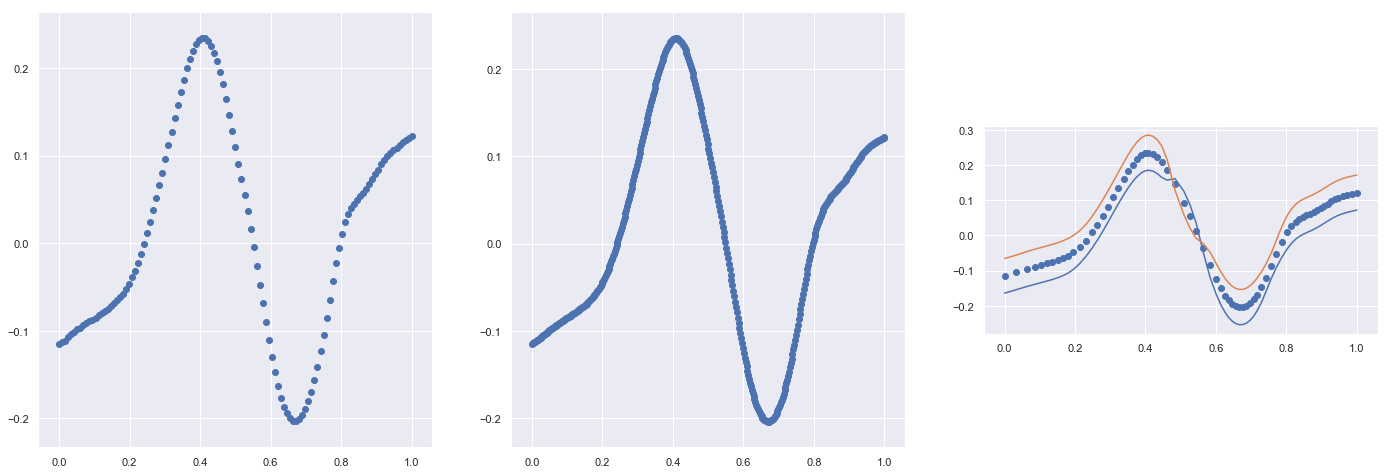

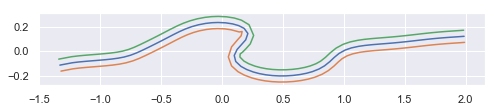

In [160]:
from model.trajectory_model import equidistant_points, predict
from model.pre_process import sliding_diff, duplicate
from model.plotting import plot_grid, default_color

tau_grid = np.linspace(0, 1, 400)
tau = tau_grid.reshape(-1 ,1)
mu_x, _ = predict(m.f_p_x, tau)
mu_y, _ = predict(m.f_p_y, tau)

eq_points = equidistant_points(tau, mu_x, mu_y, 0.05)
eq_tau = eq_points[:, 0]
eq_x = eq_points[:, 1]
eq_y = eq_points[:, 2]


fig, ax = plot_grid(1, 3)
ax[0].scatter(m.f_p_x.model.X, m.f_p_y.model.Y)
ax[1].scatter(tau, mu_y)

# These align, apart from final 2 points where duplication happens
dy = sliding_diff(eq_y)
dx = sliding_diff(eq_x)
np.sqrt(dy**2 + dx**2)


dupe1, dupe2 = duplicate(eq_x, eq_y, 0.05)
ax[2].plot(eq_tau, dupe1[:,1])
ax[2].plot(eq_tau, dupe2[:,1])
ax[2].scatter(eq_tau, eq_y)
ax[2].set_aspect('equal', 'box')

fig, ax2 = plot_grid(1, 1)
ax2.plot(eq_x, eq_y)
ax2.plot(dupe1[:,0], dupe1[:,1])
ax2.plot(dupe2[:,0], dupe2[:,1])

ax2.set_aspect('equal', 'box')

In [ ]:

def model_cum_loglik(
    model: TrajectoryModel,
    X_obs: ndarray, tau: ndarray) -> ndarray:

    inc_tau, inc_X_obs = zip(*[
        (tau[:n], X_obs[:n])
        for n in range(len(tau))
    ])
    print(inc_tau)
    return np.array([
        model_data_loglik(model, obs, tau)
        for tau, obs in zip(inc_tau, inc_X_obs)
    ]).reshape(-1, 1)

